# Analysis of NGC 3627 

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None) # uncomment to see all the rows in a dataframe

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : '14'}
rc('font', **font)

from astropy.io import fits
from astropy.coordinates import FK5, SkyCoord
import astropy.units as u

from XRBID.DataFrameMod import (Find, FindUnique)
from XRBID.CMDs import FitSED
from XRBID.WriteScript import WriteReg
from XRBID.Sources import Crossref, GetDaoPhots

import os, sys
sys.path.insert(0, '/Users/undergradstudent/Research/XRB-Analysis/Notebooks')
from helpers.analysis import remove_unnamed, XrayBinary
from helpers.analysis import (calculate_distance, calculate_velocity)

import seaborn as sns

# define directories to handle data in
cd = os.chdir
hstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/"
chandra_hst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/"
chandra_jwst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/"
jwstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/"
M66_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/"

# jwst directories
f200w = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits"
f300m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f300m_v1p1_img.fits"
f335m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f335m_v1p1_img.fits"
f360m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits"

# hst directories
f275w = hstdir+"M66_mosaic_uvis_f275w_drc_sci.fits"
f336w = hstdir+"M66_mosaic_uvis_f336w_drc_sci.fits"
f438w = hstdir+"M66_mosaic_uvis_f438w_drc_sci.fits"
f555w = hstdir+"M66_mosaic_uvis_f555w_drc_sci.fits"
f814w = hstdir+"M66_mosaic_uvis_f814w_drc_sci.fits"


I have performed XRBID identification with both [HST](https://github.com/devkhullar/querx/blob/main/galaxies/M66_corrected.ipynb) and [JWST](https://github.com/devkhullar/querx/blob/main/galaxies/M66_jwst.ipynb) on NGC 3627. Now, I am going to perform cluster analysis on the XRB sources within M66. This is the list of the tasks that are yet to be completed:
1. Merge JWST and HST work
    1. Figure out the compact association catalog to use.
2. Perform Cluster analysis 
    1. Find the most likely parent cluster or compact association for each X-ray source.
    2. Distance Plots
    3. Minimum Velocity Plots
    4. Escape Velocity Plots
3. Maximum Velocity
    1. Write Algorithm for finding the maximum velocity
4. Make M/R velocity plots (look out for differences in LMXBs and HMXBs)
5. XRB Lx vs Distance Plots and XRB Lx vs Velocity (using min-max velocities as errorbars)

**Notes**
1. I first performed SED fitting with 'wfc3 + nircam' available through the XRBID package. It did not go very wel and the models were terrible. So I have now created my own version of the models which I will be using. 
2. We saw that the zeropoints that the NIRCAM F2000W was using was not correct, so I am going to perform its photometry again in M66_jwst notebook

# Merge HST and JWST work

As for combining HST+JWST, here's how I would do it: <br>
(1) You already have some DataFrames that cross-references the stars of each XRB in HST and JWST. If you haven't already, pull their photometries. You should use these to build a single DataFrame containing each XRB, all stars associated with each XRB, and their magnitudes in each filter. <br>
(2) You also have a DataFrame containing 2sig JWST stars that don't have HST counterparts. Get the photometries and concatenate it to the  DataFrame in (1). All of the HST headers should be empty for these stars, which is okay! The DataFrame should now include every XRB and every star associated with each XRB observed by HST, JWST, or both. <br>
(3) Create a new header to give each star a unique ID (like NGC3627-X01-S01 or something). You can now run this entire DataFrame through fitSED (using the acs+nircam or wfc3+nircam setting as the instrument and the new header as idheader). This should give you the best fit mass and age of each star associated with each XRB. <br>
(4) I would probably add back in the XRB IDs to the best fit model DataFrame. That way you can run Find on to pull the info for each XRB to get a range of masses and ages associated with it, which you can use to decide which cluster your XRB is most likely associated with. <br>
Let me know if you have questions! Also, if you think of a better way to do this, feel free to implement it. <br>

## Create the Crossref'd dataframe of JWST and HST work

In [2]:
jwst_daoclean = remove_unnamed(pd.read_csv(chandra_jwst_dir+"M66_daoclean_matches.frame"))
hst_daoclean = remove_unnamed(pd.read_csv(chandra_hst_dir+"M66_daoclean_matches.frame"))
hst_daoclean

X            Y  F555W ID  F275W ID  F336W ID  F438W ID  \
0    3728.392237  5731.691614     18393       NaN   95500.0   34799.0   
1    3730.382900  5734.693669     18431       NaN       NaN       NaN   
2    3690.922608  5713.903685     18254       NaN   95118.0   34583.0   
3    3693.339708  5721.089782     18303       NaN       NaN       NaN   
4    3746.714500  5828.653600     19206       NaN       NaN   35989.0   
..           ...          ...       ...       ...       ...       ...   
257  3768.771693  8363.063045     34886  203812.0  157738.0   59483.0   
258  4463.710840  2888.783967      1804   48203.0       NaN       NaN   
259  3375.849092  2661.999469      1476       NaN   25603.0    5443.0   
260  3375.849092  2661.999469      1476       NaN   25753.0       NaN   
261  2253.377834  8911.615949     35145       NaN  162170.0   60333.0   

     F814W ID          RA        Dec                 CSC ID  StarID  
0     17413.0  170.062466  12.991505  2CXO J112014.9+125929       1  
1     17413.0  170.062444  12.991539  2CXO J112014.9+125929       2  
2         NaN  170.062890  12.991310  2CXO J112015.0+125928       1  
3         NaN  170.062862  12.991389  2CXO J112015.0+125928       2  
4         NaN  170.062260  12.992573  2CXO J112014.9+125933       1  
..        ...         ...        ...                    ...     ...  
257       NaN  170.062011  13.020465  2CXO J112014.9+130113       1  
258    1718.0  170.054162  12.960218  2CXO J112013.0+125736       1  
259    1413.0  170.066447  12.957722  2CXO J112015.9+125727       1  
260       NaN  170.066447  12.957722  2CXO J112015.9+125727       2  
261   33337.0  170.079129  13.026502  2CXO J112018.9+130135       1  

[262 rows x 11 columns]

In [3]:
crossrefed_sources = Crossref(
    df=jwst_daoclean,
    regions=chandra_hst_dir+"M66_XRB_candidates_fk5.reg",
    catalogs=['HST'],
    sourceid='StarID',
    search_radius=0.00005,
    coordsys='fk5',
    coordheads=['RA', 'Dec'],
    outfile=M66_dir+"M66_daoclean_jwst_hst_crossref.frame"
)

crossrefed_sources = crossrefed_sources.rename(columns={'StarID': 'JWST ID'})
display(crossrefed_sources)
print("Mutual sources...")
mutual_sources = Find(crossrefed_sources, 'HST ID != NaN')
display(mutual_sources)

Finding cross-references between sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...


RA        Dec  JWST ID HST ID  F200W ID  F300M ID  F335M ID  \
0     170.062403  12.991447        1    NaN    186126   43256.0   39563.0   
1     170.062377  12.991509        2    NaN    186591   43256.0       NaN   
2     170.062861  12.991270        1      1    184798   42915.0   39221.0   
3     170.062923  12.991314        2      1    185199   42999.0   39292.0   
4     170.062862  12.991339        3      1    185366   43115.0   39406.0   
...          ...        ...      ...    ...       ...       ...       ...   
1584  170.054172  12.960079        2    NaN     26276       NaN       NaN   
1585  170.054284  12.960093        3    NaN     26305       NaN       NaN   
1586  170.054191  12.960178        4      1     26519    6497.0    5610.0   
1587  170.054263  12.960223        5    NaN     26624       NaN    5634.0   
1588  170.066405  12.957754        1    NaN     20630       NaN       NaN   

      F360M ID            X            Y                 CSC ID  
0          NaN  3094.278143  5769.996064  2CXO J112014.9+125929  
1      45349.0  3097.298769  5777.274662  2CXO J112014.9+125929  
2      44861.0  3042.030225  5749.281319  2CXO J112015.0+125928  
3      44947.0  3034.930921  5754.396561  2CXO J112015.0+125928  
4      45067.0  3041.938275  5757.419244  2CXO J112015.0+125928  
...        ...          ...          ...                    ...  
1584       NaN  4033.543404  2097.590954  2CXO J112013.0+125736  
1585       NaN  4020.687783  2099.179560  2CXO J112013.0+125736  
1586    6873.0  4031.312552  2109.128343  2CXO J112013.0+125736  
1587    6902.0  4023.074667  2114.406991  2CXO J112013.0+125736  
1588       NaN  2637.804107  1825.304918  2CXO J112015.9+125727  

[1589 rows x 11 columns]

Mutual sources...


RA        Dec  JWST ID HST ID  F200W ID  F300M ID  F335M ID  \
0    170.062861  12.991270        1      1    184798   42915.0   39221.0   
1    170.062923  12.991314        2      1    185199   42999.0   39292.0   
2    170.062862  12.991339        3      1    185366   43115.0   39406.0   
3    170.062862  12.991339        3      2    185366   43115.0   39406.0   
4    170.062860  12.991368        6      2    185610   43115.0   39406.0   
..          ...        ...      ...    ...       ...       ...       ...   
533  170.079682  13.007607       17      3    297917   67859.0       NaN   
534  170.079682  13.007607       17      4    297917   67859.0       NaN   
535  170.079491  13.007663       19      6    298214       NaN   62954.0   
536  170.079599  13.007786       23      7    298884       NaN       NaN   
537  170.054191  12.960178        4      1     26519    6497.0    5610.0   

     F360M ID            X            Y                 CSC ID  
0     44861.0  3042.030225  5749.281319  2CXO J112015.0+125928  
1     44947.0  3034.930921  5754.396561  2CXO J112015.0+125928  
2     45067.0  3041.938275  5757.419244  2CXO J112015.0+125928  
3     45067.0  3041.938275  5757.419244  2CXO J112015.0+125928  
4     45067.0  3042.154376  5760.742908  2CXO J112015.0+125928  
..        ...          ...          ...                    ...  
533       NaN  1123.163184  7662.043801  2CXO J112019.0+130027  
534       NaN  1123.163184  7662.043801  2CXO J112019.0+130027  
535   71040.0  1144.978450  7668.533855  2CXO J112019.0+130027  
536       NaN  1132.576056  7682.902277  2CXO J112019.0+130027  
537    6873.0  4031.312552  2109.128343  2CXO J112013.0+125736  

[538 rows x 11 columns]

In [4]:
# Merging HST IDs with the main dataframe for greater ease
mutual_sources = mutual_sources.rename(columns={
    'RA' : 'JWST RA',
    'Dec' : 'JWST Dec',
    'X' : 'JWST X', 
    'Y' : 'JWST Y',
    'F200W ID' : 'F2000W ID',
    'F300M ID' : 'F3000M ID',
    'F335M ID' : 'F3350M ID',
    'F360M ID' : 'F3600M ID'
    
})
hst_daoclean = hst_daoclean.rename(columns={
    'RA' : 'HST RA',
    'Dec' : 'HST Dec',
    'X' : 'HST X', 
    'Y' : 'HST Y',
    'StarID' : 'HST ID'
})
mutual_sources = mutual_sources.merge(hst_daoclean, on=['CSC ID', 'HST ID'])
mutual_sources

JWST RA   JWST Dec  JWST ID HST ID  F2000W ID  F3000M ID  F3350M ID  \
0    170.062861  12.991270        1      1     184798    42915.0    39221.0   
1    170.062923  12.991314        2      1     185199    42999.0    39292.0   
2    170.062862  12.991339        3      1     185366    43115.0    39406.0   
3    170.062862  12.991339        3      2     185366    43115.0    39406.0   
4    170.062860  12.991368        6      2     185610    43115.0    39406.0   
..          ...        ...      ...    ...        ...        ...        ...   
533  170.079682  13.007607       17      3     297917    67859.0        NaN   
534  170.079682  13.007607       17      4     297917    67859.0        NaN   
535  170.079491  13.007663       19      6     298214        NaN    62954.0   
536  170.079599  13.007786       23      7     298884        NaN        NaN   
537  170.054191  12.960178        4      1      26519     6497.0     5610.0   

     F3600M ID       JWST X       JWST Y                 CSC ID        HST X  \
0      44861.0  3042.030225  5749.281319  2CXO J112015.0+125928  3690.922608   
1      44947.0  3034.930921  5754.396561  2CXO J112015.0+125928  3690.922608   
2      45067.0  3041.938275  5757.419244  2CXO J112015.0+125928  3690.922608   
3      45067.0  3041.938275  5757.419244  2CXO J112015.0+125928  3693.339708   
4      45067.0  3042.154376  5760.742908  2CXO J112015.0+125928  3693.339708   
..         ...          ...          ...                    ...          ...   
533        NaN  1123.163184  7662.043801  2CXO J112019.0+130027  2208.450122   
534        NaN  1123.163184  7662.043801  2CXO J112019.0+130027  2203.147517   
535    71040.0  1144.978450  7668.533855  2CXO J112019.0+130027  2219.766700   
536        NaN  1132.576056  7682.902277  2CXO J112019.0+130027  2213.211646   
537     6873.0  4031.312552  2109.128343  2CXO J112013.0+125736  4463.710840   

           HST Y  F555W ID  F275W ID  F336W ID  F438W ID  F814W ID  \
0    5713.903685     18254       NaN   95118.0   34583.0       NaN   
1    5713.903685     18254       NaN   95118.0   34583.0       NaN   
2    5713.903685     18254       NaN   95118.0   34583.0       NaN   
3    5721.089782     18303       NaN       NaN       NaN       NaN   
4    5721.089782     18303       NaN       NaN       NaN       NaN   
..           ...       ...       ...       ...       ...       ...   
533  7192.852518     31213       NaN  135197.0   53744.0       NaN   
534  7193.587937     31217       NaN  135223.0   53743.0       NaN   
535  7203.825438     31301       NaN  135467.0       NaN       NaN   
536  7211.601845     31360       NaN       NaN   53928.0       NaN   
537  2888.783967      1804   48203.0       NaN       NaN    1718.0   

         HST RA    HST Dec  
0    170.062890  12.991310  
1    170.062890  12.991310  
2    170.062890  12.991310  
3    170.062862  12.991389  
4    170.062862  12.991389  
..          ...        ...  
533  170.079635  13.007586  
534  170.079695  13.007594  
535  170.079507  13.007706  
536  170.079581  13.007792  
537  170.054162  12.960218  

[538 rows x 20 columns]

In [5]:
mutual_sources.to_csv(M66_dir+'M66_XRB_hst_jwst_crossref.txt')

## Pull the photometries of all the sources

In [6]:
mutual_sources

JWST RA   JWST Dec  JWST ID HST ID  F2000W ID  F3000M ID  F3350M ID  \
0    170.062861  12.991270        1      1     184798    42915.0    39221.0   
1    170.062923  12.991314        2      1     185199    42999.0    39292.0   
2    170.062862  12.991339        3      1     185366    43115.0    39406.0   
3    170.062862  12.991339        3      2     185366    43115.0    39406.0   
4    170.062860  12.991368        6      2     185610    43115.0    39406.0   
..          ...        ...      ...    ...        ...        ...        ...   
533  170.079682  13.007607       17      3     297917    67859.0        NaN   
534  170.079682  13.007607       17      4     297917    67859.0        NaN   
535  170.079491  13.007663       19      6     298214        NaN    62954.0   
536  170.079599  13.007786       23      7     298884        NaN        NaN   
537  170.054191  12.960178        4      1      26519     6497.0     5610.0   

     F3600M ID       JWST X       JWST Y                 CSC ID        HST X  \
0      44861.0  3042.030225  5749.281319  2CXO J112015.0+125928  3690.922608   
1      44947.0  3034.930921  5754.396561  2CXO J112015.0+125928  3690.922608   
2      45067.0  3041.938275  5757.419244  2CXO J112015.0+125928  3690.922608   
3      45067.0  3041.938275  5757.419244  2CXO J112015.0+125928  3693.339708   
4      45067.0  3042.154376  5760.742908  2CXO J112015.0+125928  3693.339708   
..         ...          ...          ...                    ...          ...   
533        NaN  1123.163184  7662.043801  2CXO J112019.0+130027  2208.450122   
534        NaN  1123.163184  7662.043801  2CXO J112019.0+130027  2203.147517   
535    71040.0  1144.978450  7668.533855  2CXO J112019.0+130027  2219.766700   
536        NaN  1132.576056  7682.902277  2CXO J112019.0+130027  2213.211646   
537     6873.0  4031.312552  2109.128343  2CXO J112013.0+125736  4463.710840   

           HST Y  F555W ID  F275W ID  F336W ID  F438W ID  F814W ID  \
0    5713.903685     18254       NaN   95118.0   34583.0       NaN   
1    5713.903685     18254       NaN   95118.0   34583.0       NaN   
2    5713.903685     18254       NaN   95118.0   34583.0       NaN   
3    5721.089782     18303       NaN       NaN       NaN       NaN   
4    5721.089782     18303       NaN       NaN       NaN       NaN   
..           ...       ...       ...       ...       ...       ...   
533  7192.852518     31213       NaN  135197.0   53744.0       NaN   
534  7193.587937     31217       NaN  135223.0   53743.0       NaN   
535  7203.825438     31301       NaN  135467.0       NaN       NaN   
536  7211.601845     31360       NaN       NaN   53928.0       NaN   
537  2888.783967      1804   48203.0       NaN       NaN    1718.0   

         HST RA    HST Dec  
0    170.062890  12.991310  
1    170.062890  12.991310  
2    170.062890  12.991310  
3    170.062862  12.991389  
4    170.062862  12.991389  
..          ...        ...  
533  170.079635  13.007586  
534  170.079695  13.007594  
535  170.079507  13.007706  
536  170.079581  13.007792  
537  170.054162  12.960218  

[538 rows x 20 columns]

In [7]:
photfiles = [
    jwstdir+'photometry_M66_f2000w_nircam_sources_updated_zeropoint.ecsv',
    jwstdir+'photometry_M66_f300m_nircam_sources.ecsv',
    jwstdir+'photometry_M66_f335m_nircam_sources.ecsv',
    jwstdir+'photometry_M66_f360m_nircam_sources.ecsv',
    hstdir+'photometry_M66_f275w_wfc3_sources.ecsv',
    hstdir+'photometry_M66_f336w_wfc3_sources.ecsv',
    hstdir+'photometry_M66_f438w_wfc3_sources.ecsv',
    hstdir+'photometry_M66_f555w_wfc3_sources.ecsv',
    hstdir+'photometry_M66_f814w_wfc3_sources.ecsv',
]

filters = [
    'F2000W', 'F3000M', 'F3350M', 'F3600M',
    'F275W', 'F336W', 'F438W', 'F555W', 'F814W'
]

idheads = [
    'F2000W ID', 'F3000M ID', 'F3350M ID', 'F3600M ID',
    'F275W ID', 'F336W ID', 'F438W ID', 'F555W ID', 'F814W ID'
]

dist = 11.32e6
dmod = 5 * np.log10(dist) - 5

mutual_photometry = GetDaoPhots(
    df=mutual_sources,
    photfiles=photfiles,
    idheads=idheads,
    filters=filters,
    magheader='aperture_mag_corr',
    dmod=dmod,
    return_err=True
)

Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f2000w_nircam_sources_updated_zeropoint.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f300m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f335m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f360m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/photometry_M66_f275w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/photometry_M66_f336w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/photometry_M66_f438w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/photometry_M66_f555w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/

In [8]:
mutual_photometry.to_csv(M66_dir+'XRB-ejection/M66_HMXB_hst_jwst_photometry')
mutual_photometry

JWST RA   JWST Dec  JWST ID HST ID  F2000W ID  F3000M ID  F3350M ID  \
0    170.062861  12.991270        1      1     184798    42915.0    39221.0   
1    170.062923  12.991314        2      1     185199    42999.0    39292.0   
2    170.062862  12.991339        3      1     185366    43115.0    39406.0   
3    170.062862  12.991339        3      2     185366    43115.0    39406.0   
4    170.062860  12.991368        6      2     185610    43115.0    39406.0   
..          ...        ...      ...    ...        ...        ...        ...   
533  170.079682  13.007607       17      3     297917    67859.0        NaN   
534  170.079682  13.007607       17      4     297917    67859.0        NaN   
535  170.079491  13.007663       19      6     298214        NaN    62954.0   
536  170.079599  13.007786       23      7     298884        NaN        NaN   
537  170.054191  12.960178        4      1      26519     6497.0     5610.0   

     F3600M ID       JWST X       JWST Y                 CSC ID        HST X  \
0      44861.0  3042.030225  5749.281319  2CXO J112015.0+125928  3690.922608   
1      44947.0  3034.930921  5754.396561  2CXO J112015.0+125928  3690.922608   
2      45067.0  3041.938275  5757.419244  2CXO J112015.0+125928  3690.922608   
3      45067.0  3041.938275  5757.419244  2CXO J112015.0+125928  3693.339708   
4      45067.0  3042.154376  5760.742908  2CXO J112015.0+125928  3693.339708   
..         ...          ...          ...                    ...          ...   
533        NaN  1123.163184  7662.043801  2CXO J112019.0+130027  2208.450122   
534        NaN  1123.163184  7662.043801  2CXO J112019.0+130027  2203.147517   
535    71040.0  1144.978450  7668.533855  2CXO J112019.0+130027  2219.766700   
536        NaN  1132.576056  7682.902277  2CXO J112019.0+130027  2213.211646   
537     6873.0  4031.312552  2109.128343  2CXO J112013.0+125736  4463.710840   

           HST Y  F555W ID  F275W ID  F336W ID  F438W ID  F814W ID  \
0    5713.903685     18254       NaN   95118.0   34583.0       NaN   
1    5713.903685     18254       NaN   95118.0   34583.0       NaN   
2    5713.903685     18254       NaN   95118.0   34583.0       NaN   
3    5721.089782     18303       NaN       NaN       NaN       NaN   
4    5721.089782     18303       NaN       NaN       NaN       NaN   
..           ...       ...       ...       ...       ...       ...   
533  7192.852518     31213       NaN  135197.0   53744.0       NaN   
534  7193.587937     31217       NaN  135223.0   53743.0       NaN   
535  7203.825438     31301       NaN  135467.0       NaN       NaN   
536  7211.601845     31360       NaN       NaN   53928.0       NaN   
537  2888.783967      1804   48203.0       NaN       NaN    1718.0   

         HST RA    HST Dec     F2000W  F2000W Err     F3000M  F3000M Err  \
0    170.062890  12.991310 -14.369536   -0.219898 -15.761625   -0.065325   
1    170.062890  12.991310 -14.028795   -0.296408 -15.434368   -0.088302   
2    170.062890  12.991310 -14.513981   -0.200001 -15.894534   -0.057798   
3    170.062862  12.991389 -14.513981   -0.200001 -15.894534   -0.057798   
4    170.062862  12.991389 -14.486361   -0.208202 -15.894534   -0.057798   
..          ...        ...        ...         ...        ...         ...   
533  170.079635  13.007586  -9.302007   -0.223203  -9.402144   -0.484233   
534  170.079695  13.007594  -9.302007   -0.223203  -9.402144   -0.484233   
535  170.079507  13.007706  -8.866422   -0.333883        NaN         NaN   
536  170.079581  13.007792  -8.772850   -0.356640        NaN         NaN   
537  170.054162  12.960218  -9.902529   -0.154548  -9.273787   -0.743486   

        F3350M  F3350M Err     F3600M  F3600M Err     F275W  F275W Err  \
0   -15.992875   -0.062570 -15.958139   -0.064580       NaN        NaN   
1   -15.700718   -0.081888 -15.684414   -0.083097       NaN        NaN   
2   -16.214079   -0.051037 -16.206706   -0.051366       NaN        NaN   
3   -16.214079   -0.051037 -16.206706   -0.05136

In [9]:
mutual_photometry = remove_unnamed(pd.read_csv(M66_dir+'XRB-ejection/M66_HMXB_hst_jwst_photometry'))
M66_notes = remove_unnamed(pd.read_csv(chandra_jwst_dir+"M66_XRB_notes.txt"))

In [10]:
# Merge Classifications of each source to find HMXB
temp = M66_notes[['CSC ID', 'Class']]
mutual_photometry = mutual_photometry.merge(temp, on='CSC ID', how='left')
M66_xrbs = Find(mutual_photometry, 'Class == HMXB')

M66_xrbs

JWST RA   JWST Dec  JWST ID  HST ID  F2000W ID  F3000M ID  F3350M ID  \
0   170.062313  12.992598        1       2     194701    45185.0        NaN   
1   170.062307  12.992623        3       2     194908    45185.0        NaN   
2   170.062255  12.992622        4       2     194909        NaN        NaN   
3   170.062808  12.993437        2       1     200852    46417.0    42593.0   
4   170.062752  12.993454        3       1     201035    46417.0    42593.0   
..         ...        ...      ...     ...        ...        ...        ...   
73  170.079682  13.007607       17       3     297917    67859.0        NaN   
74  170.079682  13.007607       17       4     297917    67859.0        NaN   
75  170.079491  13.007663       19       6     298214        NaN    62954.0   
76  170.079599  13.007786       23       7     298884        NaN        NaN   
77  170.054191  12.960178        4       1      26519     6497.0     5610.0   

    F3600M ID       JWST X       JWST Y                 CSC ID        HST X  \
0         NaN  3104.574104  5904.817673  2CXO J112014.9+125933  3743.843919   
1         NaN  3105.251503  5907.752641  2CXO J112014.9+125933  3743.843919   
2         NaN  3111.115373  5907.603774  2CXO J112014.9+125933  3743.843919   
3     48557.0  3048.131145  6003.004427  2CXO J112015.0+125936  3700.317585   
4         NaN  3054.473615  6004.938353  2CXO J112015.0+125936  3700.317585   
..        ...          ...          ...                    ...          ...   
73        NaN  1123.163184  7662.043801  2CXO J112019.0+130027  2208.450122   
74        NaN  1123.163184  7662.043801  2CXO J112019.0+130027  2203.147517   
75    71040.0  1144.978450  7668.533855  2CXO J112019.0+130027  2219.766700   
76        NaN  1132.576056  7682.902277  2CXO J112019.0+130027  2213.211646   
77     6873.0  4031.312552  2109.128343  2CXO J112013.0+125736  4463.710840   

          HST Y  F555W ID  F275W ID  F336W ID  F438W ID  F814W ID      HST RA  \
0   5833.507868     19247  130956.0       NaN   36055.0       NaN  170.062292   
1   5833.507868     19247  130956.0       NaN   36055.0       NaN  170.062292   
2   5833.507868     19247  130956.0       NaN   36055.0       NaN  170.062292   
3   5908.701948     19792       NaN       NaN   36916.0       NaN  170.062784   
4   5908.701948     19792       NaN       NaN   36916.0       NaN  170.062784   
..          ...       ...       ...       ...       ...       ...         ...   
73  7192.852518     31213       NaN  135197.0   53744.0       NaN  170.079635   
74  7193.587937     31217       NaN  135223.0   53743.0       NaN  170.079695   
75  7203.825438     31301       NaN  135467.0       NaN       NaN  170.079507   
76  7211.601845     31360       NaN       NaN   53928.0       NaN  170.079581   
77  2888.783967      1804   48203.0       NaN       NaN    1718.0  170.054162   

      HST Dec     F2000W  F2000W Err     F3000M  F3000M Err     F3350M  \
0   12.992626 -12.148228   -0.925911 -13.902257   -0.287522        NaN   
1   12.992626 -12.159049   -0.904646 -13.902257   -0.287522        NaN   
2   12.992626 -12.268460   -0.794376        NaN         NaN        NaN   
3   12.993454        NaN  184.978557 -11.584072   -1.756274 -12.044657   
4   12.993454  -8.534081  -14.801952 -11.584072   -1.756274 -12.044657   
..        ...        ...         ...        ...         ...        ...   
73  13.007586  -9.302007   -0.223203  -9.402144   -0.484233        NaN   
74  13.007594  -9.302007   -0.223203  -9.402144   -0.484233        NaN   
75  13.007706  -8.866422   -0.333883        NaN         NaN -10.817085   
76  13.007792  -8.772850   -0.356640        NaN         NaN        NaN   
77  12.960218  -9.902529   -0.154548  -9.273787   -0.743486  -9.818036   

    F3350M Err     F3600M  F3600M Err     F275W  F275W Err     F336W  \
0          NaN        NaN         NaN -2.974469  -1.372681       NaN   
1          NaN        NaN         NaN -2.974469  -1.372681       NaN   
2          NaN        NaN      

In my XRB catalog, there are about 18 XRBs. I need to compare `hmxbs_unique` with the `M66_jwst_hmxbs` dataframe to see which elements are missing

'2CXO J112011.8+125811', '2CXO J112015.9+125727' are not in the photometry dataframe so I need to add them manually. I will also flag them, just in case if need to look into them later. 

In [11]:
# JWST HMXBs photometry
M66_jwst_hmxbs = remove_unnamed(pd.read_csv(chandra_jwst_dir+"M66_hmxbs_photometry_jwst.csv"))
M66_hst_hmxbs = remove_unnamed(pd.read_csv(chandra_hst_dir+"M66_hmxbs_photometry.csv"))
hmxbs_unique = FindUnique(M66_xrbs, ['Class == HMXB'],header='CSC ID')
x, y = set(hmxbs_unique['CSC ID'].values), set(M66_jwst_hmxbs['CSC ID'].values)
x ^ y


{'2CXO J112011.8+125811', '2CXO J112013.5+125944', '2CXO J112015.9+125727'}

By some manual inspection I saw that these sources do not have a lot in common. So I am including their sources just to get an estimate of their ages. This could be useful for determining the cluster ages.

In [12]:
# Merge the two missing sources + the LMXBs within JWST
classif = M66_notes[['CSC ID', 'Class']]

jwst_daoclean = jwst_daoclean.rename(columns={
    'RA' : 'JWST RA',
    'Dec' : 'JWST Dec',
    'X' : 'JWST X', 
    'Y' : 'JWST Y',
    'F200W ID' : 'F2000W ID',
    'F300M ID' : 'F3000M ID',
    'F335M ID' : 'F3350M ID',
    'F360M ID' : 'F3600M ID',
    'StarID' : 'JWST ID'
})
jwst_daoclean = jwst_daoclean.merge(classif, on='CSC ID', how='left')
jwst_daoclean

JWST RA   JWST Dec  F2000W ID  F3000M ID  F3350M ID  F3600M ID  \
0     170.062403  12.991447     186126    43256.0    39563.0        NaN   
1     170.062377  12.991509     186591    43256.0        NaN    45349.0   
2     170.062861  12.991270     184798    42915.0    39221.0    44861.0   
3     170.062923  12.991314     185199    42999.0    39292.0    44947.0   
4     170.062862  12.991339     185366    43115.0    39406.0    45067.0   
...          ...        ...        ...        ...        ...        ...   
1486  170.054172  12.960079      26276        NaN        NaN        NaN   
1487  170.054284  12.960093      26305        NaN        NaN        NaN   
1488  170.054191  12.960178      26519     6497.0     5610.0     6873.0   
1489  170.054263  12.960223      26624        NaN     5634.0     6902.0   
1490  170.066405  12.957754      20630        NaN        NaN        NaN   

           JWST X       JWST Y                 CSC ID  JWST ID  \
0     3094.278143  5769.996064  2CXO J112014.9+125929        1   
1     3097.298769  5777.274662  2CXO J112014.9+125929        2   
2     3042.030225  5749.281319  2CXO J112015.0+125928        1   
3     3034.930921  5754.396561  2CXO J112015.0+125928        2   
4     3041.938275  5757.419244  2CXO J112015.0+125928        3   
...           ...          ...                    ...      ...   
1486  4033.543404  2097.590954  2CXO J112013.0+125736        2   
1487  4020.687783  2099.179560  2CXO J112013.0+125736        3   
1488  4031.312552  2109.128343  2CXO J112013.0+125736        4   
1489  4023.074667  2114.406991  2CXO J112013.0+125736        5   
1490  2637.804107  1825.304918  2CXO J112015.9+125727        1   

                    Class  
0                 Nucleus  
1                 Nucleus  
2     Compact Association  
3     Compact Association  
4     Compact Association  
...                   ...  
1486                 HMXB  
1487                 HMXB  
1488                 HMXB  
1489                 HMXB  
1490                 HMXB  

[1491 rows x 11 columns]

In [13]:
# 2. Add DataFrame containing 2sig JWST stars that don't have HST 
# counterparts. Get the photometries and concatenate it to the
# DataFrame in (1). All of the HST headers should be empty for 
# these stars, which is okay! The DataFrame should now include 
# every XRB and every star associated with each XRB observed 
# by HST, JWST, or both

photfiles = [
    jwstdir+'photometry_M66_f2000w_nircam_sources_updated_zeropoint.ecsv',
    jwstdir+'photometry_M66_f300m_nircam_sources.ecsv',
    jwstdir+'photometry_M66_f335m_nircam_sources.ecsv',
    jwstdir+'photometry_M66_f360m_nircam_sources.ecsv',
    hstdir+'photometry_M66_f275w_wfc3_sources.ecsv',
    hstdir+'photometry_M66_f336w_wfc3_sources.ecsv',
    hstdir+'photometry_M66_f438w_wfc3_sources.ecsv',
    hstdir+'photometry_M66_f555w_wfc3_sources.ecsv',
    hstdir+'photometry_M66_f814w_wfc3_sources.ecsv',
]

filters = [
    'F2000W', 'F3000M', 'F3350M', 'F3600M',
    'F275W', 'F336W', 'F438W', 'F555W', 'F814W'
]

idheads = [
    'F2000W ID', 'F3000M ID', 'F3350M ID', 'F3600M ID',
    'F275W ID', 'F336W ID', 'F438W ID', 'F555W ID', 'F814W ID'
]

dist = 11.32e6 # units pc from https://iopscience.iop.org/article/10.3847/1538-4357/ace162/meta#apjace162s2
dmod = 5 * np.log10(dist) - 5

jwst_src_phot = GetDaoPhots(
    df=jwst_daoclean,
    photfiles=photfiles[:4],
    idheads=idheads[:4],
    filters=filters[:4],
    magheader='aperture_mag_corr',
    dmod=dmod,
    return_err=True
)

hst_sources = hst_daoclean.query('`CSC ID` == "2CXO J112011.8+125811" or `CSC ID` == "2CXO J112015.9+125727"')\
                                    .reset_index(drop=True).copy()
hst_src_phot = GetDaoPhots(
    df=hst_sources,
    photfiles=photfiles[5:],
    idheads=idheads[5:],
    filters=filters[5:],
    magheader='aperture_mag_corr',
    dmod=dmod,
    return_err=True
)
hst_src_phot['Class'] = "HMXB"
temp = pd.concat([hst_src_phot, jwst_src_phot,])
display(temp)

# Merging the missing data and LMXBs with JWST
temp = temp.query('Class == "LMXB" or `CSC ID` == "2CXO J112011.8+125811" or `CSC ID` == "2CXO J112015.9+125727"')
M66_xrbs = pd.concat([M66_xrbs, temp]).reset_index(drop=True)
display(M66_xrbs)

Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f2000w_nircam_sources_updated_zeropoint.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f300m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f335m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f360m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/photometry_M66_f336w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/photometry_M66_f438w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/photometry_M66_f555w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/photometry_M66_f814w_wfc3_sources.ecsv


HST X        HST Y  F555W ID  F275W ID  F336W ID  F438W ID  \
0     4869.455824  3777.647306    3994.0       NaN       NaN   12079.0   
1     3375.849092  2661.999469    1476.0       NaN   25603.0    5443.0   
2     3375.849092  2661.999469    1476.0       NaN   25753.0       NaN   
0             NaN          NaN       NaN       NaN       NaN       NaN   
1             NaN          NaN       NaN       NaN       NaN       NaN   
...           ...          ...       ...       ...       ...       ...   
1486          NaN          NaN       NaN       NaN       NaN       NaN   
1487          NaN          NaN       NaN       NaN       NaN       NaN   
1488          NaN          NaN       NaN       NaN       NaN       NaN   
1489          NaN          NaN       NaN       NaN       NaN       NaN   
1490          NaN          NaN       NaN       NaN       NaN       NaN   

      F814W ID      HST RA    HST Dec                 CSC ID  HST ID  \
0       3930.0  170.049579  12.970000  2CXO J112011.8+125811     1.0   
1       1413.0  170.066447  12.957722  2CXO J112015.9+125727     1.0   
2          NaN  170.066447  12.957722  2CXO J112015.9+125727     2.0   
0          NaN         NaN        NaN  2CXO J112014.9+125929     NaN   
1          NaN         NaN        NaN  2CXO J112014.9+125929     NaN   
...        ...         ...        ...                    ...     ...   
1486       NaN         NaN        NaN  2CXO J112013.0+125736     NaN   
1487       NaN         NaN        NaN  2CXO J112013.0+125736     NaN   
1488       NaN         NaN        NaN  2CXO J112013.0+125736     NaN   
1489       NaN         NaN        NaN  2CXO J112013.0+125736     NaN   
1490       NaN         NaN        NaN  2CXO J112015.9+125727     NaN   

         F336W  F336W Err     F438W  F438W Err     F555W  F555W Err     F814W  \
0          NaN        NaN -5.435527  -0.169610 -5.700158  -0.285757 -6.724301   
1    -6.952726  -0.063543 -6.645948  -0.042113 -6.578605  -0.055671 -6.286217   
2    -8.089256  -0.024830       NaN        NaN -6.578605  -0.055671       NaN   
0          NaN        NaN       NaN        NaN       NaN        NaN       NaN   
1          NaN        NaN       NaN        NaN       NaN        NaN       NaN   
...        ...        ...       ...        ...       ...        ...       ...   
1486       NaN        NaN       NaN        NaN       NaN        NaN       NaN   
1487       NaN        NaN       NaN        NaN       NaN        NaN       NaN   
1488       NaN        NaN       NaN        NaN       NaN        NaN       NaN   
1489       NaN        NaN       NaN        NaN       NaN        NaN       NaN   
1490       NaN        NaN       NaN        NaN       NaN        NaN       NaN   

      F814W Err    Class     JWST RA   JWST Dec  F2000W ID  F3000M ID  \
0     -0.443484     HMXB         NaN        NaN        NaN        NaN   
1     -0.206731     HMXB         NaN        NaN        NaN        NaN   
2           NaN     HMXB         NaN        NaN        NaN        NaN   
0           NaN  Nucleus  170.062403  12.991447   186126.0    43256.0   
1           NaN  Nucleus  170.062377  12.991509   186591.0    43256.0   
...         ...      ...         ...        ...        ...        ...   
1486        NaN     HMXB  170.054172  12.960079    26276.0        NaN   
1487        NaN     HMXB  170.054284  12.960093    26305.0        NaN   
1488        NaN     HMXB  170.054191  12.960178    26519.0     6497.0   
1489        NaN     HMXB  170.054263  12.960223    26624.0        NaN   
1490        NaN     HMXB  170.066405  12.957754    20630.0        NaN   

      F3350M ID  F3600M ID       JWST X       JWST Y  JWST ID     F2000W  \
0           NaN        NaN          NaN          NaN      NaN        NaN   
1           NaN        NaN          NaN          NaN      NaN        NaN   
2           NaN        NaN          NaN          NaN      NaN        NaN   
0       39563.0        NaN  3094.278143  5769.996064      1.0 -15.420653   
1           NaN    45349.0  

JWST RA   JWST Dec  JWST ID  HST ID  F2000W ID  F3000M ID  F3350M ID  \
0    170.062313  12.992598      1.0     2.0   194701.0    45185.0        NaN   
1    170.062307  12.992623      3.0     2.0   194908.0    45185.0        NaN   
2    170.062255  12.992622      4.0     2.0   194909.0        NaN        NaN   
3    170.062808  12.993437      2.0     1.0   200852.0    46417.0    42593.0   
4    170.062752  12.993454      3.0     1.0   201035.0    46417.0    42593.0   
..          ...        ...      ...     ...        ...        ...        ...   
287  170.082249  13.008335      5.0     NaN   301712.0    68734.0    63775.0   
288  170.082391  13.008383      6.0     NaN   301987.0        NaN        NaN   
289  170.082184  13.008461      7.0     NaN   302409.0        NaN        NaN   
290  170.082296  13.008542      8.0     NaN   302771.0    69003.0        NaN   
291  170.066405  12.957754      1.0     NaN    20630.0        NaN        NaN   

     F3600M ID       JWST X       JWST Y                 CSC ID        HST X  \
0          NaN  3104.574104  5904.817673  2CXO J112014.9+125933  3743.843919   
1          NaN  3105.251503  5907.752641  2CXO J112014.9+125933  3743.843919   
2          NaN  3111.115373  5907.603774  2CXO J112014.9+125933  3743.843919   
3      48557.0  3048.131145  6003.004427  2CXO J112015.0+125936  3700.317585   
4          NaN  3054.473615  6004.938353  2CXO J112015.0+125936  3700.317585   
..         ...          ...          ...                    ...          ...   
287    71929.0   830.290481  7747.193740  2CXO J112019.7+130030          NaN   
288        NaN   814.097221  7752.830980  2CXO J112019.7+130030          NaN   
289        NaN   837.798846  7761.938022  2CXO J112019.7+130030          NaN   
290    72216.0   825.021184  7771.420423  2CXO J112019.7+130030          NaN   
291        NaN  2637.804107  1825.304918  2CXO J112015.9+125727          NaN   

           HST Y  F555W ID  F275W ID  F336W ID  F438W ID  F814W ID  \
0    5833.507868   19247.0  130956.0       NaN   36055.0       NaN   
1    5833.507868   19247.0  130956.0       NaN   36055.0       NaN   
2    5833.507868   19247.0  130956.0       NaN   36055.0       NaN   
3    5908.701948   19792.0       NaN       NaN   36916.0       NaN   
4    5908.701948   19792.0       NaN       NaN   36916.0       NaN   
..           ...       ...       ...       ...       ...       ...   
287          NaN       NaN       NaN       NaN       NaN       NaN   
288          NaN       NaN       NaN       NaN       NaN       NaN   
289          NaN       NaN       NaN       NaN       NaN       NaN   
290          NaN       NaN       NaN       NaN       NaN       NaN   
291          NaN       NaN       NaN       NaN       NaN       NaN   

         HST RA    HST Dec     F2000W  F2000W Err     F3000M  F3000M Err  \
0    170.062292  12.992626 -12.148228   -0.925911 -13.902257   -0.287522   
1    170.062292  12.992626 -12.159049   -0.904646 -13.902257   -0.287522   
2    170.062292  12.992626 -12.268460   -0.794376        NaN         NaN   
3    170.062784  12.993454        NaN  184.978557 -11.584072   -1.756274   
4    170.062784  12.993454  -8.534081  -14.801952 -11.584072   -1.756274   
..          ...        ...        ...         ...        ...         ...   
287         NaN        NaN -10.276548   -0.049398  -9.934312   -0.137687   
288         NaN        NaN  -9.018021   -0.152134        NaN         NaN   
289         NaN        NaN  -8.606931   -0.232199        NaN         NaN   
290         NaN        NaN  -9.248247   -0.124495  -8.887121   -0.344165   
291         NaN        NaN  -9.351721   -0.158024        NaN         NaN   

        F3350M  F3350M Err     F3600M  F3600M Err     F275W  F275W Err  F336W  \
0          NaN         NaN        NaN         NaN -2.974469  -1.372681    NaN   
1          NaN         NaN        NaN         NaN -2.974469  -1.372681    NaN   
2          NaN         NaN        NaN         NaN -2.974469  -1.372681    NaN   
3   -12.

In [14]:
# jwst_daoclean = remove_unnamed(pd.read_csv(chandra_jwst_dir+"M66_daoclean_matches_photometry.csv"))
# jwst_notes = remove_unnamed(pd.read_csv(chandra_jwst_dir+"M66_XRB_notes.txt"))

# # Select the classification of the XRB sources and add them to the photometry frame
# classif = jwst_notes[['CSC ID', 'Class']]
# jwst_daoclean = jwst_daoclean.merge(classif, on='CSC ID', how='left')
# jwst_daoclean

# # Select lmxbs and add them to the M66_xrb frames to perform SED fitting
# jwst_lmxbs = jwst_daoclean.query('`Class` == "LMXB"').reset_index(drop=True).copy()
# columns={
#     'F200W ID'    : 'F2000W ID',
#     'F300M ID'    : 'F3000M ID',
#     'F335M ID'    : 'F3350M ID',
#     'F360M ID'    : 'F3600M ID',
#     'F200W'       : 'F2000W',
#     'F300M'      : 'F3000M',
#     'F335M'       : 'F3350M',
#     'F360M'       : 'F3600M',
#     'F200W Err'   : 'F2000W Err',
#     'F300M Err'   : 'F3000M Err',
#     'F335M Err'   : 'F3350M Err',
#     'F360M Err'  : 'F3600M Err',
#     'StarID'      : 'JWST ID'
# }
# jwst_lmxbs = jwst_lmxbs.rename(columns=columns).drop(columns=['X', 'Y'])

# # Add the LMXBs to the main dataframe
# M66_xrbs = pd.concat([M66_xrbs, jwst_lmxbs]).reset_index(drop=True)
# M66_xrbs

In [15]:
from XRBID.WriteScript import WriteReg
WriteReg(
    sources=M66_xrbs,
    coordheads=['JWST RA', 'JWST Dec'],
    coordsys='fk5',
    idheader='HST ID',
    radius=0.07,
    radunit='arcsec',
    outfile='/Users/undergradstudent/Downloads/M66_mutual_sources_hst_jwst.reg'
)

Saving /Users/undergradstudent/Downloads/M66_mutual_sources_hst_jwst.reg
/Users/undergradstudent/Downloads/M66_mutual_sources_hst_jwst.reg saved!


In [16]:
# 3 and 4
M66_xrbs['Auxiliary ID'] = M66_xrbs['CSC ID'] +  "-" + M66_xrbs['JWST ID'].astype(str) \
                         + "-" + M66_xrbs['HST ID'].astype(str)

In [17]:
M66_xrbs.to_csv(M66_dir+'XRB-ejection/M66_hst_jwst_xrbs_photometry.csv')

## SED fitting, finally

In [18]:
# This run will give wrong age and mass measurements as there is something
# going wrong with the input models
# best_fit = FitSED(
#     df=M66_xrbs,
#     instrument='NIRCAM + WFC3',
#     idheader='Auxiliary ID',
#     plotSED=True
# )

Finding best-fit model(s)...
DONE


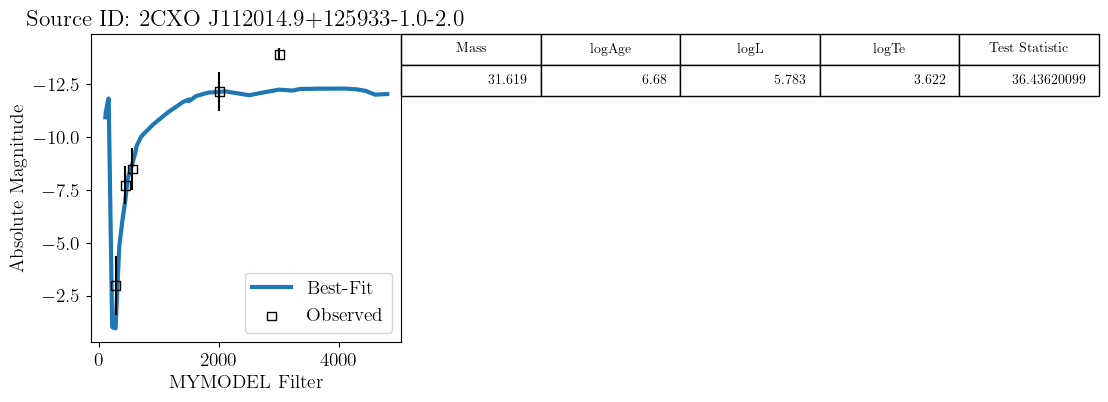

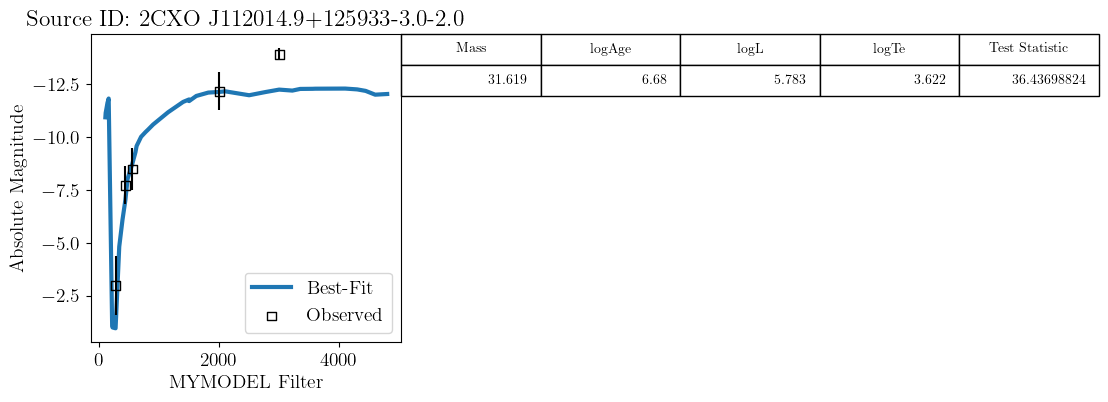

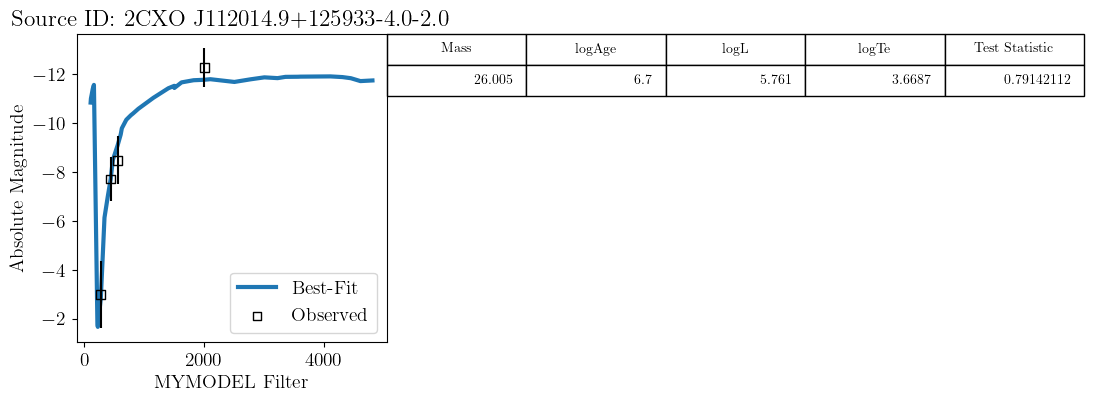

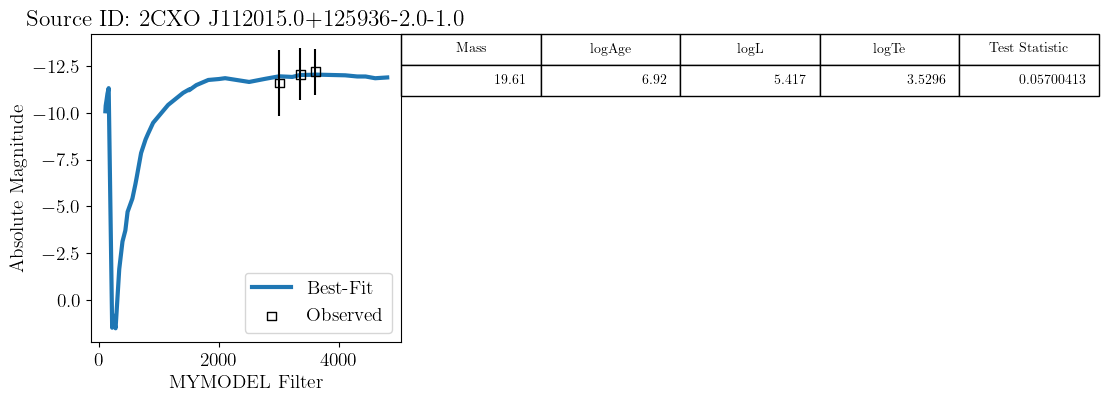

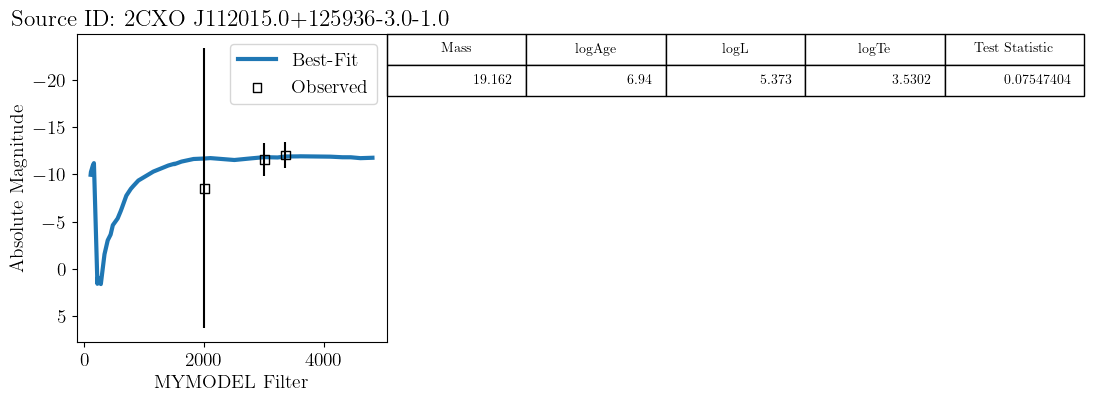

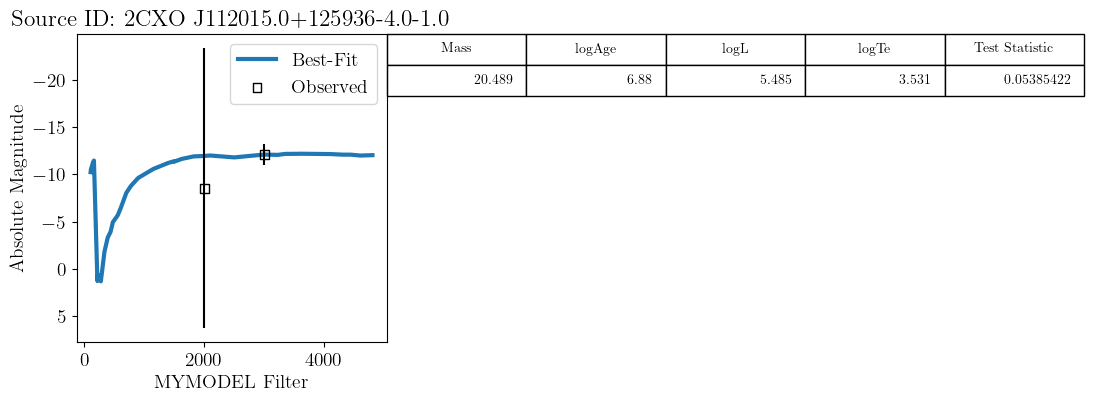

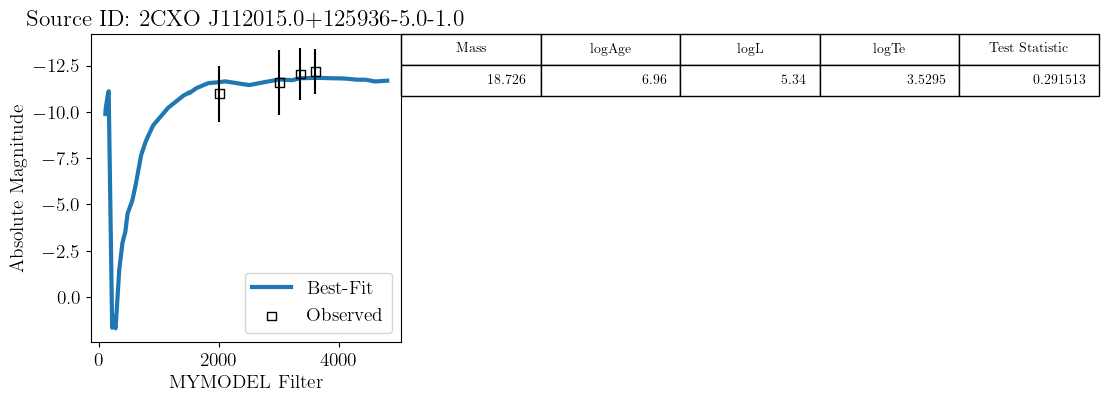

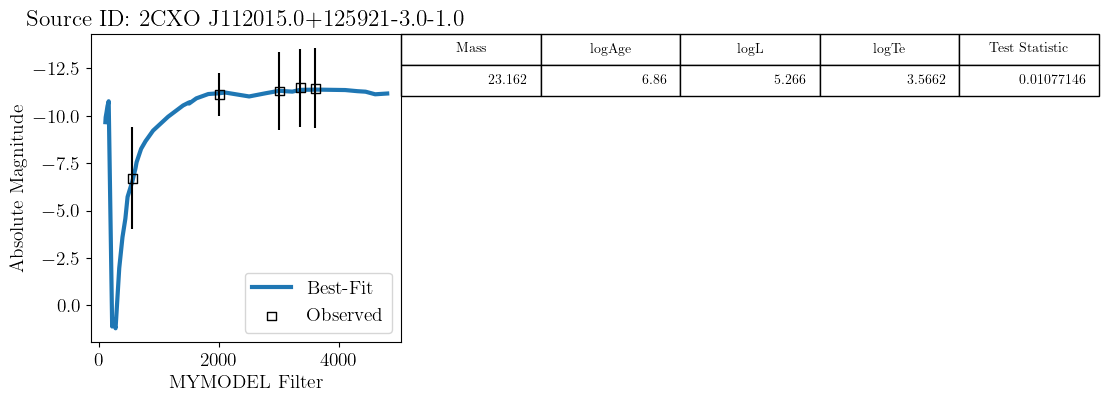

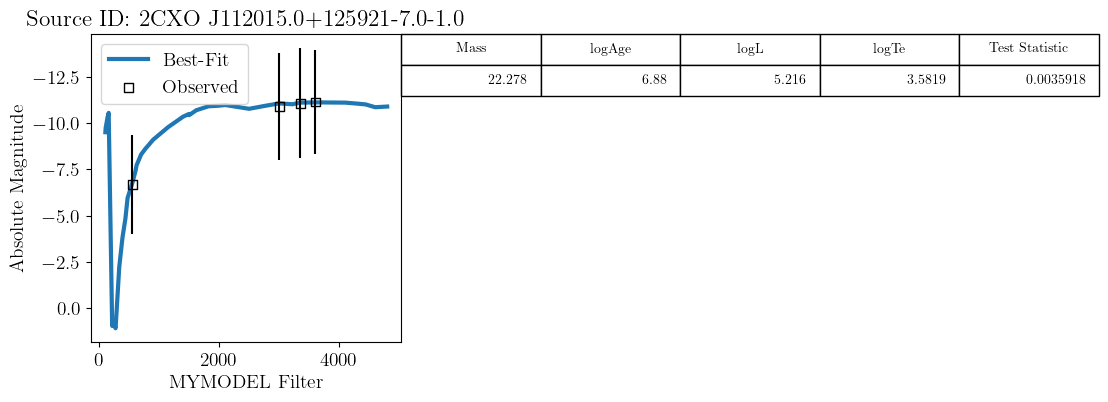

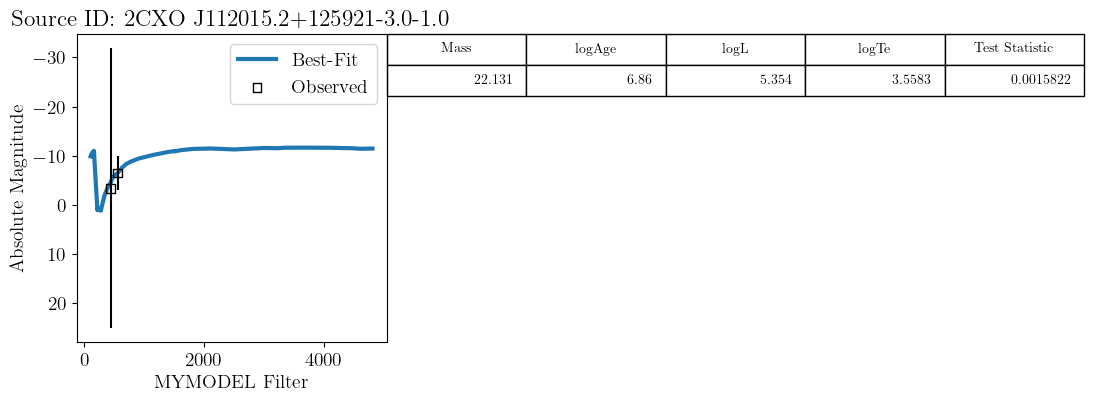

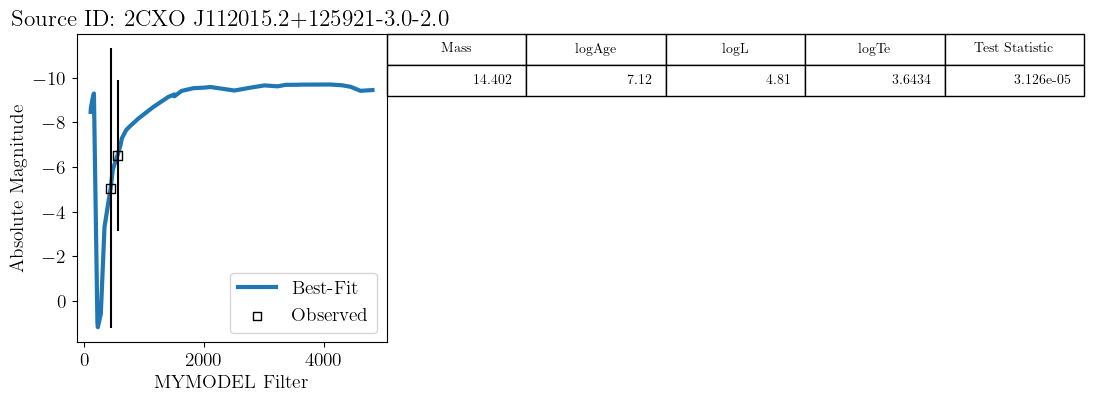

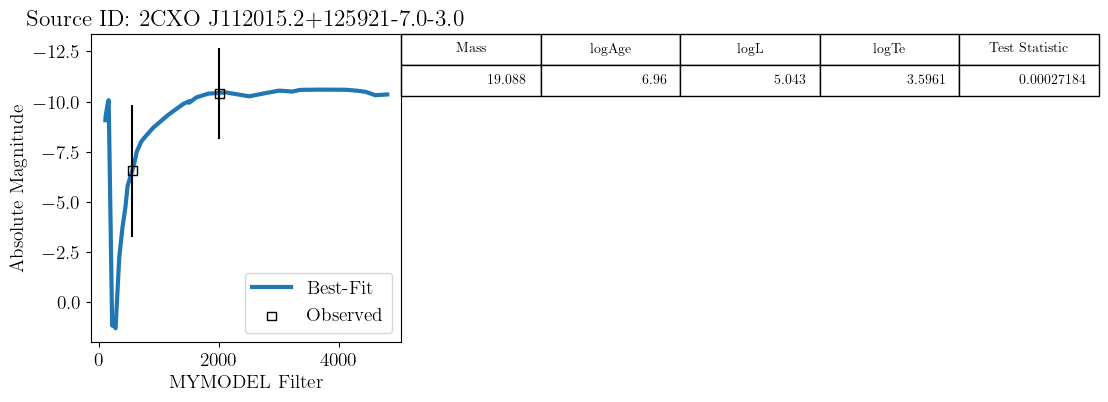

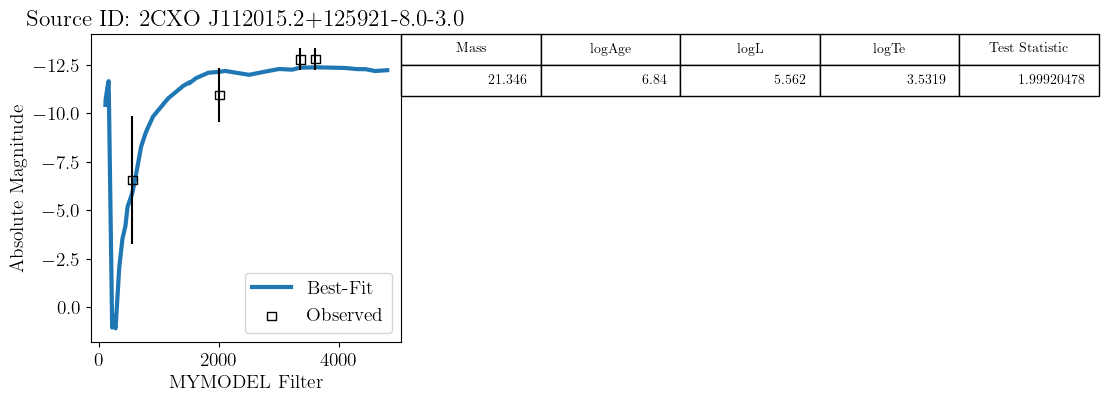

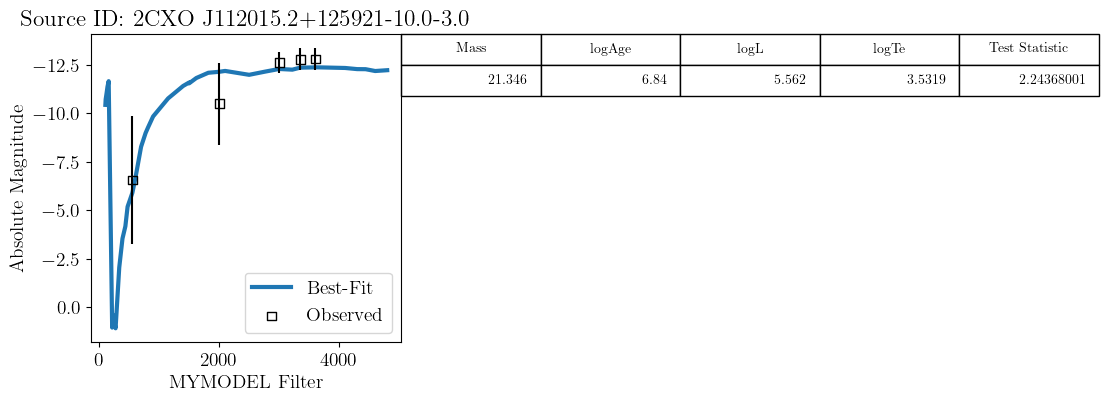

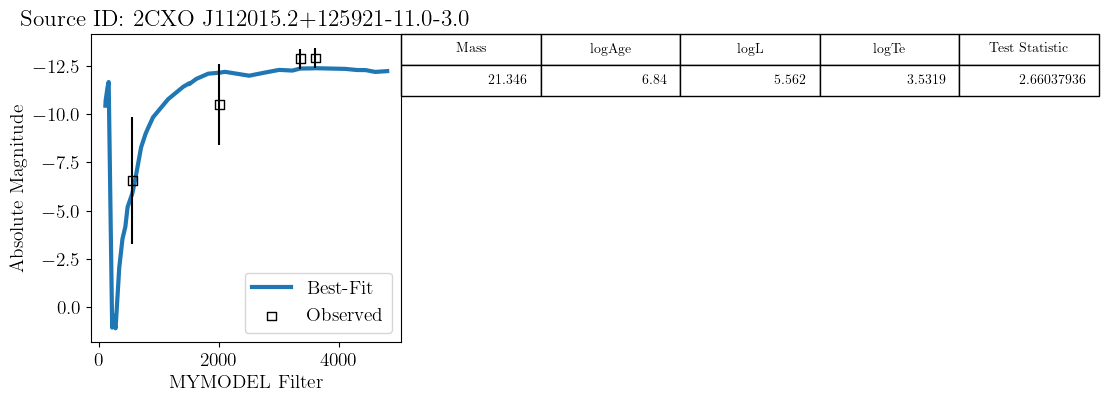

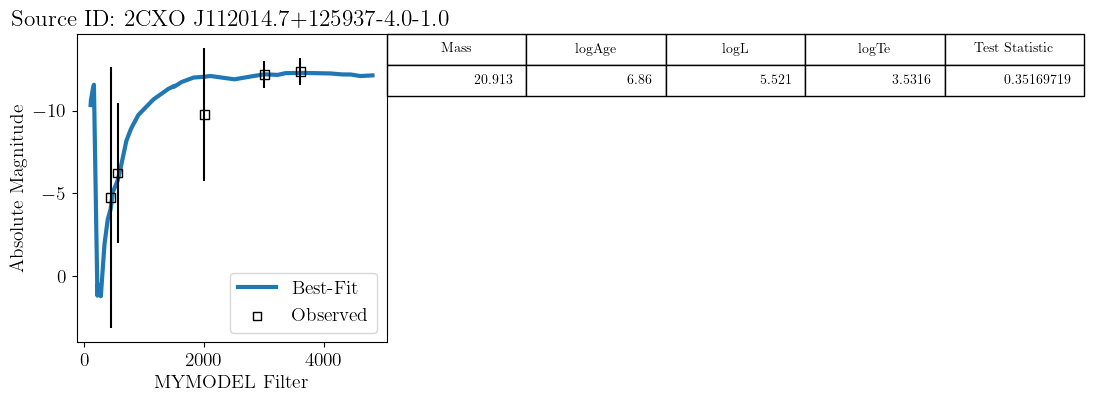

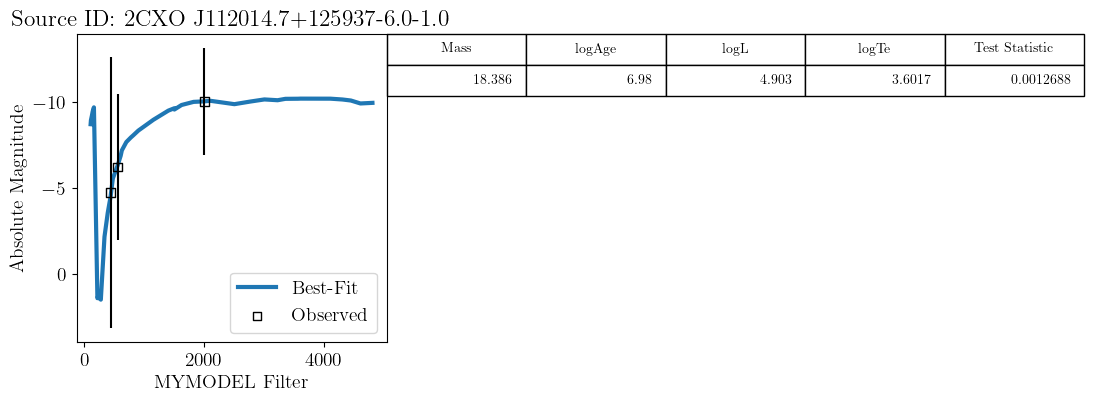

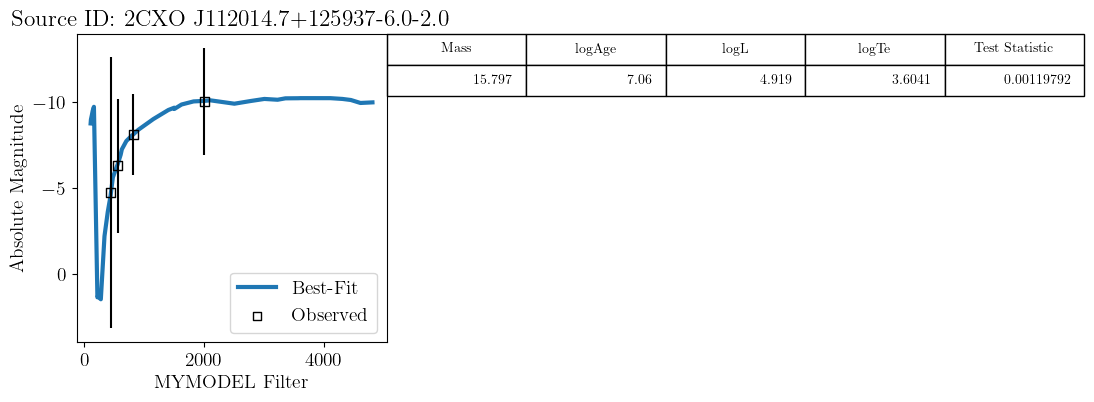

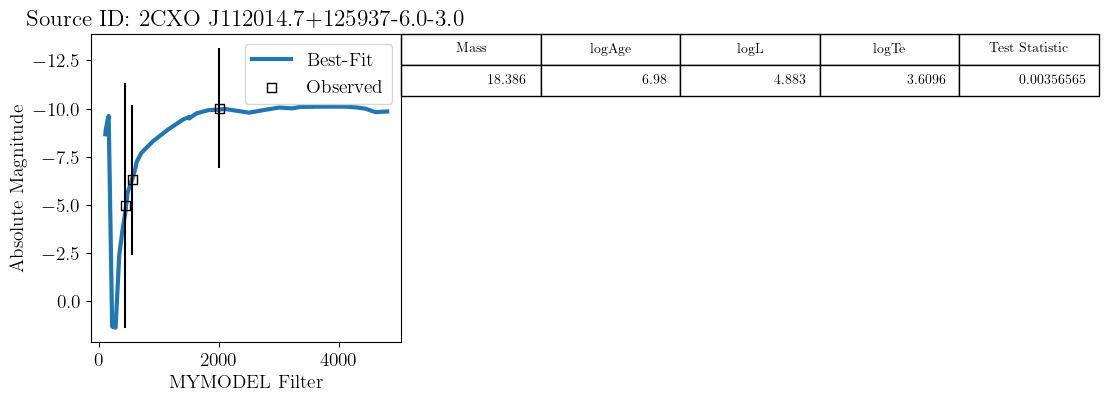

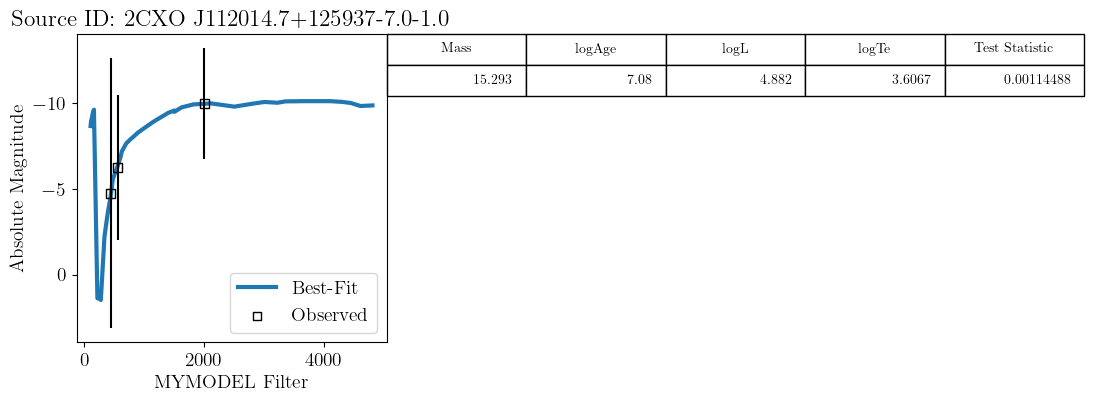

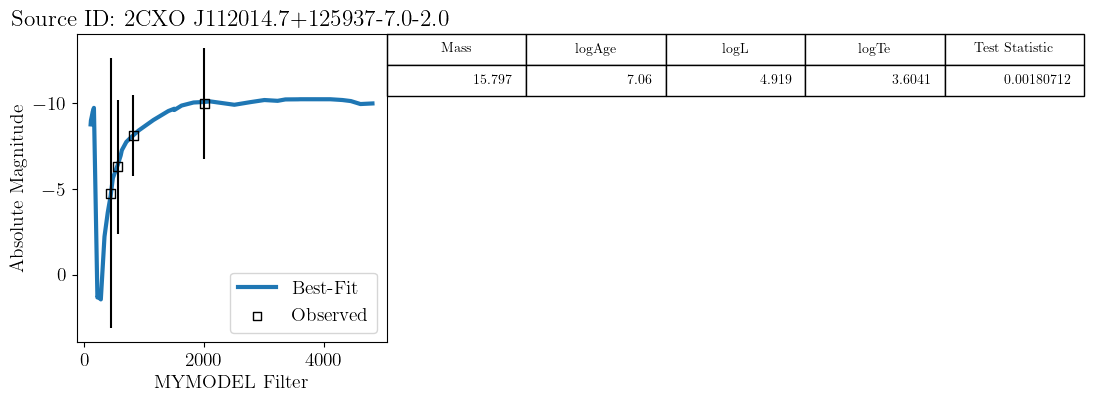

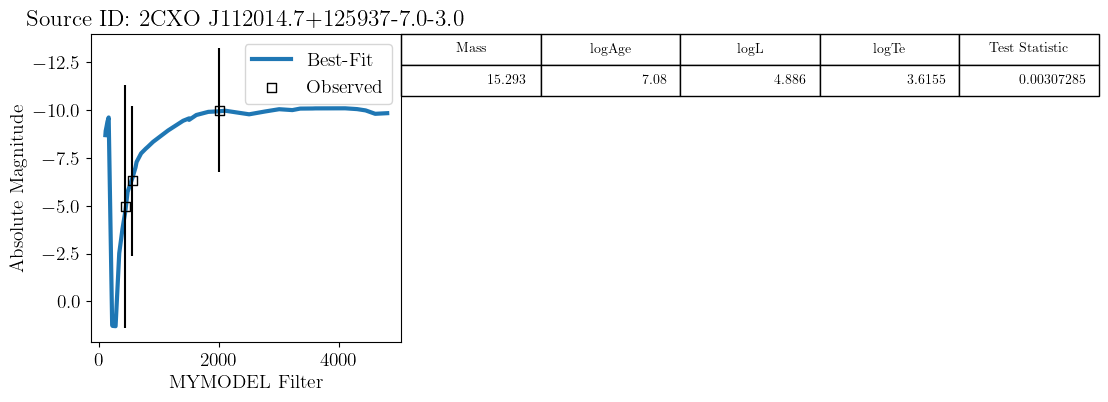

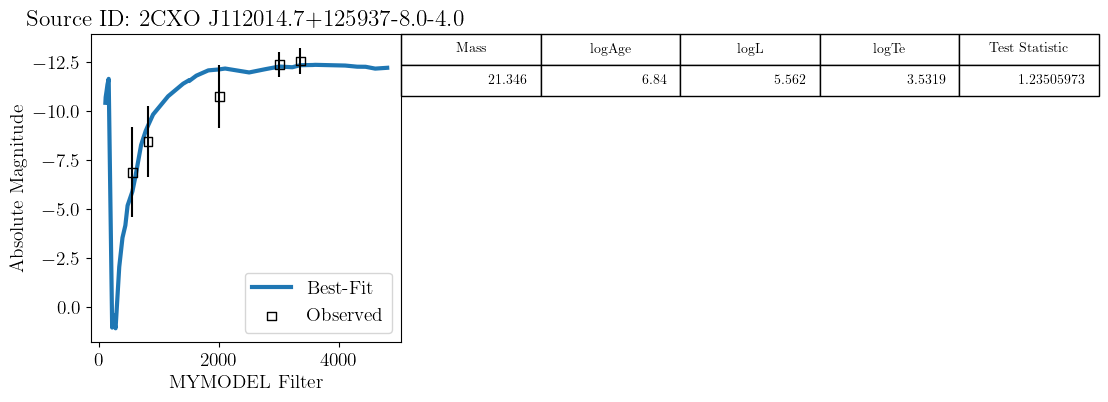

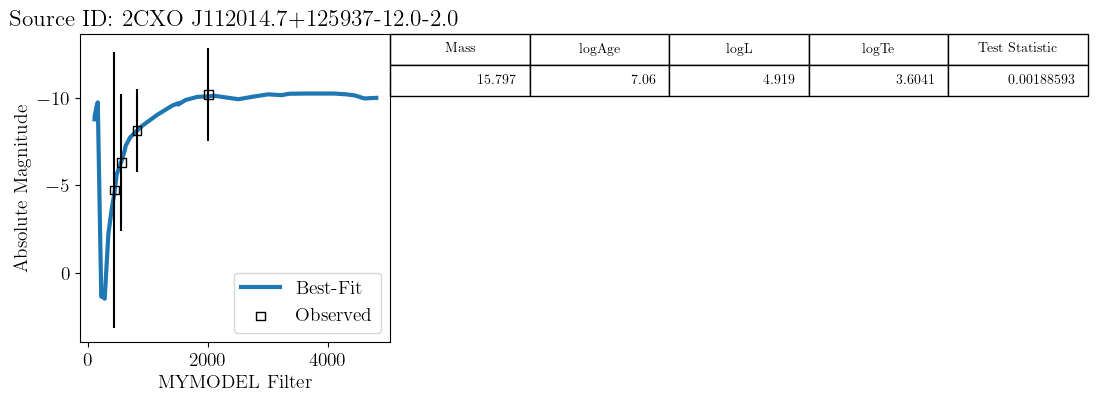

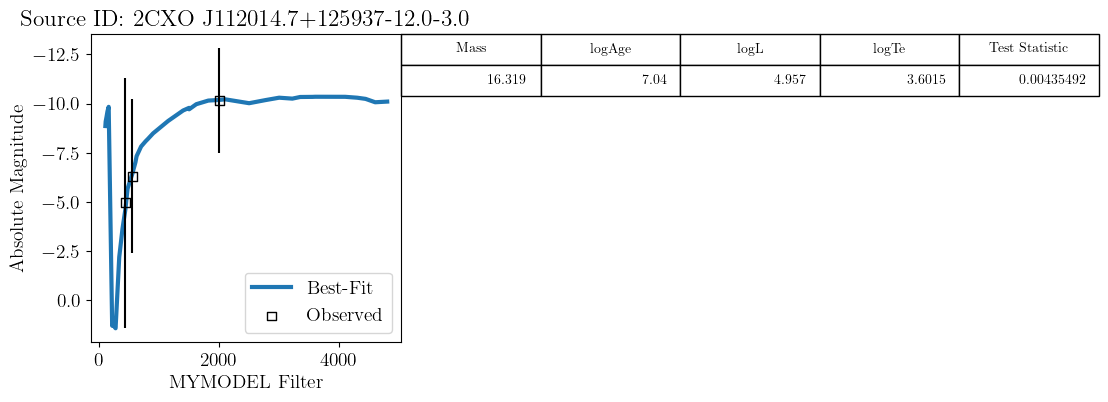

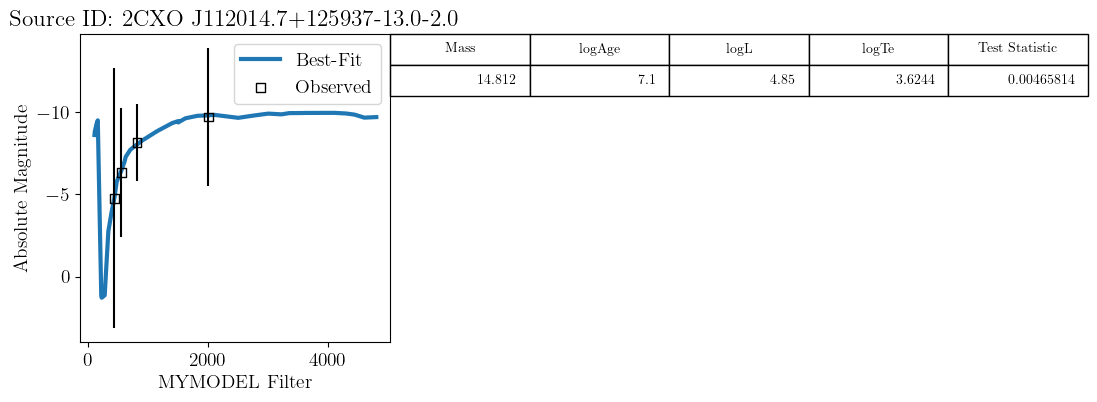

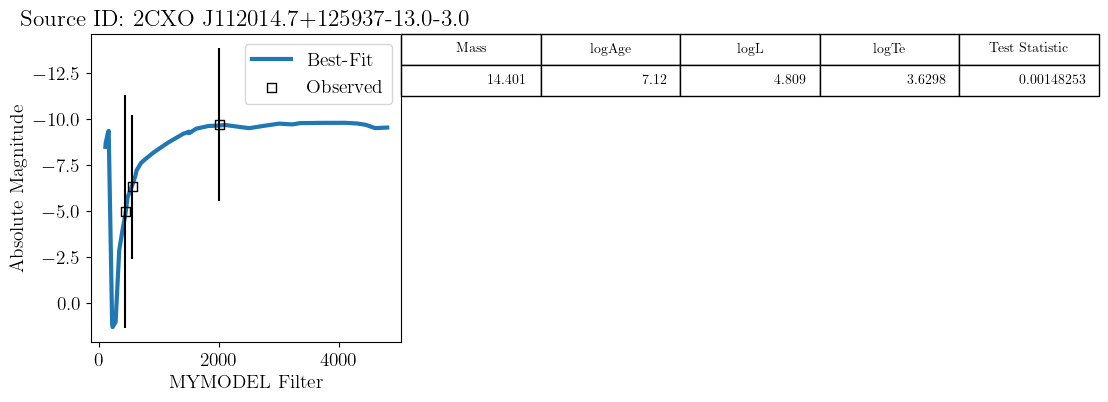

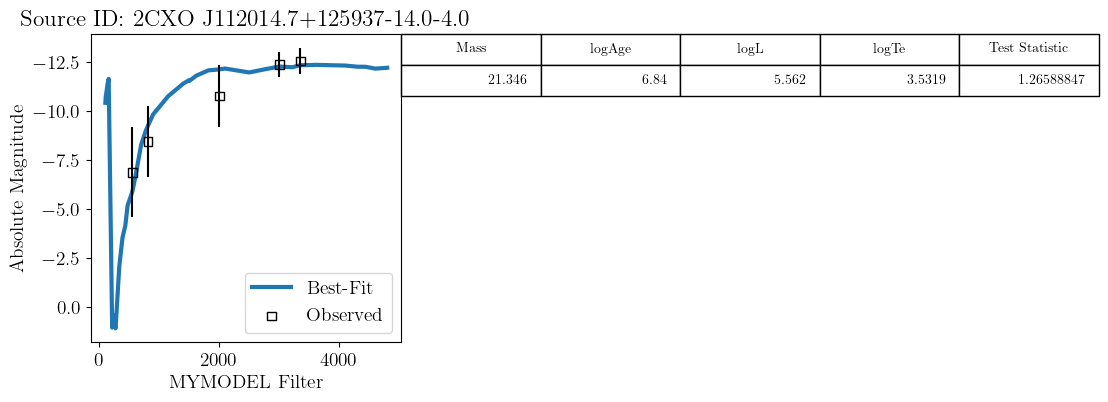

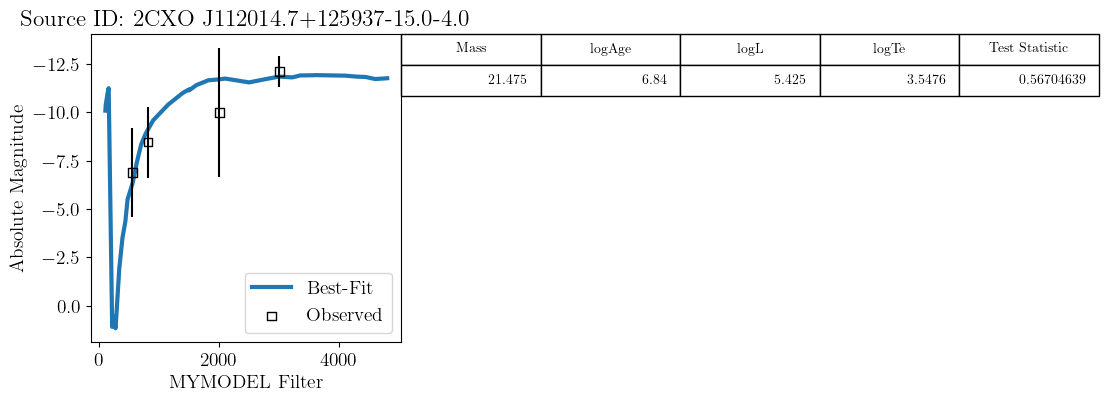

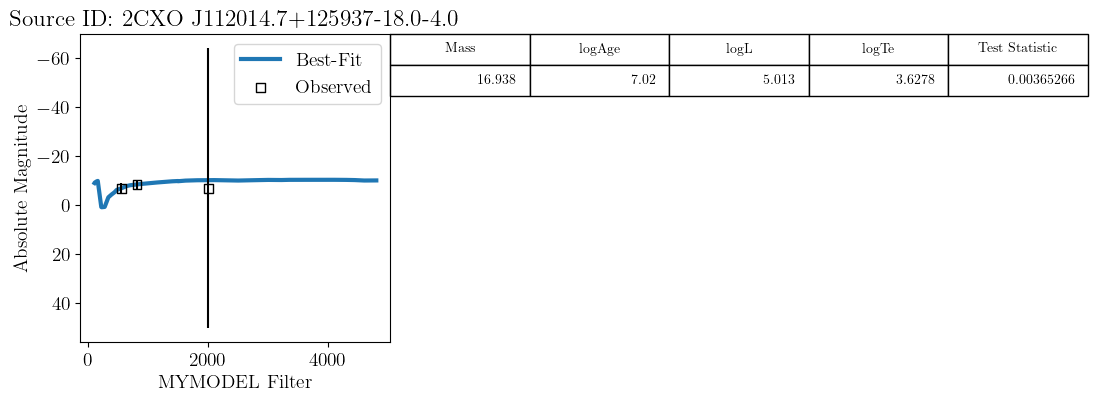

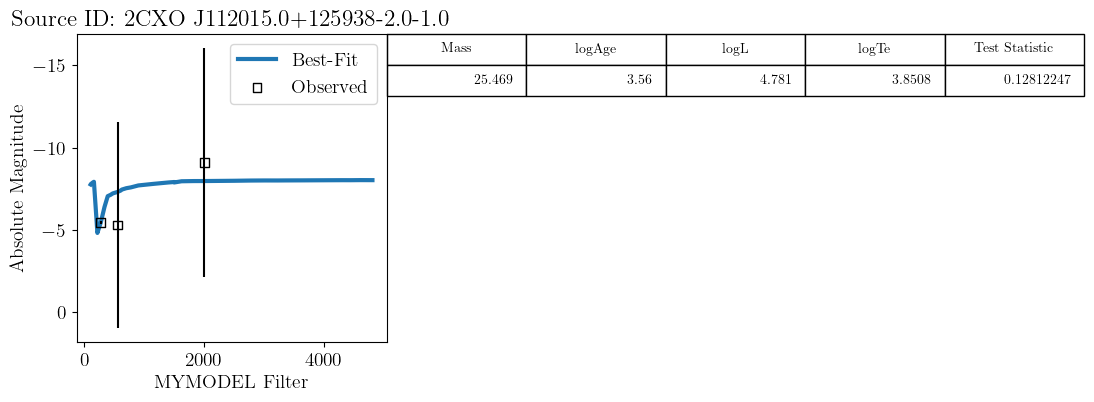

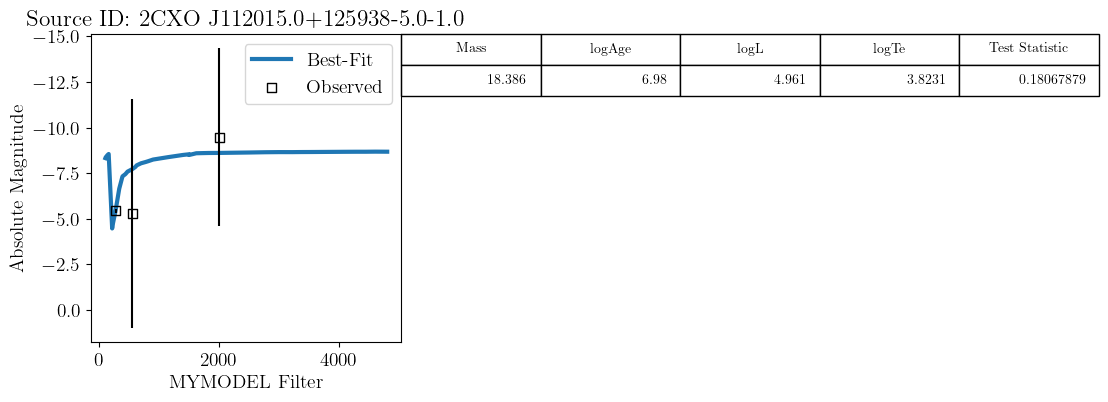

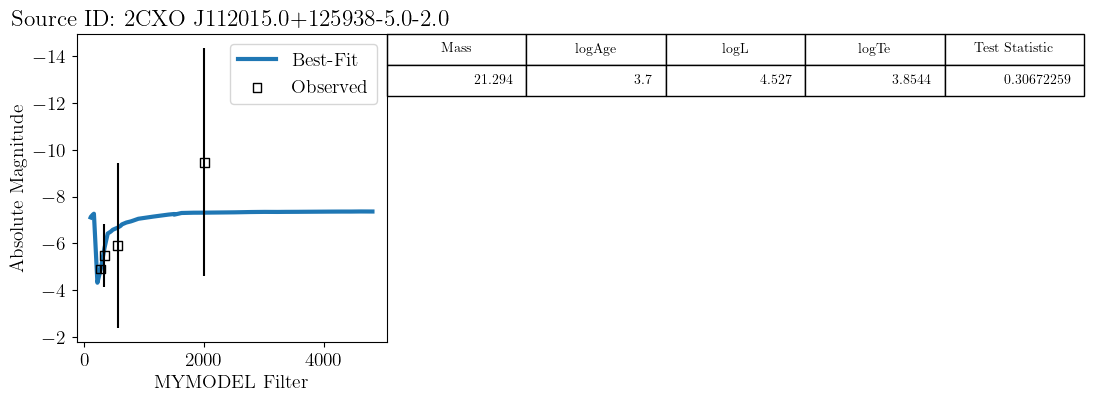

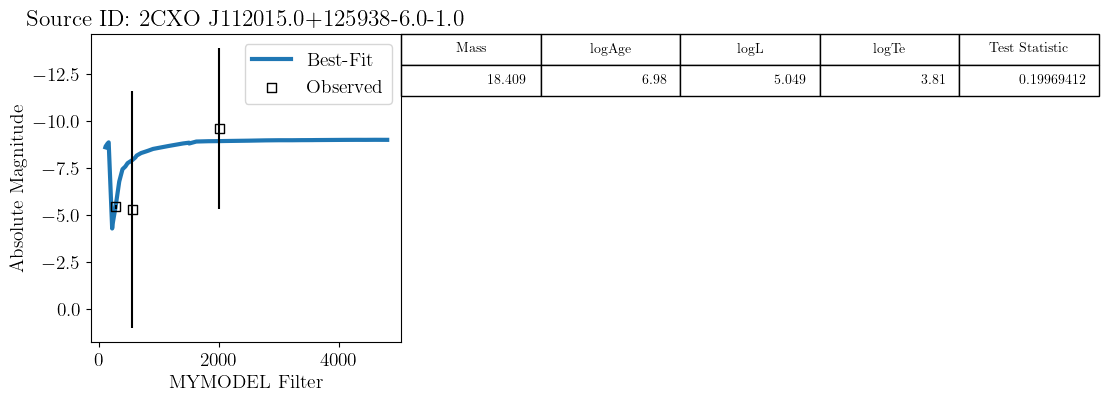

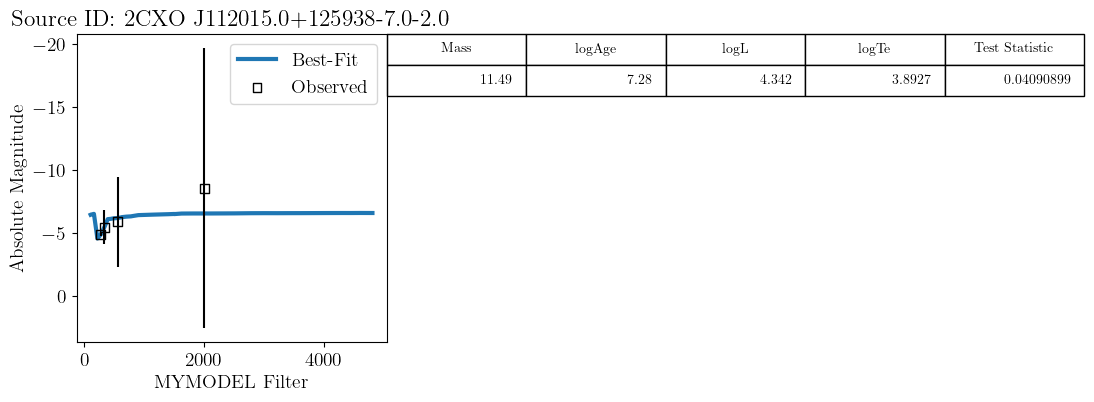

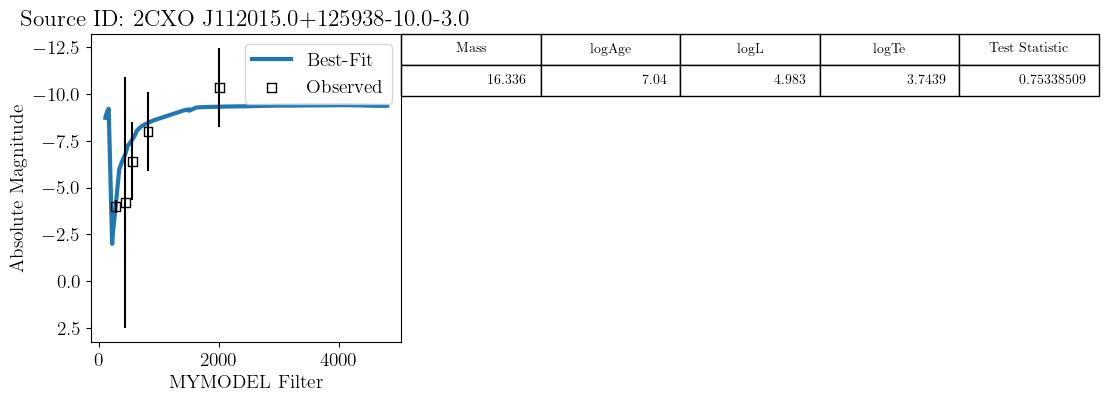

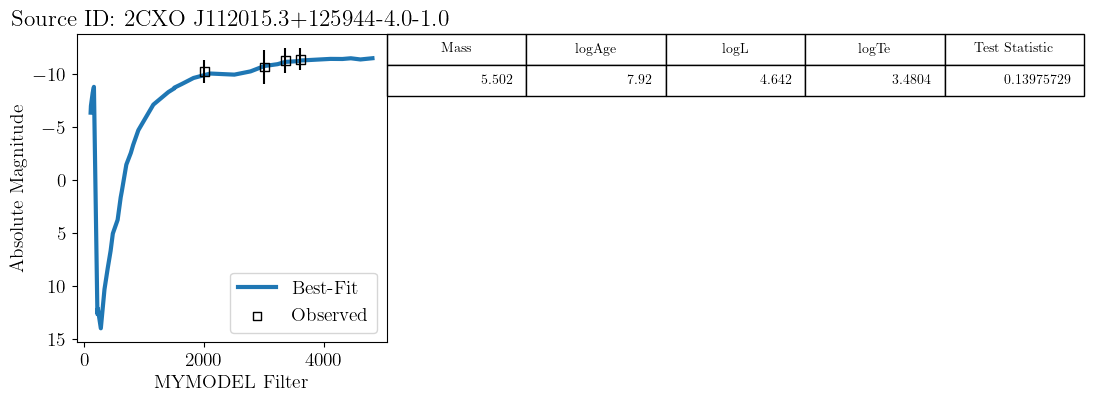

No best-fit model available for Source ID 2CXO J112015.3+125944-6.0-1.0.


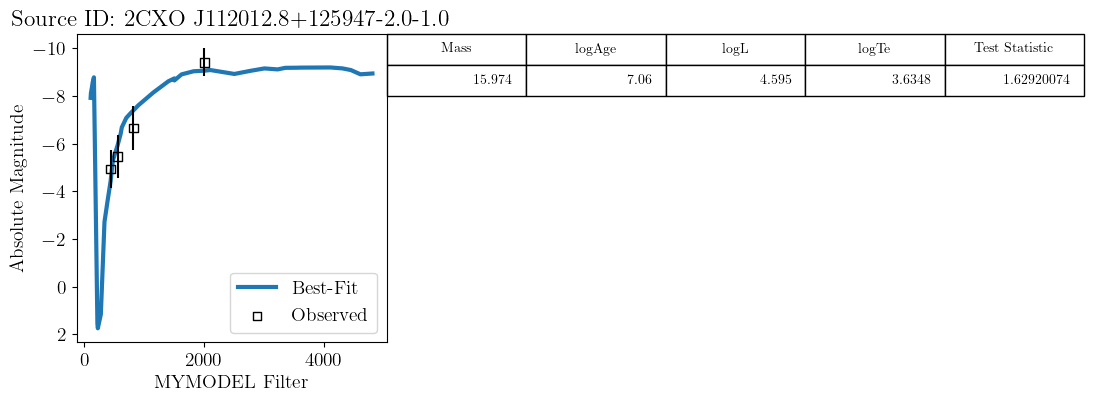

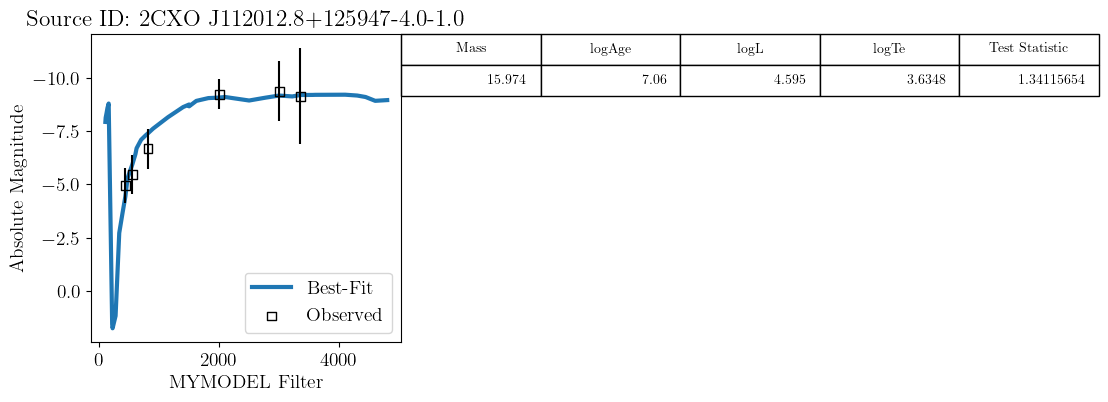

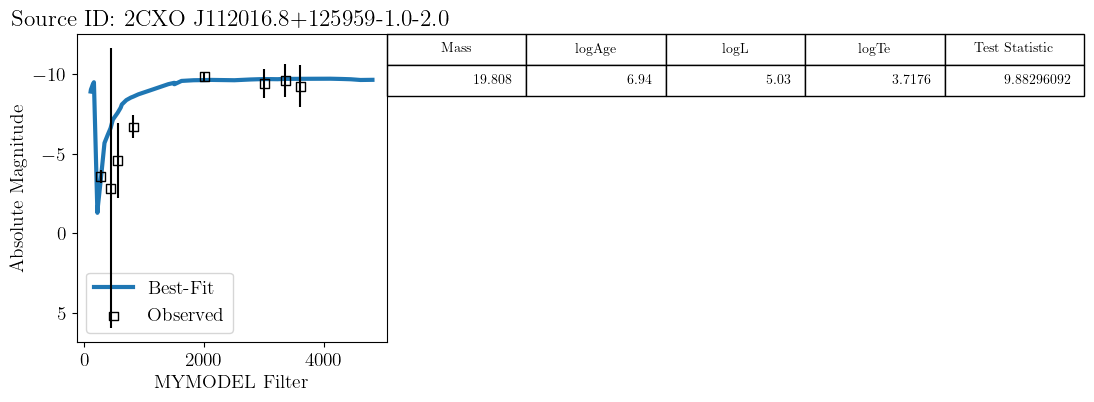

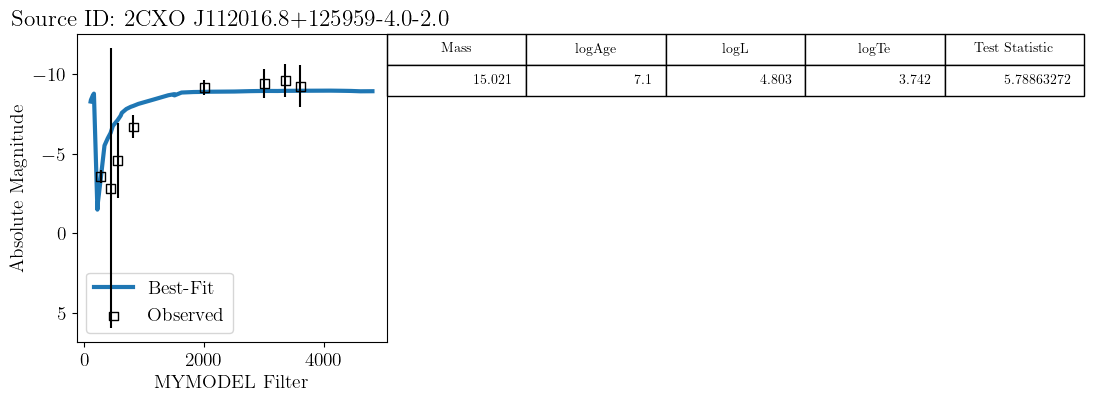

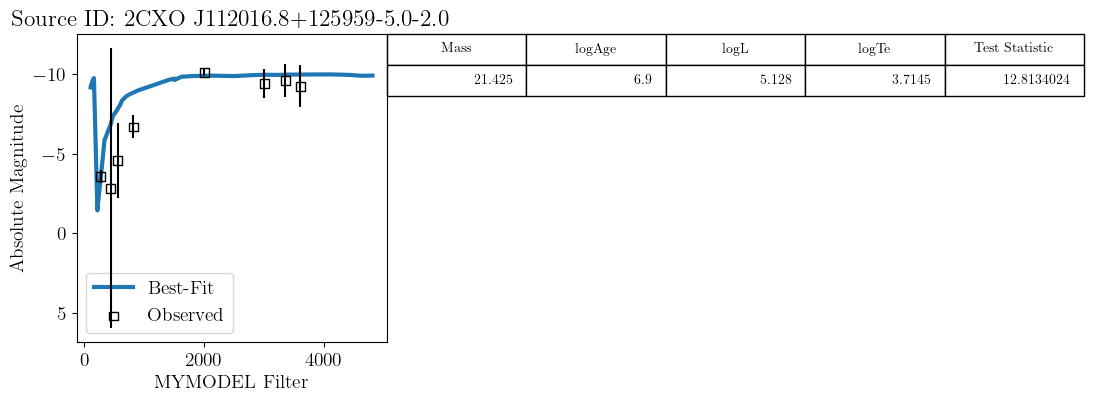

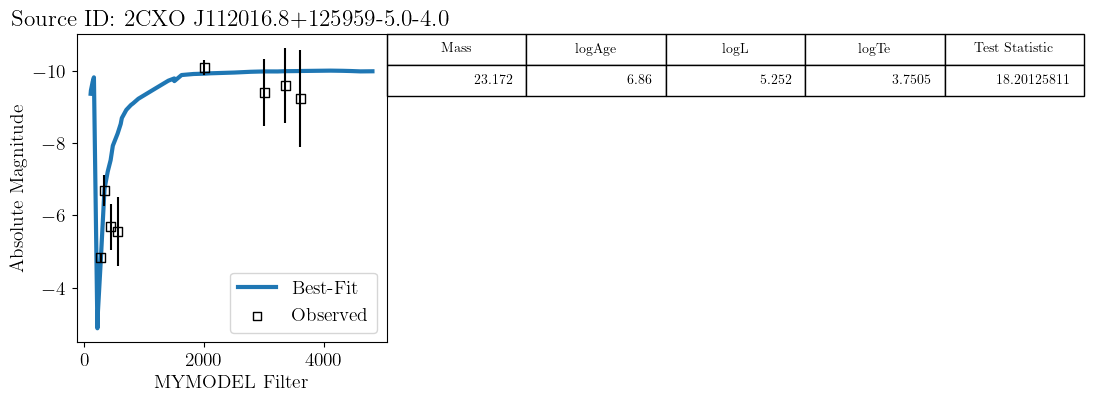

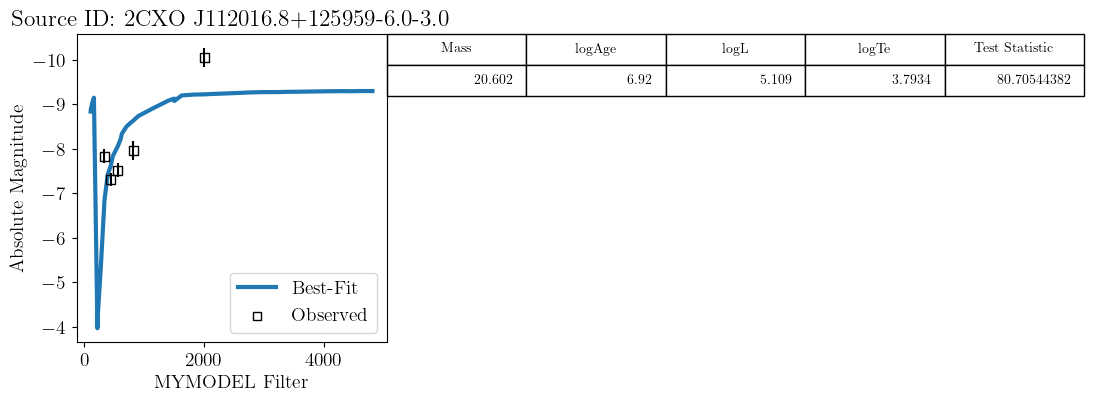

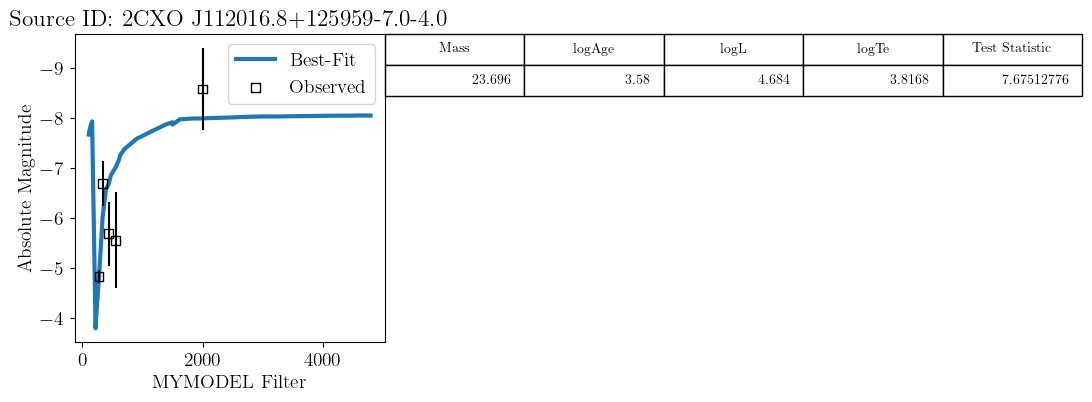

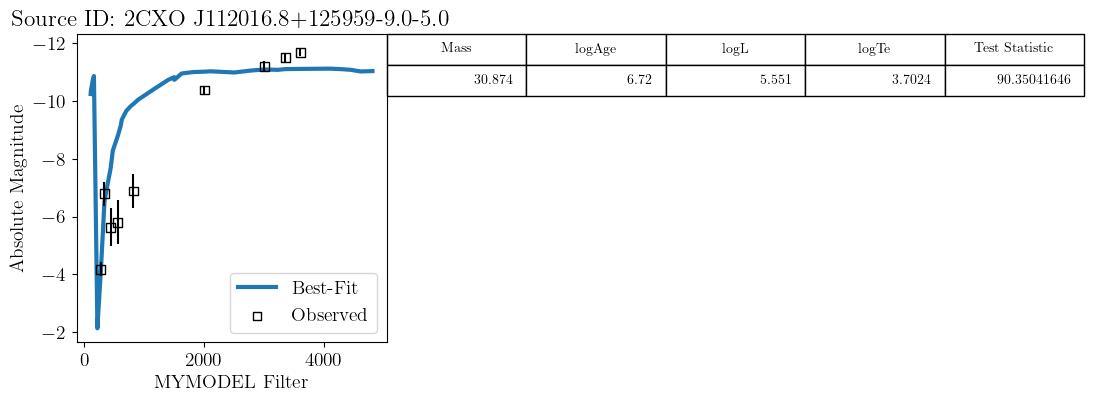

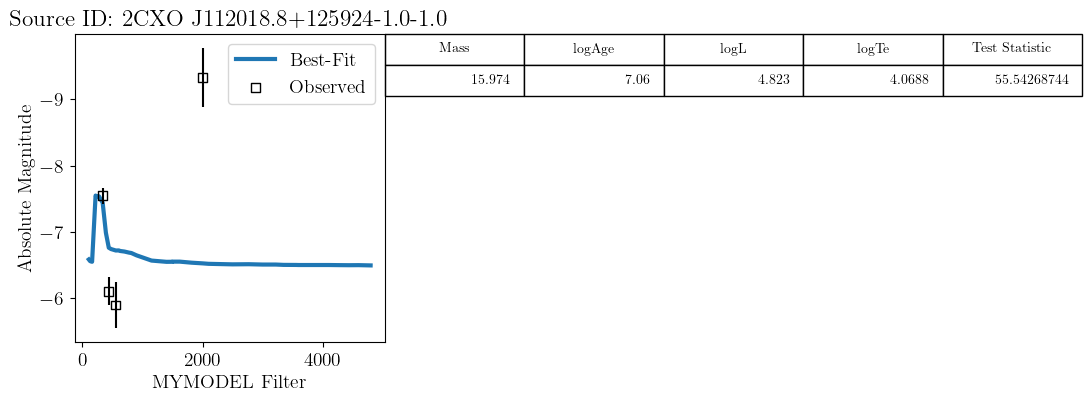

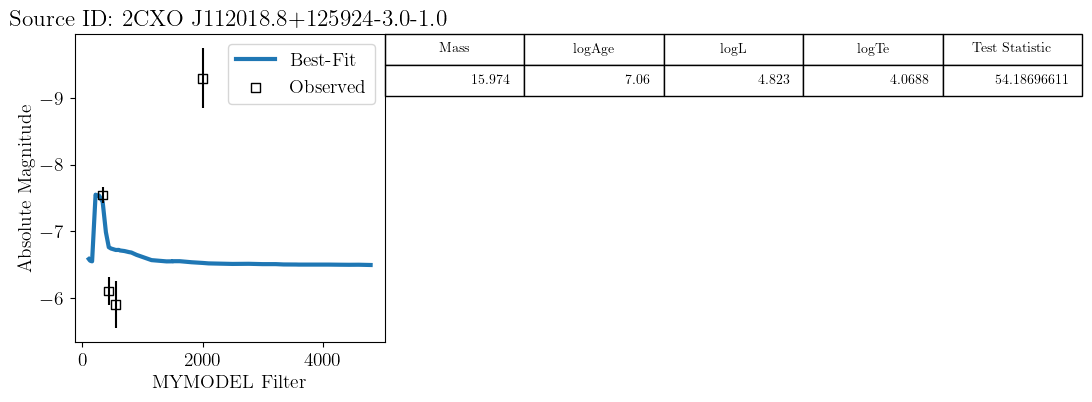

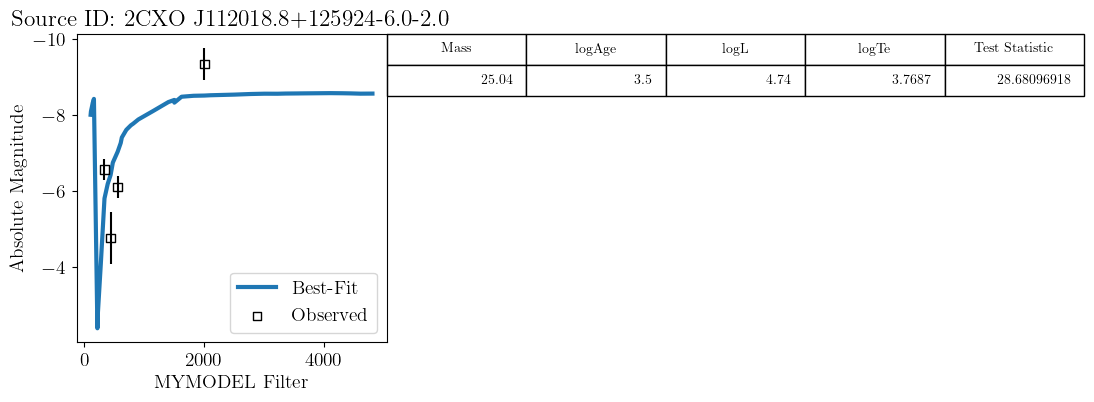

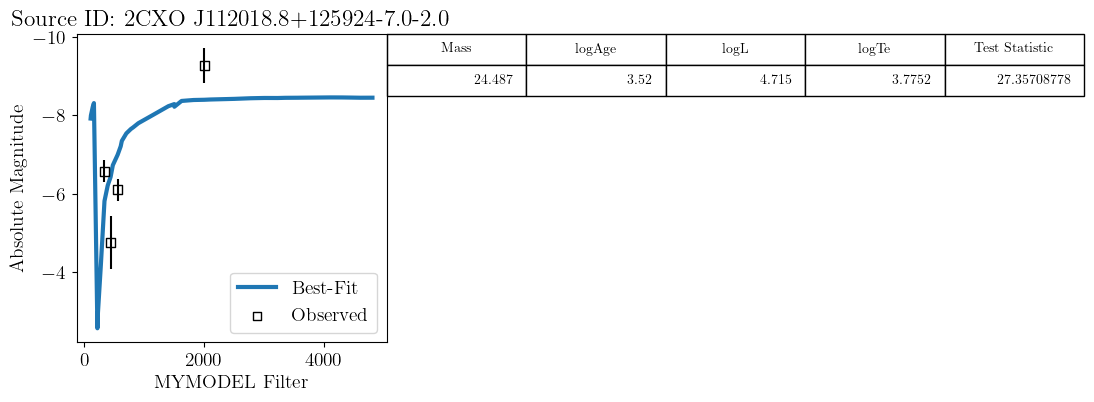

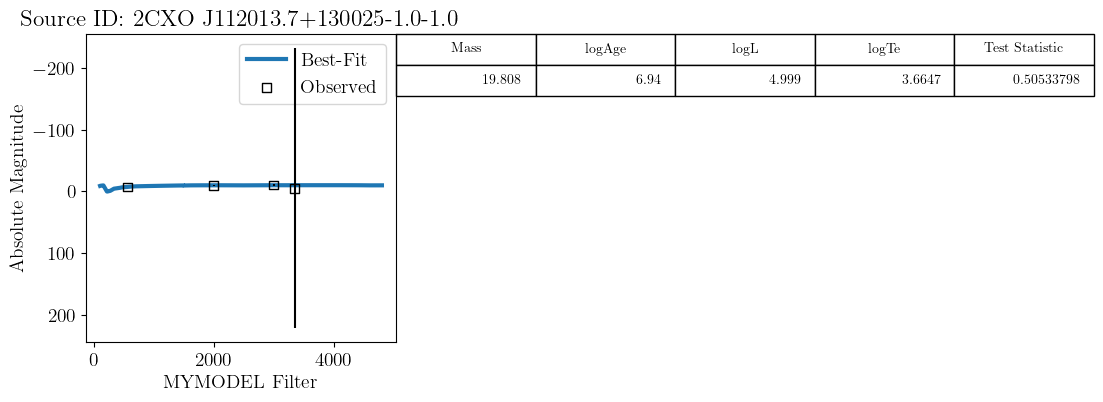

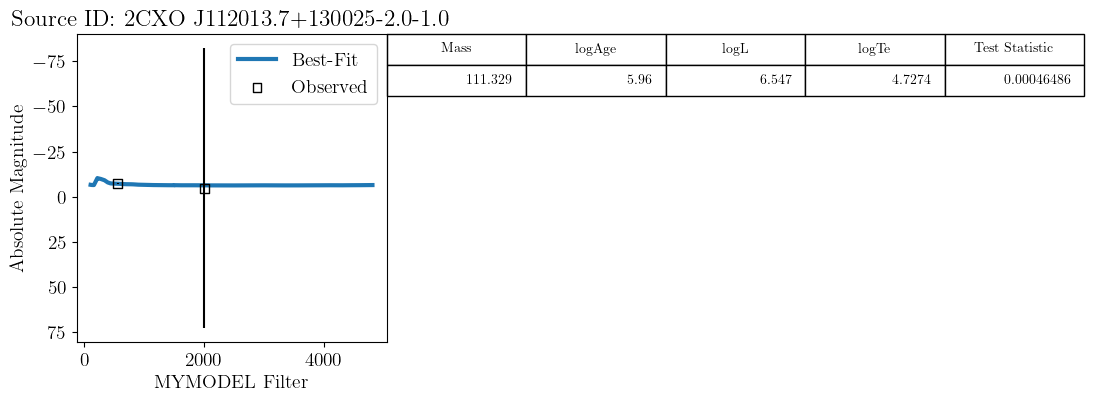

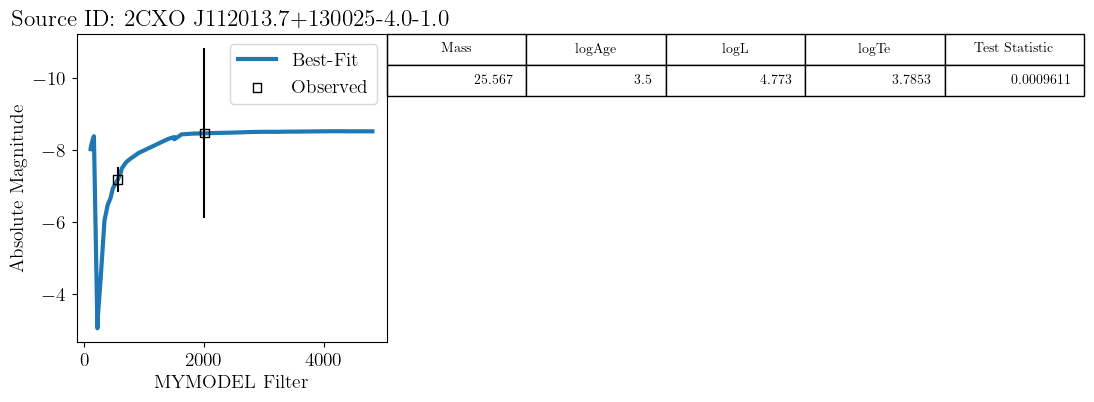

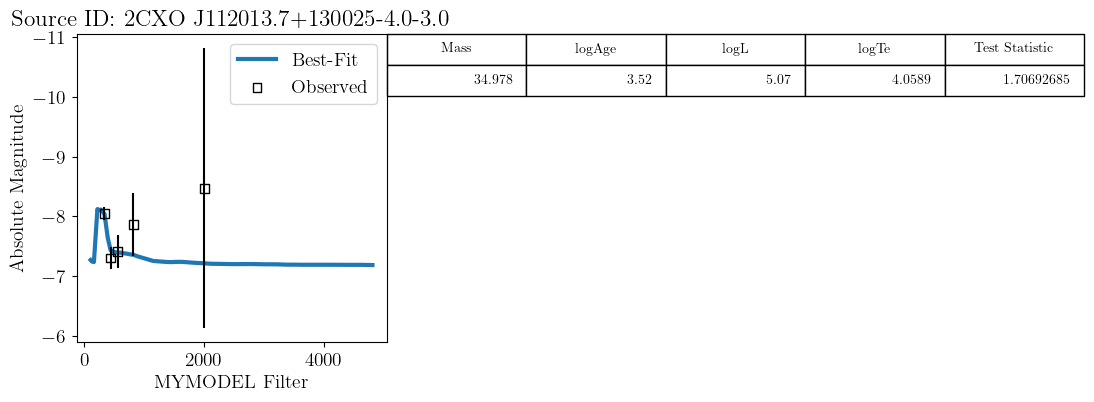

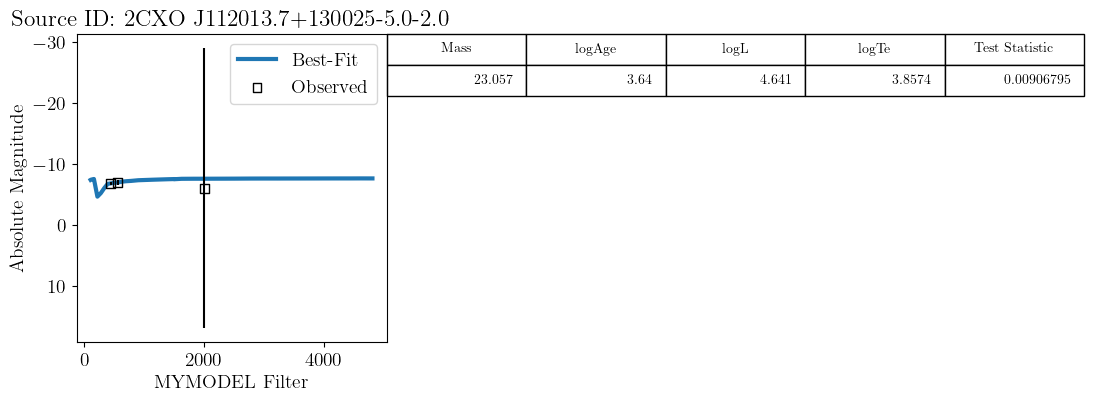

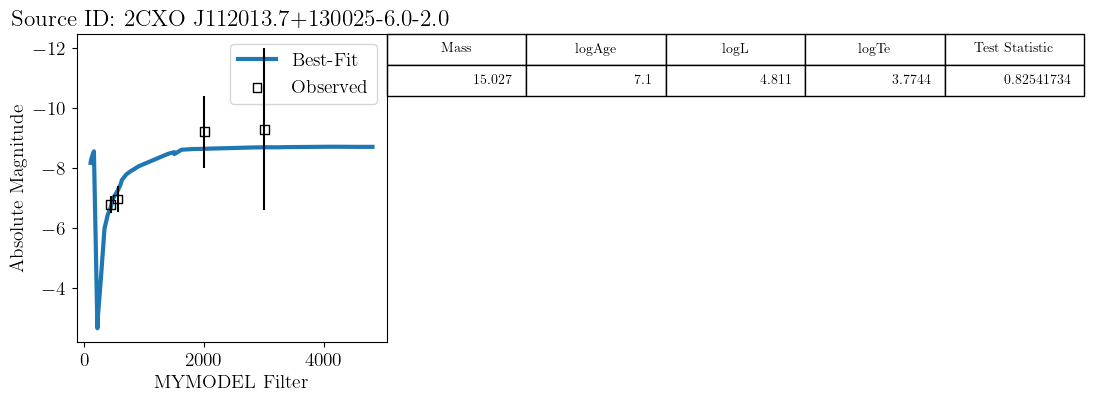

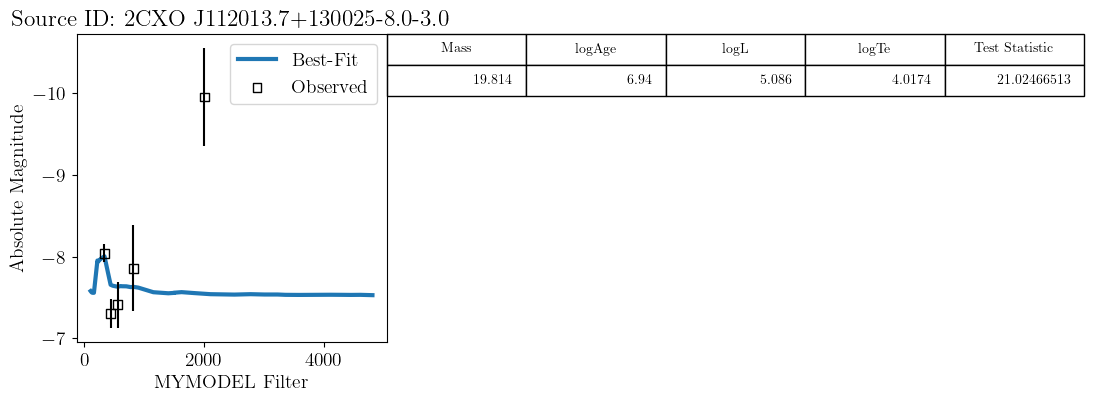

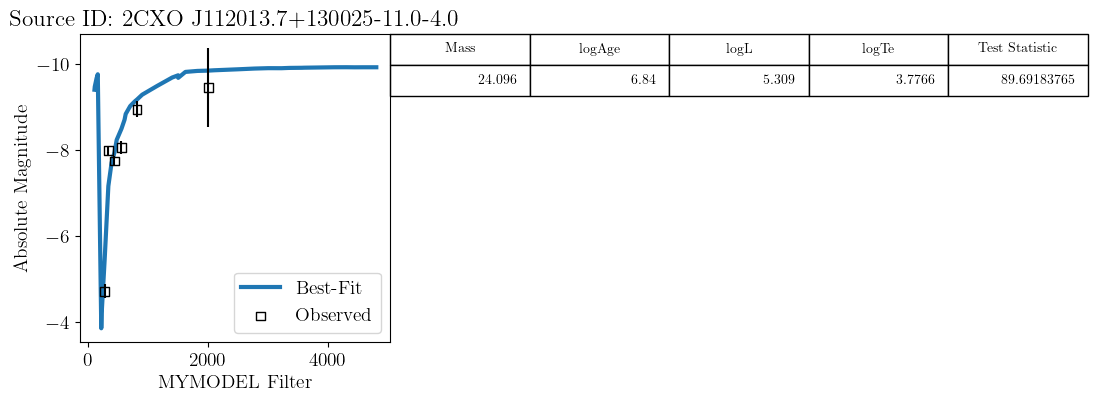

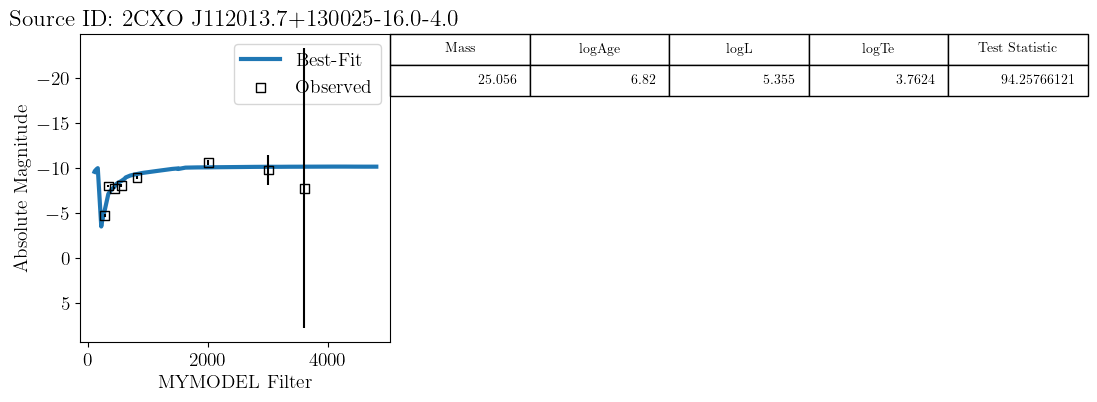

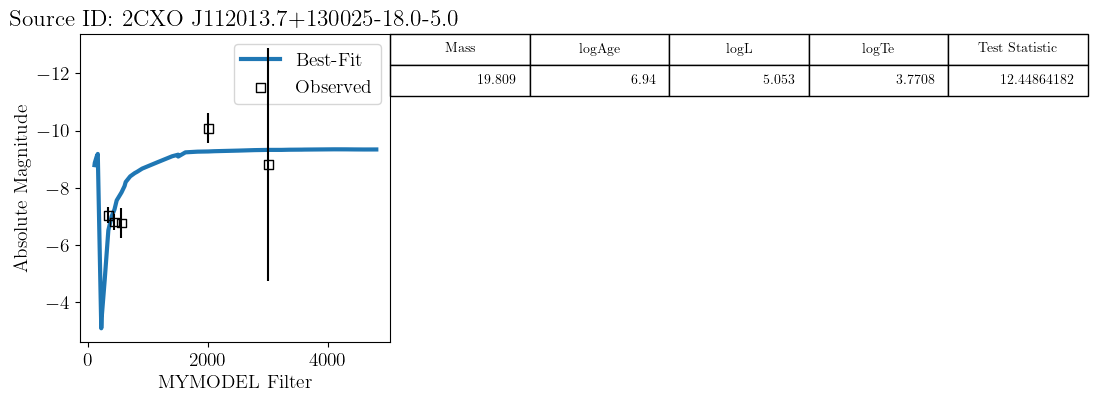

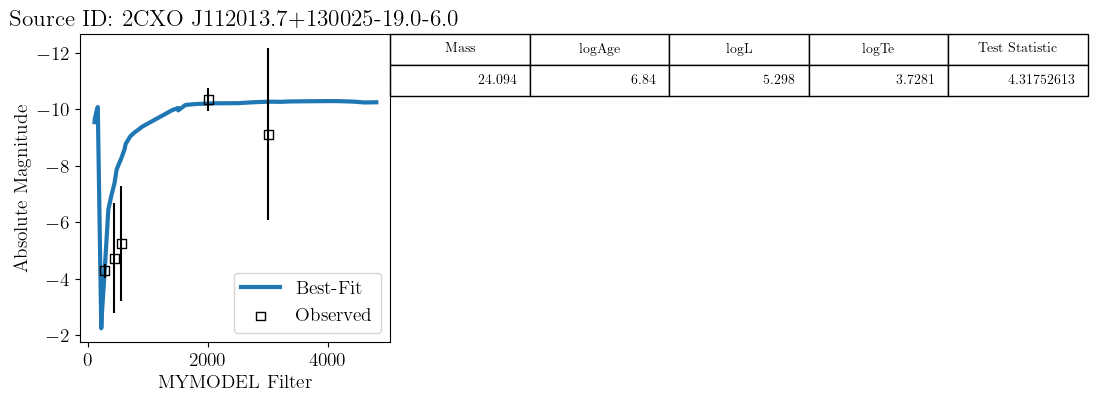

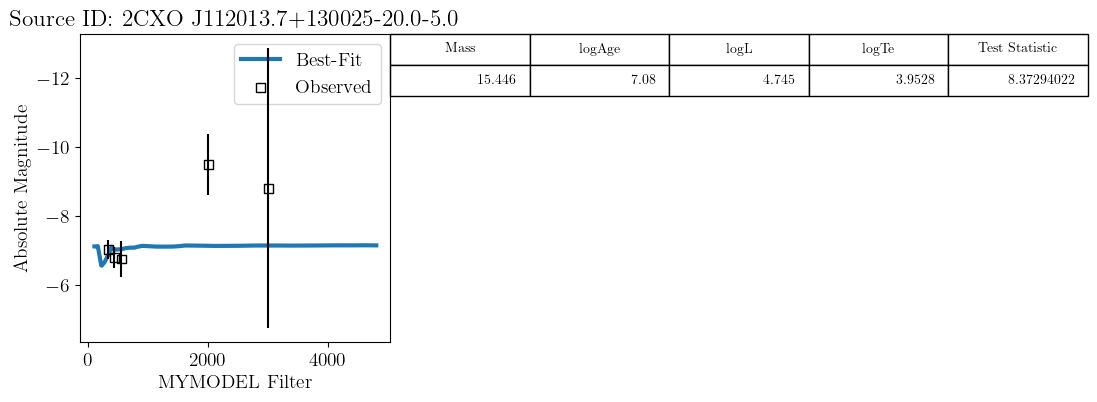

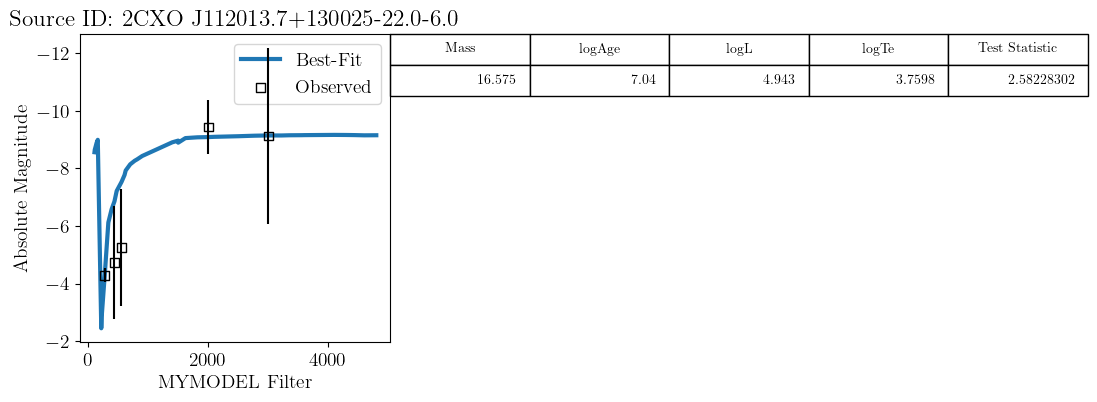

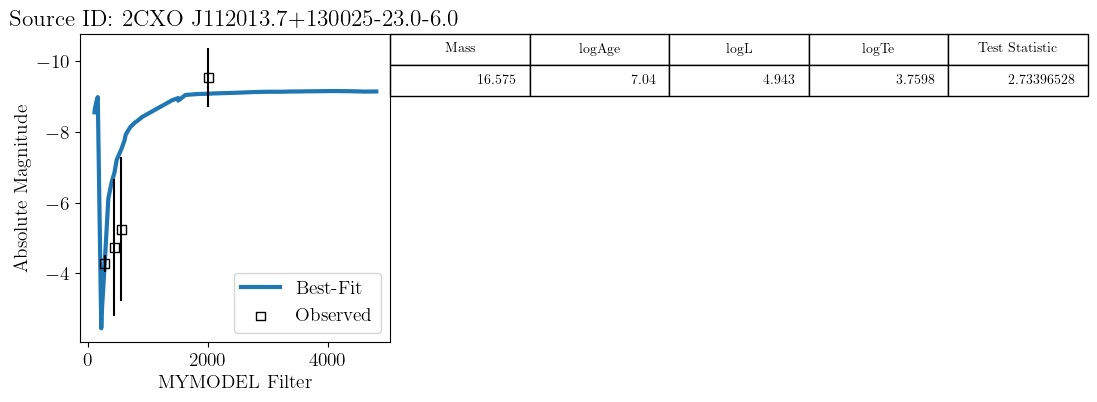

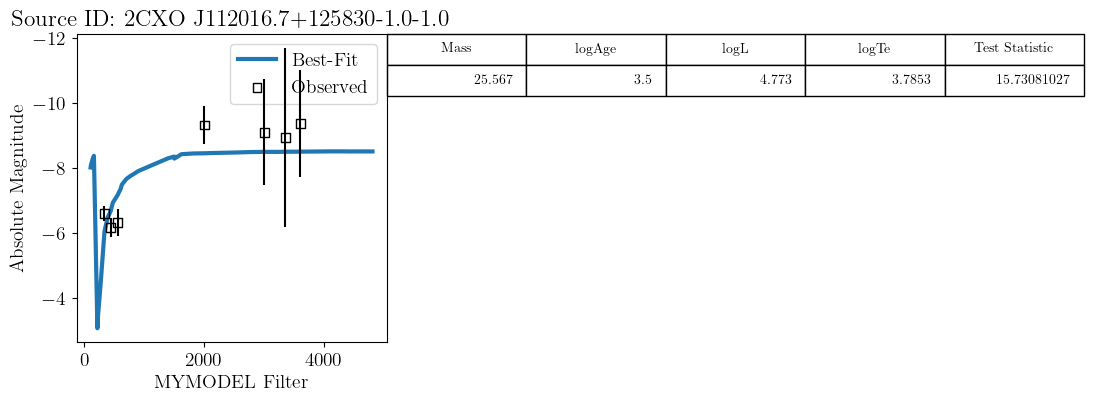

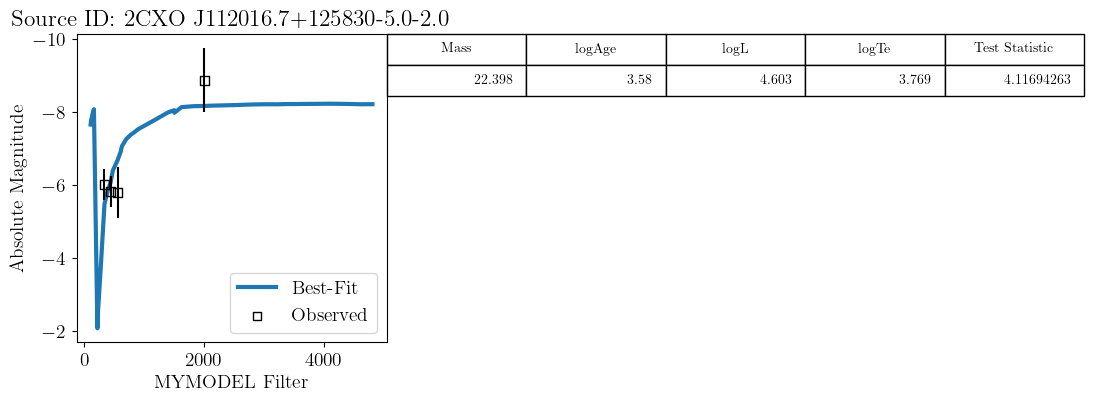

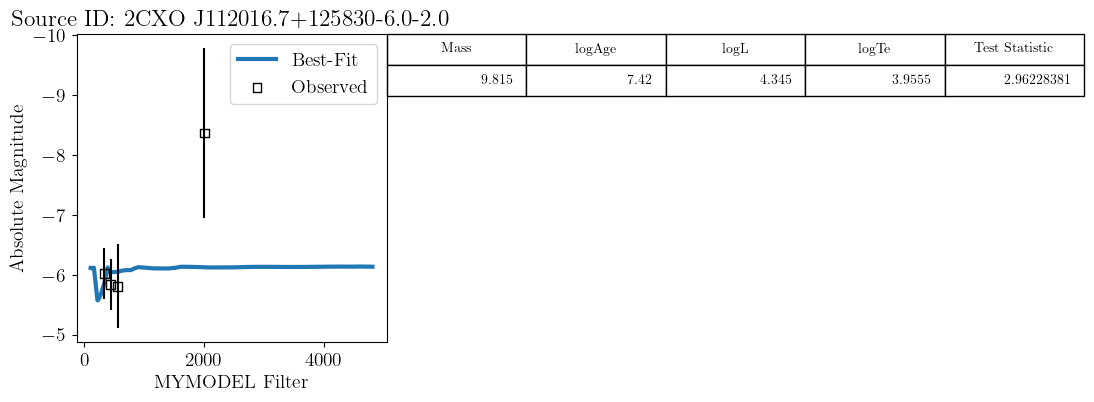

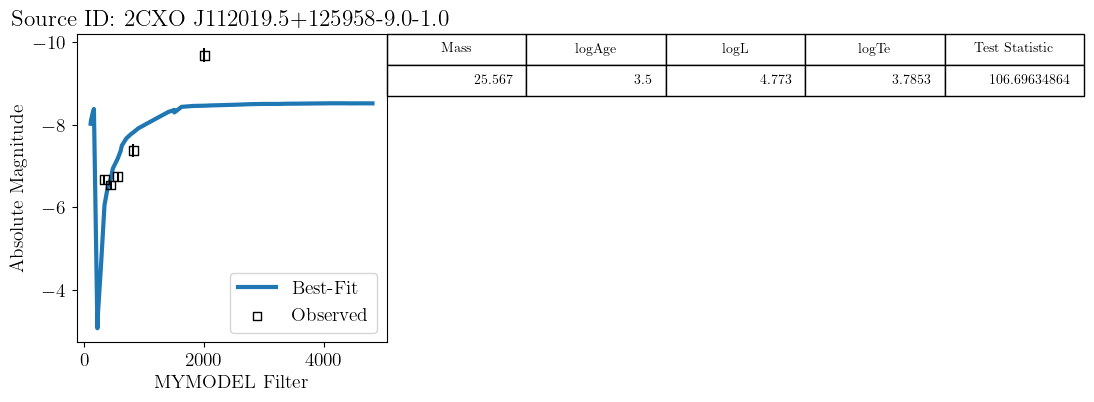

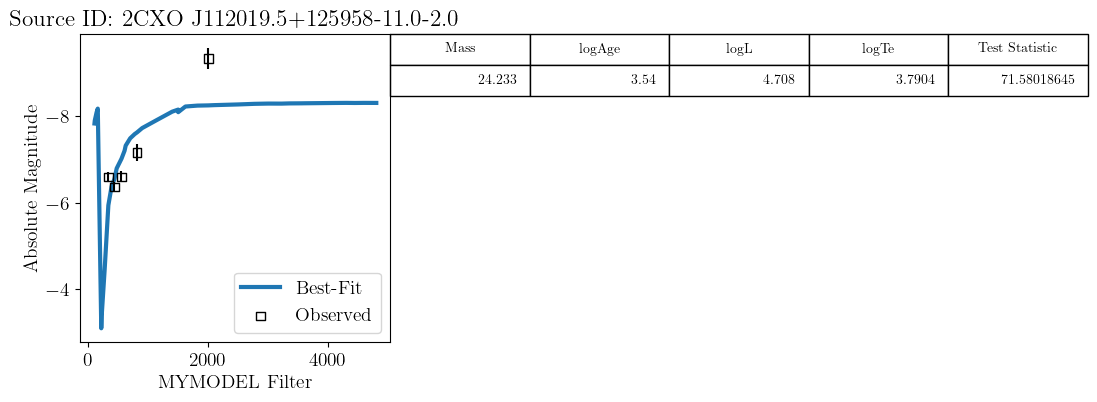

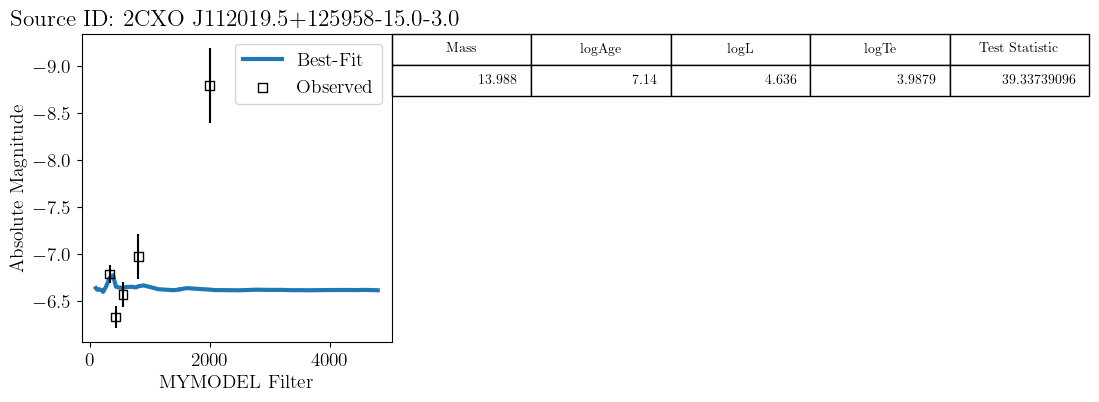

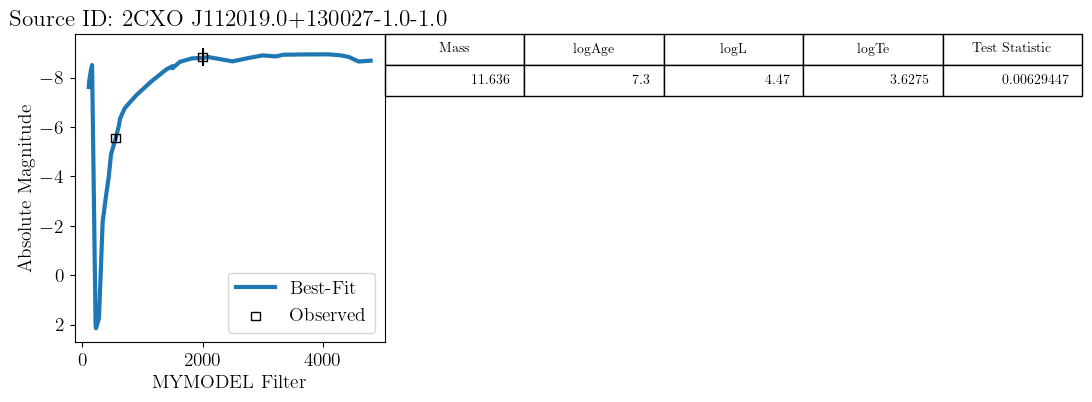

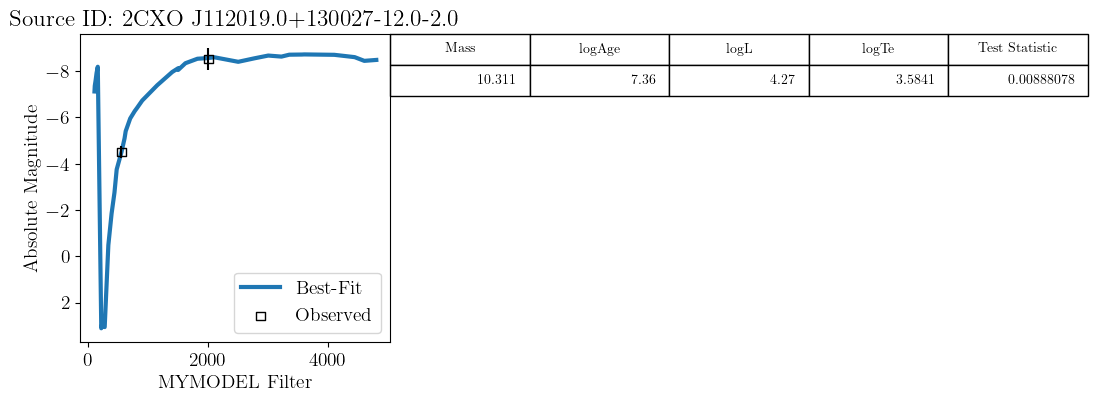

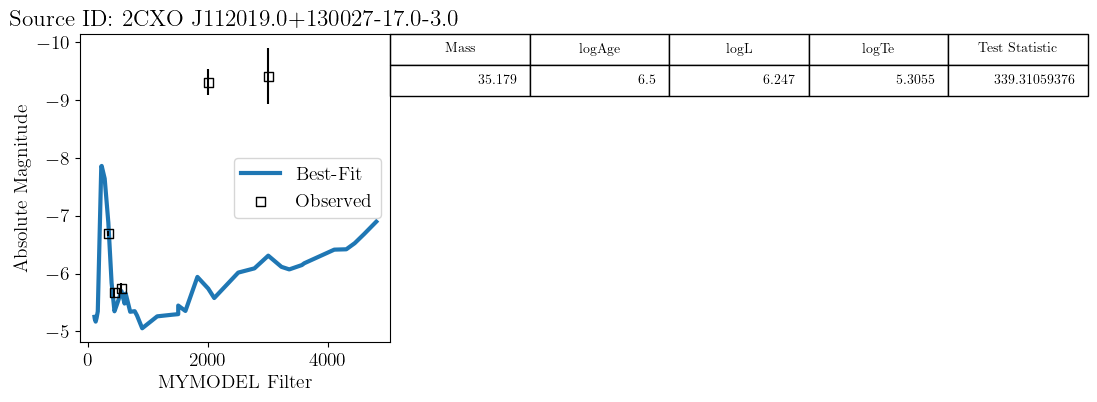

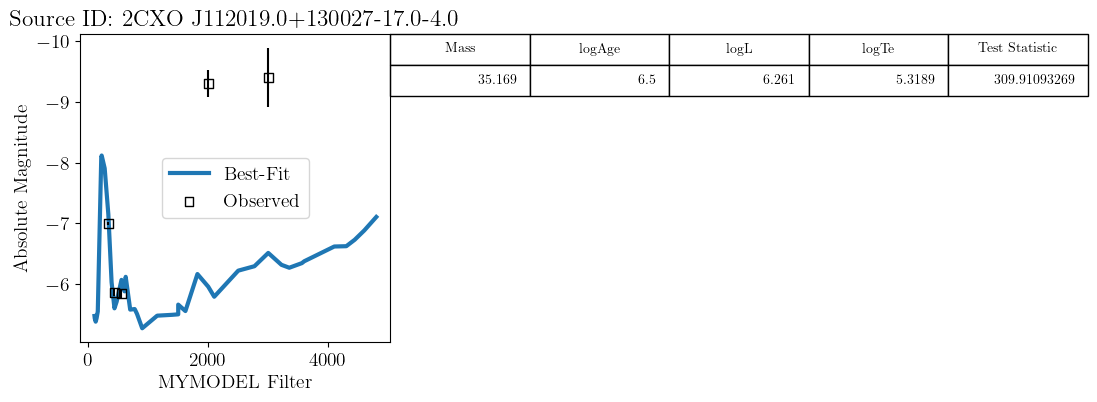

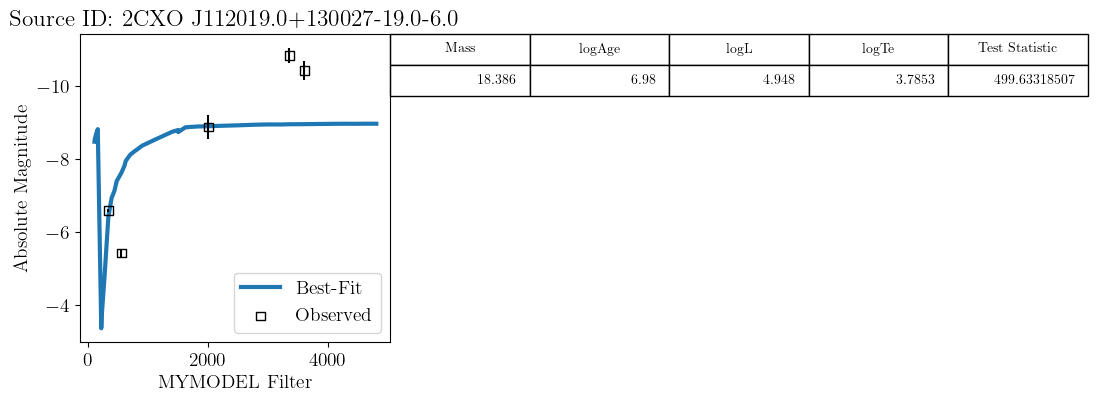

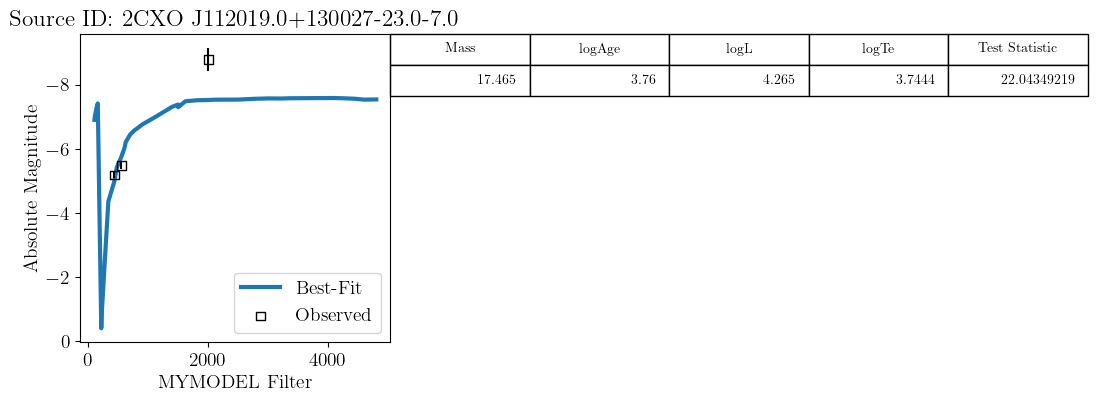

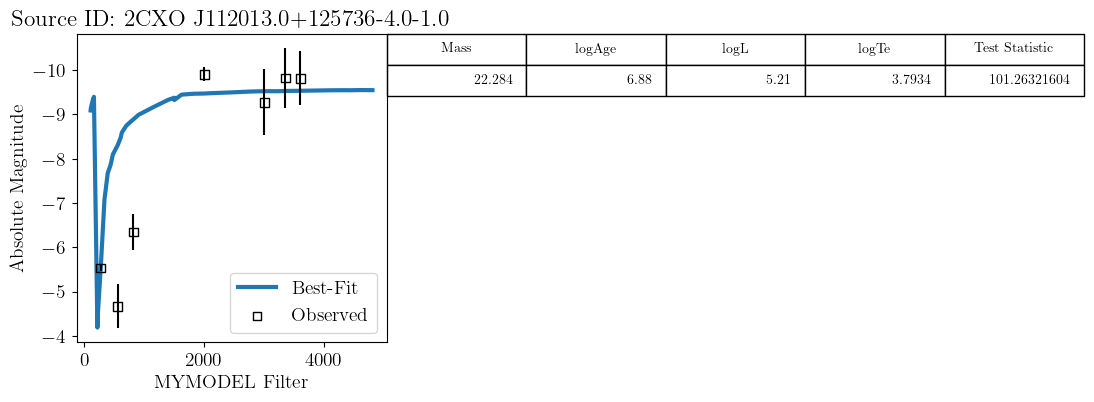

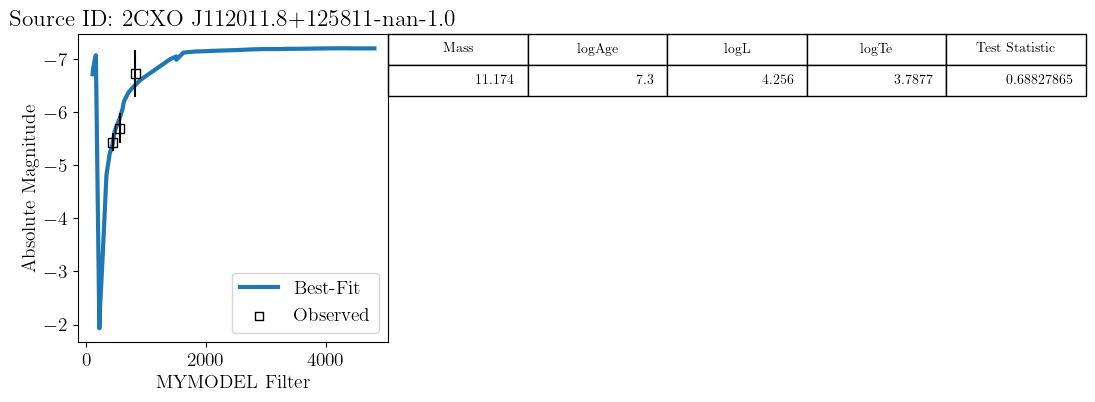

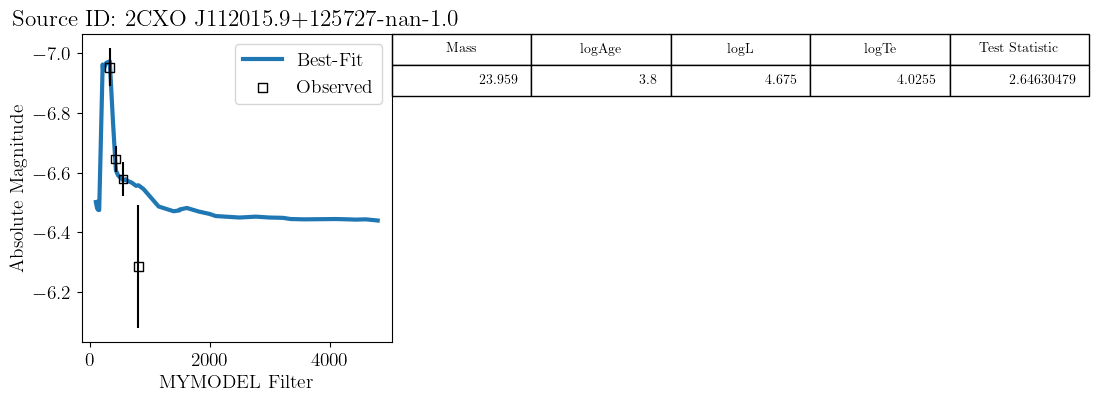

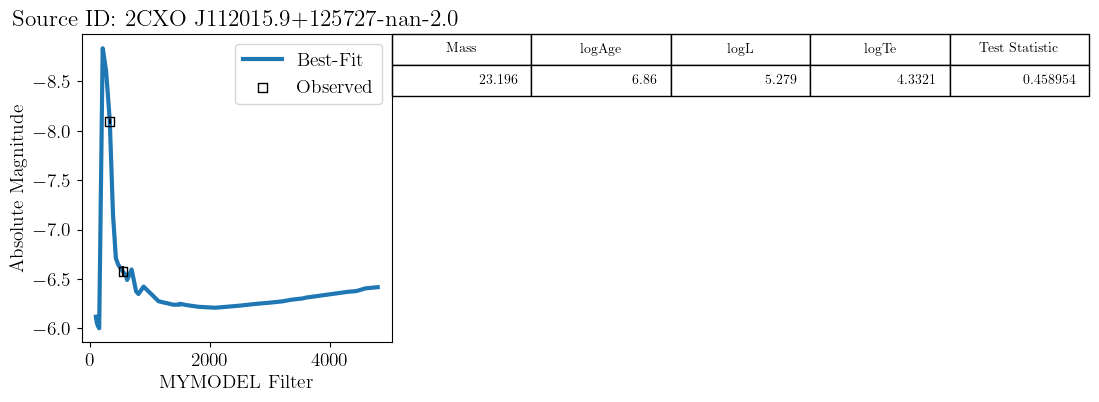

No best-fit model available for Source ID 2CXO J112015.3+125932-1.0-nan.
No best-fit model available for Source ID 2CXO J112015.3+125932-2.0-nan.
No best-fit model available for Source ID 2CXO J112015.3+125932-3.0-nan.
No best-fit model available for Source ID 2CXO J112015.3+125932-4.0-nan.
No best-fit model available for Source ID 2CXO J112015.3+125932-5.0-nan.
No best-fit model available for Source ID 2CXO J112015.3+125932-6.0-nan.
No best-fit model available for Source ID 2CXO J112015.3+125932-7.0-nan.
No best-fit model available for Source ID 2CXO J112015.3+125932-8.0-nan.
No best-fit model available for Source ID 2CXO J112015.3+125932-9.0-nan.


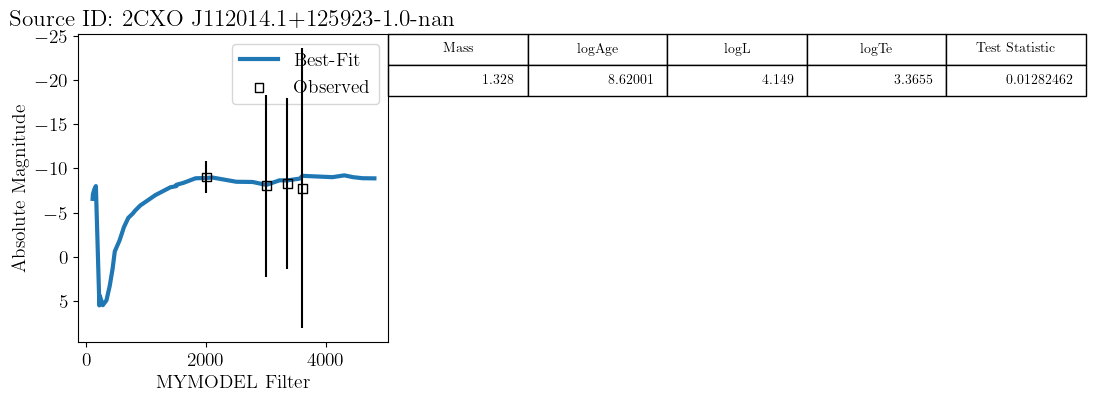

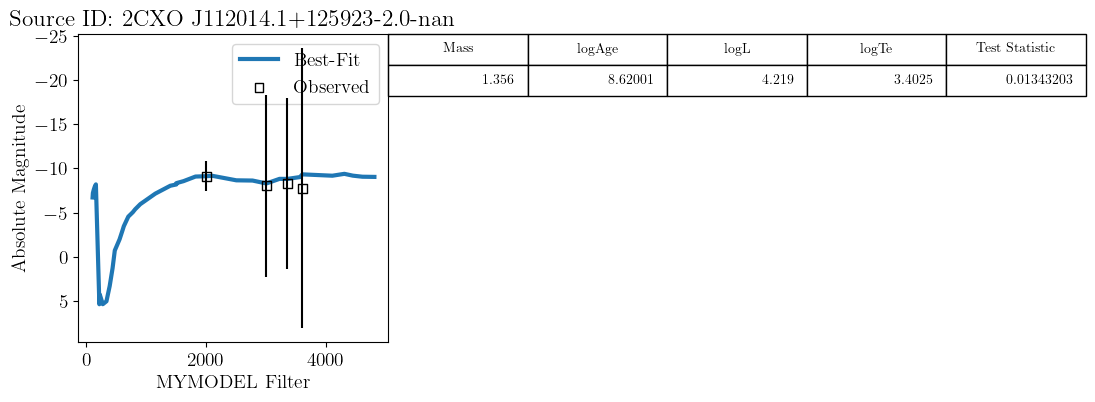

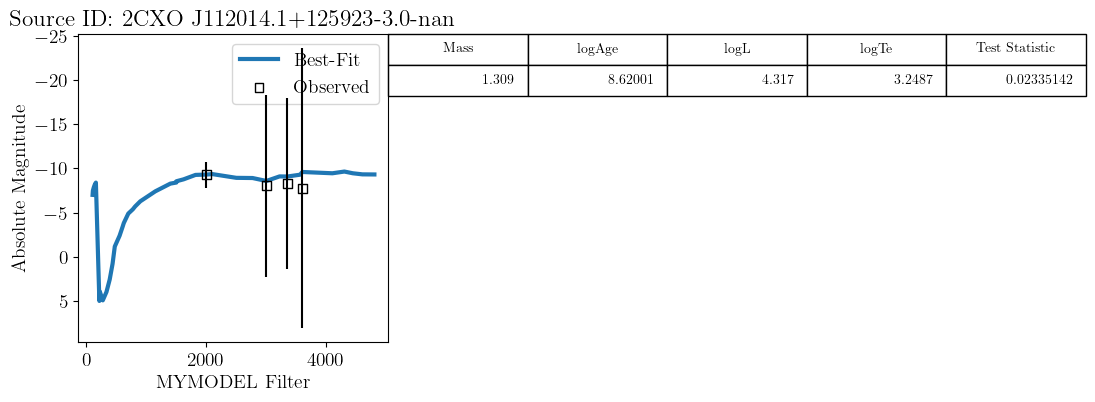

No best-fit model available for Source ID 2CXO J112014.1+125923-4.0-nan.
No best-fit model available for Source ID 2CXO J112014.1+125923-5.0-nan.
No best-fit model available for Source ID 2CXO J112014.1+125923-6.0-nan.
No best-fit model available for Source ID 2CXO J112014.1+125923-7.0-nan.
No best-fit model available for Source ID 2CXO J112014.1+125923-8.0-nan.


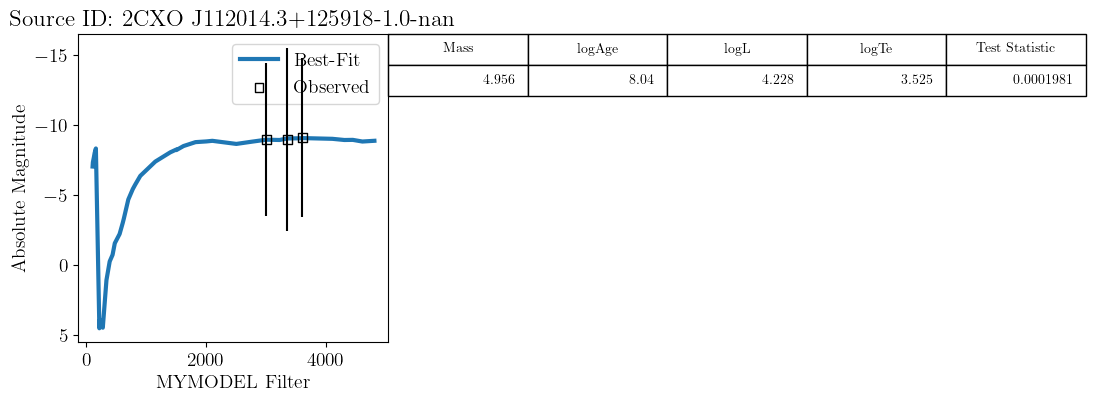

No best-fit model available for Source ID 2CXO J112014.3+125918-2.0-nan.
No best-fit model available for Source ID 2CXO J112014.3+125918-3.0-nan.


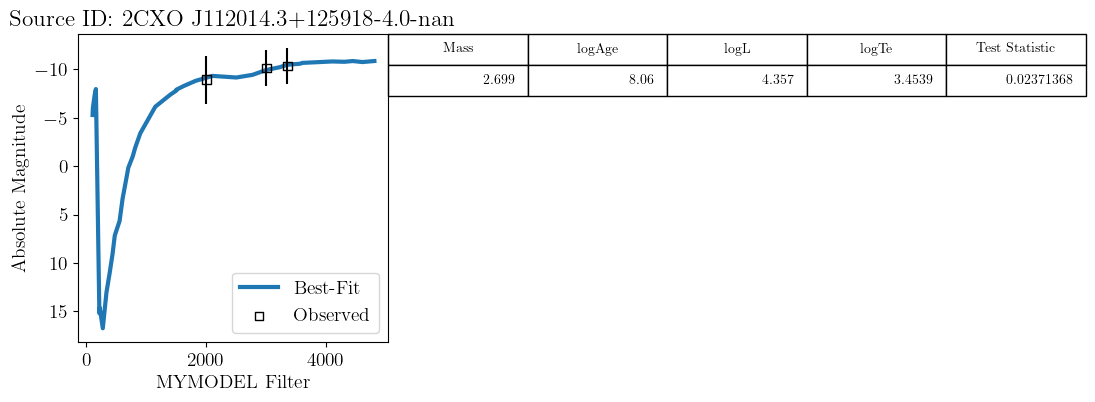

No best-fit model available for Source ID 2CXO J112014.3+125918-5.0-nan.
No best-fit model available for Source ID 2CXO J112014.3+125918-6.0-nan.


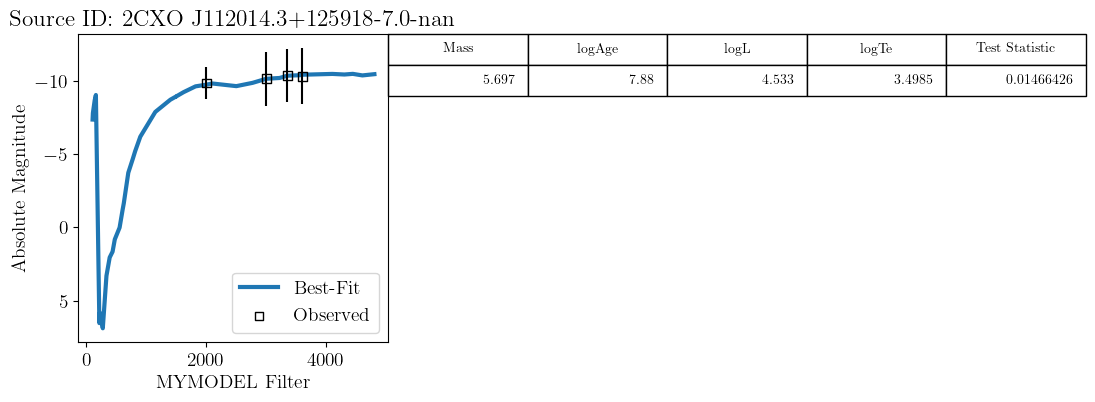

No best-fit model available for Source ID 2CXO J112014.3+125918-8.0-nan.


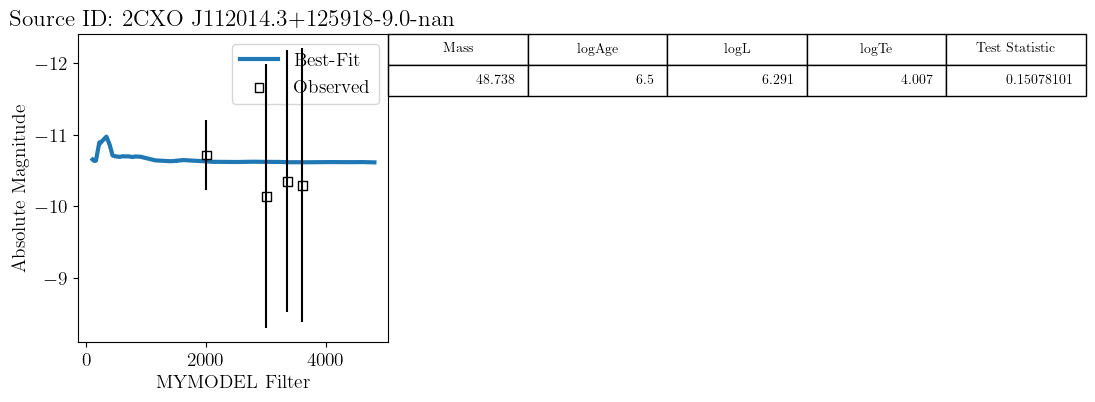

No best-fit model available for Source ID 2CXO J112014.3+125918-10.0-nan.
No best-fit model available for Source ID 2CXO J112014.5+125946-1.0-nan.
No best-fit model available for Source ID 2CXO J112014.5+125946-2.0-nan.
No best-fit model available for Source ID 2CXO J112014.5+125946-3.0-nan.
No best-fit model available for Source ID 2CXO J112014.5+125946-4.0-nan.
No best-fit model available for Source ID 2CXO J112014.5+125946-5.0-nan.
No best-fit model available for Source ID 2CXO J112014.5+125946-6.0-nan.
No best-fit model available for Source ID 2CXO J112014.5+125946-7.0-nan.


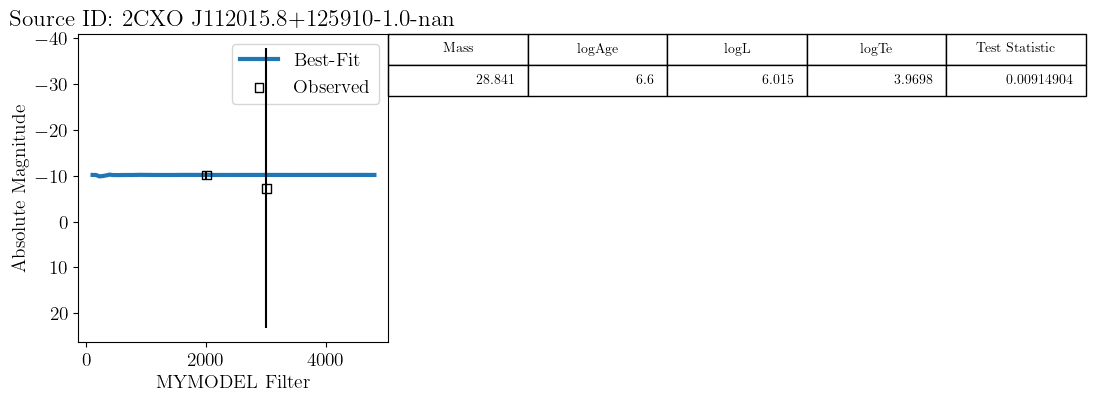

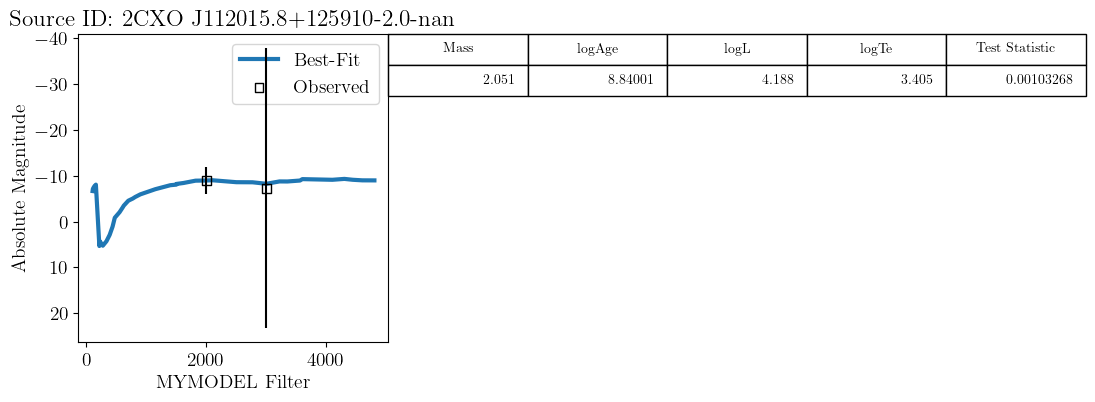

No best-fit model available for Source ID 2CXO J112015.8+125910-3.0-nan.
No best-fit model available for Source ID 2CXO J112015.8+125910-4.0-nan.
No best-fit model available for Source ID 2CXO J112015.8+125910-5.0-nan.


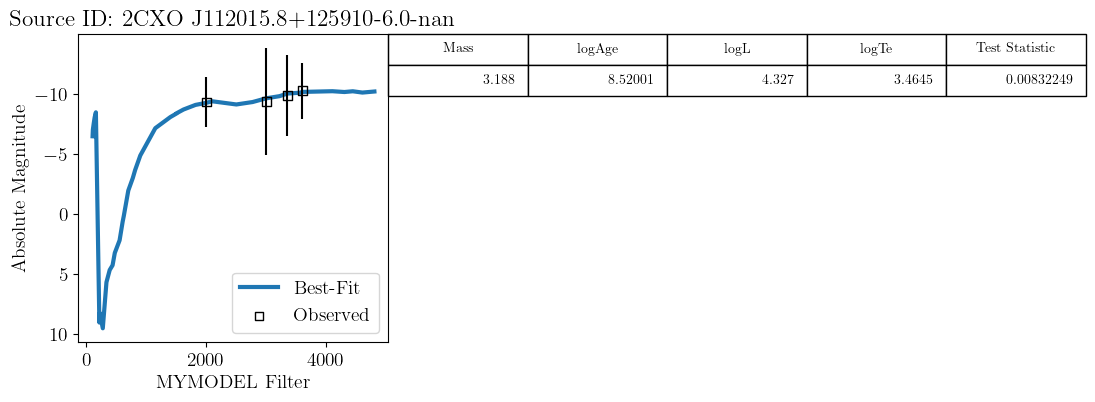

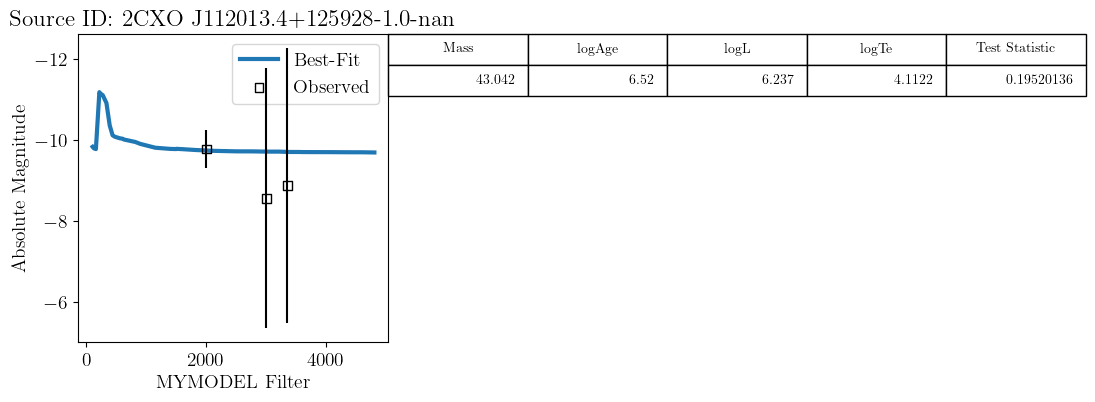

No best-fit model available for Source ID 2CXO J112013.4+125928-2.0-nan.
No best-fit model available for Source ID 2CXO J112013.4+125928-3.0-nan.


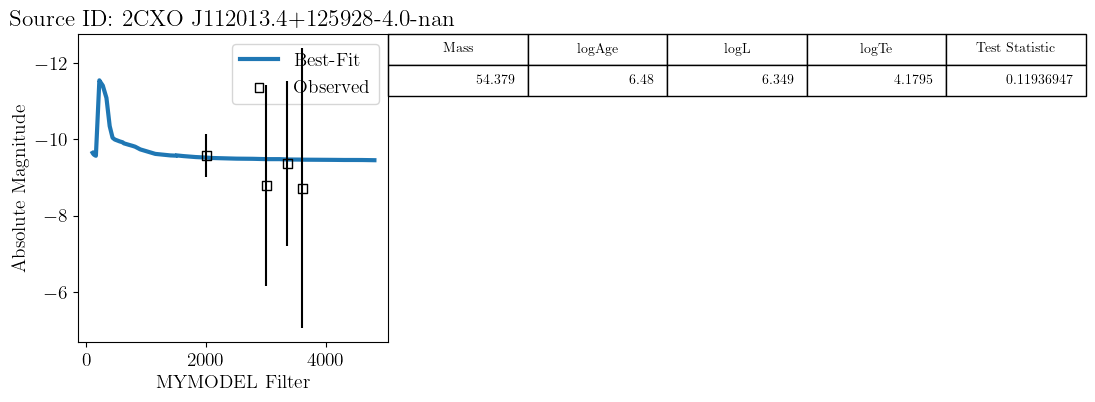

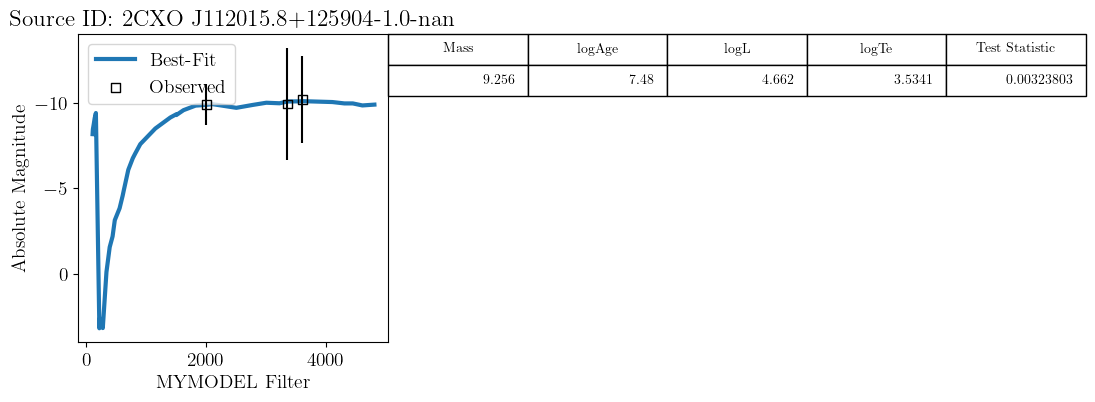

No best-fit model available for Source ID 2CXO J112015.8+125904-2.0-nan.
No best-fit model available for Source ID 2CXO J112015.8+125904-3.0-nan.


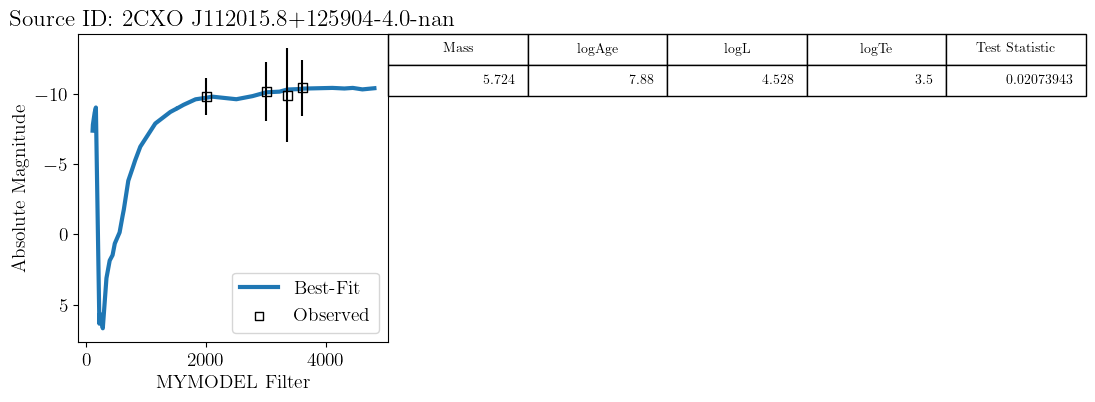

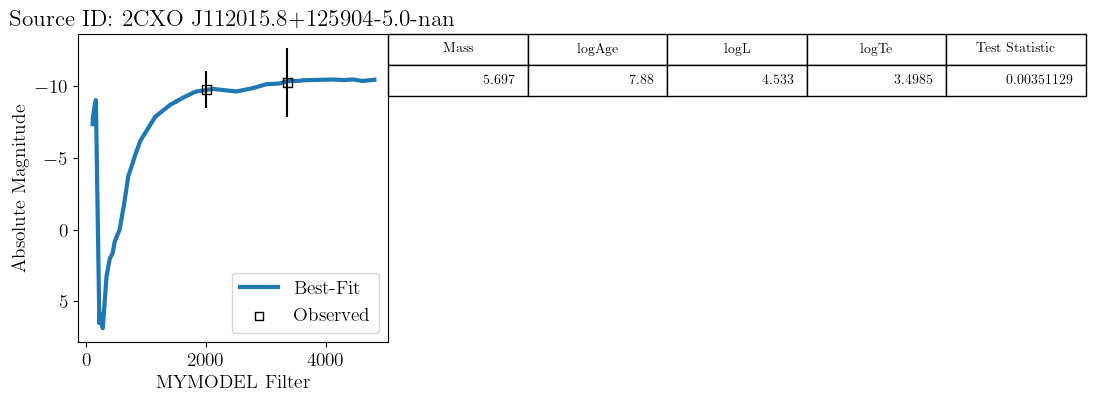

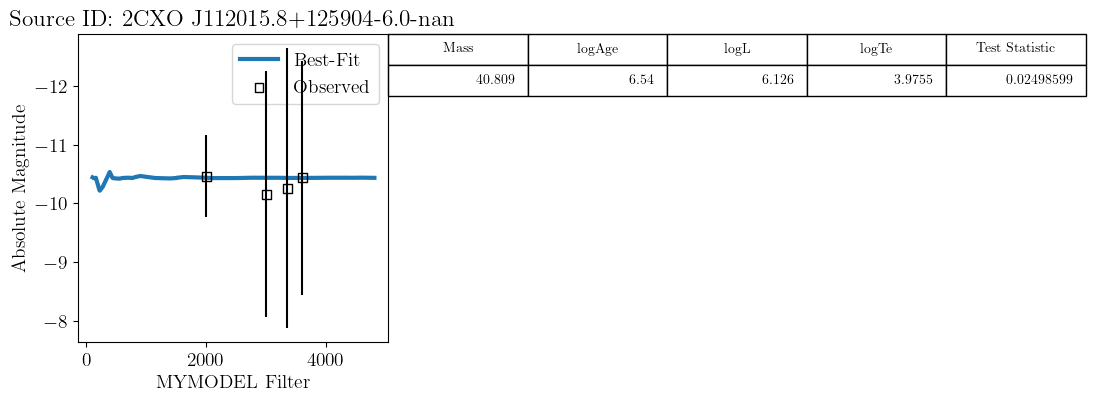

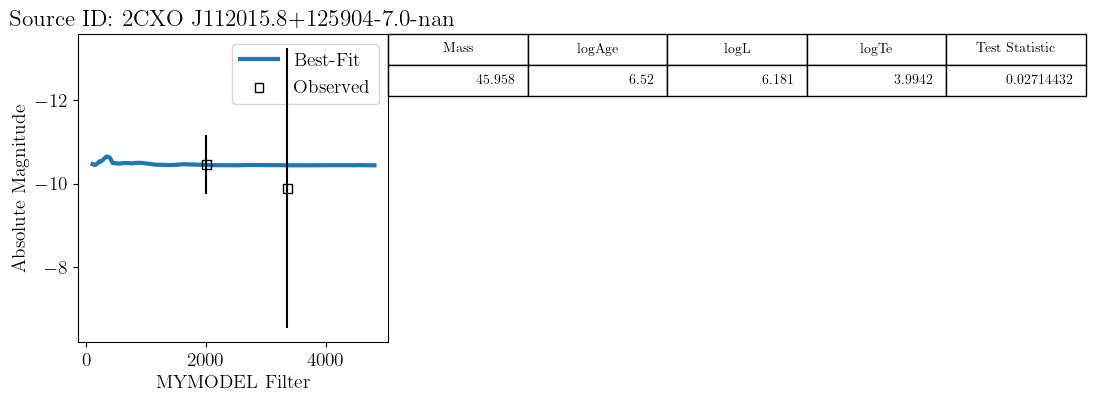

No best-fit model available for Source ID 2CXO J112015.8+125904-8.0-nan.
No best-fit model available for Source ID 2CXO J112015.8+125904-9.0-nan.
No best-fit model available for Source ID 2CXO J112015.8+125904-10.0-nan.


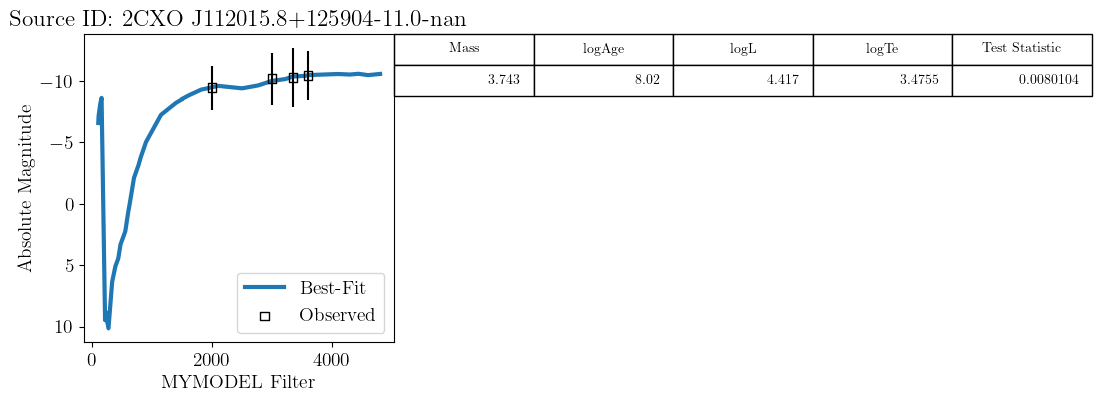

No best-fit model available for Source ID 2CXO J112015.8+125904-12.0-nan.
No best-fit model available for Source ID 2CXO J112015.8+125904-13.0-nan.
No best-fit model available for Source ID 2CXO J112015.8+125904-14.0-nan.
No best-fit model available for Source ID 2CXO J112015.8+125904-15.0-nan.


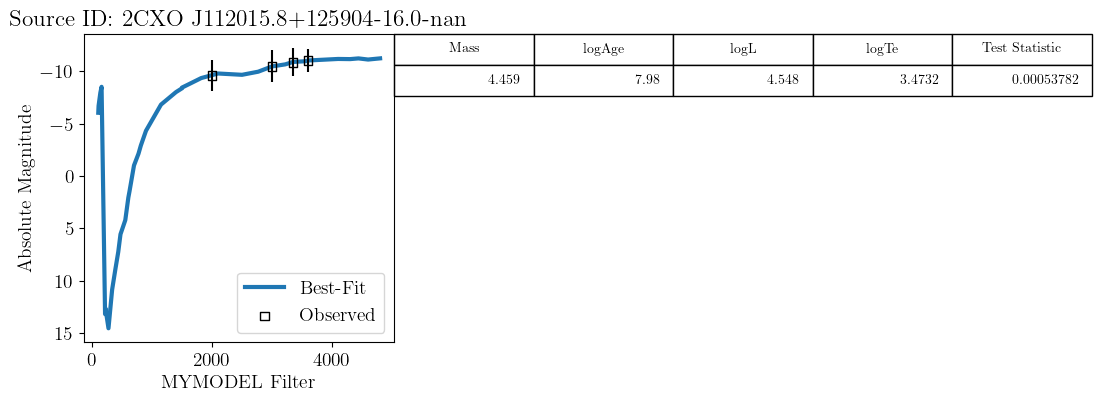

No best-fit model available for Source ID 2CXO J112015.8+125904-17.0-nan.
No best-fit model available for Source ID 2CXO J112015.8+125904-18.0-nan.


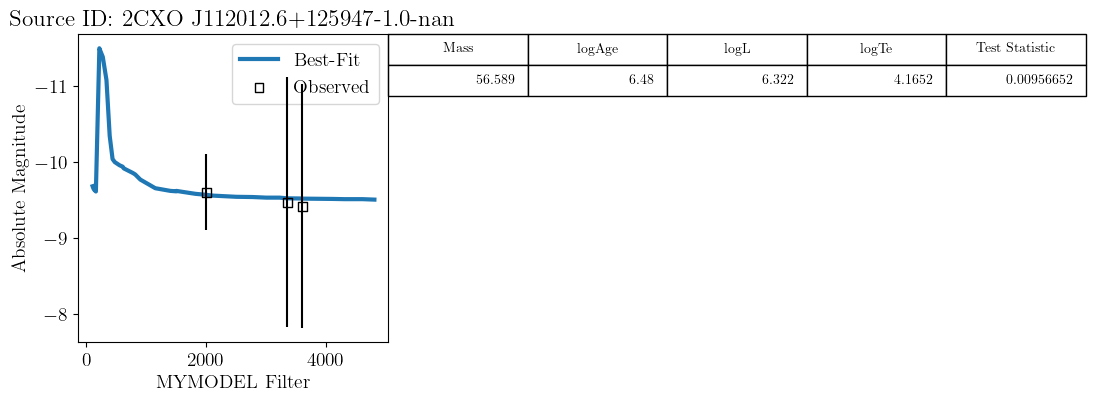

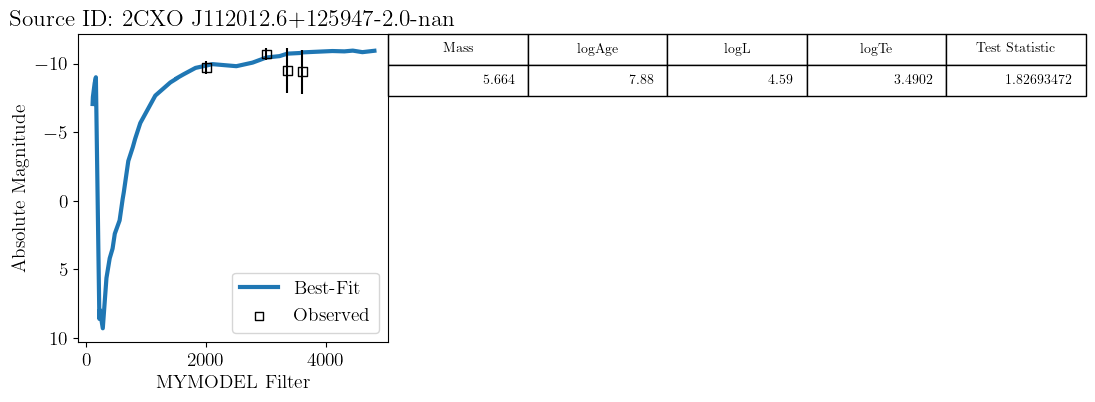

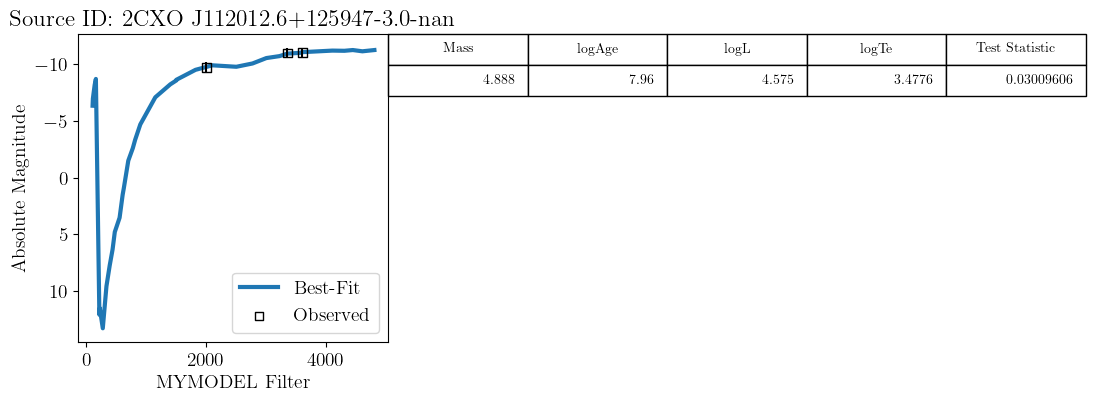

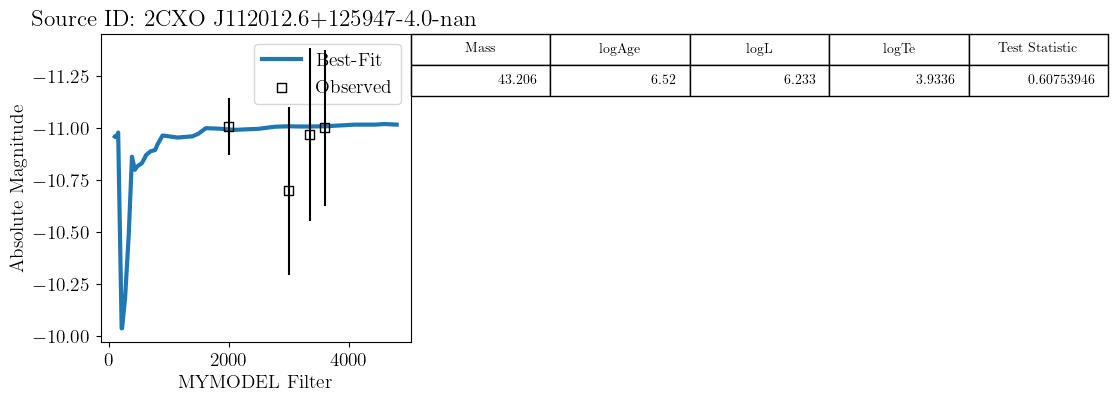

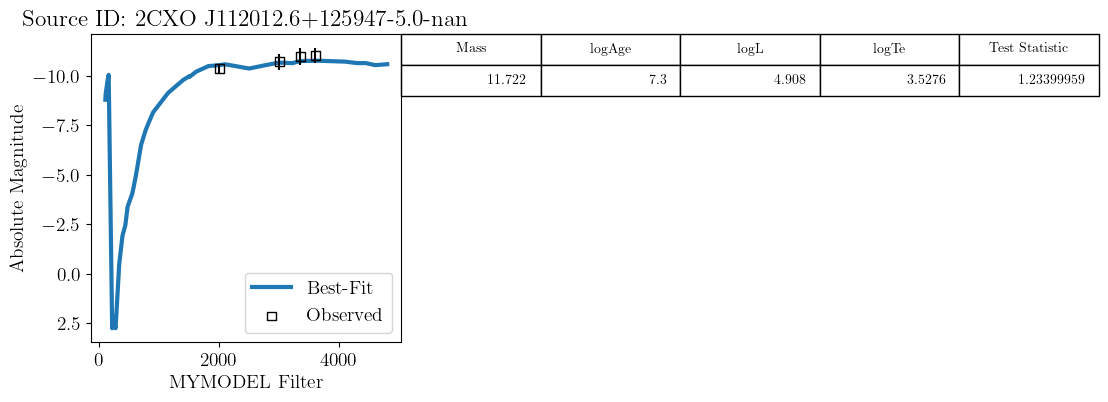

No best-fit model available for Source ID 2CXO J112012.6+125947-6.0-nan.


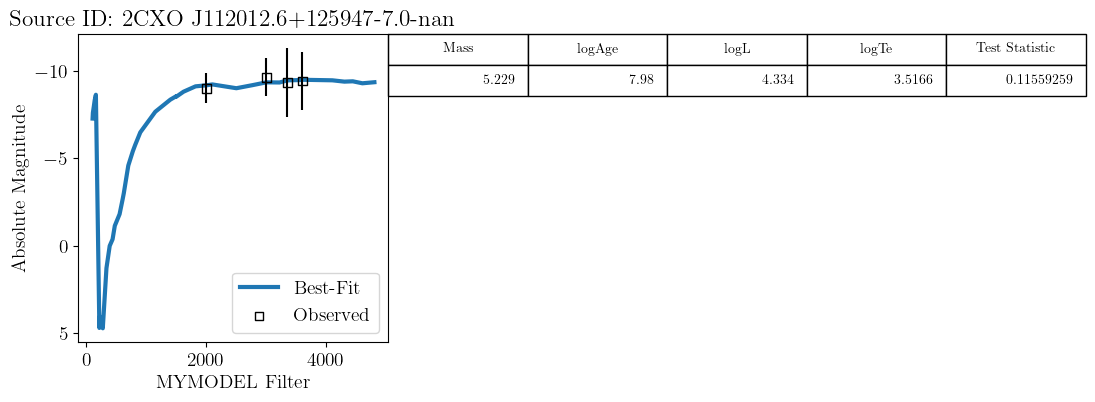

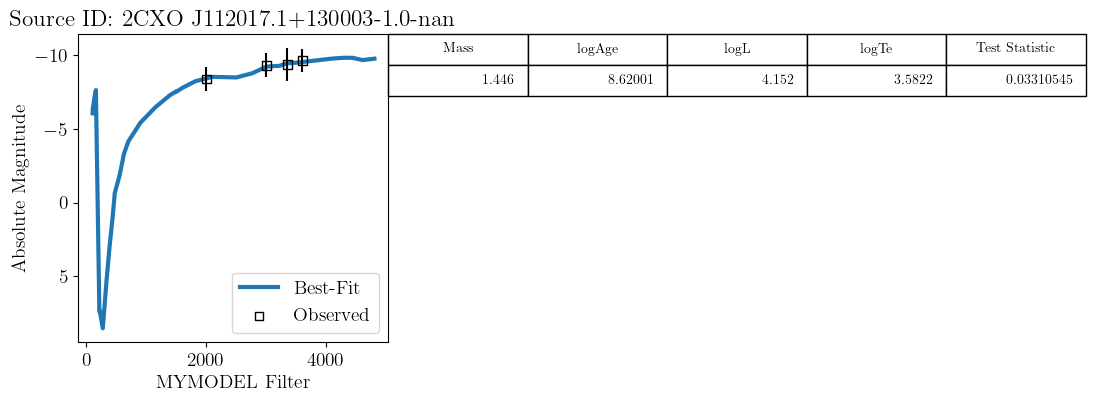

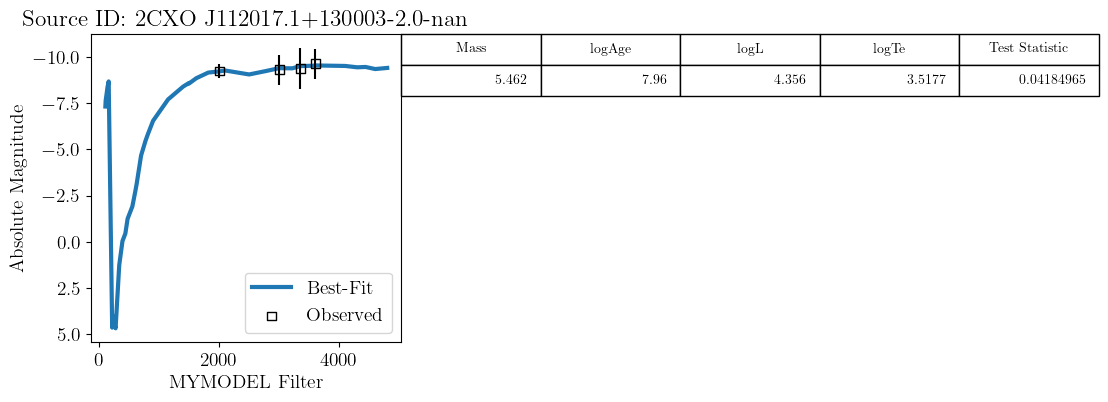

No best-fit model available for Source ID 2CXO J112017.1+130003-3.0-nan.


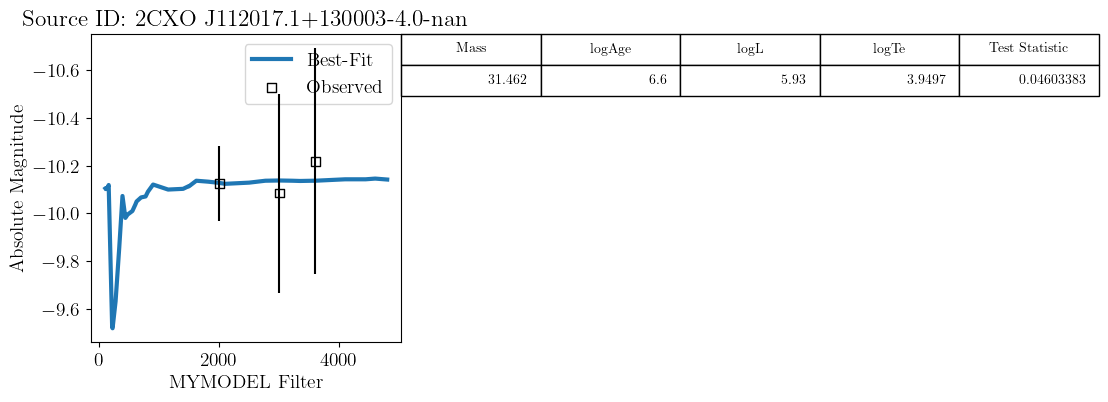

No best-fit model available for Source ID 2CXO J112017.1+130003-5.0-nan.
No best-fit model available for Source ID 2CXO J112017.1+130003-6.0-nan.


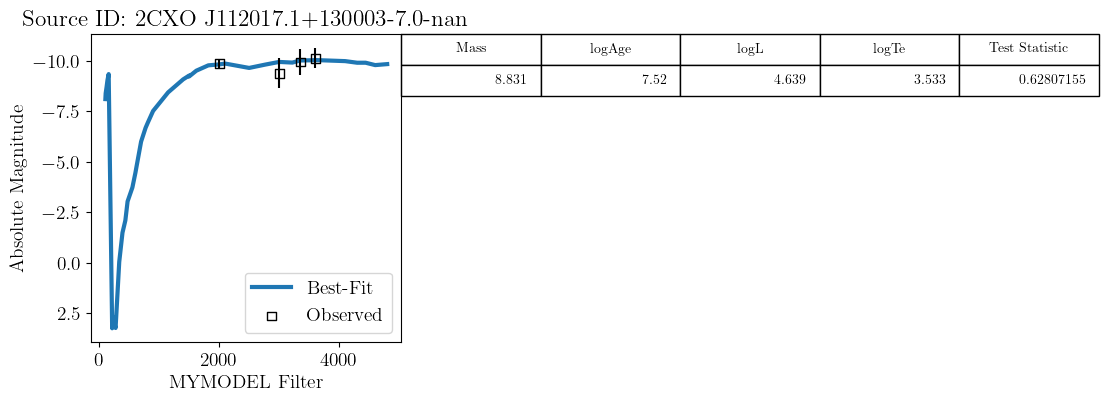

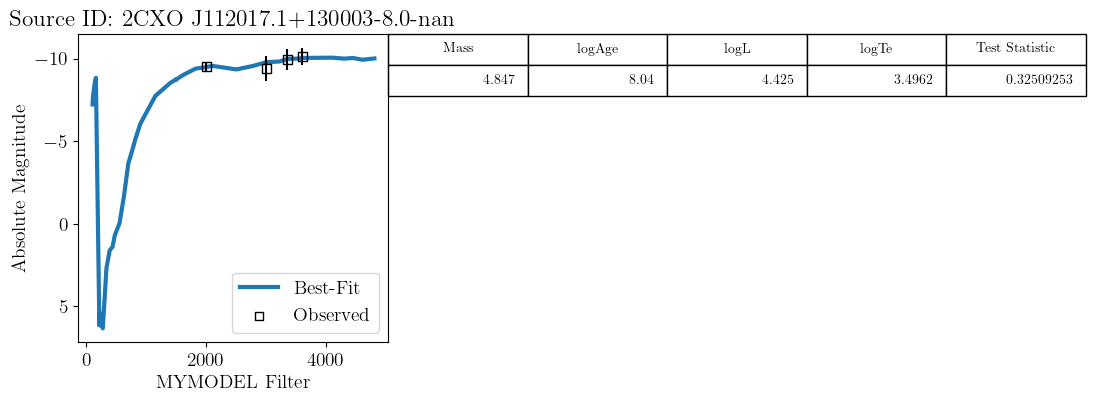

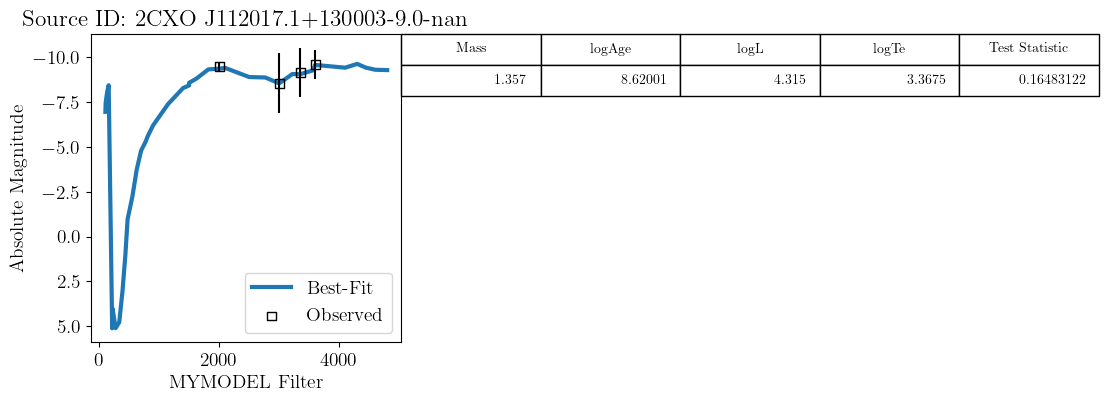

No best-fit model available for Source ID 2CXO J112012.2+125952-1.0-nan.


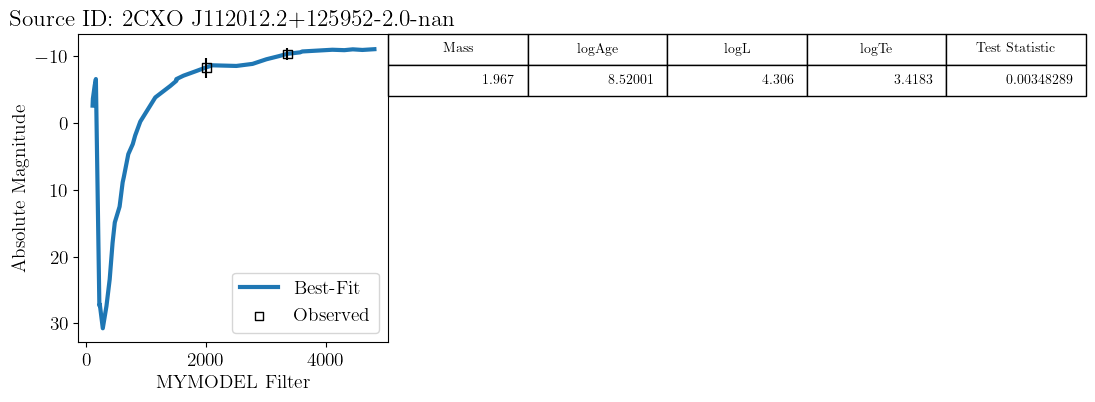

No best-fit model available for Source ID 2CXO J112012.2+125952-3.0-nan.


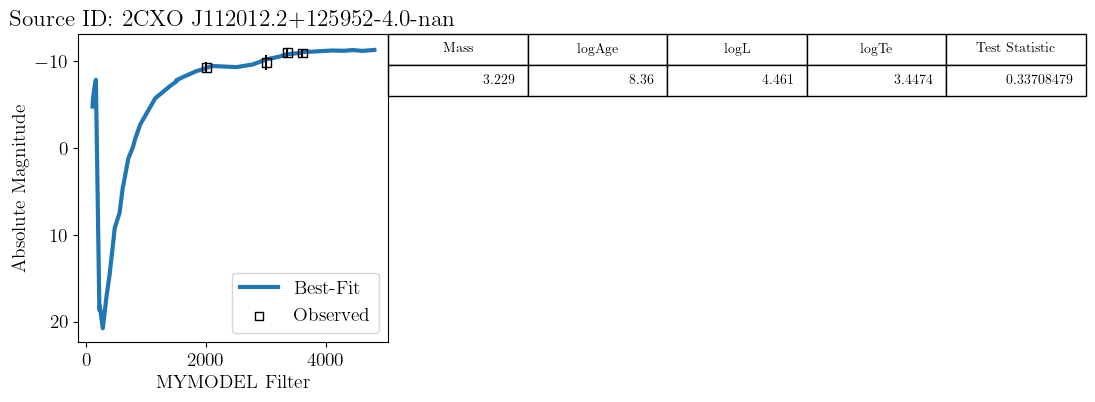

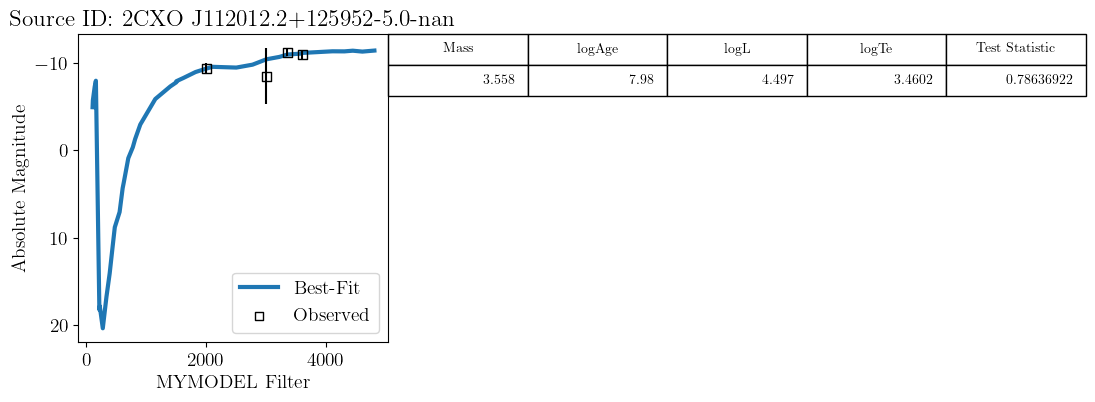

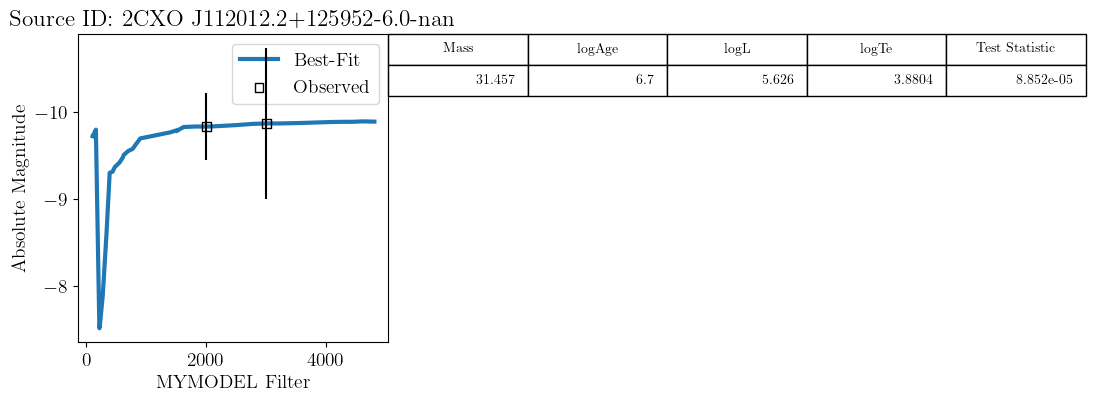

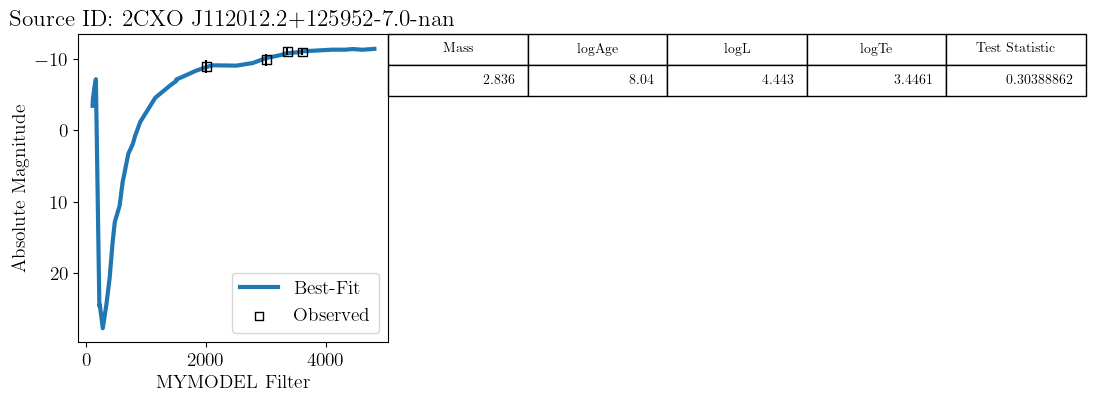

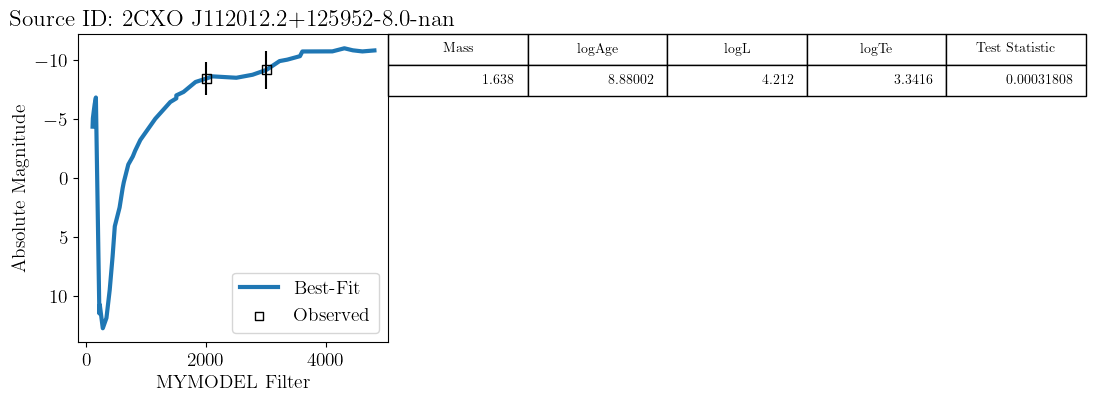

No best-fit model available for Source ID 2CXO J112012.2+125952-9.0-nan.
No best-fit model available for Source ID 2CXO J112012.2+125952-10.0-nan.


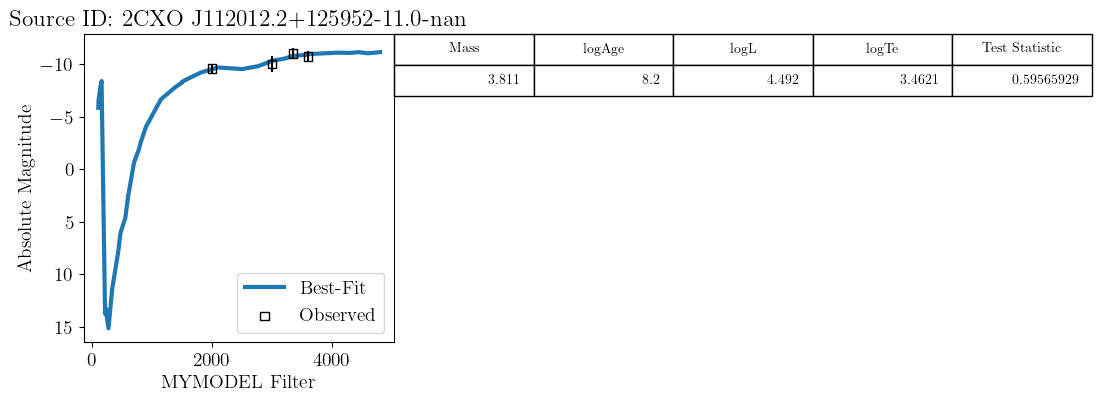

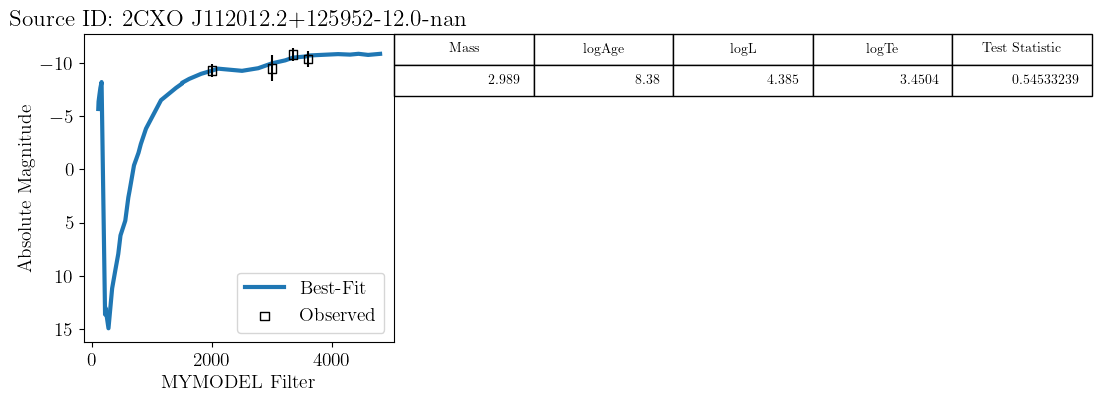

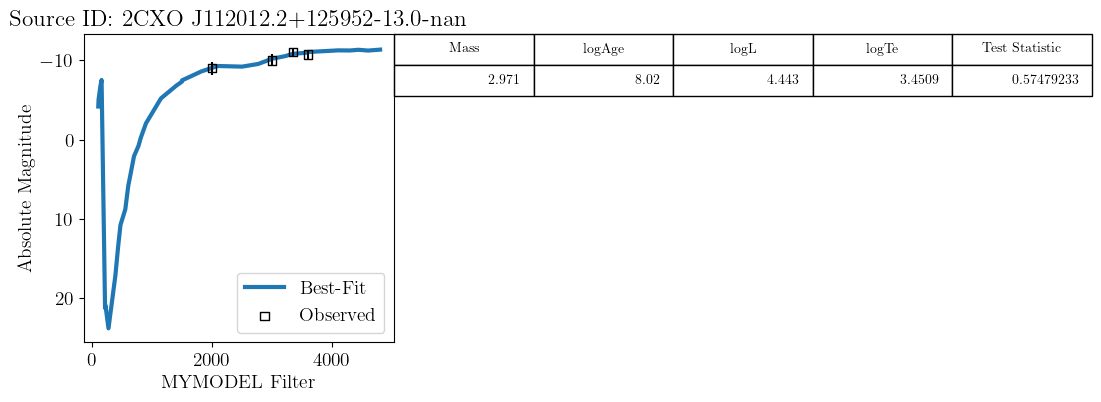

No best-fit model available for Source ID 2CXO J112012.2+125952-14.0-nan.
No best-fit model available for Source ID 2CXO J112012.2+125952-15.0-nan.
No best-fit model available for Source ID 2CXO J112012.2+125952-16.0-nan.


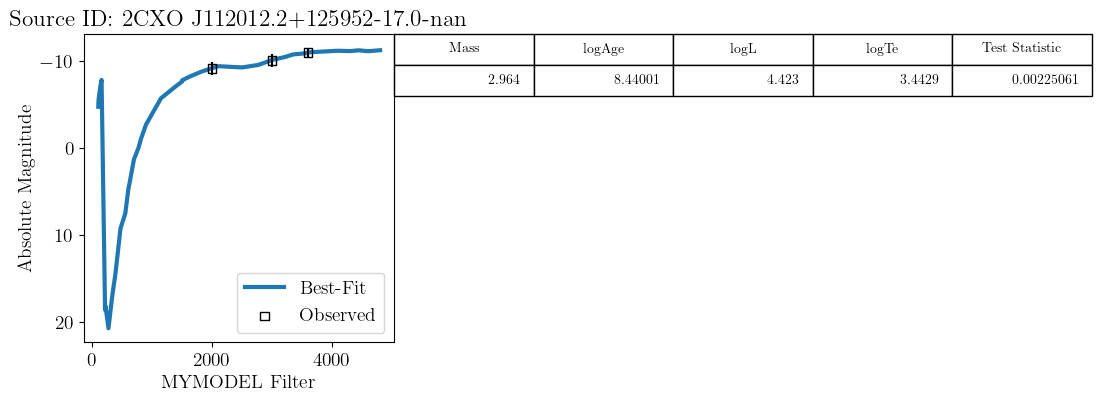

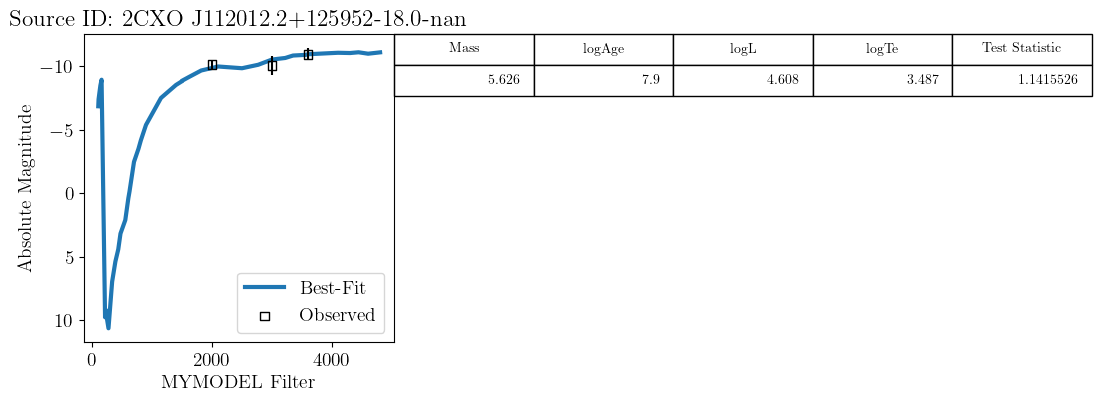

No best-fit model available for Source ID 2CXO J112012.2+125952-19.0-nan.
No best-fit model available for Source ID 2CXO J112012.2+125952-20.0-nan.


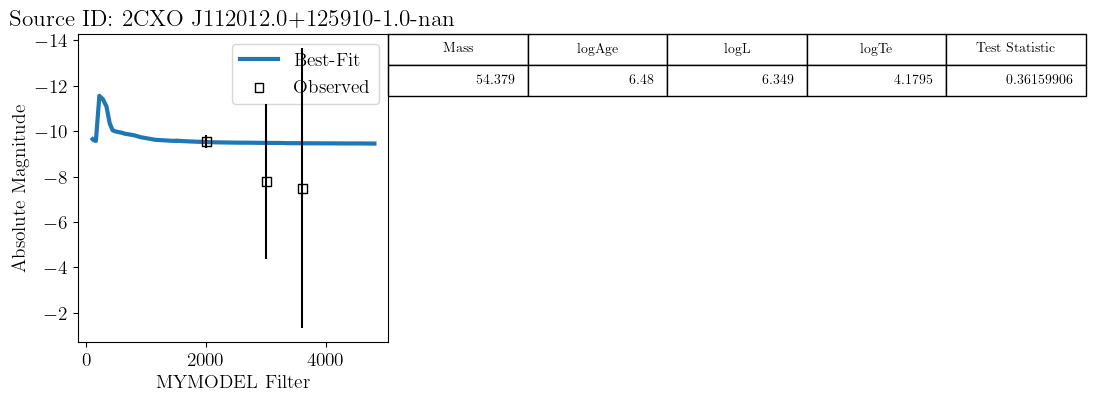

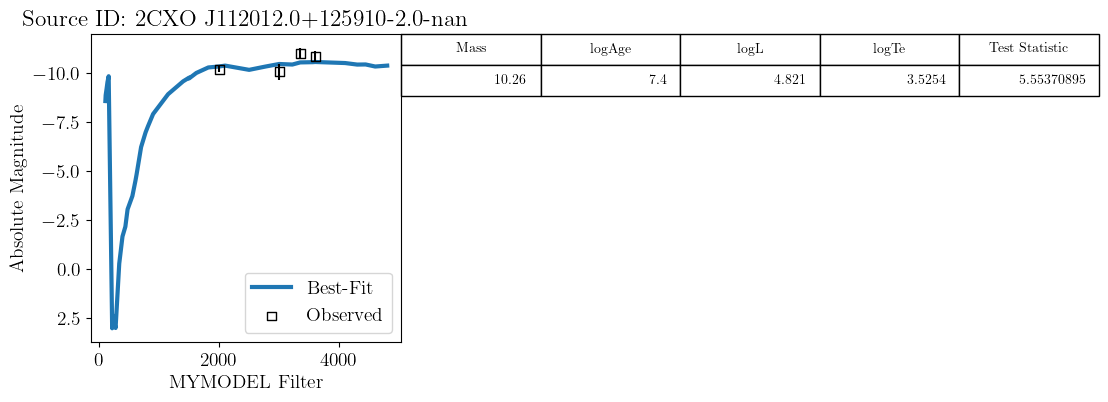

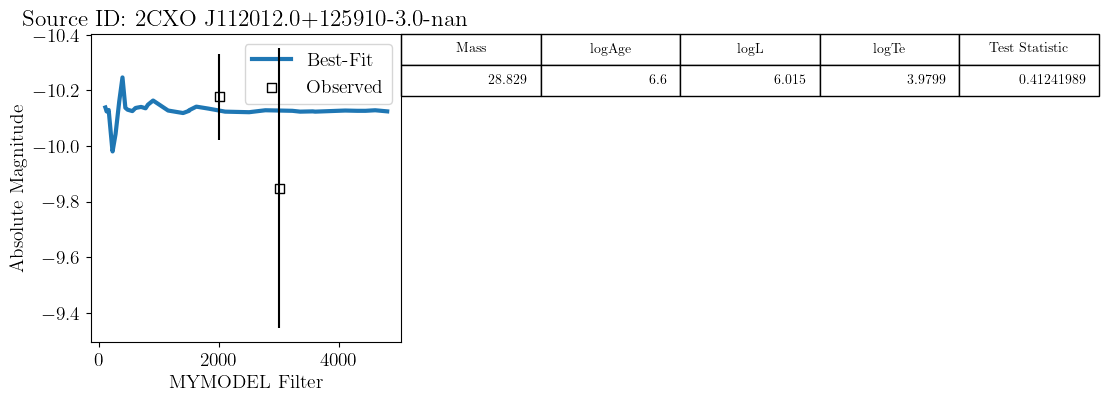

No best-fit model available for Source ID 2CXO J112012.0+125910-4.0-nan.


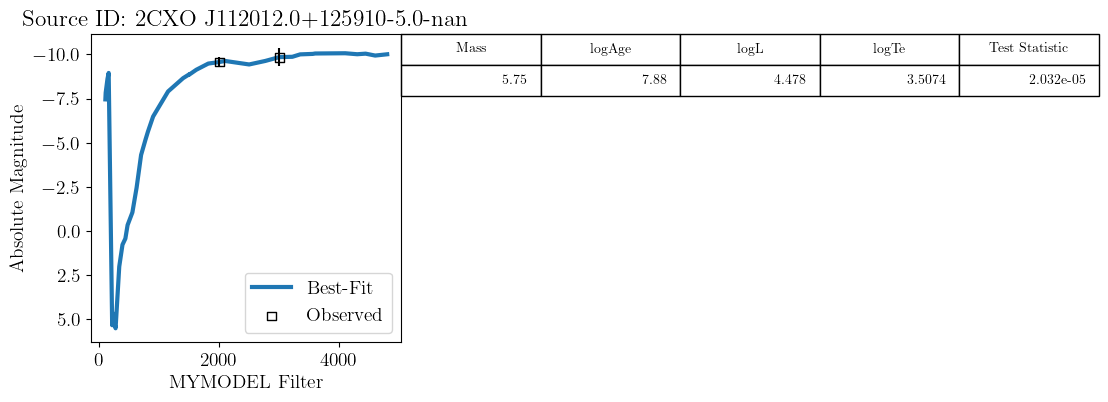

No best-fit model available for Source ID 2CXO J112015.8+130019-1.0-nan.


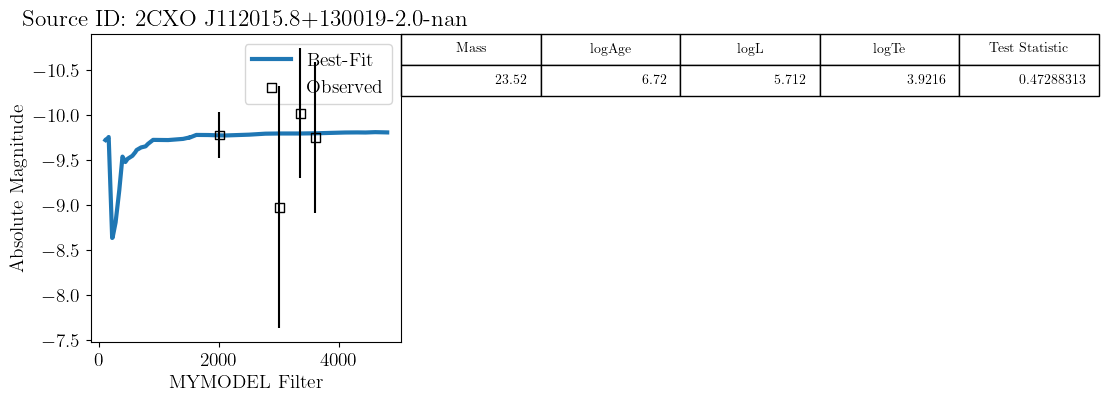

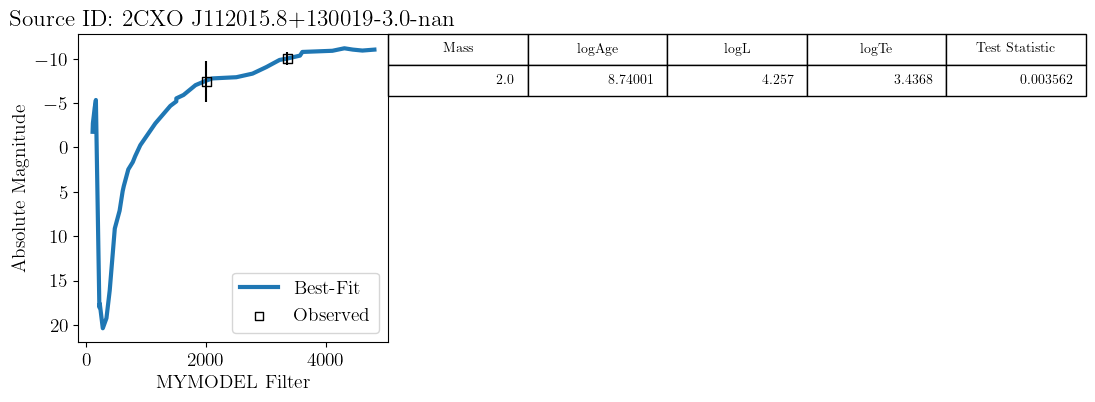

No best-fit model available for Source ID 2CXO J112015.8+130019-4.0-nan.


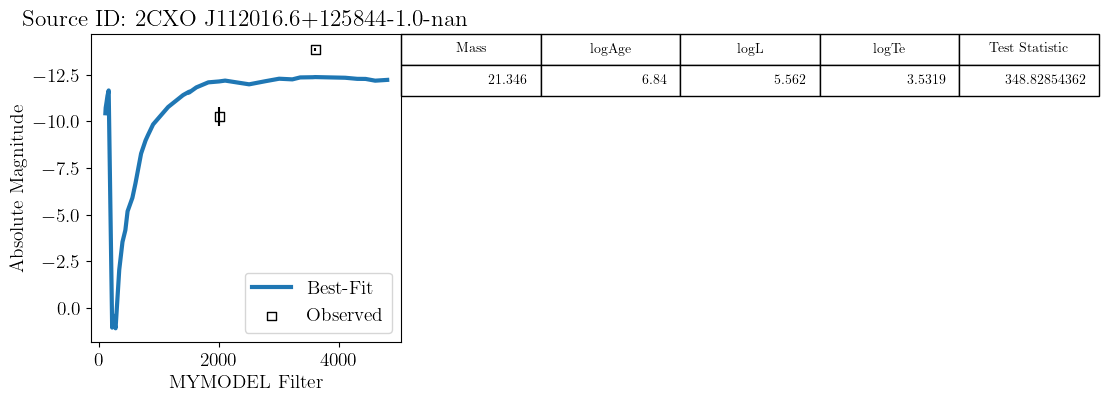

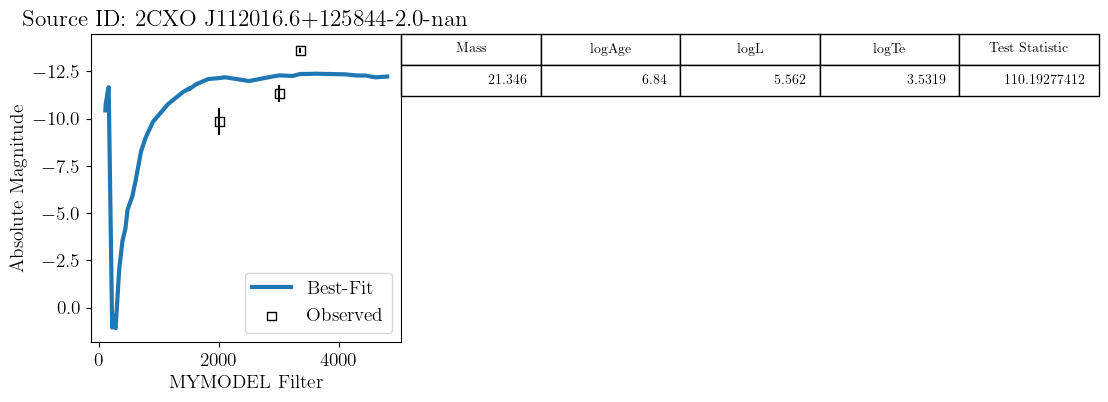

No best-fit model available for Source ID 2CXO J112016.6+125844-3.0-nan.
No best-fit model available for Source ID 2CXO J112016.6+125844-4.0-nan.


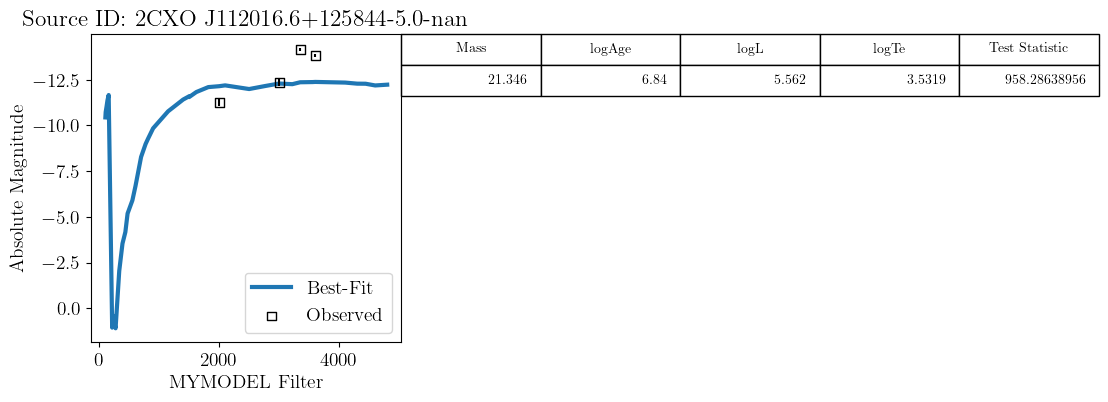

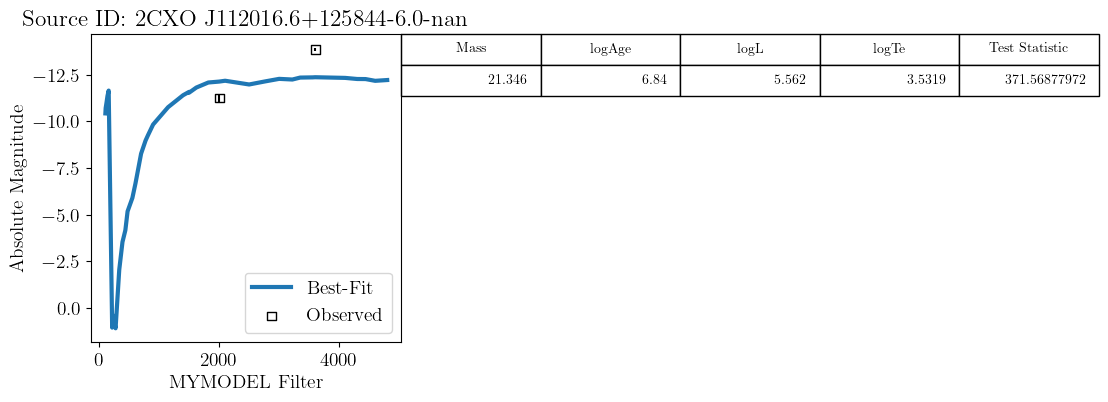

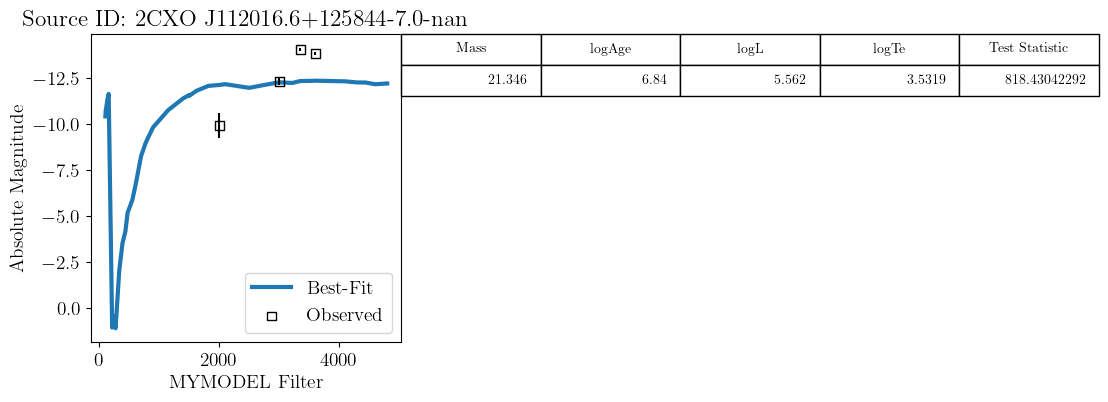

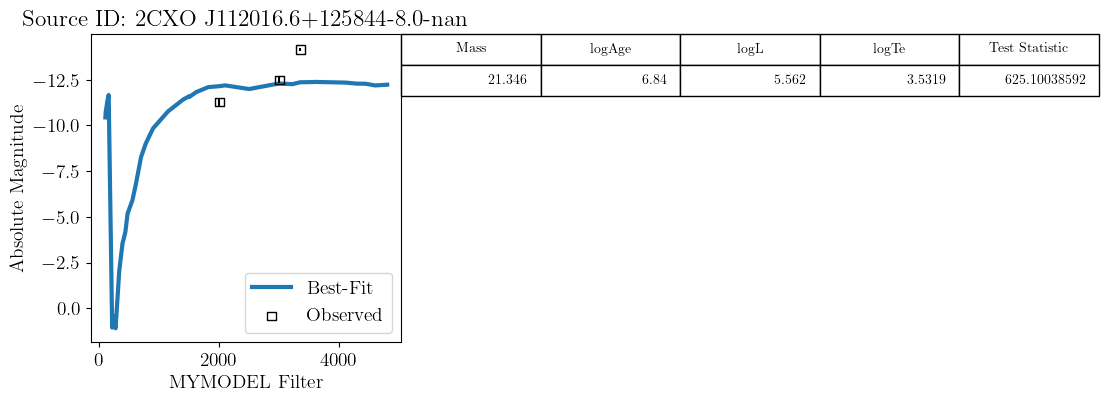

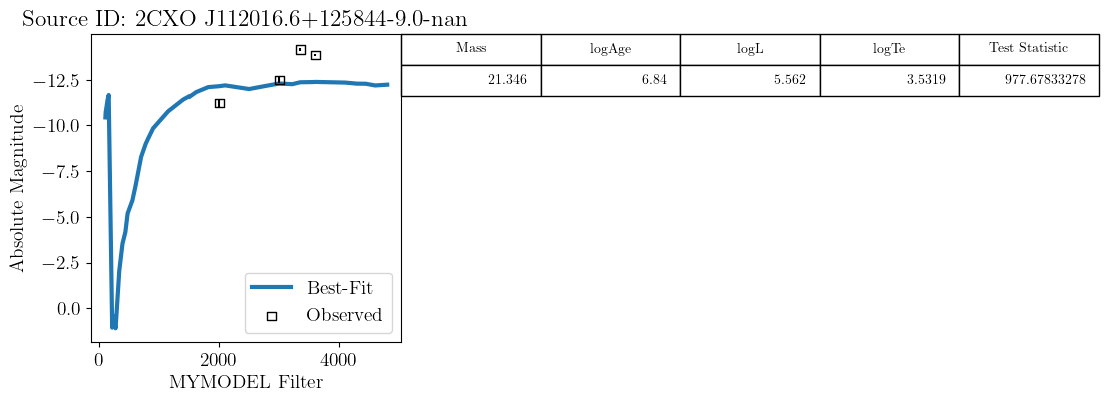

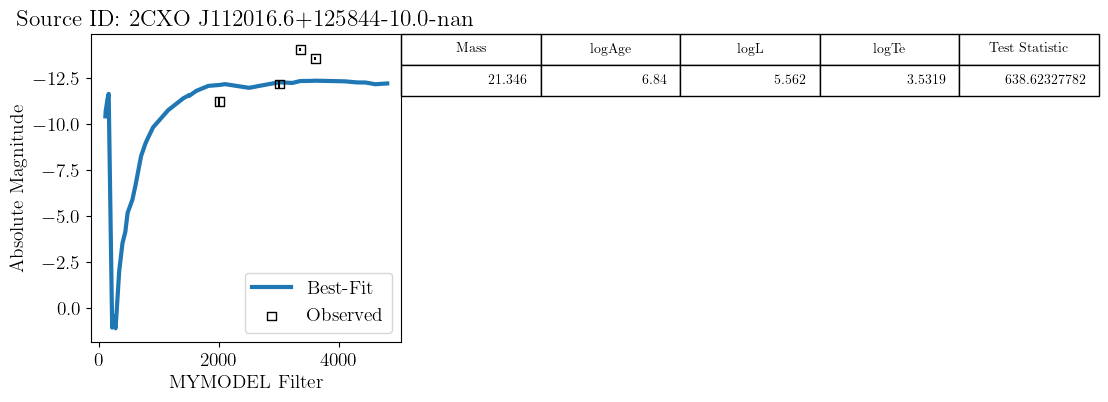

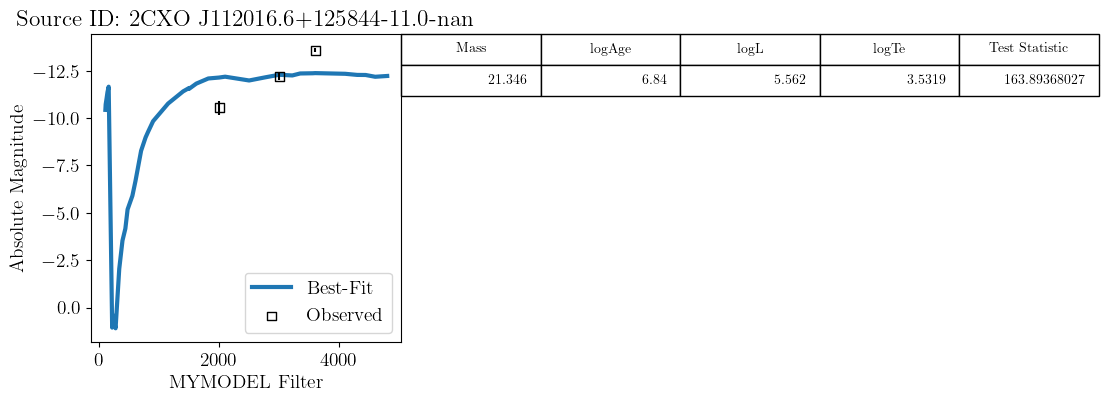

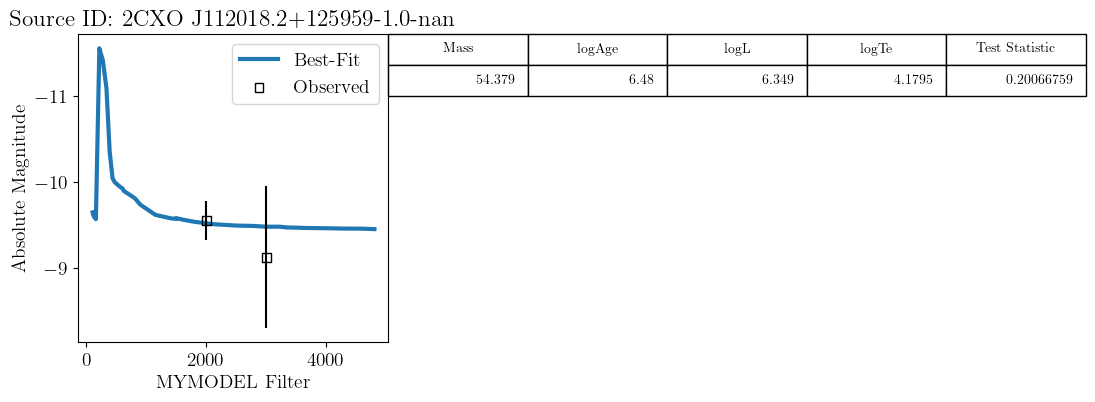

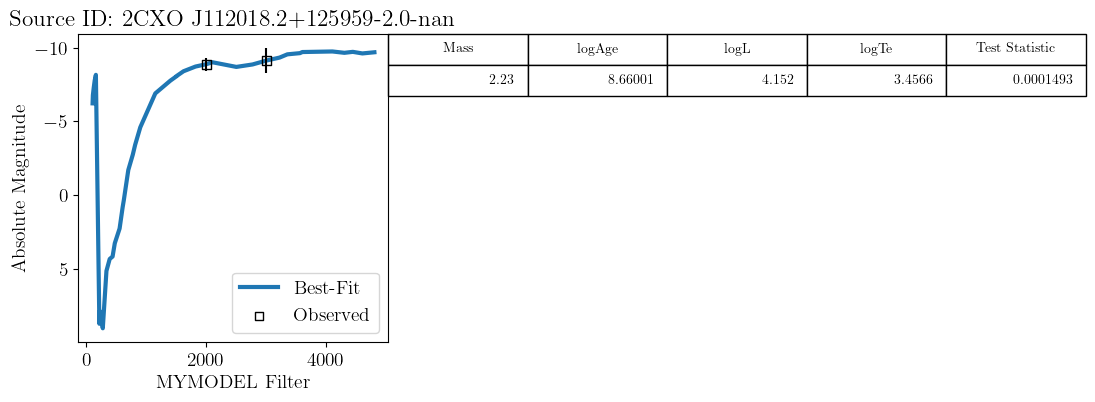

No best-fit model available for Source ID 2CXO J112012.3+125846-1.0-nan.


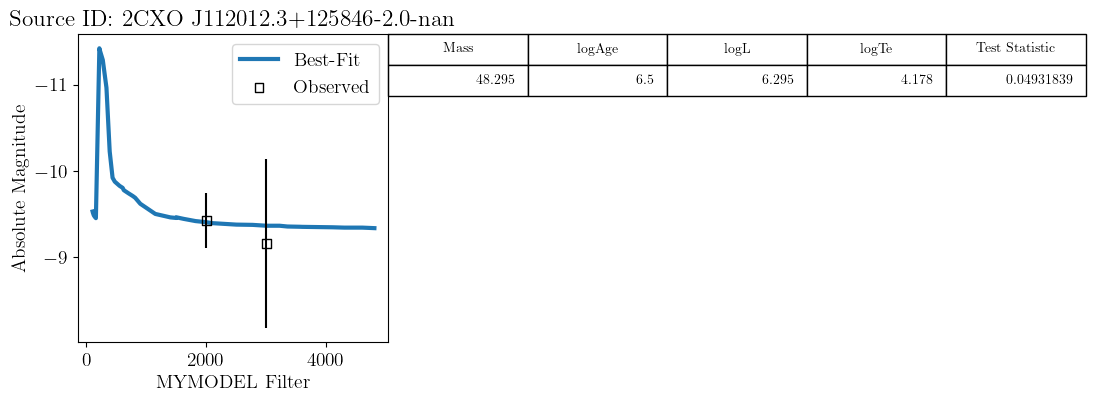

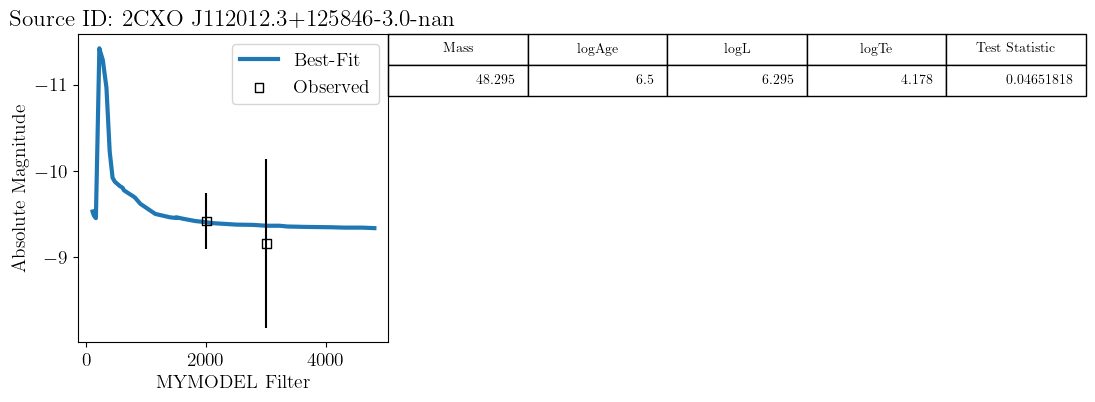

No best-fit model available for Source ID 2CXO J112012.3+125846-4.0-nan.
No best-fit model available for Source ID 2CXO J112011.3+125904-1.0-nan.
No best-fit model available for Source ID 2CXO J112011.3+125904-2.0-nan.
No best-fit model available for Source ID 2CXO J112017.3+130019-1.0-nan.
No best-fit model available for Source ID 2CXO J112017.3+130019-2.0-nan.


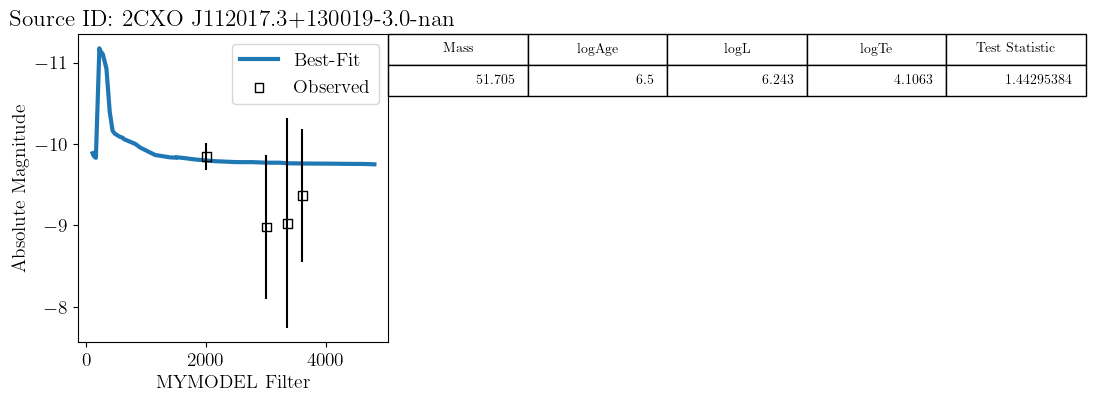

No best-fit model available for Source ID 2CXO J112017.3+130019-4.0-nan.


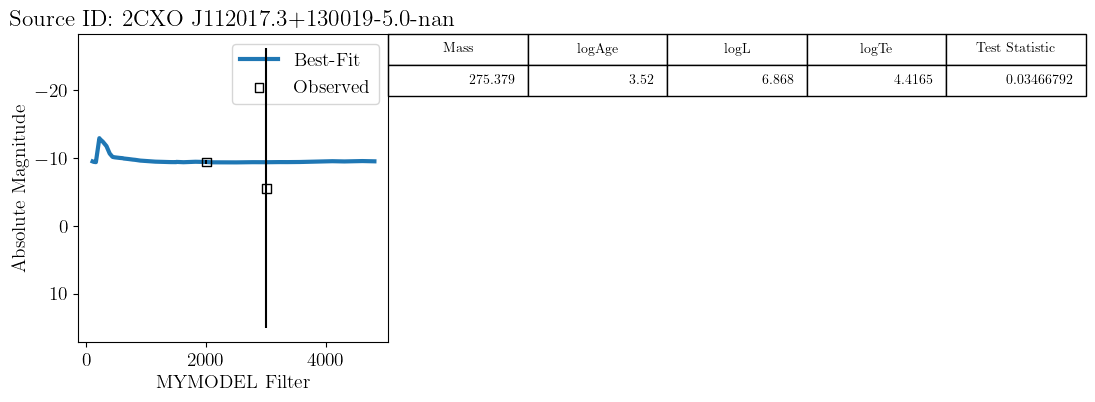

No best-fit model available for Source ID 2CXO J112017.3+130019-6.0-nan.


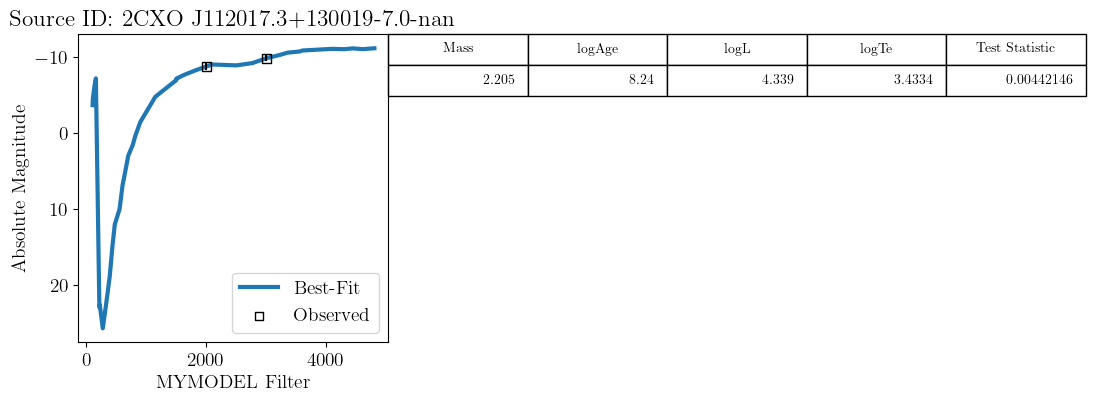

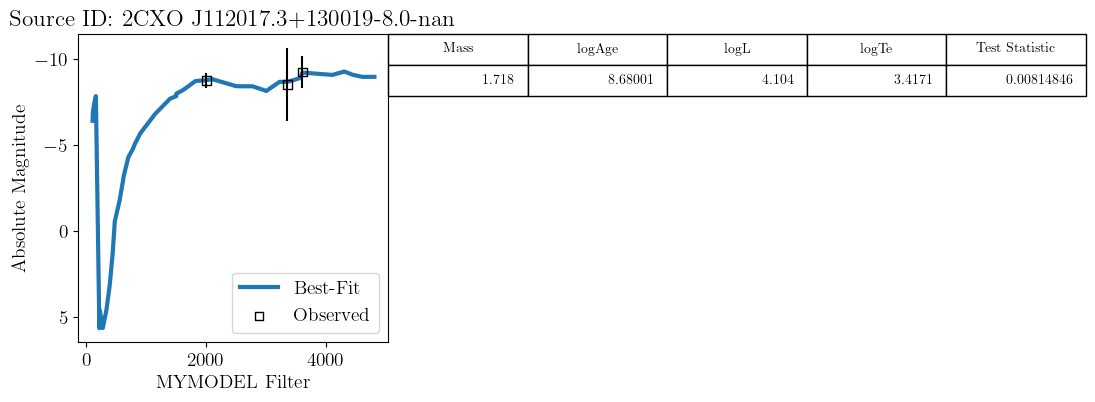

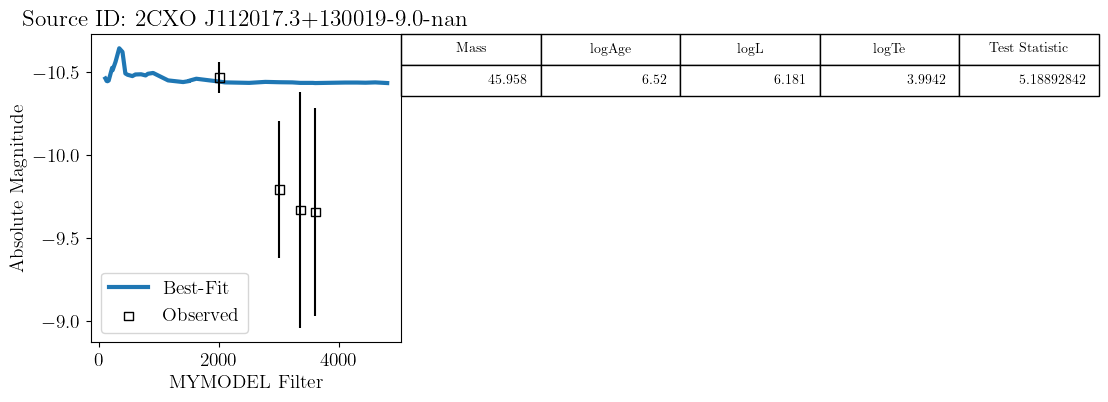

No best-fit model available for Source ID 2CXO J112017.3+130019-10.0-nan.


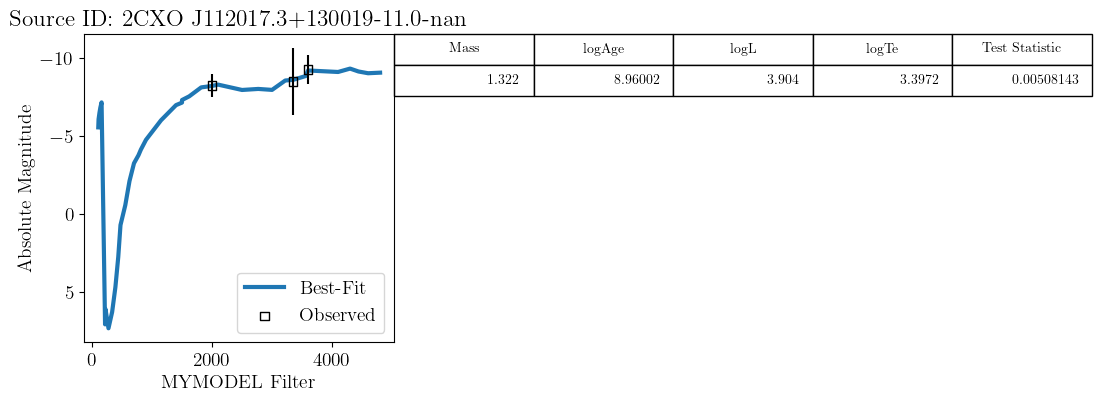

No best-fit model available for Source ID 2CXO J112017.3+130019-12.0-nan.


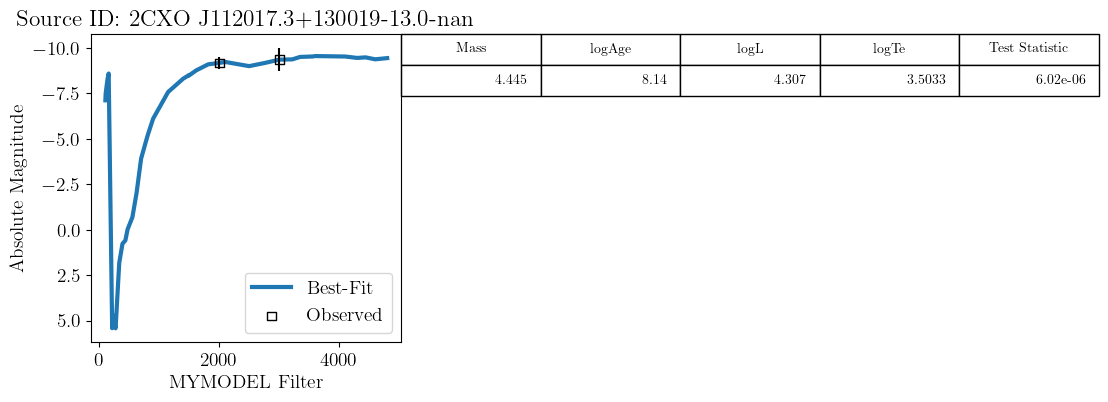

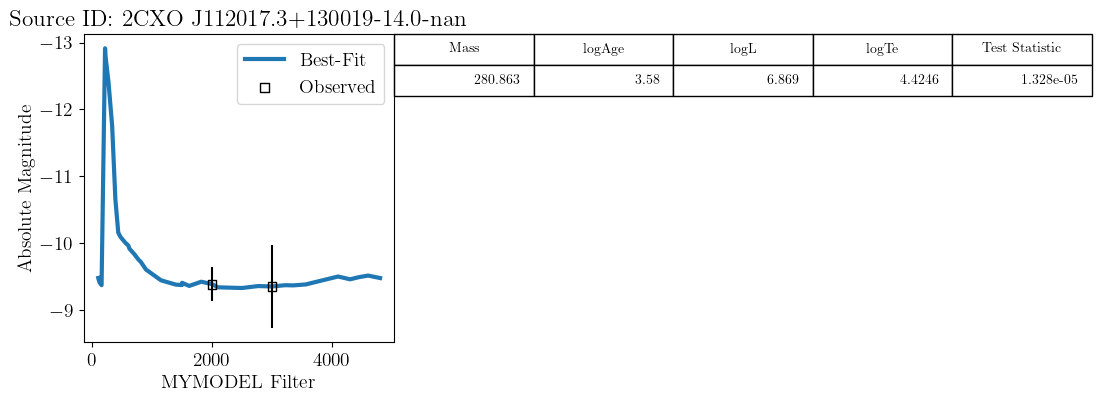

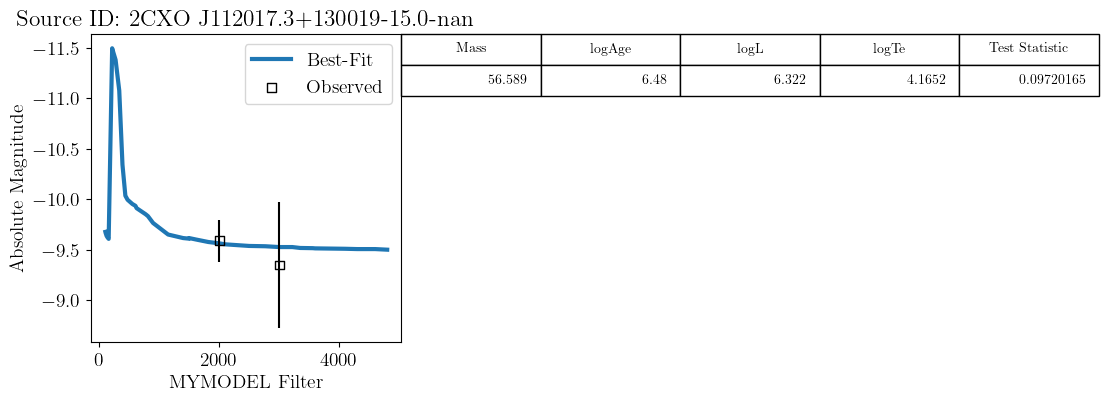

No best-fit model available for Source ID 2CXO J112017.3+130019-16.0-nan.


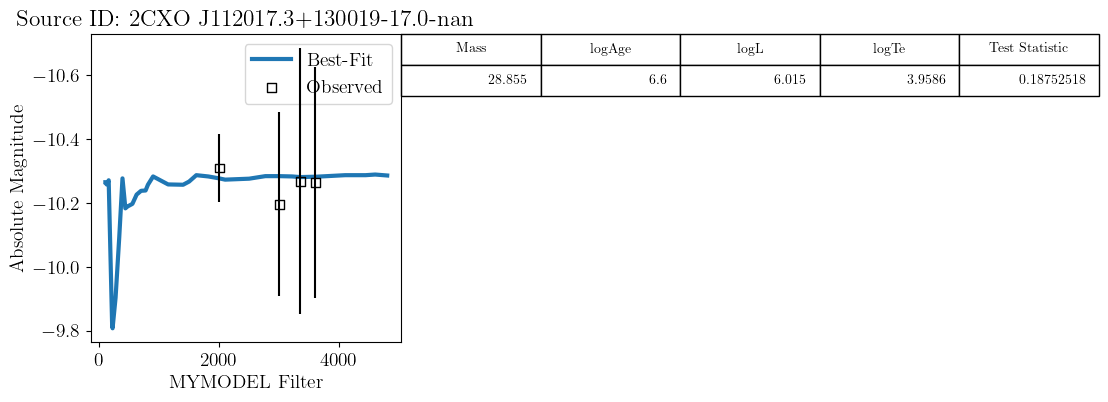

No best-fit model available for Source ID 2CXO J112017.6+130017-1.0-nan.
No best-fit model available for Source ID 2CXO J112017.6+130017-2.0-nan.


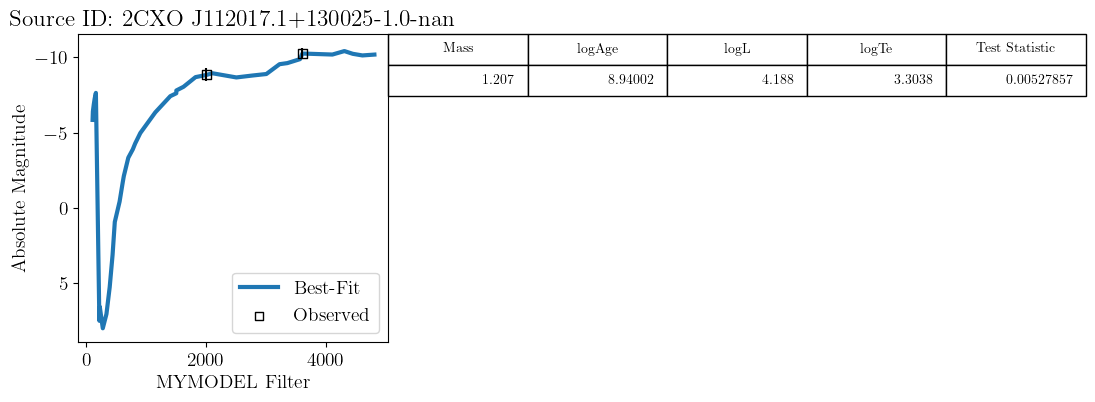

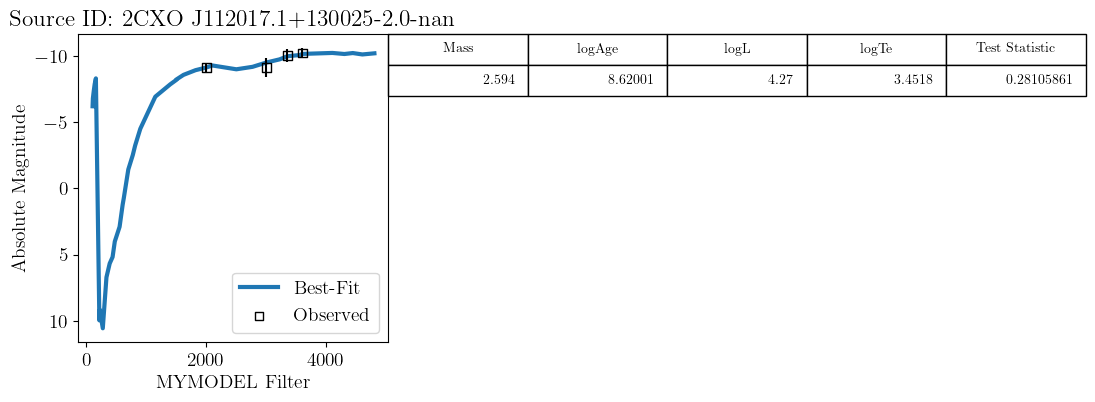

No best-fit model available for Source ID 2CXO J112017.1+130025-3.0-nan.


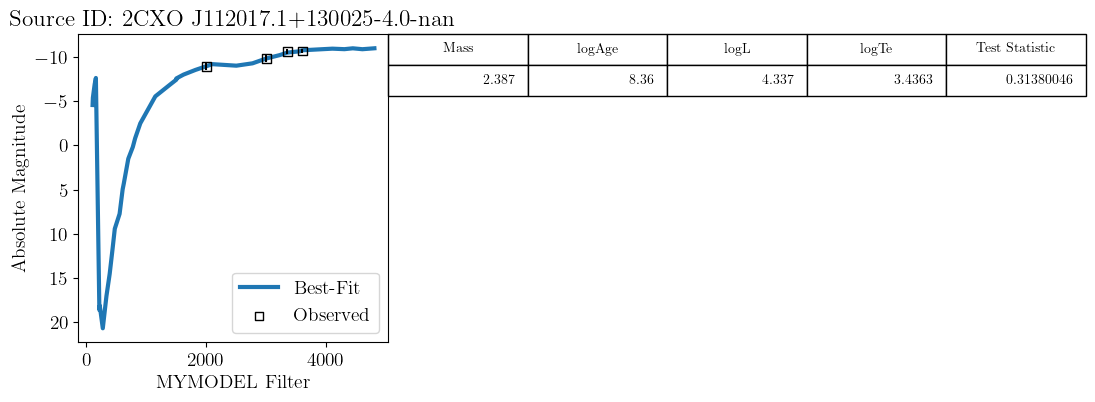

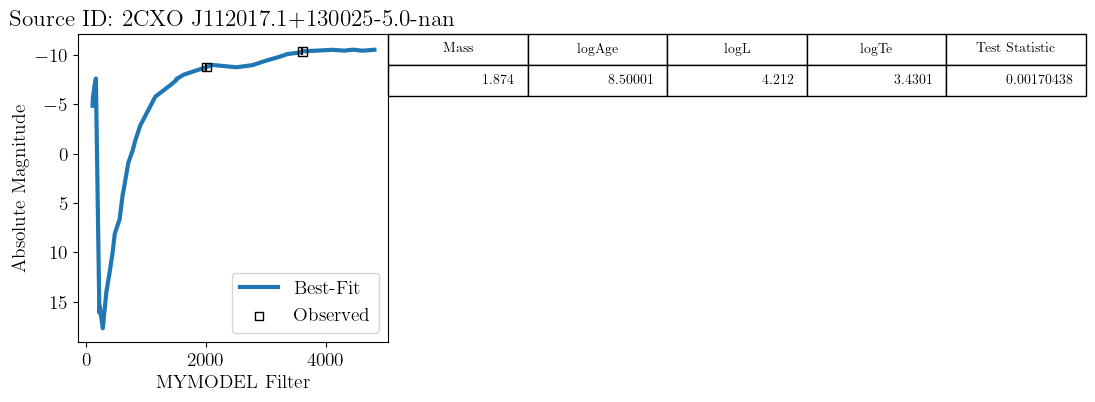

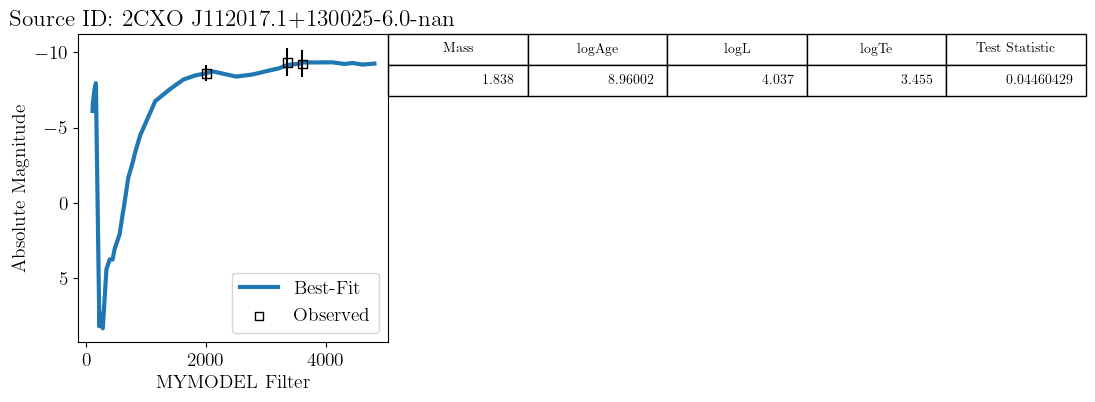

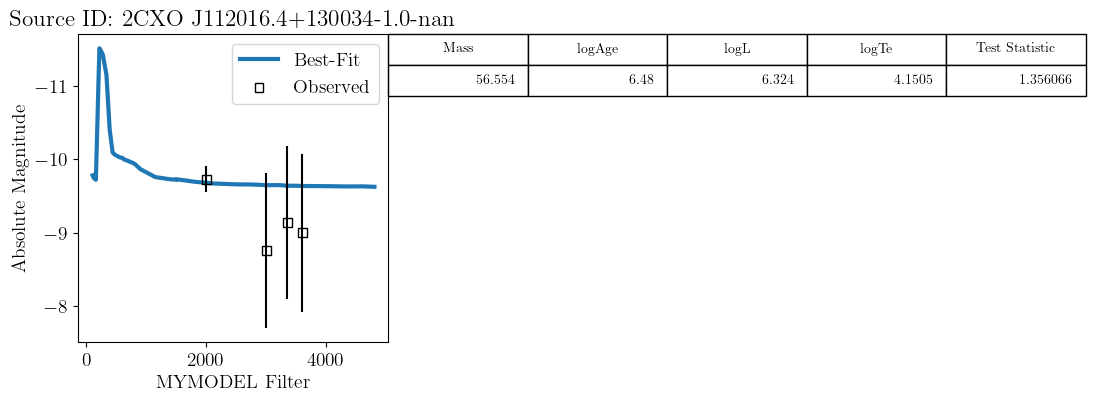

No best-fit model available for Source ID 2CXO J112016.4+130034-2.0-nan.
No best-fit model available for Source ID 2CXO J112016.4+130034-3.0-nan.
No best-fit model available for Source ID 2CXO J112016.4+130034-4.0-nan.
No best-fit model available for Source ID 2CXO J112016.4+130034-5.0-nan.
No best-fit model available for Source ID 2CXO J112016.4+130034-6.0-nan.
No best-fit model available for Source ID 2CXO J112016.4+130034-7.0-nan.


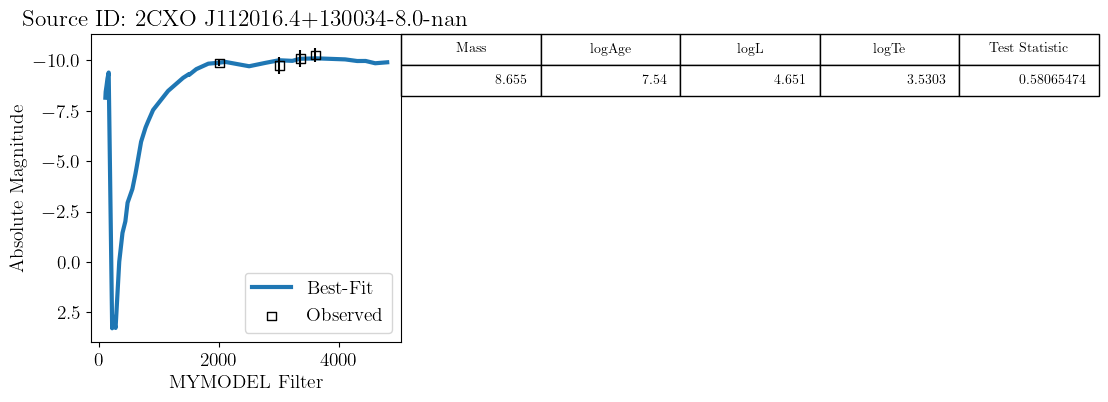

No best-fit model available for Source ID 2CXO J112016.4+130034-9.0-nan.


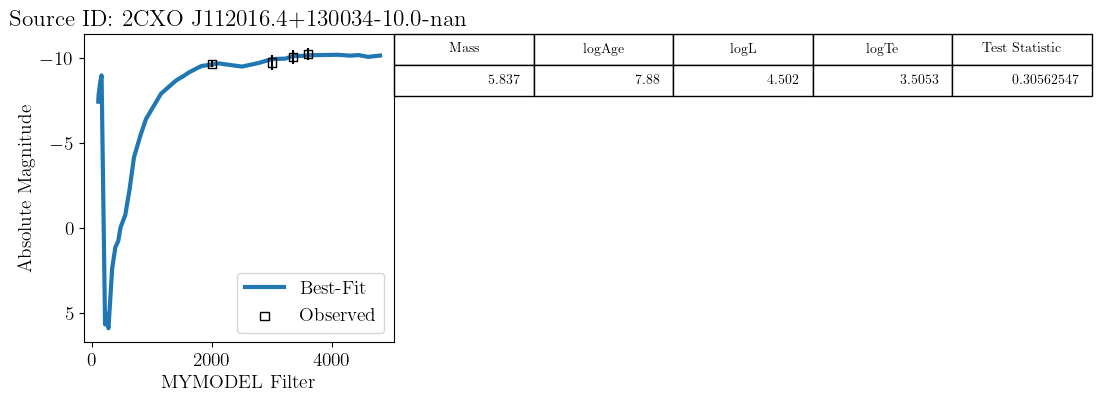

No best-fit model available for Source ID 2CXO J112016.4+130034-11.0-nan.
No best-fit model available for Source ID 2CXO J112016.4+130034-12.0-nan.


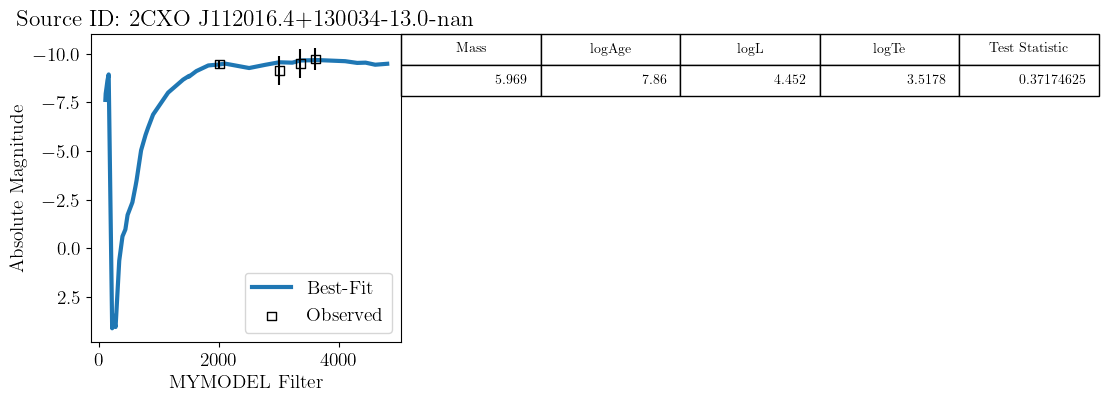

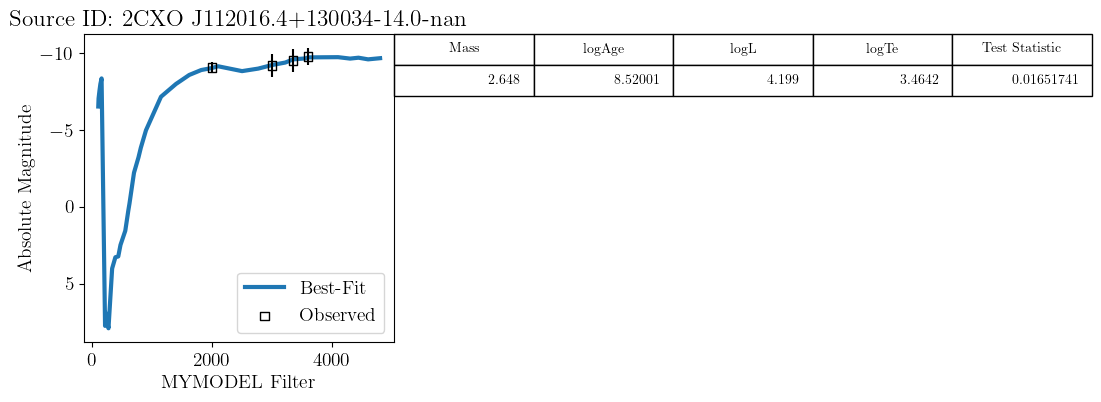

No best-fit model available for Source ID 2CXO J112016.4+130034-15.0-nan.


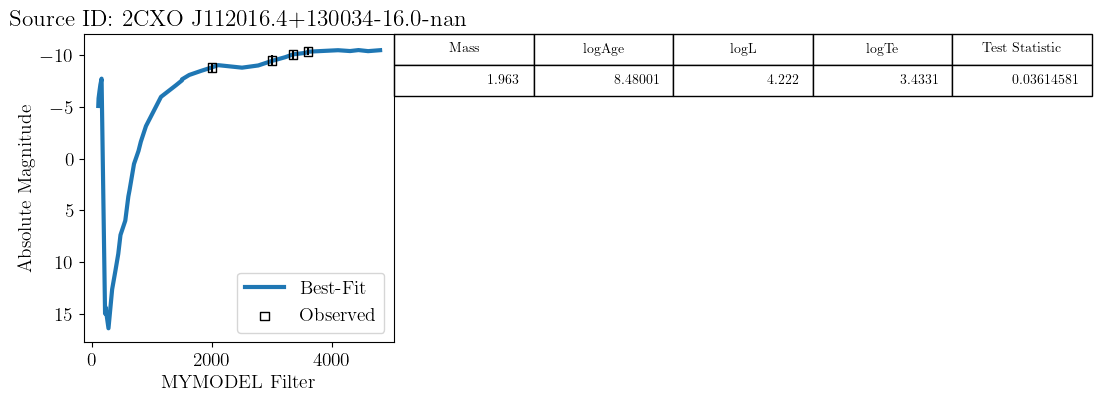

No best-fit model available for Source ID 2CXO J112016.4+130034-17.0-nan.
No best-fit model available for Source ID 2CXO J112016.4+130034-18.0-nan.
No best-fit model available for Source ID 2CXO J112016.4+130034-19.0-nan.


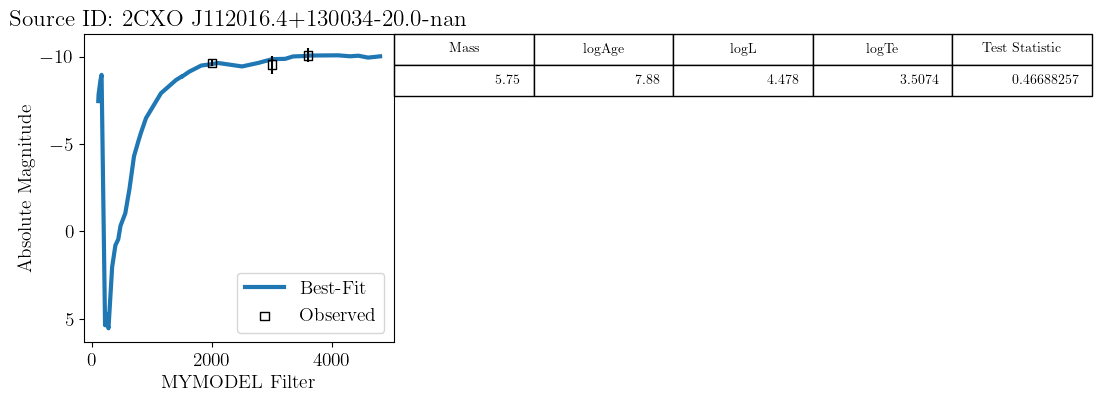

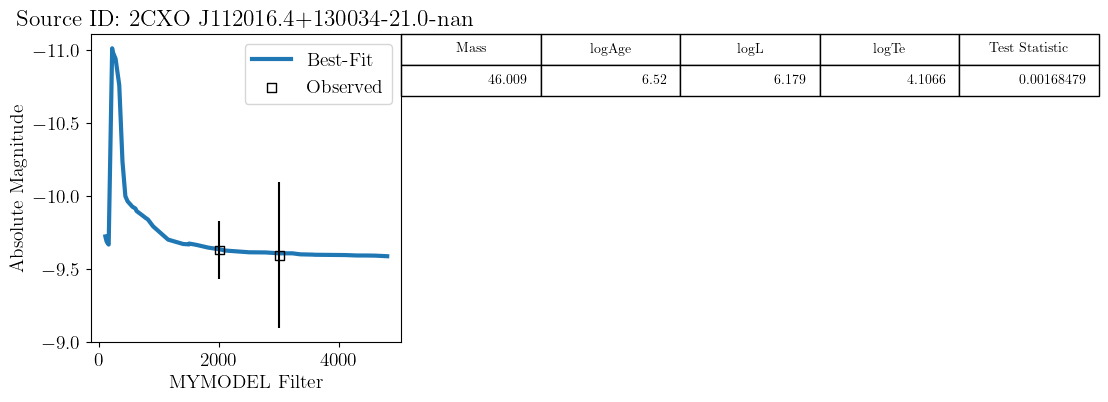

No best-fit model available for Source ID 2CXO J112016.4+130034-22.0-nan.
No best-fit model available for Source ID 2CXO J112016.4+130034-23.0-nan.


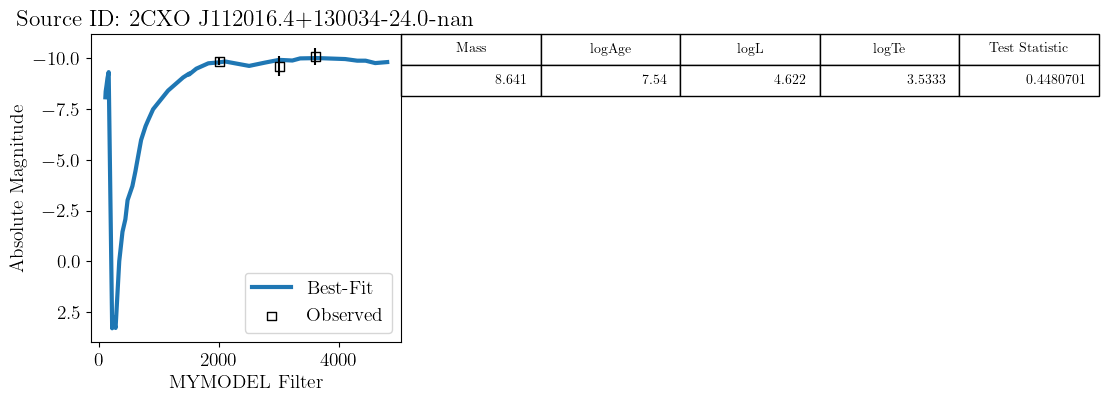

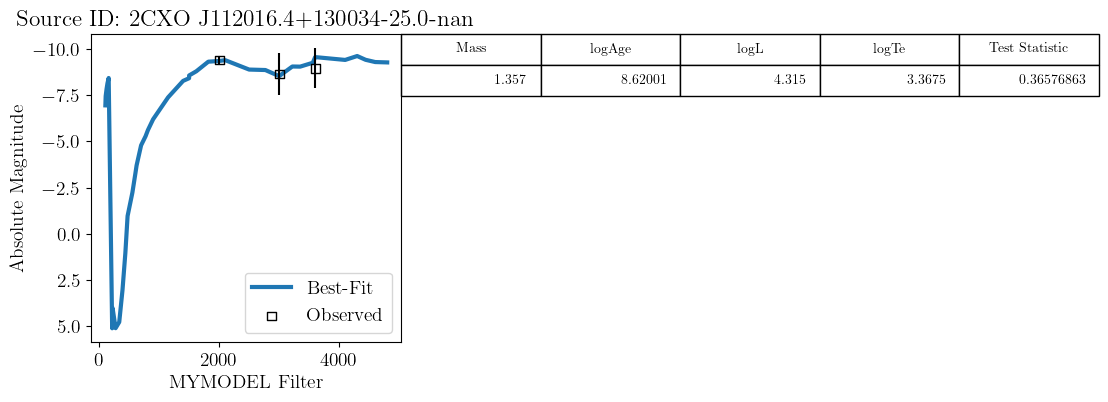

No best-fit model available for Source ID 2CXO J112016.4+130034-26.0-nan.
No best-fit model available for Source ID 2CXO J112016.4+130034-27.0-nan.


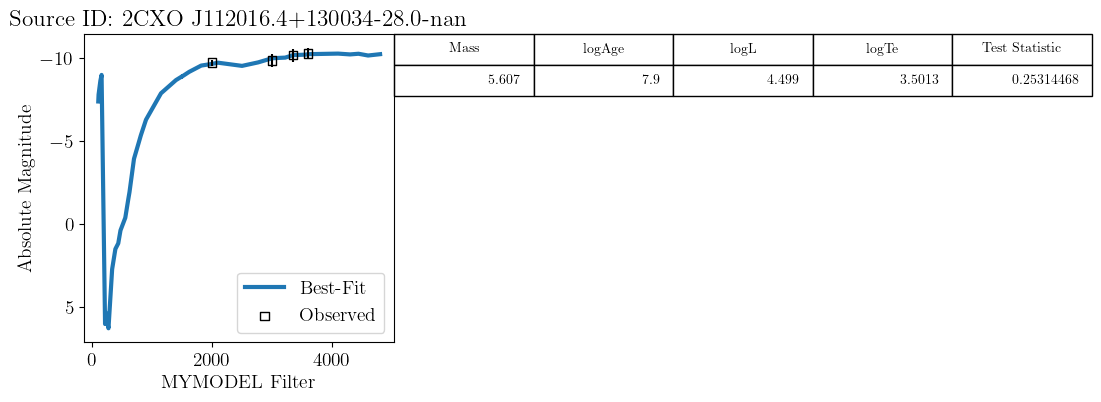

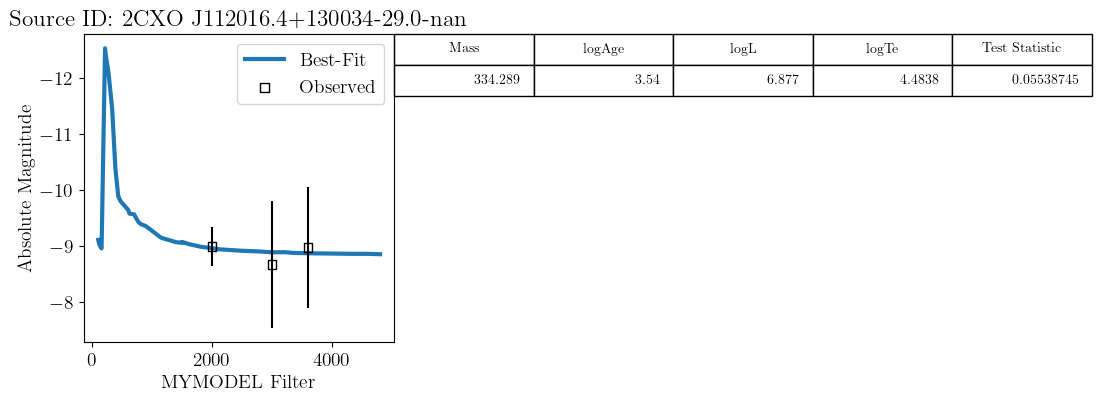

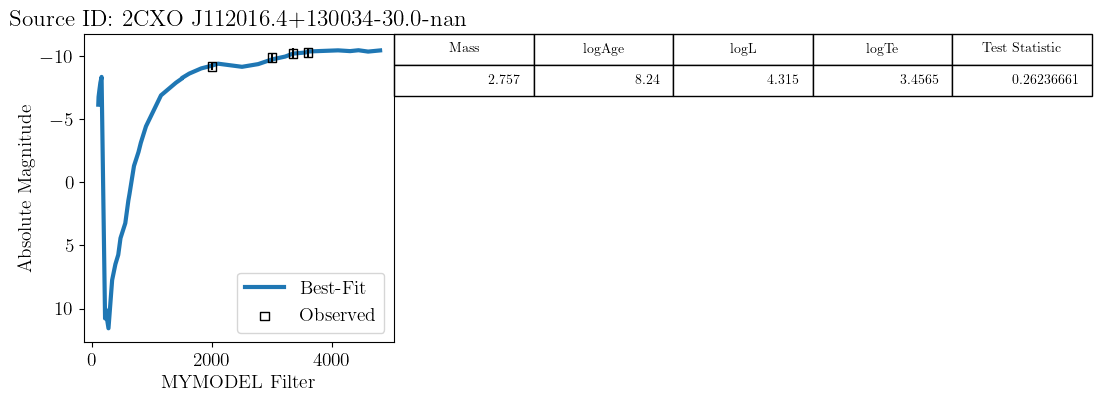

No best-fit model available for Source ID 2CXO J112016.4+130034-31.0-nan.
No best-fit model available for Source ID 2CXO J112016.4+130034-32.0-nan.
No best-fit model available for Source ID 2CXO J112016.4+130034-33.0-nan.
No best-fit model available for Source ID 2CXO J112016.4+130034-34.0-nan.
No best-fit model available for Source ID 2CXO J112016.4+130034-35.0-nan.


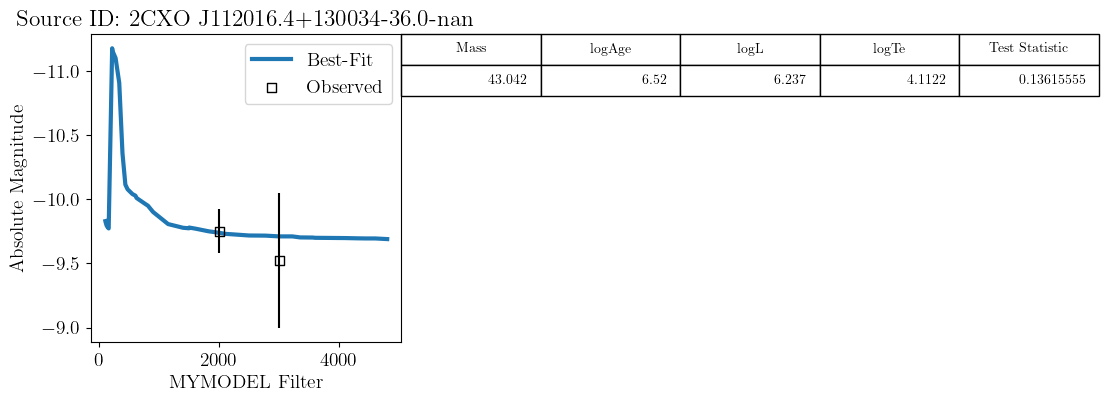

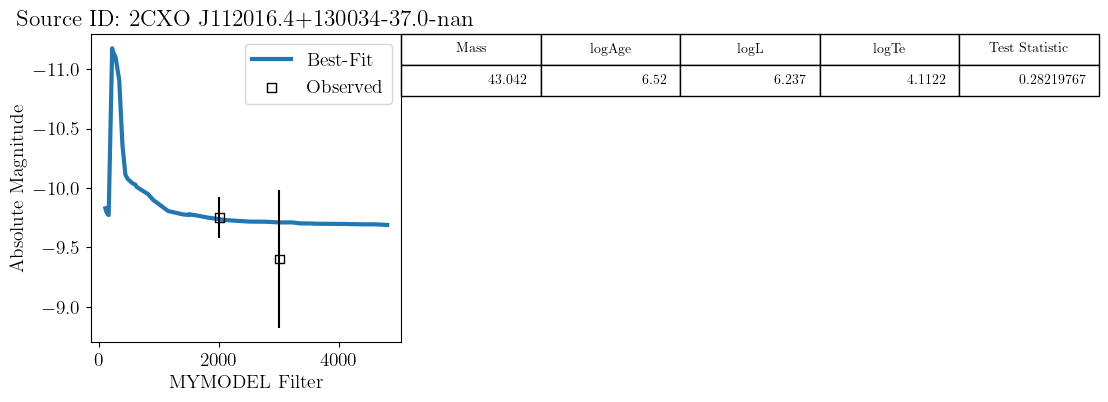

No best-fit model available for Source ID 2CXO J112016.4+130034-38.0-nan.


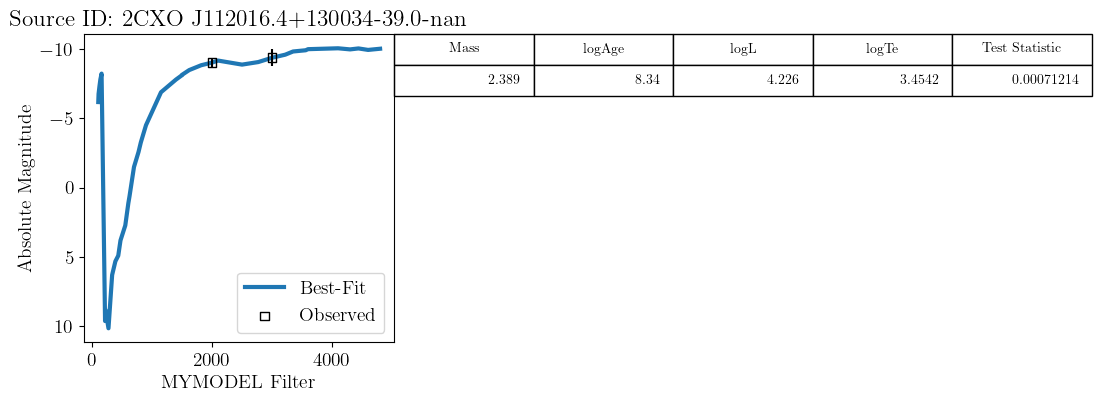

No best-fit model available for Source ID 2CXO J112016.4+130034-40.0-nan.


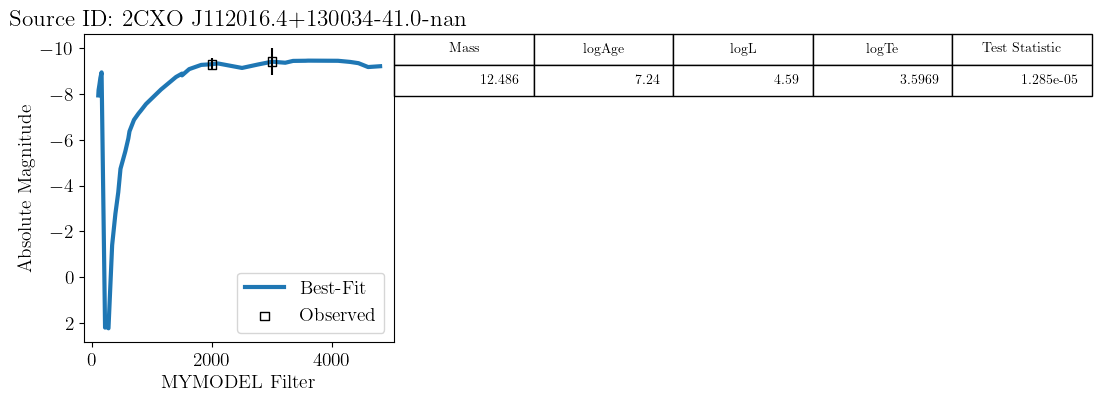

No best-fit model available for Source ID 2CXO J112018.7+130027-1.0-nan.


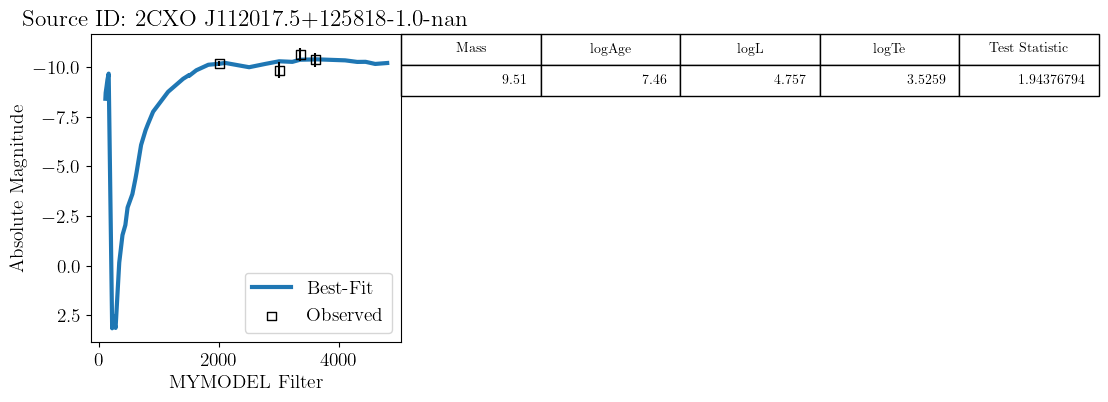

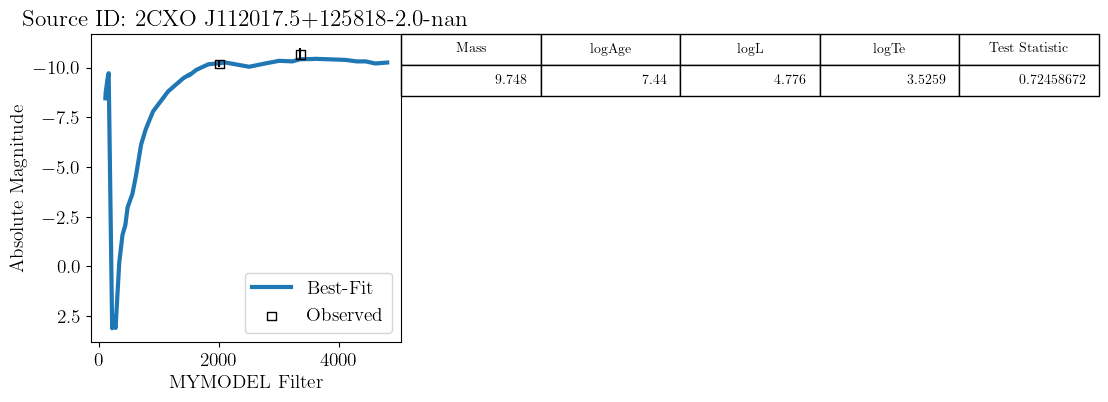

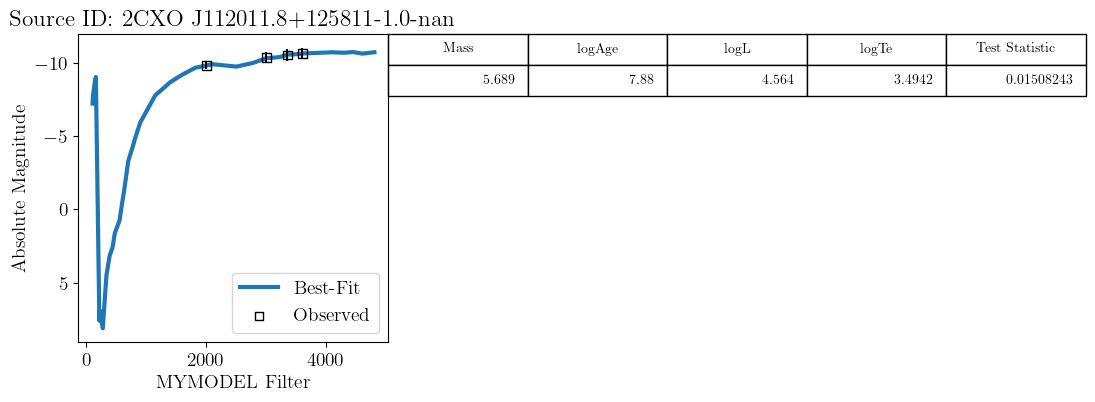

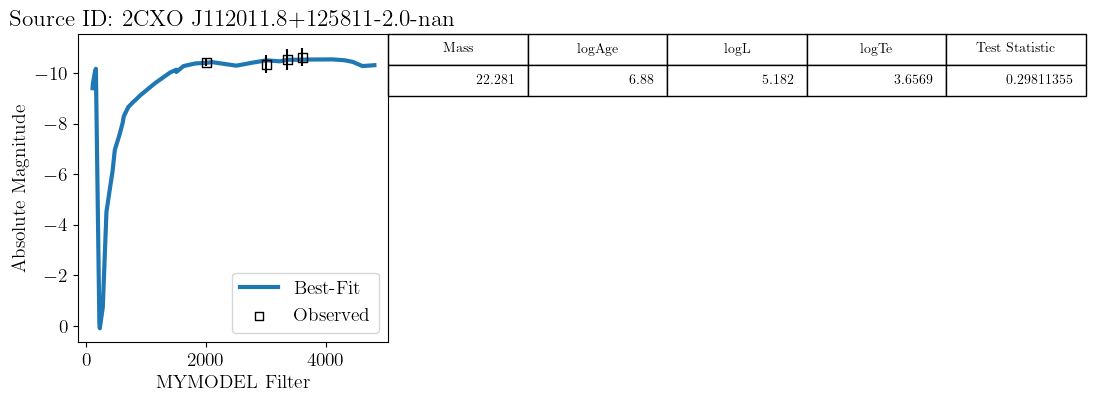

No best-fit model available for Source ID 2CXO J112011.8+125811-3.0-nan.
No best-fit model available for Source ID 2CXO J112011.8+125811-4.0-nan.
No best-fit model available for Source ID 2CXO J112011.8+125811-5.0-nan.
No best-fit model available for Source ID 2CXO J112011.8+125811-6.0-nan.
No best-fit model available for Source ID 2CXO J112011.8+125811-7.0-nan.


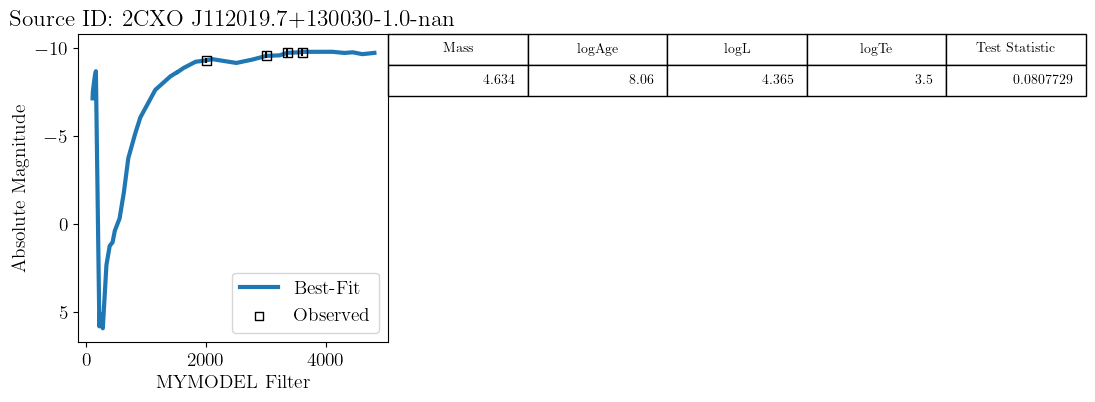

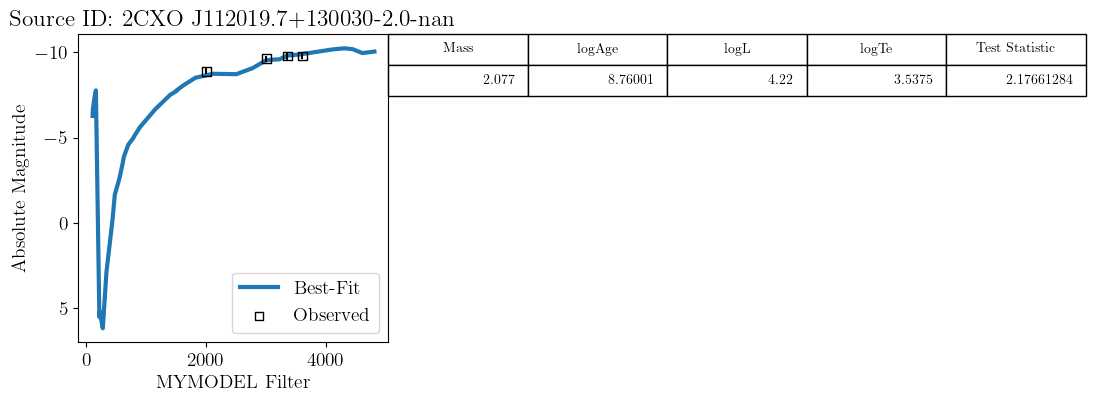

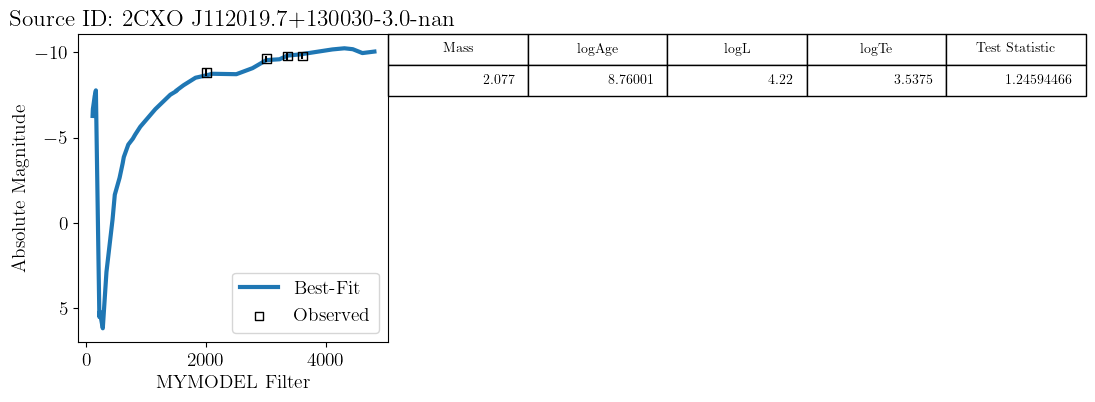

No best-fit model available for Source ID 2CXO J112019.7+130030-4.0-nan.


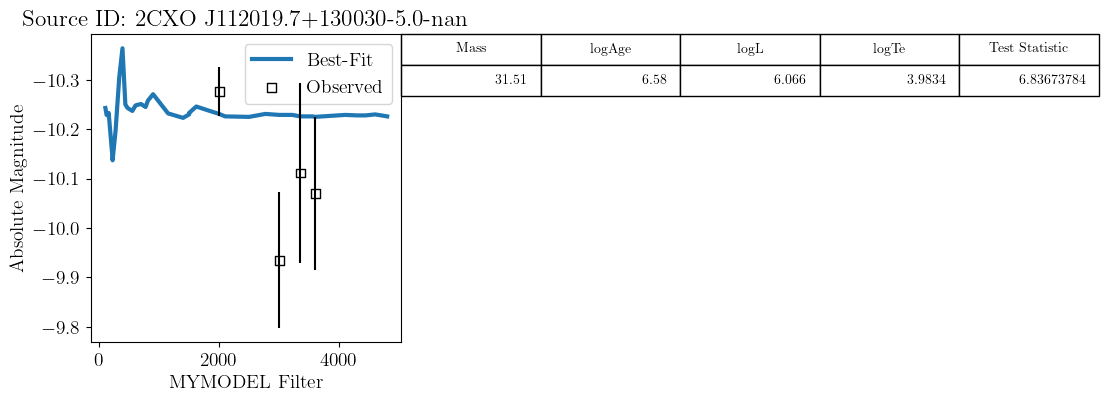

No best-fit model available for Source ID 2CXO J112019.7+130030-6.0-nan.
No best-fit model available for Source ID 2CXO J112019.7+130030-7.0-nan.


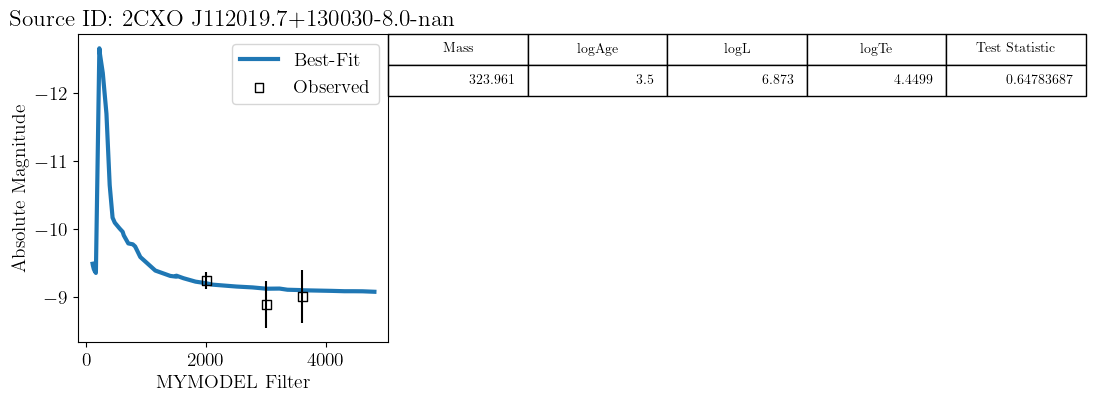

No best-fit model available for Source ID 2CXO J112015.9+125727-1.0-nan.


In [19]:
tempfit = FitSED(
    df=M66_xrbs,
    instrument='MyModel',
    input_model=M66_dir+'XRB-ejection/wfc3_nircam_models_0.02.txt',
    idheader='Auxiliary ID',
    plotSED=True
)

In [20]:
tempfit['Age'] = 10 ** tempfit['logAge'].values * u.yr.to(u.Myr)
tempfit

Zini       MH  logAge        Mini   int_IMF     Mass   logL   logTe  \
0    0.0152  0.01508    8.14    4.666412  2.612200    4.445  4.307  3.5033   
1    0.0152  0.01508    7.24   12.739693  2.628047   12.486  4.590  3.5969   
2    0.0152  0.01508    3.58  350.029175  2.633619  280.863  6.869  4.4246   
3    0.0152  0.01508    7.88    5.973853  2.618171    5.750  4.478  3.5074   
4    0.0152  0.01508    7.12   15.399844  2.629334   14.402  4.810  3.6434   
..      ...      ...     ...         ...       ...      ...    ...     ...   
177  0.0152  0.01508    6.84   27.632059  2.631785   21.346  5.562  3.5319   
178  0.0152  0.01508    6.84   27.632059  2.631785   21.346  5.562  3.5319   
179  0.0152  0.01508    6.84   27.632059  2.631785   21.346  5.562  3.5319   
180  0.0152  0.01508    6.84   27.632059  2.631785   21.346  5.562  3.5319   
181  0.0152  0.01508    3.50  350.025391  2.633619  323.961  6.873  4.4499   

      logg label  McoreTP    C_O  period0  period1  period2  period3  period4  \
0   -0.256     8    0.837  0.400   404.49   198.14   124.45    95.21    78.70   
1    0.284     6    0.000  0.395     0.00     0.00     0.00     0.00     0.00   
2    2.668     0    0.000  1.046     0.00     0.00     0.00     0.00     0.00   
3   -0.299     7    0.000  0.372   458.03   228.79   143.60   109.06    90.36   
4    0.312     3    0.000  0.399   202.52    95.93    63.91    46.33    38.58   
..     ...   ...      ...    ...      ...      ...      ...      ...      ...   
177 -0.715     3    0.000  0.330  1239.08   679.76   418.37   307.71   258.17   
178 -0.715     3    0.000  0.330  1239.08   679.76   418.37   307.71   258.17   
179 -0.715     3    0.000  0.330  1239.08   679.76   418.37   307.71   258.17   
180 -0.715     3    0.000  0.330  1239.08   679.76   418.37   307.71   258.17   
181  2.827     0    0.000  0.318     0.00     0.00     0.00     0.00     0.00   

    pmode         Mloss  tau1m       X       Y        Xc        Xn        Xo  \
0       0 -3.850000e-06   0.12  0.6272  0.3574  0.001644  0.003176  0.005485   
1      -1 -1.640000e-21   0.00  0.6794  0.3052  0.001721  0.002668  0.005806   
2      -1 -2.350000e-12   0.00  0.4901  0.4949  0.000880  0.007041  0.002044   
3       0 -9.090000e-06   0.23  0.6025  0.3822  0.001461  0.003460  0.005230   
4       3 -8.870000e-07   0.00  0.6643  0.3204  0.001657  0.003001  0.005533   
..    ...           ...    ...     ...     ...       ...       ...       ...   
177     0 -1.800000e-05   0.00  0.5677  0.4171  0.000944  0.005384  0.003804   
178     0 -1.800000e-05   0.00  0.5677  0.4171  0.000944  0.005384  0.003804   
179     0 -1.800000e-05   0.00  0.5677  0.4171  0.000944  0.005384  0.003804   
180     0 -1.800000e-05   0.00  0.5677  0.4171  0.000944  0.005384  0.003804   
181    -1 -1.940000e-11   0.00  0.6543  0.3306  0.000773  0.006991  0.002232   

     Cexcess        Z  mbol_x   F218W   F225W   F275W   F336W   F390W   F438W  \
0       -1.0  0.01532  -5.996   5.422   4.682   5.427   1.831   0.772   0.597   
1       -1.0  0.01537  -6.704   2.197   2.126   2.227  -1.397  -2.764  -3.706   
2       -1.0  0.01502 -12.402 -12.914 -12.802 -12.409 -11.754 -10.652 -10.155   
3       -1.0  0.01531  -6.425   5.364   4.669   5.537   2.038   0.794   0.449   
4       -1.0  0.01530  -7.254   0.965   1.173   0.576  -3.305  -4.238  -5.025   
..       ...      ...     ...     ...     ...     ...     ...     ...     ...   
177     -1.0  0.01523  -9.135   1.060   0.385   1.096  -2.041  -3.536  -4.166   
178     -1.0  0.01523  -9.135   1.060   0.385   1.096  -2.041  -3.536  -4.166   
179     -1.0  0.01523  -9.135   1.060   0.385   1.096  -2.041  -3.536  -4.166   
180     -1.0  0.01523  -9.135   1.060   0.385   1.096  -2.041  -3.536  -4.166   
181     -1.0  0.01508 -12.412 -12.661 -12.592 -12.297 -11.698 -10.648 -10.170   

      F475W   F555W  F606W  F625W  F775W  F814W   F105W   F110W   F125W  \
0    -0.014  -0.680 -1.658 -2.023 -4.787 -5.231  -7.114  -7.489  -7.880   
1    -4.728  

In [21]:
tempfit.query('8 >= Age >= 3')

Zini       MH  logAge        Mini   int_IMF    Mass   logL   logTe  \
5    0.0152  0.01508    6.70   37.419582  2.632486  31.457  5.626  3.8804   
19   0.0152  0.01508    6.86   25.457273  2.631543  22.131  5.354  3.5583   
20   0.0152  0.01508    6.52   77.530762  2.633375  46.009  6.179  4.1066   
31   0.0152  0.01508    6.88   23.182848  2.631233  22.278  5.216  3.5819   
44   0.0152  0.01508    6.60   54.083511  2.633039  28.841  6.015  3.9698   
45   0.0152  0.01508    6.48   95.611313  2.633509  56.589  6.322  4.1652   
46   0.0152  0.01508    6.86   24.249968  2.631387  23.162  5.266  3.5662   
55   0.0152  0.01508    6.54   69.996262  2.633295  40.809  6.126  3.9755   
56   0.0152  0.01508    6.52   77.535194  2.633375  45.958  6.181  3.9942   
64   0.0152  0.01508    6.60   53.751514  2.633031  31.462  5.930  3.9497   
65   0.0152  0.01508    6.50   86.446579  2.633449  48.295  6.295  4.1780   
66   0.0152  0.01508    6.50   86.446579  2.633449  48.295  6.295  4.1780   
67   0.0152  0.01508    6.88   25.039473  2.631491  20.489  5.485  3.5310   
72   0.0152  0.01508    6.48   95.611313  2.633509  56.589  6.322  4.1652   
74   0.0152  0.01508    6.48   95.971107  2.633511  54.379  6.349  4.1795   
76   0.0152  0.01508    6.52   77.964279  2.633379  43.042  6.237  4.1122   
78   0.0152  0.01508    6.50   86.365433  2.633449  48.738  6.291  4.0070   
81   0.0152  0.01508    6.60   54.082336  2.633039  28.855  6.015  3.9586   
82   0.0152  0.01508    6.52   77.964279  2.633379  43.042  6.237  4.1122   
84   0.0152  0.01508    6.48   95.971107  2.633511  54.379  6.349  4.1795   
88   0.0152  0.01508    6.52   77.964279  2.633379  43.042  6.237  4.1122   
90   0.0152  0.01508    6.88   23.175455  2.631232  22.281  5.182  3.6569   
97   0.0152  0.01508    6.86   26.303152  2.631642  20.913  5.521  3.5316   
98   0.0152  0.01508    6.48   95.971107  2.633511  54.379  6.349  4.1795   
101  0.0152  0.01508    6.60   54.084572  2.633039  28.829  6.015  3.9799   
103  0.0152  0.01508    6.86   24.203568  2.631380  23.196  5.279  4.3321   
105  0.0152  0.01508    6.72   37.144974  2.632472  23.520  5.712  3.9216   
108  0.0152  0.01508    6.84   27.552694  2.631777  21.475  5.425  3.5476   
112  0.0152  0.01508    6.52   77.936844  2.633379  43.206  6.233  3.9336   
118  0.0152  0.01508    6.70   38.643616  2.632546  26.005  5.761  3.6687   
122  0.0152  0.01508    6.84   27.632059  2.631785  21.346  5.562  3.5319   
124  0.0152  0.01508    6.84   27.632059  2.631785  21.346  5.562  3.5319   
126  0.0152  0.01508    6.48   95.621307  2.633509  56.554  6.324  4.1505   
127  0.0152  0.01508    6.50   85.922897  2.633445  51.705  6.243  4.1063   
132  0.0152  0.01508    6.84   27.632059  2.631785  21.346  5.562  3.5319   
134  0.0152  0.01508    6.84   27.632059  2.631785  21.346  5.562  3.5319   
137  0.0152  0.01508    6.84   27.632059  2.631785  21.346  5.562  3.5319   
141  0.0152  0.01508    6.84   25.440298  2.631541  24.094  5.298  3.7281   
142  0.0152  0.01508    6.52   77.535194  2.633375  45.958  6.181  3.9942   
145  0.0152  0.01508    6.58   58.720505  2.633130  31.510  6.066  3.9834   
150  0.0152  0.01508    6.90   22.185638  2.631074  21.425  5.128  3.7145   
152  0.0152  0.01508    6.86   24.228313  2.631384  23.172  5.252  3.7505   
157  0.0152  0.01508    6.68   40.000000  2.632607  31.619  5.783  3.6220   
158  0.0152  0.01508    6.68   40.000000  2.632607  31.619  5.783  3.6220   
164  0.0152  0.01508    6.84   25.438768  2.631540  24.096  5.309  3.7766   
165  0.0152  0.01508    6.72   35.124901  2.632362  30.874  5.551  3.7024   
166  0.0152  0.01508    6.82   26.711044  2.631688  25.056  5.355  3.7624   
167  0.0152  0.01508    6.88   23.171177  2.631231  22.284  5.210  3.7934   
169  0.0152  0.01508    6.84   27.632059  2.631785  21.346  5.562  3.5319   
170  0.0152  0.01508    6.84   27.632059  2.631785  21.346  5.562  3.5319   
171  0.0152  0.01508    6.50  110.341965  2.633582  35.169  6.261  5.3189   
172

In [22]:
tempfit.to_csv(M66_dir+"XRB-ejection/M66_XRB_hst_jwst_sed_fitting.txt")

# Finding the most likely parent cluster

I am going to use the cluster catalog shared with me by Qiana and not the ones available on PHANGS' websites. They are all over the place. 

## Investigate the cluster catalog

In [23]:
M66_xrbs = remove_unnamed(pd.read_csv(M66_dir+'XRB-ejection/M66_hst_jwst_xrbs_photometry.csv'))
M66_xrbs

JWST RA   JWST Dec  JWST ID  HST ID  F2000W ID  F3000M ID  F3350M ID  \
0    170.062313  12.992598      1.0     2.0   194701.0    45185.0        NaN   
1    170.062307  12.992623      3.0     2.0   194908.0    45185.0        NaN   
2    170.062255  12.992622      4.0     2.0   194909.0        NaN        NaN   
3    170.062808  12.993437      2.0     1.0   200852.0    46417.0    42593.0   
4    170.062752  12.993454      3.0     1.0   201035.0    46417.0    42593.0   
..          ...        ...      ...     ...        ...        ...        ...   
287  170.082249  13.008335      5.0     NaN   301712.0    68734.0    63775.0   
288  170.082391  13.008383      6.0     NaN   301987.0        NaN        NaN   
289  170.082184  13.008461      7.0     NaN   302409.0        NaN        NaN   
290  170.082296  13.008542      8.0     NaN   302771.0    69003.0        NaN   
291  170.066405  12.957754      1.0     NaN    20630.0        NaN        NaN   

     F3600M ID       JWST X       JWST Y                 CSC ID        HST X  \
0          NaN  3104.574104  5904.817673  2CXO J112014.9+125933  3743.843919   
1          NaN  3105.251503  5907.752641  2CXO J112014.9+125933  3743.843919   
2          NaN  3111.115373  5907.603774  2CXO J112014.9+125933  3743.843919   
3      48557.0  3048.131145  6003.004427  2CXO J112015.0+125936  3700.317585   
4          NaN  3054.473615  6004.938353  2CXO J112015.0+125936  3700.317585   
..         ...          ...          ...                    ...          ...   
287    71929.0   830.290481  7747.193740  2CXO J112019.7+130030          NaN   
288        NaN   814.097221  7752.830980  2CXO J112019.7+130030          NaN   
289        NaN   837.798846  7761.938022  2CXO J112019.7+130030          NaN   
290    72216.0   825.021184  7771.420423  2CXO J112019.7+130030          NaN   
291        NaN  2637.804107  1825.304918  2CXO J112015.9+125727          NaN   

           HST Y  F555W ID  F275W ID  F336W ID  F438W ID  F814W ID  \
0    5833.507868   19247.0  130956.0       NaN   36055.0       NaN   
1    5833.507868   19247.0  130956.0       NaN   36055.0       NaN   
2    5833.507868   19247.0  130956.0       NaN   36055.0       NaN   
3    5908.701948   19792.0       NaN       NaN   36916.0       NaN   
4    5908.701948   19792.0       NaN       NaN   36916.0       NaN   
..           ...       ...       ...       ...       ...       ...   
287          NaN       NaN       NaN       NaN       NaN       NaN   
288          NaN       NaN       NaN       NaN       NaN       NaN   
289          NaN       NaN       NaN       NaN       NaN       NaN   
290          NaN       NaN       NaN       NaN       NaN       NaN   
291          NaN       NaN       NaN       NaN       NaN       NaN   

         HST RA    HST Dec     F2000W  F2000W Err     F3000M  F3000M Err  \
0    170.062292  12.992626 -12.148228   -0.925911 -13.902257   -0.287522   
1    170.062292  12.992626 -12.159049   -0.904646 -13.902257   -0.287522   
2    170.062292  12.992626 -12.268460   -0.794376        NaN         NaN   
3    170.062784  12.993454        NaN  184.978557 -11.584072   -1.756274   
4    170.062784  12.993454  -8.534081  -14.801952 -11.584072   -1.756274   
..          ...        ...        ...         ...        ...         ...   
287         NaN        NaN -10.276548   -0.049398  -9.934312   -0.137687   
288         NaN        NaN  -9.018021   -0.152134        NaN         NaN   
289         NaN        NaN  -8.606931   -0.232199        NaN         NaN   
290         NaN        NaN  -9.248247   -0.124495  -8.887121   -0.344165   
291         NaN        NaN  -9.351721   -0.158024        NaN         NaN   

        F3350M  F3350M Err     F3600M  F3600M Err     F275W  F275W Err  F336W  \
0          NaN         NaN        NaN         NaN -2.974469  -1.372681    NaN   
1          NaN         NaN        NaN         NaN -2.974469  -1.372681    NaN   
2          NaN         NaN        NaN         NaN -2.974469  -1.372681    NaN   
3   -12.

In [24]:
clustercat = pd.read_csv(M66_dir+'phangsclass12clustercandidatecatalogswithsizes/ngc3627_class12_w_sizes.csv')
ra, dec = clustercat['PHANGS_RA'].values, clustercat['PHANGS_DEC'].values
fk5 = SkyCoord(ra=ra, dec=dec, unit='deg', frame='icrs').transform_to(FK5)
ra_fk5, dec_fk5 = fk5.ra.deg, fk5.dec.deg
clustercat['RA'] = ra
clustercat['Dec'] = dec
 
clustercat

ID_PHANGS_CLUSTERS  PHANGS_X  PHANGS_Y   PHANGS_RA  PHANGS_DEC  \
0                     14   6614.89   3239.51  170.066136   12.939566   
1                     46   7284.40   3396.34  170.058575   12.941292   
2                     55   6620.99   3457.63  170.066067   12.941966   
3                     68   6698.34   3482.21  170.065193   12.942237   
4                     90   6745.89   3520.91  170.064656   12.942663   
...                  ...       ...       ...         ...         ...   
2707               10668   6508.61  10905.57  170.067338   13.023935   
2708               10670   5445.22  11002.79  170.079350   13.025004   
2709               10671   5461.06  11051.32  170.079171   13.025538   
2710               10672   5442.73  11130.65  170.079378   13.026411   
2711               10673   5495.42  11151.45  170.078783   13.026640   

      PHANGS_CLUSTER_CLASS_HUMAN  PHANGS_CLUSTER_CLASS_ML_VGG  \
0                            1.0                          2.0   
1                            1.0                          1.0   
2                            1.0                          1.0   
3                            1.0                          1.0   
4                            1.0                          1.0   
...                          ...                          ...   
2707                         NaN                          1.0   
2708                         NaN                          1.0   
2709                         NaN                          1.0   
2710                         NaN                          2.0   
2711                         NaN                          1.0   

      PHANGS_CLUSTER_CLASS_ML_VGG_QUAL  PHANGS_F275W_VEGA_TOT  \
0                                  0.9              20.644782   
1                                  0.8              24.105332   
2                                  1.0              22.281919   
3                                  1.0              20.826262   
4                                  1.0              22.925218   
...                                ...                    ...   
2707                               1.0                    NaN   
2708                               1.0              24.172877   
2709                               0.9              24.396912   
2710                               0.7                    NaN   
2711                               1.0              23.661047   

      PHANGS_F275W_VEGA_TOT_ERR  PHANGS_F336W_VEGA_TOT  \
0                      0.026597              20.939790   
1                      0.370370              22.714208   
2                      0.077378              22.221694   
3                      0.026111              20.815261   
4                      0.134522              22.279132   
...                         ...                    ...   
2707                        NaN                    NaN   
2708                   0.408993              23.587548   
2709                   0.497328              23.977649   
2710                        NaN              24.611067   
2711                   0.269806              23.939840   

      PHANGS_F336W_VEGA_TOT_ERR  PHANGS_F438W_VEGA_TOT  \
0                      0.030189              22.250655   
1                      0.089647              22.519652   
2                      0.061685              22.469884   
3                      0.022290              21.009604   
4                      0.066309              22.105465   
...                         ...                    ...   
2707                        NaN              24.600853   
2708                   0.189895              23.884824   
2709                   0.267604              24.190537   
2710                   0.525090              24.173930   
2711                   0.255666              23.551730   

      PHANGS_F438W_VEGA_TOT_ERR  PHANGS_F555W_VEGA_TOT  \
0                      0.031346              22.278594   
1                      0.027672              21.668955   
2          

In [25]:
WriteReg(
    sources=clustercat,
    coordheads=['RA', 'Dec'],
    coordsys='fk5',
    radius=0.3,#clustercat['r_eff(arcsec)'].tolist(),
    radunit='arcsec',
    idheader='ID_PHANGS_CLUSTERS',
    outfile=M66_dir+'phangsclass12clustercandidatecatalogswithsizes/M66_phangs_cluster_catalog_fk5.reg'
)

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/phangsclass12clustercandidatecatalogswithsizes/M66_phangs_cluster_catalog_fk5.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/phangsclass12clustercandidatecatalogswithsizes/M66_phangs_cluster_catalog_fk5.reg saved!


## Find distances between XRBs and Clusters

In [26]:
M66_xrbs = remove_unnamed(pd.read_csv(M66_dir+'XRB-ejection/M66_hst_jwst_xrbs_photometry.csv'))
M66_best = remove_unnamed(pd.read_csv(chandra_hst_dir+'M66_csc_bestrads.frame'))

In [27]:
temp = M66_best[['CSC ID', 'RA', 'Dec', '2Sig', '2Sig (pix)']]
temp = temp.rename(columns={
    'RA'         : 'CSC RA',
    'Dec'        : 'CSC Dec',
    '2Sig'       : '2 Sig (arcsec)',
    '2Sig (pix)' : '2 Sig (pix)'
})
M66_xrbs = M66_xrbs.merge(temp, on='CSC ID', how='left')
M66_xrbs

JWST RA   JWST Dec  JWST ID  HST ID  F2000W ID  F3000M ID  F3350M ID  \
0    170.062313  12.992598      1.0     2.0   194701.0    45185.0        NaN   
1    170.062307  12.992623      3.0     2.0   194908.0    45185.0        NaN   
2    170.062255  12.992622      4.0     2.0   194909.0        NaN        NaN   
3    170.062808  12.993437      2.0     1.0   200852.0    46417.0    42593.0   
4    170.062752  12.993454      3.0     1.0   201035.0    46417.0    42593.0   
..          ...        ...      ...     ...        ...        ...        ...   
287  170.082249  13.008335      5.0     NaN   301712.0    68734.0    63775.0   
288  170.082391  13.008383      6.0     NaN   301987.0        NaN        NaN   
289  170.082184  13.008461      7.0     NaN   302409.0        NaN        NaN   
290  170.082296  13.008542      8.0     NaN   302771.0    69003.0        NaN   
291  170.066405  12.957754      1.0     NaN    20630.0        NaN        NaN   

     F3600M ID       JWST X       JWST Y                 CSC ID        HST X  \
0          NaN  3104.574104  5904.817673  2CXO J112014.9+125933  3743.843919   
1          NaN  3105.251503  5907.752641  2CXO J112014.9+125933  3743.843919   
2          NaN  3111.115373  5907.603774  2CXO J112014.9+125933  3743.843919   
3      48557.0  3048.131145  6003.004427  2CXO J112015.0+125936  3700.317585   
4          NaN  3054.473615  6004.938353  2CXO J112015.0+125936  3700.317585   
..         ...          ...          ...                    ...          ...   
287    71929.0   830.290481  7747.193740  2CXO J112019.7+130030          NaN   
288        NaN   814.097221  7752.830980  2CXO J112019.7+130030          NaN   
289        NaN   837.798846  7761.938022  2CXO J112019.7+130030          NaN   
290    72216.0   825.021184  7771.420423  2CXO J112019.7+130030          NaN   
291        NaN  2637.804107  1825.304918  2CXO J112015.9+125727          NaN   

           HST Y  F555W ID  F275W ID  F336W ID  F438W ID  F814W ID  \
0    5833.507868   19247.0  130956.0       NaN   36055.0       NaN   
1    5833.507868   19247.0  130956.0       NaN   36055.0       NaN   
2    5833.507868   19247.0  130956.0       NaN   36055.0       NaN   
3    5908.701948   19792.0       NaN       NaN   36916.0       NaN   
4    5908.701948   19792.0       NaN       NaN   36916.0       NaN   
..           ...       ...       ...       ...       ...       ...   
287          NaN       NaN       NaN       NaN       NaN       NaN   
288          NaN       NaN       NaN       NaN       NaN       NaN   
289          NaN       NaN       NaN       NaN       NaN       NaN   
290          NaN       NaN       NaN       NaN       NaN       NaN   
291          NaN       NaN       NaN       NaN       NaN       NaN   

         HST RA    HST Dec     F2000W  F2000W Err     F3000M  F3000M Err  \
0    170.062292  12.992626 -12.148228   -0.925911 -13.902257   -0.287522   
1    170.062292  12.992626 -12.159049   -0.904646 -13.902257   -0.287522   
2    170.062292  12.992626 -12.268460   -0.794376        NaN         NaN   
3    170.062784  12.993454        NaN  184.978557 -11.584072   -1.756274   
4    170.062784  12.993454  -8.534081  -14.801952 -11.584072   -1.756274   
..          ...        ...        ...         ...        ...         ...   
287         NaN        NaN -10.276548   -0.049398  -9.934312   -0.137687   
288         NaN        NaN  -9.018021   -0.152134        NaN         NaN   
289         NaN        NaN  -8.606931   -0.232199        NaN         NaN   
290         NaN        NaN  -9.248247   -0.124495  -8.887121   -0.344165   
291         NaN        NaN  -9.351721   -0.158024        NaN         NaN   

        F3350M  F3350M Err     F3600M  F3600M Err     F275W  F275W Err  F336W  \
0          NaN         NaN        NaN         NaN -2.974469  -1.372681    NaN   
1          NaN         NaN        NaN         NaN -2.974469  -1.372681    NaN   
2          NaN         NaN        NaN         NaN -2.974469  -1.372681    NaN   
3   -12.

In [28]:
search_radius = 1000 / (3600 * 45.4)
print(f"Using search radius : {search_radius}")

Using search radius : 0.006118453255017132


In [29]:
region = M66_dir+'phangsclass12clustercandidatecatalogswithsizes/M66_phangs_cluster_catalog_fk5.reg'
catalog = 'Cluster'
search_radius = search_radius

distances = calculate_distance(
    df=M66_xrbs,
    regions=region,
    catalogs=catalog,
    imagefilename=f555w,
    search_radius=search_radius,
    coordsys='fk5',
    coordheads=['CSC RA', 'CSC Dec'],
    instrument='wfc3',
    sourceid='Auxiliary ID'
)
distances

Finding cross-references between sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...
Crossrefing done...
Done! Calculated Distances...


CSC RA    CSC Dec                   Auxiliary ID Cluster ID  \
0      170.062259  12.992633  2CXO J112014.9+125933-1.0-2.0       6740   
1      170.062259  12.992633  2CXO J112014.9+125933-1.0-2.0       6788   
2      170.062259  12.992633  2CXO J112014.9+125933-1.0-2.0       6969   
3      170.062259  12.992633  2CXO J112014.9+125933-1.0-2.0       7009   
4      170.062259  12.992633  2CXO J112014.9+125933-1.0-2.0       7020   
...           ...        ...                            ...        ...   
27619  170.066456   12.95771  2CXO J112015.9+125727-1.0-nan       1261   
27620  170.066456   12.95771  2CXO J112015.9+125727-1.0-nan       1264   
27621  170.066456   12.95771  2CXO J112015.9+125727-1.0-nan       1286   
27622  170.066456   12.95771  2CXO J112015.9+125727-1.0-nan       1372   
27623  170.066456   12.95771  2CXO J112015.9+125727-1.0-nan       1382   

          JWST RA   JWST Dec JWST ID HST ID F2000W ID F3000M ID F3350M ID  \
0      170.062313  12.992598     1.0    2.0  194701.0   45185.0       nan   
1      170.062313  12.992598     1.0    2.0  194701.0   45185.0       nan   
2      170.062313  12.992598     1.0    2.0  194701.0   45185.0       nan   
3      170.062313  12.992598     1.0    2.0  194701.0   45185.0       nan   
4      170.062313  12.992598     1.0    2.0  194701.0   45185.0       nan   
...           ...        ...     ...    ...       ...       ...       ...   
27619  170.066405  12.957754     1.0    nan   20630.0       nan       nan   
27620  170.066405  12.957754     1.0    nan   20630.0       nan       nan   
27621  170.066405  12.957754     1.0    nan   20630.0       nan       nan   
27622  170.066405  12.957754     1.0    nan   20630.0       nan       nan   
27623  170.066405  12.957754     1.0    nan   20630.0       nan       nan   

      F3600M ID       JWST X       JWST Y                 CSC ID        HST X  \
0           nan  3104.574104  5904.817673  2CXO J112014.9+125933  3743.843919   
1           nan  3104.574104  5904.817673  2CXO J112014.9+125933  3743.843919   
2           nan  3104.574104  5904.817673  2CXO J112014.9+125933  3743.843919   
3           nan  3104.574104  5904.817673  2CXO J112014.9+125933  3743.843919   
4           nan  3104.574104  5904.817673  2CXO J112014.9+125933  3743.843919   
...         ...          ...          ...                    ...          ...   
27619       nan  2637.804107  1825.304918  2CXO J112015.9+125727          nan   
27620       nan  2637.804107  1825.304918  2CXO J112015.9+125727          nan   
27621       nan  2637.804107  1825.304918  2CXO J112015.9+125727          nan   
27622       nan  2637.804107  1825.304918  2CXO J112015.9+125727          nan   
27623       nan  2637.804107  1825.304918  2CXO J112015.9+125727          nan   

             HST Y F555W ID  F275W ID F336W ID F438W ID F814W ID      HST RA  \
0      5833.507868  19247.0  130956.0      nan  36055.0      nan  170.062292   
1      5833.507868  19247.0  130956.0      nan  36055.0      nan  170.062292   
2      5833.507868  19247.0  130956.0      nan  36055.0      nan  170.062292   
3      5833.507868  19247.0  130956.0      nan  36055.0      nan  170.062292   
4      5833.507868  19247.0  130956.0      nan  36055.0      nan  170.062292   
...            ...      ...       ...      ...      ...      ...         ...   
27619          nan      nan       nan      nan      nan      nan         nan   
27620          nan      nan       nan      nan      nan      nan         nan   
27621          nan      nan       nan      nan      nan      nan         nan   
27622          nan      nan       nan      nan      nan      nan         nan   
27623          nan      nan       nan      nan      nan      nan         nan   

         HST Dec     F2000W F2000W Err     F3000M F3000M Err F3350M  \
0      12.992626 -12.148228  -0.925911 -13.902257  -0.287522    nan   
1      12.992626 -12.148228  -0.925911 -13.902257  -0.287522    nan   
2      12.992626 -12.148228  -0.925911 -13.902257 

In [30]:
distances.to_csv(M66_dir+'XRB-ejection/M66_cluster_distances.txt')

In [31]:
distances = remove_unnamed(pd.read_csv(M66_dir+'XRB-ejection/M66_cluster_distances.txt'))

In [32]:
# add the cluster masses, ages and info to the main dataframe
temp = clustercat[[
    'ID_PHANGS_CLUSTERS',
    'PHANGS_CI', 
    'PHANGS_AGE_MINCHISQ',
    'PHANGS_AGE_MINCHISQ_ERR', 
    'PHANGS_MASS_MINCHISQ',
    'PHANGS_MASS_MINCHISQ_ERR', 
    'PHANGS_EBV_MINCHISQ',
    'PHANGS_EBV_MINCHISQ_ERR', 
    'PHANGS_REDUCED_MINCHISQ',
    'fwhm', 'r_eff(pix)', 
    'r_eff(arcsec)', 'r_eff(pc)'
]] 
temp = temp.rename(columns={
    'ID_PHANGS_CLUSTERS'       : 'Cluster ID',
    'RA': 'Cluster RA', 'Dec' : 'Cluster Dec',
    'PHANGS_CI'                : 'Cluster CI',
    'PHANGS_AGE_MINCHISQ'      : 'Cluster Age (Myr)',
    'PHANGS_AGE_MINCHISQ_ERR'  : 'Cluster Age Err (Myr)',
    'PHANGS_MASS_MINCHISQ'     : 'Cluster Mass (M_sun)',
    'PHANGS_MASS_MINCHISQ_ERR' : 'Cluster Mass Err (M_sun)',
    'PHANGS_EBV_MINCHISQ'      : 'Cluster EBV',
    'PHANGS_EBV_MINCHISQ_ERR'  : 'Cluster EBV Err',
    'PHANGS_REDUCED_MINCHISQ'  : 'Cluster Test Statistic',
    'fwhm'                     : 'Cluster FWHM',
    'r_eff(pix)'               : 'Cluster Radius Eff (pix)',
    'r_eff(arcsec)'            : 'Cluster Radius Eff (arcsec)',
    'r_eff(pc)'                : 'Cluster Radius Eff (pc)'
})
distances = distances.merge(temp, on='Cluster ID', how='left')
distances

CSC RA    CSC Dec                   Auxiliary ID  Cluster ID  \
0      170.062259  12.992633  2CXO J112014.9+125933-1.0-2.0        6740   
1      170.062259  12.992633  2CXO J112014.9+125933-1.0-2.0        6788   
2      170.062259  12.992633  2CXO J112014.9+125933-1.0-2.0        6969   
3      170.062259  12.992633  2CXO J112014.9+125933-1.0-2.0        7009   
4      170.062259  12.992633  2CXO J112014.9+125933-1.0-2.0        7020   
...           ...        ...                            ...         ...   
27619  170.066456  12.957710  2CXO J112015.9+125727-1.0-nan        1261   
27620  170.066456  12.957710  2CXO J112015.9+125727-1.0-nan        1264   
27621  170.066456  12.957710  2CXO J112015.9+125727-1.0-nan        1286   
27622  170.066456  12.957710  2CXO J112015.9+125727-1.0-nan        1372   
27623  170.066456  12.957710  2CXO J112015.9+125727-1.0-nan        1382   

          JWST RA   JWST Dec  JWST ID  HST ID  F2000W ID  F3000M ID  \
0      170.062313  12.992598      1.0     2.0   194701.0    45185.0   
1      170.062313  12.992598      1.0     2.0   194701.0    45185.0   
2      170.062313  12.992598      1.0     2.0   194701.0    45185.0   
3      170.062313  12.992598      1.0     2.0   194701.0    45185.0   
4      170.062313  12.992598      1.0     2.0   194701.0    45185.0   
...           ...        ...      ...     ...        ...        ...   
27619  170.066405  12.957754      1.0     NaN    20630.0        NaN   
27620  170.066405  12.957754      1.0     NaN    20630.0        NaN   
27621  170.066405  12.957754      1.0     NaN    20630.0        NaN   
27622  170.066405  12.957754      1.0     NaN    20630.0        NaN   
27623  170.066405  12.957754      1.0     NaN    20630.0        NaN   

       F3350M ID  F3600M ID       JWST X       JWST Y                 CSC ID  \
0            NaN        NaN  3104.574104  5904.817673  2CXO J112014.9+125933   
1            NaN        NaN  3104.574104  5904.817673  2CXO J112014.9+125933   
2            NaN        NaN  3104.574104  5904.817673  2CXO J112014.9+125933   
3            NaN        NaN  3104.574104  5904.817673  2CXO J112014.9+125933   
4            NaN        NaN  3104.574104  5904.817673  2CXO J112014.9+125933   
...          ...        ...          ...          ...                    ...   
27619        NaN        NaN  2637.804107  1825.304918  2CXO J112015.9+125727   
27620        NaN        NaN  2637.804107  1825.304918  2CXO J112015.9+125727   
27621        NaN        NaN  2637.804107  1825.304918  2CXO J112015.9+125727   
27622        NaN        NaN  2637.804107  1825.304918  2CXO J112015.9+125727   
27623        NaN        NaN  2637.804107  1825.304918  2CXO J112015.9+125727   

             HST X        HST Y  F555W ID  F275W ID  F336W ID  F438W ID  \
0      3743.843919  5833.507868   19247.0  130956.0       NaN   36055.0   
1      3743.843919  5833.507868   19247.0  130956.0       NaN   36055.0   
2      3743.843919  5833.507868   19247.0  130956.0       NaN   36055.0   
3      3743.843919  5833.507868   19247.0  130956.0       NaN   36055.0   
4      3743.843919  5833.507868   19247.0  130956.0       NaN   36055.0   
...            ...          ...       ...       ...       ...       ...   
27619          NaN          NaN       NaN       NaN       NaN       NaN   
27620          NaN          NaN       NaN       NaN       NaN       NaN   
27621          NaN          NaN       NaN       NaN       NaN       NaN   
27622          NaN          NaN       NaN       NaN       NaN       NaN   
27623          NaN          NaN       NaN       NaN       NaN       NaN   

       F814W ID      HST RA    HST Dec     F2000W  F2000W Err     F3000M  \
0           NaN  170.062292  12.992626 -12.148228   -0.925911 -13.902257   
1           NaN  170.062292  12.992626 -12.148228   -0.925911 -13.902257   
2           NaN  170.062292  12.992626 -12.148228   -0.925911 -13.902257   
3           NaN  170.062292  12.992626 -12.148228   -0.925911 -13.902257   
4           NaN

In [33]:
# Incorporate ages and masses of the stars
best_fit = remove_unnamed(pd.read_csv(M66_dir+"XRB-ejection/M66_XRB_hst_jwst_sed_fitting.txt"))
best_fit = best_fit[['logAge', 'Mass', 'Auxiliary ID']]

logAge = best_fit['logAge'].values
age = np.exp(1) ** logAge * u.Myr
age_s = age.to(u.second)

best_fit['Star Age (s)'] = age_s
best_fit['Star Age (Myr)'] = age
best_fit['Star Mass (M_sun)'] = best_fit['Mass']

temp = best_fit[['Auxiliary ID', 'Star Mass (M_sun)', 'Star Age (s)', 'Star Age (Myr)']]
distances = distances.merge(temp, on='Auxiliary ID', how='left')
distances

CSC RA    CSC Dec                   Auxiliary ID  Cluster ID  \
0      170.062259  12.992633  2CXO J112014.9+125933-1.0-2.0        6740   
1      170.062259  12.992633  2CXO J112014.9+125933-1.0-2.0        6788   
2      170.062259  12.992633  2CXO J112014.9+125933-1.0-2.0        6969   
3      170.062259  12.992633  2CXO J112014.9+125933-1.0-2.0        7009   
4      170.062259  12.992633  2CXO J112014.9+125933-1.0-2.0        7020   
...           ...        ...                            ...         ...   
27619  170.066456  12.957710  2CXO J112015.9+125727-1.0-nan        1261   
27620  170.066456  12.957710  2CXO J112015.9+125727-1.0-nan        1264   
27621  170.066456  12.957710  2CXO J112015.9+125727-1.0-nan        1286   
27622  170.066456  12.957710  2CXO J112015.9+125727-1.0-nan        1372   
27623  170.066456  12.957710  2CXO J112015.9+125727-1.0-nan        1382   

          JWST RA   JWST Dec  JWST ID  HST ID  F2000W ID  F3000M ID  \
0      170.062313  12.992598      1.0     2.0   194701.0    45185.0   
1      170.062313  12.992598      1.0     2.0   194701.0    45185.0   
2      170.062313  12.992598      1.0     2.0   194701.0    45185.0   
3      170.062313  12.992598      1.0     2.0   194701.0    45185.0   
4      170.062313  12.992598      1.0     2.0   194701.0    45185.0   
...           ...        ...      ...     ...        ...        ...   
27619  170.066405  12.957754      1.0     NaN    20630.0        NaN   
27620  170.066405  12.957754      1.0     NaN    20630.0        NaN   
27621  170.066405  12.957754      1.0     NaN    20630.0        NaN   
27622  170.066405  12.957754      1.0     NaN    20630.0        NaN   
27623  170.066405  12.957754      1.0     NaN    20630.0        NaN   

       F3350M ID  F3600M ID       JWST X       JWST Y                 CSC ID  \
0            NaN        NaN  3104.574104  5904.817673  2CXO J112014.9+125933   
1            NaN        NaN  3104.574104  5904.817673  2CXO J112014.9+125933   
2            NaN        NaN  3104.574104  5904.817673  2CXO J112014.9+125933   
3            NaN        NaN  3104.574104  5904.817673  2CXO J112014.9+125933   
4            NaN        NaN  3104.574104  5904.817673  2CXO J112014.9+125933   
...          ...        ...          ...          ...                    ...   
27619        NaN        NaN  2637.804107  1825.304918  2CXO J112015.9+125727   
27620        NaN        NaN  2637.804107  1825.304918  2CXO J112015.9+125727   
27621        NaN        NaN  2637.804107  1825.304918  2CXO J112015.9+125727   
27622        NaN        NaN  2637.804107  1825.304918  2CXO J112015.9+125727   
27623        NaN        NaN  2637.804107  1825.304918  2CXO J112015.9+125727   

             HST X        HST Y  F555W ID  F275W ID  F336W ID  F438W ID  \
0      3743.843919  5833.507868   19247.0  130956.0       NaN   36055.0   
1      3743.843919  5833.507868   19247.0  130956.0       NaN   36055.0   
2      3743.843919  5833.507868   19247.0  130956.0       NaN   36055.0   
3      3743.843919  5833.507868   19247.0  130956.0       NaN   36055.0   
4      3743.843919  5833.507868   19247.0  130956.0       NaN   36055.0   
...            ...          ...       ...       ...       ...       ...   
27619          NaN          NaN       NaN       NaN       NaN       NaN   
27620          NaN          NaN       NaN       NaN       NaN       NaN   
27621          NaN          NaN       NaN       NaN       NaN       NaN   
27622          NaN          NaN       NaN       NaN       NaN       NaN   
27623          NaN          NaN       NaN       NaN       NaN       NaN   

       F814W ID      HST RA    HST Dec     F2000W  F2000W Err     F3000M  \
0           NaN  170.062292  12.992626 -12.148228   -0.925911 -13.902257   
1           NaN  170.062292  12.992626 -12.148228   -0.925911 -13.902257   
2           NaN  170.062292  12.992626 -12.148228   -0.925911 -13.902257   
3           NaN  170.062292  12.992626 -12.148228   -0.925911 -13.902257   
4           NaN

In [34]:
clusters = distances[[
    'CSC ID','Class', 'Auxiliary ID', 'JWST ID', 'HST ID',
    'Cluster ID', 'Star Age (Myr)', 'Cluster Age (Myr)',
    'Cluster Mass (M_sun)', 'Star Mass (M_sun)',
    'Cluster Separation (arcsecs)', 'Cluster Separation (pc)',
    'Cluster Separation (km)'
]]

clusters

CSC ID Class                   Auxiliary ID  JWST ID  \
0      2CXO J112014.9+125933  HMXB  2CXO J112014.9+125933-1.0-2.0      1.0   
1      2CXO J112014.9+125933  HMXB  2CXO J112014.9+125933-1.0-2.0      1.0   
2      2CXO J112014.9+125933  HMXB  2CXO J112014.9+125933-1.0-2.0      1.0   
3      2CXO J112014.9+125933  HMXB  2CXO J112014.9+125933-1.0-2.0      1.0   
4      2CXO J112014.9+125933  HMXB  2CXO J112014.9+125933-1.0-2.0      1.0   
...                      ...   ...                            ...      ...   
27619  2CXO J112015.9+125727  HMXB  2CXO J112015.9+125727-1.0-nan      1.0   
27620  2CXO J112015.9+125727  HMXB  2CXO J112015.9+125727-1.0-nan      1.0   
27621  2CXO J112015.9+125727  HMXB  2CXO J112015.9+125727-1.0-nan      1.0   
27622  2CXO J112015.9+125727  HMXB  2CXO J112015.9+125727-1.0-nan      1.0   
27623  2CXO J112015.9+125727  HMXB  2CXO J112015.9+125727-1.0-nan      1.0   

       HST ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0         2.0        6740      796.319112                5.0   
1         2.0        6788      796.319112              890.0   
2         2.0        6969      796.319112              500.0   
3         2.0        7009      796.319112              158.0   
4         2.0        7020      796.319112              110.0   
...       ...         ...             ...                ...   
27619     NaN        1261             NaN                3.0   
27620     NaN        1264             NaN               19.0   
27621     NaN        1286             NaN               32.0   
27622     NaN        1372             NaN              136.0   
27623     NaN        1382             NaN               24.0   

       Cluster Mass (M_sun)  Star Mass (M_sun)  Cluster Separation (arcsecs)  \
0              32159.451166             31.619                     17.769856   
1             174363.656114             31.619                     16.830950   
2              69972.213290             31.619                     19.306475   
3             206060.938059             31.619                     20.444914   
4              43030.350062             31.619                     17.902603   
...                     ...                ...                           ...   
27619           5066.130858                NaN                     20.197284   
27620            909.684599                NaN                     17.466729   
27621          18996.063333                NaN                     18.243949   
27622          22451.629591                NaN                     21.720192   
27623          14859.800161                NaN                     21.656298   

       Cluster Separation (pc)  Cluster Separation (km)  
0                   808.528449             2.494858e+16  
1                   765.808229             2.363037e+16  
2                   878.444618             2.710597e+16  
3                   930.243609             2.870432e+16  
4                   814.568423             2.513496e+16  
...                        ...                      ...  
27619               918.976436             2.835665e+16  
27620               794.736191             2.452300e+16  
27621               830.099700             2.561420e+16  
27622               988.268727             3.049479e+16  
27623               985.361537             3.040508e+16  

[27624 rows x 13 columns]

## Algorithm for finding the parent cluster

1) for each CSC ID, find the sources within. 
2) Find the average of the age of the sources
3) Find clusters 1/2 of the ages above and below that age limit
4) Find clusters that are the nearest 
5) Based upon that, use that cluster as the parent cluster

In [35]:
distances = remove_unnamed(pd.read_csv(('/Users/undergradstudent/Downloads/temp_cluster.txt')))

In [36]:
distances.columns

Index(['CSC RA', 'CSC Dec', 'Auxiliary ID', 'Cluster ID', 'JWST RA',
       'JWST Dec', 'JWST ID', 'HST ID', 'F2000W ID', 'F3000M ID', 'F3350M ID',
       'F3600M ID', 'JWST X', 'JWST Y', 'CSC ID', 'HST X', 'HST Y', 'F555W ID',
       'F275W ID', 'F336W ID', 'F438W ID', 'F814W ID', 'HST RA', 'HST Dec',
       'F2000W', 'F2000W Err', 'F3000M', 'F3000M Err', 'F3350M', 'F3350M Err',
       'F3600M', 'F3600M Err', 'F275W', 'F275W Err', 'F336W', 'F336W Err',
       'F438W', 'F438W Err', 'F555W', 'F555W Err', 'F814W', 'F814W Err',
       'Class', '2 Sig (arcsec)', '2 Sig (pix)', 'Cluster RA', 'Cluster Dec',
       'Cluster Separation (arcsecs)', 'Cluster Separation (pc)',
       'Cluster Separation (km)', 'Cluster CI', 'Cluster Age (Myr)',
       'Cluster Age Err (Myr)', 'Cluster Mass (M_sun)',
       'Cluster Mass Err (M_sun)', 'Cluster EBV', 'Cluster EBV Err',
       'Cluster Test Statistic', 'Cluster FWHM', 'Cluster Radius Eff (pix)',
       'Cluster Radius Eff (arcsec)', 'Cluster Radius 

In [37]:
distances = distances[['CSC ID', 'Cluster ID', 'Star Age (Myr)', 'Cluster Age (Myr)', 'Cluster Age Err (Myr)',
                        'Cluster Separation (pc)', 'Cluster Separation (km)', '2 Sig (arcsec)', 'Class']]

In [38]:
def find_parent_cluster(df,
                        idheader='CSC ID', 
                        star_age='Star Age (Myr)', 
                        cluster_age='Cluster Age (Myr)',
                        cluster_dist='Cluster Separation (pc)',
                        cluster_id='Cluster ID',
                        lower_limit=4.75/5,
                        upper_limit=2
):
    '''An algorithm to find the parent cluster from which an X-ray binary is ejected.
    
    Finds the average star age within the 2 Sig of each X-ray source. Then from the clusters
    within the ages of [upper_limit * average star age, lower_limit * average star age], finds
    the cluster with the closest proximity.
    
    Parameters
    ----------
    df : pd.DataFrame
        Dataframe containing the CSC ID, star ages, cluster ages and the cluster separation.
    star_age, cluster_age, cluster_dist : str
        The headers containing the ages of the star and the cluster and the separation between
        the cluster and the star.
    lower_limit, upper_limit: float (4/5, 3/2)
        The range [upper limit * average star age, lower limit * average star age]
        to use for finding the clusters within the closest proximity of a star'''
    df = df.copy()
    nan_list = [] # append the sources whose average star age was nan
    no_match = [] # append the sources which did not have ages available
    cluster_candidates = pd.DataFrame()
    # Find the parent cluster for each unique X-ray source
    for id in FindUnique(df, header='CSC ID')['CSC ID'].values:
            # Find the clusters with ages approximately the average
            # of the ages of the stars within each 2 Sig
            temp = Find(df, f'{idheader} == {id}')
            avg_star_age = temp[star_age].mean()

            if np.isnan(avg_star_age):
                 print('########################################################################')
                 print("It's a Nan!")
                 nan_list.append(id)
                 print('########################################################################')
                 pass
            
            elif not np.isnan(avg_star_age):
                print(f'CSC ID : {id}')
                print(f'avg_star_age : {avg_star_age}')
                near_clusters  = temp.query(f'{upper_limit * avg_star_age} >= `{cluster_age}` >= {lower_limit * avg_star_age}')\
                                            .reset_index(drop=True)
                
                if near_clusters.empty:
                     print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
                     print(f"No Clusters with similar ages found for {id}!")
                     no_match.append(id)
                     print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')

                else:
                    # Select the cluster in the nearest proximity
                    near_clusters_dist = near_clusters[cluster_dist].tolist()
                    cluster_match = min(near_clusters_dist)
                    parent_cluster = near_clusters.query(f'`{cluster_dist}` == {cluster_match}')\
                        .reset_index(drop=True).iloc[[0]]
                    print(f'Cluster Age : {parent_cluster[cluster_age][0]}')
                    print(f'Cluster ID : {parent_cluster[cluster_id][0]}')
                    print(f'Cluster Distance : {parent_cluster[cluster_dist][0]}')
                    # Only show the average star ages against the cluster ages and separation
                    # since the separation is from the X-ray source's centroid
                    parent_cluster['Avg Star Age (Myr)'] = avg_star_age
                    # cols = [idheader, cluster_id, 'Avg Star Age (Myr)', cluster_age, cluster_dist]
                    # parent_cluster = parent_cluster[cols]
                    display(parent_cluster)
                    cluster_candidates = pd.concat([cluster_candidates, parent_cluster]).reset_index(drop=True)

            else:
                print('**********************************************************************')
                print(f'Uh oh! Something else seems to be the issue {id}')
                print('**********************************************************************')
                no_match.append(id)

    
    return cluster_candidates, no_match, nan_list

cluster_candidates, no_match, nan_list = find_parent_cluster(distances)

CSC ID : 2CXO J112014.9+125933
avg_star_age : 801.6813497331178
Cluster Age : 770.0
Cluster ID : 7388
Cluster Distance : 264.8494055282724


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112014.9+125933        7388      796.319112              770.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                  193.0               264.849406             8.172399e+15   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.235415  HMXB           801.68135

CSC ID : 2CXO J112015.0+125936
avg_star_age : 1017.8375316323792
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
No Clusters with similar ages found for 2CXO J112015.0+125936!
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
CSC ID : 2CXO J112015.0+125921
avg_star_age : 962.996713641534
Cluster Age : 1276.0
Cluster ID : 6349
Cluster Distance : 632.6499421532302


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112015.0+125921        6349      953.367067             1276.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                 1015.0               632.649942             1.952154e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.467468  HMXB          962.996714

CSC ID : 2CXO J112015.2+125921
avg_star_age : 1007.8197437311276
Cluster Age : 1276.0
Cluster ID : 6349
Cluster Distance : 639.0183682671222


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112015.2+125921        6349      953.367067             1276.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                 1015.0               639.018368             1.971805e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.375305  HMXB         1007.819744

CSC ID : 2CXO J112014.7+125937
avg_star_age : 1098.9690314893744
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
No Clusters with similar ages found for 2CXO J112014.7+125937!
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
CSC ID : 2CXO J112015.0+125938
avg_star_age : 802.970477873357
Cluster Age : 770.0
Cluster ID : 7388
Cluster Distance : 479.1320367241687


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112015.0+125938        7388       35.163197              770.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                  193.0               479.132037             1.478447e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.343588  HMXB          802.970478

CSC ID : 2CXO J112015.3+125944
avg_star_age : 2751.7710457300195
Cluster Age : 2623.0
Cluster ID : 7496
Cluster Distance : 841.2732342950444


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112015.3+125944        7496     2751.771046             2623.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                 9282.0               841.273234             2.595898e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.346187  HMXB         2751.771046

CSC ID : 2CXO J112013.5+125944
avg_star_age : 1008.1227702786138
Cluster Age : 1276.0
Cluster ID : 8389
Cluster Distance : 614.897293795516


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112013.5+125944        8389     1074.918367             1276.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                 1050.0               614.897294             1.897375e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.303917  HMXB          1008.12277

CSC ID : 2CXO J112012.8+125947
avg_star_age : 1164.445165772804
Cluster Age : 1276.0
Cluster ID : 8527
Cluster Distance : 699.7314491116496


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112012.8+125947        8527     1164.445166             1276.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                  448.0               699.731449             2.159146e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.277362  HMXB         1164.445166

CSC ID : 2CXO J112016.8+125959
avg_star_age : 866.7700170589474
Cluster Age : 1105.0
Cluster ID : 8276
Cluster Distance : 629.7971985732844


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112016.8+125959        8276     1032.770215             1105.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                 1017.0               629.797199             1.943351e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.502163  HMXB          866.770017

CSC ID : 2CXO J112018.8+125924
avg_star_age : 598.9475529920376
Cluster Age : 717.0
Cluster ID : 7619
Cluster Distance : 390.167136564189


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112018.8+125924        7619     1164.445166              717.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                  252.0               390.167137             1.203930e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.478708  HMXB          598.947553

CSC ID : 2CXO J112013.7+130025
avg_star_age : 789.8990408618637
Cluster Age : 1276.0
Cluster ID : 9182
Cluster Distance : 475.5702529650146


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112013.7+130025        9182     1032.770215             1276.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                 1181.0               475.570253             1.467456e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.597313  HMXB          789.899041

CSC ID : 2CXO J112016.7+125830
avg_star_age : 579.3408335168357
Cluster Age : 667.0
Cluster ID : 3413
Cluster Distance : 212.20922919843113


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112016.7+125830        3413       33.115452              667.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                  361.0               212.209229             6.548093e+15   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.542665  HMXB          579.340834

CSC ID : 2CXO J112019.5+125958
avg_star_age : 443.0035867492838
Cluster Age : 500.0
Cluster ID : 8593
Cluster Distance : 254.7658771934651


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112019.5+125958        8593       33.115452              500.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                  219.0               254.765877             7.861254e+15   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.832043  HMXB          443.003587

CSC ID : 2CXO J112019.0+130027
avg_star_age : 916.7144249342534
Cluster Age : 1028.0
Cluster ID : 9832
Cluster Distance : 121.5332612031494


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112019.0+130027        9832     1480.299928             1028.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                  361.0               121.533261             3.750125e+15   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        1.011693  HMXB          916.714425

CSC ID : 2CXO J112013.0+125736
avg_star_age : 972.6263597918842
Cluster Age : 1276.0
Cluster ID : 937
Cluster Distance : 612.6355030932737


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112013.0+125736         937       972.62636             1276.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                  386.0               612.635503             1.890396e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.387891  HMXB           972.62636

CSC ID : 2CXO J112011.8+125811
avg_star_age : 1698.9329490263253
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
No Clusters with similar ages found for 2CXO J112011.8+125811!
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
CSC ID : 2CXO J112015.9+125727
avg_star_age : 499.03412599224225
Cluster Age : 577.0
Cluster ID : 947
Cluster Distance : 257.4366257039011


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112015.9+125727         947       44.701184              577.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                  459.0               257.436626             7.943664e+15   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.344518  HMXB          499.034126

########################################################################
It's a Nan!
########################################################################
CSC ID : 2CXO J112014.1+125923
avg_star_age : 5541.441807818701
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
No Clusters with similar ages found for 2CXO J112014.1+125923!
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
CSC ID : 2CXO J112014.3+125918
avg_star_age : 2394.229379357996
Cluster Age : 2623.0
Cluster ID : 7496
Cluster Distance : 559.9903039098465


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112014.3+125918        7496      3102.61319             2623.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                 9282.0               559.990304             1.727950e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.337231  LMXB         2394.229379

########################################################################
It's a Nan!
########################################################################
CSC ID : 2CXO J112015.8+125910
avg_star_age : 4218.086925817368
Cluster Age : 4667.0
Cluster ID : 6476
Cluster Distance : 535.211894615732


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112015.8+125910        6476      735.095189             4667.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                 2044.0               535.211895             1.651491e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.364787  LMXB         4218.086926

CSC ID : 2CXO J112013.4+125928
avg_star_age : 665.2746658053071
Cluster Age : 956.0
Cluster ID : 7420
Cluster Distance : 273.00566554292277


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112013.4+125928        7420      678.578385              956.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                  553.0               273.005666             8.424075e+15   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.265307  LMXB          665.274666

CSC ID : 2CXO J112015.8+125904
avg_star_age : 2056.2798936768727
Cluster Age : 4041.0
Cluster ID : 4311
Cluster Distance : 991.137094720067


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112015.8+125904        4311     1772.240776             4041.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                 4040.0               991.137095             3.058330e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.471858  LMXB         2056.279894

CSC ID : 2CXO J112012.6+125947
avg_star_age : 1873.4543059142738
Cluster Age : 2440.0
Cluster ID : 8561
Cluster Distance : 654.0116068727418


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112012.6+125947        8561      651.970946             2440.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                 1612.0               654.011607             2.018069e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.385212  LMXB         1873.454306

CSC ID : 2CXO J112017.1+130003
avg_star_age : 3271.5387069611666
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
No Clusters with similar ages found for 2CXO J112017.1+130003!
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
CSC ID : 2CXO J112012.2+125952
avg_star_age : 3788.882125608623
Cluster Age : 5390.0
Cluster ID : 8089
Cluster Distance : 197.2276823944612


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112012.2+125952        8089             NaN             5390.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                 1630.0               197.227682             6.085810e+15   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.708494  LMXB         3788.882126

CSC ID : 2CXO J112012.0+125910
avg_star_age : 1416.7307813029045
Cluster Age : 2819.0
Cluster ID : 6509
Cluster Distance : 487.875648747198


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112012.0+125910        6509      651.970946             2819.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                 2319.0               487.875649             1.505427e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.412952  LMXB         1416.730781

CSC ID : 2CXO J112015.8+130019
avg_star_age : 3538.3878515036868
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
No Clusters with similar ages found for 2CXO J112015.8+130019!
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
CSC ID : 2CXO J112016.6+125844
avg_star_age : 934.4891347292097
Cluster Age : 890.0
Cluster ID : 5432
Cluster Distance : 912.7659929329196


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112016.6+125844        5432      934.489135              890.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                 7414.0               912.765993             2.816502e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.428412  LMXB          934.489135

CSC ID : 2CXO J112018.2+125959
avg_star_age : 3209.7816422045084
Cluster Age : 5390.0
Cluster ID : 7930
Cluster Distance : 697.6156168703253


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112018.2+125959        7930      651.970946             5390.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                 5015.0               697.615617             2.152617e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.245355  LMXB         3209.781642

CSC ID : 2CXO J112012.3+125846
avg_star_age : 665.1416330443616
Cluster Age : 770.0
Cluster ID : 4478
Cluster Distance : 95.83102260959824


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112012.3+125846        4478             NaN              770.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                  103.0                95.831023             2.957036e+15   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.339635  LMXB          665.141633

########################################################################
It's a Nan!
########################################################################
CSC ID : 2CXO J112017.3+130019
avg_star_age : 2368.85209023487
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
No Clusters with similar ages found for 2CXO J112017.3+130019!
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
########################################################################
It's a Nan!
########################################################################
CSC ID : 2CXO J112017.1+130025
avg_star_age : 6029.16348288951
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
No Clusters with similar ages found for 2CXO J112017.1+130025!
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
CSC ID : 2CXO J112016.4+130034
avg_star_age : 2459.244040729816
Cluster Age : 4041.0
Cluster ID : 10425
Cluster Distance : 796.5647702775531


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112016.4+130034       10425      651.970946             4041.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                 1928.0                796.56477             2.457942e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        1.077406  LMXB         2459.244041

########################################################################
It's a Nan!
########################################################################
CSC ID : 2CXO J112017.5+125818
avg_star_age : 1719.9491392498026
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
No Clusters with similar ages found for 2CXO J112017.5+125818!
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
CSC ID : 2CXO J112011.8+125811
avg_star_age : 1698.9329490263253
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
No Clusters with similar ages found for 2CXO J112011.8+125811!
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
CSC ID : 2CXO J112019.7+130030
avg_star_age : 3333.459110883358
Cluster Age : 3499.0
Cluster ID : 10383
Cluster Distance : 967.558665953253


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112019.7+130030       10383     3165.290134             3499.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                 1533.0               967.558666             2.985574e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0         0.74784  LMXB         3333.459111

CSC ID : 2CXO J112015.9+125727
avg_star_age : 499.03412599224225
Cluster Age : 577.0
Cluster ID : 947
Cluster Distance : 257.4366257039011


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112015.9+125727         947       44.701184              577.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                  459.0               257.436626             7.943664e+15   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.344518  HMXB          499.034126

In [39]:
cluster_candidates

CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0   2CXO J112014.9+125933        7388      796.319112              770.0   
1   2CXO J112015.0+125921        6349      953.367067             1276.0   
2   2CXO J112015.2+125921        6349      953.367067             1276.0   
3   2CXO J112015.0+125938        7388       35.163197              770.0   
4   2CXO J112015.3+125944        7496     2751.771046             2623.0   
5   2CXO J112013.5+125944        8389     1074.918367             1276.0   
6   2CXO J112012.8+125947        8527     1164.445166             1276.0   
7   2CXO J112016.8+125959        8276     1032.770215             1105.0   
8   2CXO J112018.8+125924        7619     1164.445166              717.0   
9   2CXO J112013.7+130025        9182     1032.770215             1276.0   
10  2CXO J112016.7+125830        3413       33.115452              667.0   
11  2CXO J112019.5+125958        8593       33.115452              500.0   
12  2CXO J112019.0+130027        9832     1480.299928             1028.0   
13  2CXO J112013.0+125736         937      972.626360             1276.0   
14  2CXO J112015.9+125727         947       44.701184              577.0   
15  2CXO J112014.3+125918        7496     3102.613190             2623.0   
16  2CXO J112015.8+125910        6476      735.095189             4667.0   
17  2CXO J112013.4+125928        7420      678.578385              956.0   
18  2CXO J112015.8+125904        4311     1772.240776             4041.0   
19  2CXO J112012.6+125947        8561      651.970946             2440.0   
20  2CXO J112012.2+125952        8089             NaN             5390.0   
21  2CXO J112012.0+125910        6509      651.970946             2819.0   
22  2CXO J112016.6+125844        5432      934.489135              890.0   
23  2CXO J112018.2+125959        7930      651.970946             5390.0   
24  2CXO J112012.3+125846        4478             NaN              770.0   
25  2CXO J112016.4+130034       10425      651.970946             4041.0   
26  2CXO J112019.7+130030       10383     3165.290134             3499.0   
27  2CXO J112015.9+125727         947       44.701184              577.0   

    Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                   193.0               264.849406             8.172399e+15   
1                  1015.0               632.649942             1.952154e+16   
2                  1015.0               639.018368             1.971805e+16   
3                   193.0               479.132037             1.478447e+16   
4                  9282.0               841.273234             2.595898e+16   
5                  1050.0               614.897294             1.897375e+16   
6                   448.0               699.731449             2.159146e+16   
7                  1017.0               629.797199             1.943351e+16   
8                   252.0               390.167137             1.203930e+16   
9                  1181.0               475.570253             1.467456e+16   
10                  361.0               212.209229             6.548093e+15   
11                  219.0               254.765877             7.861254e+15   
12                  361.0               121.533261             3.750125e+15   
13                  386.0               612.635503             1.890396e+16   
14                  459.0               257.436626             7.943664e+15   
15                 9282.0               559.990304             1.727950e+16   
16                 2044.0               535.211895             1.651491e+16   
17                  553.0               273.005666             8.424075e+15   
18                 4040.0               991.137095             3.058330e+16   
19                 1612.0               654.011607             2.018069e+16   
20                 1630.0               197.227682             6.085810e+15   
21                 2319.0               487.875649             1.505427e+16 

In [40]:
nan_list, no_match

(['2CXO J112015.3+125932',
  '2CXO J112014.5+125946',
  '2CXO J112011.3+125904',
  '2CXO J112017.6+130017',
  '2CXO J112018.7+130027'],
 ['2CXO J112015.0+125936',
  '2CXO J112014.7+125937',
  '2CXO J112011.8+125811',
  '2CXO J112014.1+125923',
  '2CXO J112017.1+130003',
  '2CXO J112015.8+130019',
  '2CXO J112017.3+130019',
  '2CXO J112017.1+130025',
  '2CXO J112017.5+125818',
  '2CXO J112011.8+125811'])

In [41]:
no_match_sources = distances.query(f'`CSC ID` == {no_match}').reset_index(drop=True)
no_match_sources

CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0     2CXO J112015.0+125936        6740     1012.319995                5.0   
1     2CXO J112015.0+125936        6788     1012.319995              890.0   
2     2CXO J112015.0+125936        7020     1012.319995              110.0   
3     2CXO J112015.0+125936        7035     1012.319995               61.0   
4     2CXO J112015.0+125936        7262     1012.319995              465.0   
...                     ...         ...             ...                ...   
6171  2CXO J112011.8+125811        3134             NaN             1028.0   
6172  2CXO J112011.8+125811        3199             NaN              500.0   
6173  2CXO J112011.8+125811        3238             NaN               95.0   
6174  2CXO J112011.8+125811        3325             NaN              102.0   
6175  2CXO J112011.8+125811        3349             NaN              667.0   

      Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                     153.0               948.108184             2.925556e+16   
1                     120.0               905.963983             2.795513e+16   
2                      34.0               965.838027             2.980265e+16   
3                      41.0               805.958815             2.486929e+16   
4                     202.0               982.592242             3.031963e+16   
...                     ...                      ...                      ...   
6171                 1027.0               868.962692             2.681339e+16   
6172                  167.0               889.601266             2.745023e+16   
6173                  166.0               934.776288             2.884418e+16   
6174                    8.0               949.279205             2.929170e+16   
6175                  365.0               968.058228             2.987116e+16   

      2 Sig (arcsec) Class  
0           0.243913  HMXB  
1           0.243913  HMXB  
2           0.243913  HMXB  
3           0.243913  HMXB  
4           0.243913  HMXB  
...              ...   ...  
6171        0.387168  HMXB  
6172        0.387168  HMXB  
6173        0.387168  HMXB  
6174        0.387168  HMXB  
6175        0.387168  HMXB  

[6176 rows x 9 columns]

In [42]:
cluster_candidates1, no_match1, nan_match1 = find_parent_cluster(
    df=no_match_sources,
    lower_limit=4.75/5,
    upper_limit=2.5
) 

CSC ID : 2CXO J112015.0+125936
avg_star_age : 1017.8375316323792
Cluster Age : 2440.0
Cluster ID : 7713
Cluster Distance : 168.5045609574619


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112015.0+125936        7713     1012.319995             2440.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                  183.0               168.504561             5.199507e+15   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.243913  HMXB         1017.837532

CSC ID : 2CXO J112014.7+125937
avg_star_age : 1098.9690314893744
Cluster Age : 2440.0
Cluster ID : 7713
Cluster Distance : 113.46500798178668


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112014.7+125937        7713      953.367067             2440.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                  183.0               113.465008             3.501164e+15   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.465134  HMXB         1098.969031

CSC ID : 2CXO J112011.8+125811
avg_star_age : 1698.9329490263253
Cluster Age : 4041.0
Cluster ID : 1486
Cluster Distance : 968.7099422368094


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112011.8+125811        1486     1480.299928             4041.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                 3872.0               968.709942             2.989127e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.387168  HMXB         1698.932949

CSC ID : 2CXO J112014.1+125923
avg_star_age : 5541.441807818701
Cluster Age : 13750.0
Cluster ID : 6651
Cluster Distance : 420.2922651936579


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112014.1+125923        6651     5541.441808            13750.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                13173.0               420.292265             1.296886e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.361474  LMXB         5541.441808

CSC ID : 2CXO J112017.1+130003
avg_star_age : 3271.5387069611666
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
No Clusters with similar ages found for 2CXO J112017.1+130003!
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
CSC ID : 2CXO J112015.8+130019
avg_star_age : 3538.3878515036868
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
No Clusters with similar ages found for 2CXO J112015.8+130019!
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
CSC ID : 2CXO J112017.3+130019
avg_star_age : 2368.85209023487
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
No Clusters with similar ages found for 2CXO J112017.3+130019!
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
CSC ID : 2CXO J112017.1+130025
avg_star_age : 6029.16348288951
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
No Clusters with similar ages found for 2CXO J112017.1+130025!
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112011.8+125811        1486     1480.299928             4041.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                 3872.0               968.709942             2.989127e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.387168  HMXB         1698.932949

In [43]:
cluster_candidates = pd.concat([cluster_candidates, cluster_candidates1]).reset_index(drop=True)
cluster_candidates

CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0   2CXO J112014.9+125933        7388      796.319112              770.0   
1   2CXO J112015.0+125921        6349      953.367067             1276.0   
2   2CXO J112015.2+125921        6349      953.367067             1276.0   
3   2CXO J112015.0+125938        7388       35.163197              770.0   
4   2CXO J112015.3+125944        7496     2751.771046             2623.0   
5   2CXO J112013.5+125944        8389     1074.918367             1276.0   
6   2CXO J112012.8+125947        8527     1164.445166             1276.0   
7   2CXO J112016.8+125959        8276     1032.770215             1105.0   
8   2CXO J112018.8+125924        7619     1164.445166              717.0   
9   2CXO J112013.7+130025        9182     1032.770215             1276.0   
10  2CXO J112016.7+125830        3413       33.115452              667.0   
11  2CXO J112019.5+125958        8593       33.115452              500.0   
12  2CXO J112019.0+130027        9832     1480.299928             1028.0   
13  2CXO J112013.0+125736         937      972.626360             1276.0   
14  2CXO J112015.9+125727         947       44.701184              577.0   
15  2CXO J112014.3+125918        7496     3102.613190             2623.0   
16  2CXO J112015.8+125910        6476      735.095189             4667.0   
17  2CXO J112013.4+125928        7420      678.578385              956.0   
18  2CXO J112015.8+125904        4311     1772.240776             4041.0   
19  2CXO J112012.6+125947        8561      651.970946             2440.0   
20  2CXO J112012.2+125952        8089             NaN             5390.0   
21  2CXO J112012.0+125910        6509      651.970946             2819.0   
22  2CXO J112016.6+125844        5432      934.489135              890.0   
23  2CXO J112018.2+125959        7930      651.970946             5390.0   
24  2CXO J112012.3+125846        4478             NaN              770.0   
25  2CXO J112016.4+130034       10425      651.970946             4041.0   
26  2CXO J112019.7+130030       10383     3165.290134             3499.0   
27  2CXO J112015.9+125727         947       44.701184              577.0   
28  2CXO J112015.0+125936        7713     1012.319995             2440.0   
29  2CXO J112014.7+125937        7713      953.367067             2440.0   
30  2CXO J112011.8+125811        1486     1480.299928             4041.0   
31  2CXO J112014.1+125923        6651     5541.441808            13750.0   
32  2CXO J112011.8+125811        1486     1480.299928             4041.0   

    Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                   193.0               264.849406             8.172399e+15   
1                  1015.0               632.649942             1.952154e+16   
2                  1015.0               639.018368             1.971805e+16   
3                   193.0               479.132037             1.478447e+16   
4                  9282.0               841.273234             2.595898e+16   
5                  1050.0               614.897294             1.897375e+16   
6                   448.0               699.731449             2.159146e+16   
7                  1017.0               629.797199             1.943351e+16   
8                   252.0               390.167137             1.203930e+16   
9                  1181.0               475.570253             1.467456e+16   
10                  361.0               212.209229             6.548093e+15   
11                  219.0               254.765877             7.861254e+15   
12                  361.0               121.533261             3.750125e+15   
13                  386.0               612.635503             1.890396e+16   
14                  459.0               257.436626             7.943664e+15   
15                 9282.0               559.990304             1.727950e+16   
16                 2044.0               535.211895             1.651491e+16   
17          

In [44]:
no_match_sources1 = distances.query(f'`CSC ID` == {no_match1}').reset_index(drop=True)
cluster_candidates2, no_match2, nan_list2 = find_parent_cluster(
    df=no_match_sources1,
    upper_limit=3,
    lower_limit=3/5
)

CSC ID : 2CXO J112017.1+130003
avg_star_age : 3271.5387069611666
Cluster Age : 2440.0
Cluster ID : 8160
Cluster Distance : 788.4873051126356


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112017.1+130003        8160     5541.441808             2440.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                 1612.0               788.487305             2.433018e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.504647  LMXB         3271.538707

CSC ID : 2CXO J112015.8+130019
avg_star_age : 3538.3878515036868
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
No Clusters with similar ages found for 2CXO J112015.8+130019!
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
CSC ID : 2CXO J112017.3+130019
avg_star_age : 2368.85209023487
Cluster Age : 1829.0
Cluster ID : 9780
Cluster Distance : 378.71804279430046


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112017.3+130019        9780             NaN             1829.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                 1633.0               378.718043             1.168602e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.780295  LMXB          2368.85209

CSC ID : 2CXO J112017.1+130025
avg_star_age : 6029.16348288951
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
No Clusters with similar ages found for 2CXO J112017.1+130025!
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
CSC ID : 2CXO J112017.5+125818
avg_star_age : 1719.9491392498026
Cluster Age : 1187.0
Cluster ID : 1807
Cluster Distance : 763.0739397952065


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112017.5+125818        1807     1737.148057             1187.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                  812.0                763.07394             2.354600e+16   

   2 Sig (arcsec) Class  Avg Star Age (Myr)  
0        0.246879  LMXB         1719.949139

In [45]:
cluster_candidates = pd.concat([cluster_candidates, cluster_candidates2]).reset_index(drop=True)
cluster_candidates

CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0   2CXO J112014.9+125933        7388      796.319112              770.0   
1   2CXO J112015.0+125921        6349      953.367067             1276.0   
2   2CXO J112015.2+125921        6349      953.367067             1276.0   
3   2CXO J112015.0+125938        7388       35.163197              770.0   
4   2CXO J112015.3+125944        7496     2751.771046             2623.0   
5   2CXO J112013.5+125944        8389     1074.918367             1276.0   
6   2CXO J112012.8+125947        8527     1164.445166             1276.0   
7   2CXO J112016.8+125959        8276     1032.770215             1105.0   
8   2CXO J112018.8+125924        7619     1164.445166              717.0   
9   2CXO J112013.7+130025        9182     1032.770215             1276.0   
10  2CXO J112016.7+125830        3413       33.115452              667.0   
11  2CXO J112019.5+125958        8593       33.115452              500.0   
12  2CXO J112019.0+130027        9832     1480.299928             1028.0   
13  2CXO J112013.0+125736         937      972.626360             1276.0   
14  2CXO J112015.9+125727         947       44.701184              577.0   
15  2CXO J112014.3+125918        7496     3102.613190             2623.0   
16  2CXO J112015.8+125910        6476      735.095189             4667.0   
17  2CXO J112013.4+125928        7420      678.578385              956.0   
18  2CXO J112015.8+125904        4311     1772.240776             4041.0   
19  2CXO J112012.6+125947        8561      651.970946             2440.0   
20  2CXO J112012.2+125952        8089             NaN             5390.0   
21  2CXO J112012.0+125910        6509      651.970946             2819.0   
22  2CXO J112016.6+125844        5432      934.489135              890.0   
23  2CXO J112018.2+125959        7930      651.970946             5390.0   
24  2CXO J112012.3+125846        4478             NaN              770.0   
25  2CXO J112016.4+130034       10425      651.970946             4041.0   
26  2CXO J112019.7+130030       10383     3165.290134             3499.0   
27  2CXO J112015.9+125727         947       44.701184              577.0   
28  2CXO J112015.0+125936        7713     1012.319995             2440.0   
29  2CXO J112014.7+125937        7713      953.367067             2440.0   
30  2CXO J112011.8+125811        1486     1480.299928             4041.0   
31  2CXO J112014.1+125923        6651     5541.441808            13750.0   
32  2CXO J112011.8+125811        1486     1480.299928             4041.0   
33  2CXO J112017.1+130003        8160     5541.441808             2440.0   
34  2CXO J112017.3+130019        9780             NaN             1829.0   
35  2CXO J112017.5+125818        1807     1737.148057             1187.0   

    Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                   193.0               264.849406             8.172399e+15   
1                  1015.0               632.649942             1.952154e+16   
2                  1015.0               639.018368             1.971805e+16   
3                   193.0               479.132037             1.478447e+16   
4                  9282.0               841.273234             2.595898e+16   
5                  1050.0               614.897294             1.897375e+16   
6                   448.0               699.731449             2.159146e+16   
7                  1017.0               629.797199             1.943351e+16   
8                   252.0               390.167137             1.203930e+16   
9                  1181.0               475.570253             1.467456e+16   
10                  361.0               212.209229             6.548093e+15   
11                  219.0               254.765877             7.861254e+15   
12                  361.0               121.533261             3.750125e+15   
13                  386.0               612.635503             1.890396e+16   
14                  4

## Distance and Velocity plots

In [46]:
distances.columns

Index(['CSC ID', 'Cluster ID', 'Star Age (Myr)', 'Cluster Age (Myr)',
       'Cluster Age Err (Myr)', 'Cluster Separation (pc)',
       'Cluster Separation (km)', '2 Sig (arcsec)', 'Class'],
      dtype='object')

In [47]:
dists = cluster_candidates

# Convert 2 Sig from arcsecs to km
dists['2 Sig (km)'] = dists['2 Sig (arcsec)'].values * 0.03962 * u.pc.to(u.km)

velocity = calculate_velocity(
    df=dists,
    coordheads=['Cluster Separation (km)', 'Cluster Age (Myr)'],
    catalog='Cluster',
    errorheads=['2 Sig (km)', 'Cluster Age Err (Myr)'],
)

velocity

Make sure that the distances and ages are in km and seconds respectively...


CSC ID  Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
0   2CXO J112014.9+125933        7388      796.319112              770.0   
1   2CXO J112015.0+125921        6349      953.367067             1276.0   
2   2CXO J112015.2+125921        6349      953.367067             1276.0   
3   2CXO J112015.0+125938        7388       35.163197              770.0   
4   2CXO J112015.3+125944        7496     2751.771046             2623.0   
5   2CXO J112013.5+125944        8389     1074.918367             1276.0   
6   2CXO J112012.8+125947        8527     1164.445166             1276.0   
7   2CXO J112016.8+125959        8276     1032.770215             1105.0   
8   2CXO J112018.8+125924        7619     1164.445166              717.0   
9   2CXO J112013.7+130025        9182     1032.770215             1276.0   
10  2CXO J112016.7+125830        3413       33.115452              667.0   
11  2CXO J112019.5+125958        8593       33.115452              500.0   
12  2CXO J112019.0+130027        9832     1480.299928             1028.0   
13  2CXO J112013.0+125736         937      972.626360             1276.0   
14  2CXO J112015.9+125727         947       44.701184              577.0   
15  2CXO J112014.3+125918        7496     3102.613190             2623.0   
16  2CXO J112015.8+125910        6476      735.095189             4667.0   
17  2CXO J112013.4+125928        7420      678.578385              956.0   
18  2CXO J112015.8+125904        4311     1772.240776             4041.0   
19  2CXO J112012.6+125947        8561      651.970946             2440.0   
20  2CXO J112012.2+125952        8089             NaN             5390.0   
21  2CXO J112012.0+125910        6509      651.970946             2819.0   
22  2CXO J112016.6+125844        5432      934.489135              890.0   
23  2CXO J112018.2+125959        7930      651.970946             5390.0   
24  2CXO J112012.3+125846        4478             NaN              770.0   
25  2CXO J112016.4+130034       10425      651.970946             4041.0   
26  2CXO J112019.7+130030       10383     3165.290134             3499.0   
27  2CXO J112015.9+125727         947       44.701184              577.0   
28  2CXO J112015.0+125936        7713     1012.319995             2440.0   
29  2CXO J112014.7+125937        7713      953.367067             2440.0   
30  2CXO J112011.8+125811        1486     1480.299928             4041.0   
31  2CXO J112014.1+125923        6651     5541.441808            13750.0   
32  2CXO J112011.8+125811        1486     1480.299928             4041.0   
33  2CXO J112017.1+130003        8160     5541.441808             2440.0   
34  2CXO J112017.3+130019        9780             NaN             1829.0   
35  2CXO J112017.5+125818        1807     1737.148057             1187.0   

    Cluster Age Err (Myr)  Cluster Separation (pc)  Cluster Separation (km)  \
0                   193.0               264.849406             8.172399e+15   
1                  1015.0               632.649942             1.952154e+16   
2                  1015.0               639.018368             1.971805e+16   
3                   193.0               479.132037             1.478447e+16   
4                  9282.0               841.273234             2.595898e+16   
5                  1050.0               614.897294             1.897375e+16   
6                   448.0               699.731449             2.159146e+16   
7                  1017.0               629.797199             1.943351e+16   
8                   252.0               390.167137             1.203930e+16   
9                  1181.0               475.570253             1.467456e+16   
10                  361.0               212.209229             6.548093e+15   
11                  219.0               254.765877             7.861254e+15   
12                  361.0               121.533261             3.750125e+15   
13                  386.0               612.635503             1.890396e+16   
14                  4

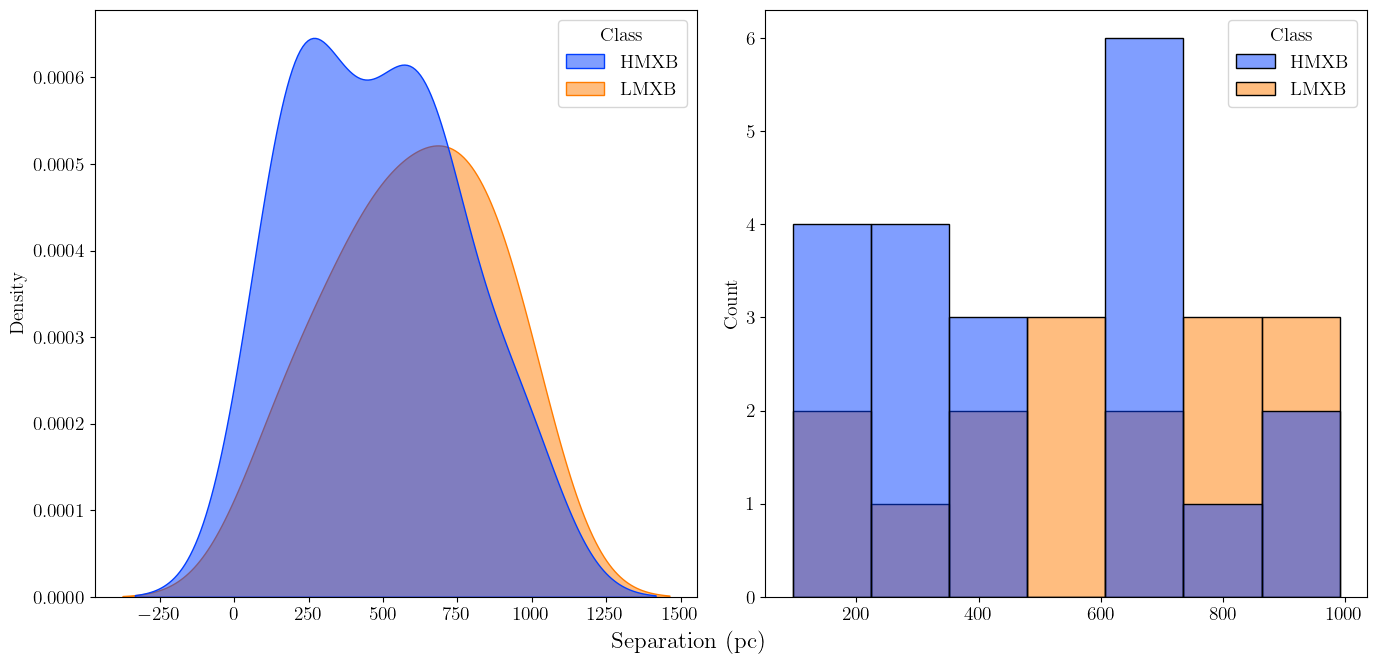

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.kdeplot(
    data=velocity,
    x='Cluster Separation (pc)',
    fill=True, 
    ax=ax[0], 
    alpha=0.5,
    hue='Class',
    palette='bright'
)
ax[0].set(xlabel=None)
sns.histplot(
    data=velocity,
    x='Cluster Separation (pc)',
    hue='Class',
    legend=True,
    # kind='hist',
    palette='bright',
    alpha=0.5,
    ax=ax[1]
)
ax[1].set(xlabel=None)

# ax[1].hist(x=velocity['Cluster Separation (pc)'].values, bins=30)
# ax[1].set_ylabel('Counts')

fig.supxlabel("Separation (pc)", x=0.5, y=0.05)
plt.tight_layout()
# plt.savefig(M66_dir+'M66_XRB_ejection_compact_association_cat_separation.png')
plt.show()

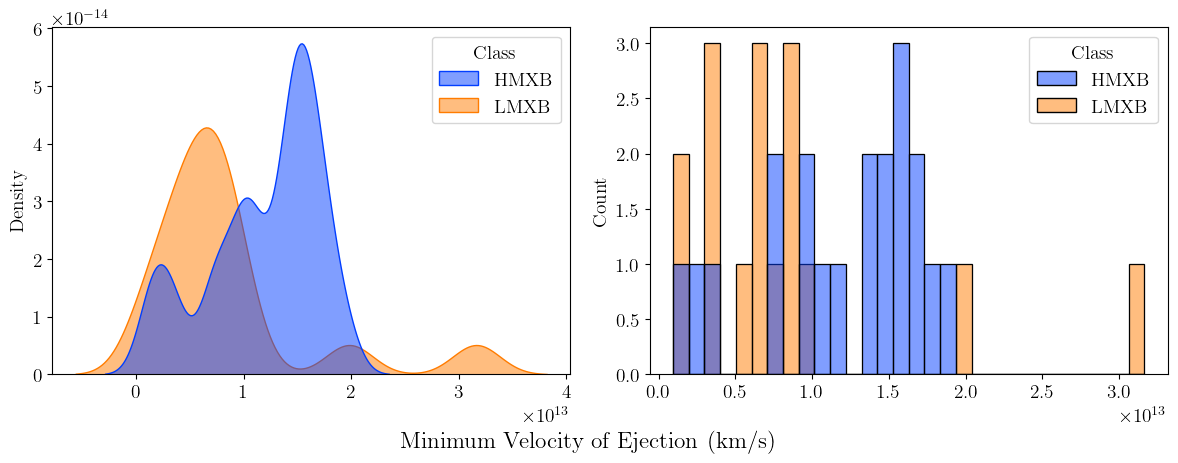

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.kdeplot(
    data=velocity, 
    x='Min Cluster Velocity (km/s)',
    hue='Class',
    bw_adjust=0.5,
    fill=True,
    ax=ax[0],
    alpha=0.5,
    palette='bright'
)
ax[0].set(xlabel=None)
# ax[0].set_xticks([i * 100 for i in range(0, 11)])

sns.histplot(
    data=velocity,
    x='Min Cluster Velocity (km/s)',
    hue='Class',
    bins=30,
    ax=ax[1], 
    alpha=0.5,
    palette='bright'
)
# ax[1].set_xticks([i * 100 for i in range(0, 11)])
ax[1].set(xlabel=None)
fig.supxlabel("Minimum Velocity of Ejection (km/s)", x=0.5, y=0.07)
plt.tight_layout()
# plt.savefig(M66_dir+'M66_XRB_ejection_compact_association_cat_velocity.png')
plt.show()

# Employing a chi-squared implementation to find the parent cluster of an XRB

In [70]:
distances = remove_unnamed(pd.read_csv(('/Users/undergradstudent/Downloads/temp_cluster.txt')))

# distances = distances[['CSC ID', 'Cluster ID', 'Star Age (Myr)', 'Cluster Age (Myr)', 'Cluster Age Err (Myr)',
#                         'Cluster Separation (pc)', 'Cluster Separation (km)', '2 Sig (arcsec)', 'Class']]

In [71]:
def wls_find_parent_cluster(df, idheader='CSC ID', cluster_age_head='Cluster Age (Myr)',
                            cluster_age_err_head='Cluster Age Err (Myr)', 
                            star_age_head='Star Age (Myr)'):
    '''The weighted least squares implementation to find the parent cluster
    for each X-ray source.'''
    df = df.copy()
    parent_cluster = pd.DataFrame()
    stellar_age = df[star_age_head].values
    cluster_age = df[cluster_age_head].values
    cluster_age_err = df[cluster_age_err_head].values

    test_statistic = (cluster_age - stellar_age) ** 2 / (cluster_age_err) ** 2
    df['Test Statistic'] = test_statistic

    # df contains each star associated with a cluster within 1000 pc
    # Need unique IDs to find the star-cluster pairs for each X-ray source
    # with the least test statistic
    for id in FindUnique(df, header=f'{idheader}')[idheader].tolist():
        temp = Find(df, f'{idheader} == {id}') 
        smallest_test_statistic = np.nanmin(temp['Test Statistic'].values) # ignore nan values
        if not np.isnan(smallest_test_statistic):
            candidate_cluster = temp.query(f'`Test Statistic` == {smallest_test_statistic}')\
                                       .reset_index(drop=True).iloc[[0]]
            parent_cluster = pd.concat([parent_cluster, candidate_cluster]).reset_index(drop=True)
        elif np.isnan(smallest_test_statistic) and np.isnan(temp[star_age_head].mean()):
            print(f'Nan values in the star age {id}')
            pass
        else:
            print(f"Something else seems to be the issue for {id}!")
    return parent_cluster

In [72]:
distances = wls_find_parent_cluster(distances)
distances

Nan values in the star age 2CXO J112015.3+125932
Nan values in the star age 2CXO J112014.5+125946
Nan values in the star age 2CXO J112011.3+125904
Nan values in the star age 2CXO J112017.6+130017
Nan values in the star age 2CXO J112018.7+130027


CSC RA    CSC Dec                    Auxiliary ID  Cluster ID  \
0   170.062259  12.992633   2CXO J112014.9+125933-1.0-2.0        7974   
1   170.062785  12.993429   2CXO J112015.0+125936-4.0-1.0        7420   
2   170.062538  12.989251   2CXO J112015.0+125921-3.0-1.0        7420   
3   170.063419  12.989393   2CXO J112015.2+125921-3.0-1.0        7420   
4   170.061339  12.993597   2CXO J112014.7+125937-4.0-1.0        7855   
5   170.062887  12.993977   2CXO J112015.0+125938-2.0-1.0        6790   
6   170.064028  12.995589   2CXO J112015.3+125944-4.0-1.0        7496   
7   170.056397  12.995632   2CXO J112013.5+125944-4.0-2.0        8555   
8   170.053614  12.996594   2CXO J112012.8+125947-2.0-1.0        7551   
9   170.070149  12.999835   2CXO J112016.8+125959-1.0-2.0        8276   
10  170.078512  12.990211   2CXO J112018.8+125924-6.0-2.0        7509   
11  170.057330  13.006947   2CXO J112013.7+130025-4.0-1.0        9289   
12  170.069903  12.975028   2CXO J112016.7+125830-5.0-2.0        3051   
13  170.081516  12.999423  2CXO J112019.5+125958-11.0-2.0        8191   
14  170.079541  13.007541  2CXO J112019.0+130027-23.0-7.0       10285   
15  170.054213  12.960156   2CXO J112013.0+125736-4.0-1.0        1512   
16  170.049536  12.969903   2CXO J112011.8+125811-nan-1.0        1801   
17  170.066456  12.957710   2CXO J112015.9+125727-nan-1.0        1286   
18  170.058772  12.989771   2CXO J112014.1+125923-1.0-nan        7496   
19  170.059709  12.988377   2CXO J112014.3+125918-7.0-nan        7496   
20  170.065983  12.986237   2CXO J112015.8+125910-1.0-nan        6498   
21  170.055921  12.991105   2CXO J112013.4+125928-4.0-nan        7699   
22  170.065903  12.984421   2CXO J112015.8+125904-7.0-nan        4559   
23  170.052527  12.996542   2CXO J112012.6+125947-2.0-nan        8292   
24  170.071585  13.000886   2CXO J112017.1+130003-4.0-nan        8425   
25  170.050873  12.997819  2CXO J112012.2+125952-18.0-nan        8292   
26  170.050187  12.986338   2CXO J112012.0+125910-5.0-nan        6509   
27  170.066003  13.005280   2CXO J112015.8+130019-2.0-nan        9783   
28  170.069365  12.978872   2CXO J112016.6+125844-1.0-nan        5432   
29  170.075880  12.999774   2CXO J112018.2+125959-1.0-nan        7799   
30  170.051250  12.979514   2CXO J112012.3+125846-2.0-nan        3644   
31  170.072362  13.005469  2CXO J112017.3+130019-14.0-nan        9783   
32  170.071464  13.007172   2CXO J112017.1+130025-4.0-nan        9783   
33  170.068581  13.009677   2CXO J112016.4+130034-1.0-nan       10479   
34  170.072942  12.971853   2CXO J112017.5+125818-2.0-nan        1867   
35  170.049536  12.969903   2CXO J112011.8+125811-nan-1.0        1801   
36  170.082346  13.008354   2CXO J112019.7+130030-8.0-nan        9012   
37  170.066456  12.957710   2CXO J112015.9+125727-nan-1.0        1286   

       JWST RA   JWST Dec  JWST ID  HST ID  F2000W ID  F3000M ID  F3350M ID  \
0   170.062313  12.992598      1.0     2.0   194701.0    45185.0        NaN   
1   170.062752  12.993454      4.0     1.0   201035.0    46439.0        NaN   
2   170.062480  12.989134      3.0     1.0   168909.0    39589.0    36088.0   
3   170.063369  12.989380      3.0     1.0   170739.0        NaN        NaN   
4   170.061260  12.993512      4.0     1.0   201491.0    46465.0        NaN   
5   170.062833  12.993919      2.0     1.0   204430.0        NaN        NaN   
6   170.063985  12.995572      4.0     1.0   216832.0    49711.0    45791.0   
7   170.056415  12.995653      4.0     2.0   217443.0        NaN    45945.0   
8   170.053561  12.996580      2.0     1.0   224400.0        NaN        NaN   
9   170.070131  12.999796      1.0     2.0   247821.0    56411.0    52210.0   
10  170.078486  12.990244      6.0     2.0   177274.0        NaN        NaN   
11  170.057303  13.006827      4.0     1.0   293622.0        NaN        NaN   
12  170.069996  12.975016      5.0     2.0    80164.0        NaN        NaN   
13  170.081429  12.999398     11.0     2.0   245024.0 

In [73]:
columns = ['CSC ID', 'Class', 'CSC RA', 'CSC Dec', 'Cluster ID', '2 Sig (arcsec)', '2 Sig (pix)', 'Cluster RA',
           'Cluster Separation (arcsecs)', 'Cluster Separation (pc)', 'Cluster Separation (km)',
           'Cluster Age (Myr)', 'Cluster Age Err (Myr)', 'Cluster Mass (M_sun)',
            'Cluster Mass Err (M_sun)', 'Cluster EBV', 'Cluster EBV Err',
            'Cluster Test Statistic', 'Cluster FWHM', 'Cluster Radius Eff (pix)',
            'Cluster Radius Eff (arcsec)', 'Cluster Radius Eff (pc)',
            'Star Mass (M_sun)', 'Star Age (s)', 'Star Age (Myr)',
            'Test Statistic']
distances = distances[columns]
distances

CSC ID Class      CSC RA    CSC Dec  Cluster ID  \
0   2CXO J112014.9+125933  HMXB  170.062259  12.992633        7974   
1   2CXO J112015.0+125936  HMXB  170.062785  12.993429        7420   
2   2CXO J112015.0+125921  HMXB  170.062538  12.989251        7420   
3   2CXO J112015.2+125921  HMXB  170.063419  12.989393        7420   
4   2CXO J112014.7+125937  HMXB  170.061339  12.993597        7855   
5   2CXO J112015.0+125938  HMXB  170.062887  12.993977        6790   
6   2CXO J112015.3+125944  HMXB  170.064028  12.995589        7496   
7   2CXO J112013.5+125944  HMXB  170.056397  12.995632        8555   
8   2CXO J112012.8+125947  HMXB  170.053614  12.996594        7551   
9   2CXO J112016.8+125959  HMXB  170.070149  12.999835        8276   
10  2CXO J112018.8+125924  HMXB  170.078512  12.990211        7509   
11  2CXO J112013.7+130025  HMXB  170.057330  13.006947        9289   
12  2CXO J112016.7+125830  HMXB  170.069903  12.975028        3051   
13  2CXO J112019.5+125958  HMXB  170.081516  12.999423        8191   
14  2CXO J112019.0+130027  HMXB  170.079541  13.007541       10285   
15  2CXO J112013.0+125736  HMXB  170.054213  12.960156        1512   
16  2CXO J112011.8+125811  HMXB  170.049536  12.969903        1801   
17  2CXO J112015.9+125727  HMXB  170.066456  12.957710        1286   
18  2CXO J112014.1+125923  LMXB  170.058772  12.989771        7496   
19  2CXO J112014.3+125918  LMXB  170.059709  12.988377        7496   
20  2CXO J112015.8+125910  LMXB  170.065983  12.986237        6498   
21  2CXO J112013.4+125928  LMXB  170.055921  12.991105        7699   
22  2CXO J112015.8+125904  LMXB  170.065903  12.984421        4559   
23  2CXO J112012.6+125947  LMXB  170.052527  12.996542        8292   
24  2CXO J112017.1+130003  LMXB  170.071585  13.000886        8425   
25  2CXO J112012.2+125952  LMXB  170.050873  12.997819        8292   
26  2CXO J112012.0+125910  LMXB  170.050187  12.986338        6509   
27  2CXO J112015.8+130019  LMXB  170.066003  13.005280        9783   
28  2CXO J112016.6+125844  LMXB  170.069365  12.978872        5432   
29  2CXO J112018.2+125959  LMXB  170.075880  12.999774        7799   
30  2CXO J112012.3+125846  LMXB  170.051250  12.979514        3644   
31  2CXO J112017.3+130019  LMXB  170.072362  13.005469        9783   
32  2CXO J112017.1+130025  LMXB  170.071464  13.007172        9783   
33  2CXO J112016.4+130034  LMXB  170.068581  13.009677       10479   
34  2CXO J112017.5+125818  LMXB  170.072942  12.971853        1867   
35  2CXO J112011.8+125811  HMXB  170.049536  12.969903        1801   
36  2CXO J112019.7+130030  LMXB  170.082346  13.008354        9012   
37  2CXO J112015.9+125727  HMXB  170.066456  12.957710        1286   

    2 Sig (arcsec)  2 Sig (pix)  Cluster RA  Cluster Separation (arcsecs)  \
0         0.235415     5.941826  170.058744                     16.991401   
1         0.243913     6.156299  170.057624                     19.712708   
2         0.467468    11.798781  170.057624                     18.696008   
3         0.375305     9.472610  170.057624                     21.411859   
4         0.465134    11.739872  170.055887                     19.649388   
5         0.343588     8.672081  170.062151                     21.631895   
6         0.346187     8.737676  170.060607                     18.489522   
7         0.303917     7.670794  170.054916                     18.137810   
8         0.277362     7.000563  170.050037                     20.732117   
9         0.502163    12.674487  170.066506                     13.841697   
10        0.478708    12.082486  170.080769                      9.705252   
11        0.597313    15.076052  170.056953                      7.862824   
12        0.542665    13.696748  170.074473                     16.078870   
13        0.832043    21.000582  170.077408                     15.879344   
14        1.011693    25.534906  170.082677                     18.518283   
15        0.387891     9.790275  170.058128             

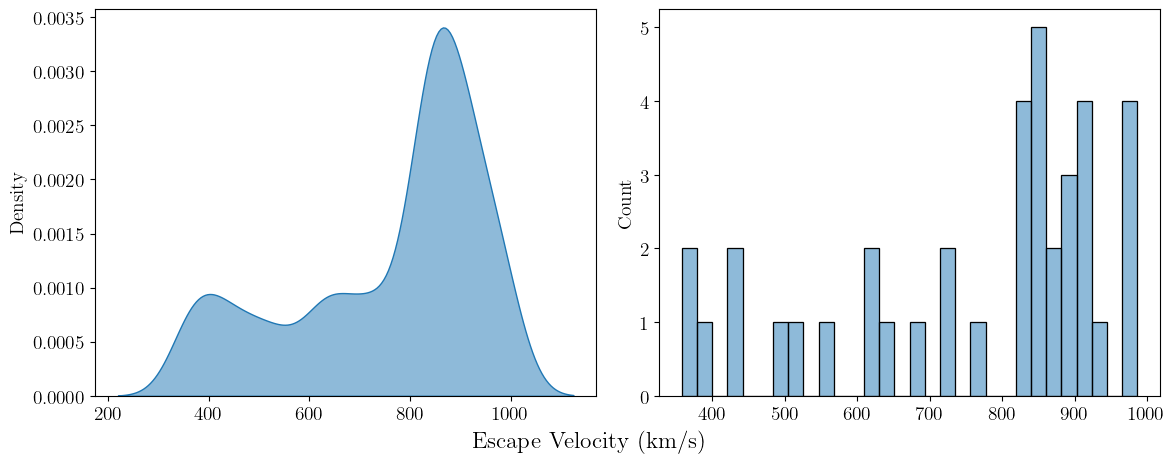

In [91]:
make_plots(df=distances, x='Cluster Separation (pc)')

# Velocity

## Minimum Velocity

In [74]:
dists = distances.copy()

In [75]:
# Convert Cluster Age from Myr to s
age_Myr = dists['Cluster Age (Myr)'].values * u.Myr
age_s = age_Myr.to(u.s).value
loc = dists.columns.get_loc('Cluster Age (Myr)') + 1
dists.insert(loc, 'Cluster Age (s)', age_s)

# Conver cluster age err from Myr to s
age_Myr = dists['Cluster Age Err (Myr)'].values * u.Myr
age_s = age_Myr.to(u.s).value
loc = dists.columns.get_loc('Cluster Age Err (Myr)') + 1
dists.insert(loc, 'Cluster Age Err (s)', age_s)

# Convert 2 Sig from arcsec to km
sigma2 = dists['2 Sig (arcsec)'].values * 45.5 * u.pc # 45.4 pc/arcsec
sigma2_km = sigma2.to(u.km).value
loc = dists.columns.get_loc('2 Sig (arcsec)') + 1
dists.insert(loc, '2 Sig (km)', sigma2_km)

In [76]:
velocity = calculate_velocity(
    df=dists,
    coordheads=['Cluster Separation (km)', 'Cluster Age (s)'],
    errorheads=['2 Sig (km)', 'Cluster Age Err (s)'],
)
velocity

Make sure that the distances and ages are in km and seconds respectively...


CSC ID Class      CSC RA    CSC Dec  Cluster ID  \
0   2CXO J112014.9+125933  HMXB  170.062259  12.992633        7974   
1   2CXO J112015.0+125936  HMXB  170.062785  12.993429        7420   
2   2CXO J112015.0+125921  HMXB  170.062538  12.989251        7420   
3   2CXO J112015.2+125921  HMXB  170.063419  12.989393        7420   
4   2CXO J112014.7+125937  HMXB  170.061339  12.993597        7855   
5   2CXO J112015.0+125938  HMXB  170.062887  12.993977        6790   
6   2CXO J112015.3+125944  HMXB  170.064028  12.995589        7496   
7   2CXO J112013.5+125944  HMXB  170.056397  12.995632        8555   
8   2CXO J112012.8+125947  HMXB  170.053614  12.996594        7551   
9   2CXO J112016.8+125959  HMXB  170.070149  12.999835        8276   
10  2CXO J112018.8+125924  HMXB  170.078512  12.990211        7509   
11  2CXO J112013.7+130025  HMXB  170.057330  13.006947        9289   
12  2CXO J112016.7+125830  HMXB  170.069903  12.975028        3051   
13  2CXO J112019.5+125958  HMXB  170.081516  12.999423        8191   
14  2CXO J112019.0+130027  HMXB  170.079541  13.007541       10285   
15  2CXO J112013.0+125736  HMXB  170.054213  12.960156        1512   
16  2CXO J112011.8+125811  HMXB  170.049536  12.969903        1801   
17  2CXO J112015.9+125727  HMXB  170.066456  12.957710        1286   
18  2CXO J112014.1+125923  LMXB  170.058772  12.989771        7496   
19  2CXO J112014.3+125918  LMXB  170.059709  12.988377        7496   
20  2CXO J112015.8+125910  LMXB  170.065983  12.986237        6498   
21  2CXO J112013.4+125928  LMXB  170.055921  12.991105        7699   
22  2CXO J112015.8+125904  LMXB  170.065903  12.984421        4559   
23  2CXO J112012.6+125947  LMXB  170.052527  12.996542        8292   
24  2CXO J112017.1+130003  LMXB  170.071585  13.000886        8425   
25  2CXO J112012.2+125952  LMXB  170.050873  12.997819        8292   
26  2CXO J112012.0+125910  LMXB  170.050187  12.986338        6509   
27  2CXO J112015.8+130019  LMXB  170.066003  13.005280        9783   
28  2CXO J112016.6+125844  LMXB  170.069365  12.978872        5432   
29  2CXO J112018.2+125959  LMXB  170.075880  12.999774        7799   
30  2CXO J112012.3+125846  LMXB  170.051250  12.979514        3644   
31  2CXO J112017.3+130019  LMXB  170.072362  13.005469        9783   
32  2CXO J112017.1+130025  LMXB  170.071464  13.007172        9783   
33  2CXO J112016.4+130034  LMXB  170.068581  13.009677       10479   
34  2CXO J112017.5+125818  LMXB  170.072942  12.971853        1867   
35  2CXO J112011.8+125811  HMXB  170.049536  12.969903        1801   
36  2CXO J112019.7+130030  LMXB  170.082346  13.008354        9012   
37  2CXO J112015.9+125727  HMXB  170.066456  12.957710        1286   

    2 Sig (arcsec)    2 Sig (km)  2 Sig (pix)  Cluster RA  \
0         0.235415  3.305189e+14     5.941826  170.058744   
1         0.243913  3.424492e+14     6.156299  170.057624   
2         0.467468  6.563169e+14    11.798781  170.057624   
3         0.375305  5.269217e+14     9.472610  170.057624   
4         0.465134  6.530400e+14    11.739872  170.055887   
5         0.343588  4.823916e+14     8.672081  170.062151   
6         0.346187  4.860404e+14     8.737676  170.060607   
7         0.303917  4.266942e+14     7.670794  170.054916   
8         0.277362  3.894120e+14     7.000563  170.050037   
9         0.502163  7.050287e+14    12.674487  170.066506   
10        0.478708  6.720982e+14    12.082486  170.080769   
11        0.597313  8.386177e+14    15.076052  170.056953   
12        0.542665  7.618928e+14    13.696748  170.074473   
13        0.832043  1.168175e+15    21.000582  170.077408   
14        1.011693  1.420400e+15    25.534906  170.082677   
15        0.387891  5.445921e+14     9.790275  170.058128   
16        0.387168  5.435774e+14     9.772034  170.054227   
17        0.344518  4.836976e+14     8.695559  170.067698   
18        0.361474  5.075039e+14     9.123531  170.060607   
19        0.337231  4.734674e+14     8.511648  170.060607   
20     

In [107]:
def make_plots(df, x,bw_adjust=0.5, bins=30, palette='bright',
               savefile=False, **kwargs):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    sns.kdeplot(
        data=df, 
        x=x,
        bw_adjust=bw_adjust,
        fill=True,
        ax=ax[0],
        alpha=0.5,
        palette=palette,
        **kwargs
    )
    ax[0].set(xlabel=None)
    # ax[0].set_xticks([i * 100 for i in range(0, 11)])

    sns.histplot(
        data=df,
        x=x,
        bins=bins,
        ax=ax[1], 
        alpha=0.5,
        palette=palette,
        **kwargs
    )
    # ax[1].set_xticks([i * 100 for i in range(0, 11)])
    ax[1].set(xlabel=None)
    fig.supxlabel("Escape Velocity (km/s)", x=0.5, y=0.07)
    plt.tight_layout()
    if savefile:
        plt.savefig(savefile)
    plt.show()

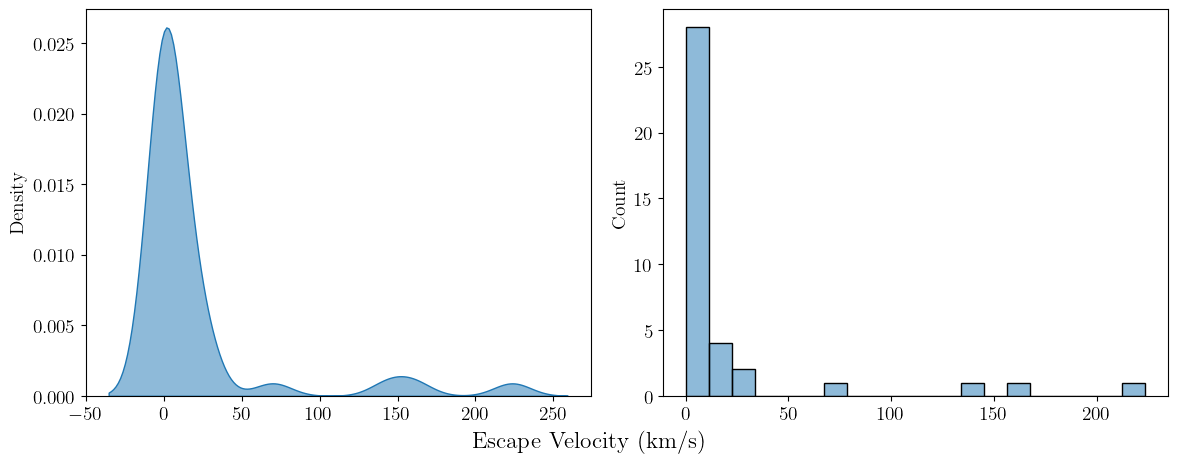

In [108]:
make_plots(velocity, x='Min Cluster Velocity (km/s)', bins=20)

## Escape Velocity 

In [104]:
# effective radius of a cluster in km
r_eff = velocity['Cluster Radius Eff (pc)'].values * u.pc
r_h = (4 / 3 * r_eff).to(u.km)
velocity['Cluster half-mass Radius (km)'] = r_h.value

# Now finding the escape velocities
from astropy.constants import G
M = velocity['Cluster Mass (M_sun)'].values * u.Msun # Mass of the cluster
v_esc = np.sqrt(2 * G * M / r_h)
v_esc = v_esc.to(u.km/u.s)
velocity['XRB escape velocity (km/s)'] = v_esc.value

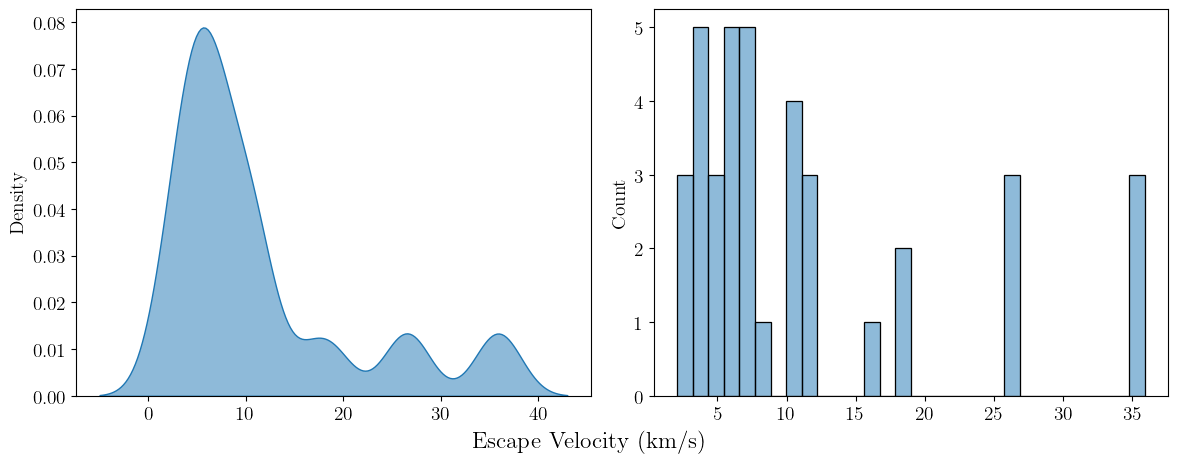

In [109]:
make_plots(velocity, x='XRB escape velocity (km/s)')

## M/R vs velocity plot

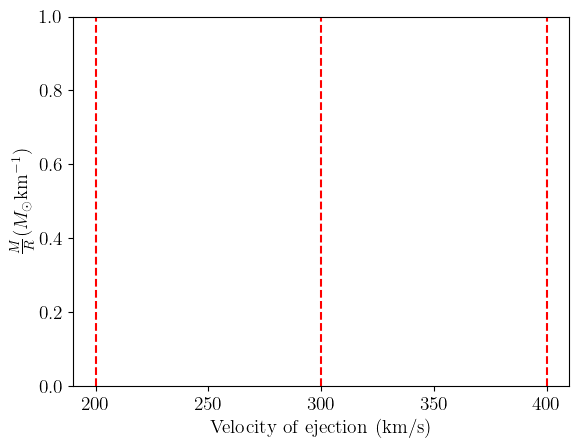

In [155]:
fig, ax = plt.subplots()
ax.set_xlabel('Velocity of ejection (km/s)')
ax.set_ylabel(r'$\frac{M}{R} (M_{\odot}$km$^{-1})$')

x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
# Plot the y=x line within these limits
plt.plot([min(x_min, y_min), max(x_max, y_max)], [min(x_min, y_min), max(x_max, y_max)], color='red', linestyle='--')

# Add a vertical lines at 
plt.axvline(x=200, color='r', linestyle='--')
plt.axvline(x=300, color='r', linestyle='--')
plt.axvline(x=400, color='r', linestyle='--')

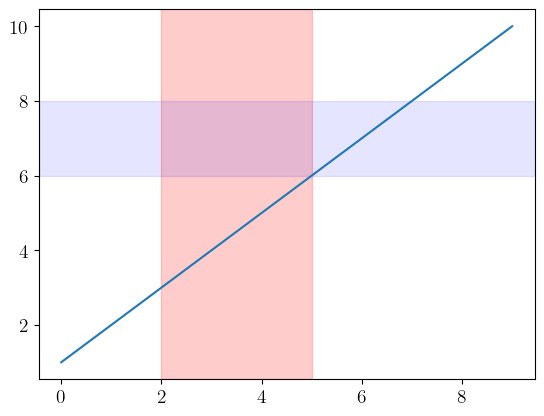

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
fig, ax = plt.subplots()
sns.lineplot(x=range(len(data)), y=data, ax=ax)

# Shade a vertical region
ax.axvspan(2, 5, color='red', alpha=0.2)

# Shade a horizontal region
ax.axhspan(6, 8, color='blue', alpha=0.1)

plt.show()

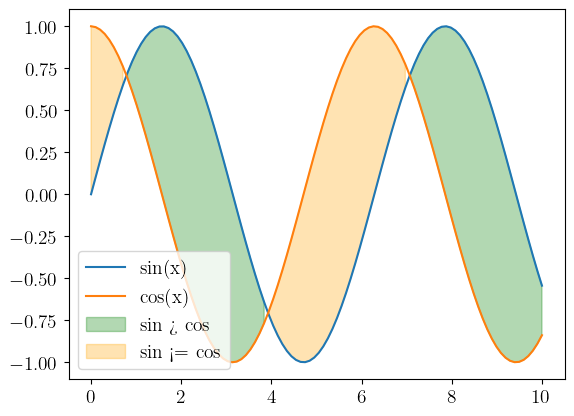

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)

fig, ax = plt.subplots()
ax.plot(x, y1, label='sin(x)')
ax.plot(x, y2, label='cos(x)')

ax.fill_between(x, y1, y2, where=(y1 > y2), color='green', alpha=0.3, label='sin > cos')
ax.fill_between(x, y1, y2, where=(y1 <= y2), color='orange', alpha=0.3, label='sin <= cos')

ax.legend()
plt.show()

# Finding the best-parent cluster with the donor star

## Choosing donor stars

(1) You already have some DataFrames that cross-references the stars of each XRB in HST and JWST. If you haven't already, pull their photometries. You should use these to build a single DataFrame containing each XRB, all stars associated with each XRB, and their magnitudes in each filter.

(2) You also have a DataFrame containing 2sig JWST stars that don't have HST counterparts. Get the photometries and concatenate it to the  DataFrame in (1). All of the HST headers should be empty for these stars, which is okay! The DataFrame should now include every XRB and every star associated with each XRB observed by HST, JWST, or both.

(3) Create a new header to give each star a unique ID (like NGC3627-X01-S01 or something). You can now run this entire DataFrame through fitSED (using the acs+nircam or wfc3+nircam setting as the instrument and the new header as idheader). This should give you the best fit mass and age of each star associated with each XRB.

(4) I would probably add back in the XRB IDs to the best fit model DataFrame. That way you can run Find on to pull the info for each XRB to get a range of masses and ages associated with it, which you can use to decide which cluster your XRB is most likely associated with.

In [2]:
mutual_photometry = remove_unnamed(pd.read_csv(M66_dir+'XRB-ejection/M66_HMXB_hst_jwst_photometry'))
M66_notes = remove_unnamed(pd.read_csv(chandra_jwst_dir+"M66_XRB_notes.txt"))

In [3]:
# Merge Classifications of each source to find HMXB
temp = M66_notes[['CSC ID', 'Class']]
mutual_photometry = mutual_photometry.merge(temp, on='CSC ID', how='left')
M66_xrbs = Find(mutual_photometry, 'Class == HMXB')

M66_xrbs

JWST RA   JWST Dec  JWST ID  HST ID  F2000W ID  F3000M ID  F3350M ID  \
0   170.062313  12.992598        1       2     194701    45185.0        NaN   
1   170.062307  12.992623        3       2     194908    45185.0        NaN   
2   170.062255  12.992622        4       2     194909        NaN        NaN   
3   170.062808  12.993437        2       1     200852    46417.0    42593.0   
4   170.062752  12.993454        3       1     201035    46417.0    42593.0   
..         ...        ...      ...     ...        ...        ...        ...   
73  170.079682  13.007607       17       3     297917    67859.0        NaN   
74  170.079682  13.007607       17       4     297917    67859.0        NaN   
75  170.079491  13.007663       19       6     298214        NaN    62954.0   
76  170.079599  13.007786       23       7     298884        NaN        NaN   
77  170.054191  12.960178        4       1      26519     6497.0     5610.0   

    F3600M ID       JWST X       JWST Y                 CSC ID        HST X  \
0         NaN  3104.574104  5904.817673  2CXO J112014.9+125933  3743.843919   
1         NaN  3105.251503  5907.752641  2CXO J112014.9+125933  3743.843919   
2         NaN  3111.115373  5907.603774  2CXO J112014.9+125933  3743.843919   
3     48557.0  3048.131145  6003.004427  2CXO J112015.0+125936  3700.317585   
4         NaN  3054.473615  6004.938353  2CXO J112015.0+125936  3700.317585   
..        ...          ...          ...                    ...          ...   
73        NaN  1123.163184  7662.043801  2CXO J112019.0+130027  2208.450122   
74        NaN  1123.163184  7662.043801  2CXO J112019.0+130027  2203.147517   
75    71040.0  1144.978450  7668.533855  2CXO J112019.0+130027  2219.766700   
76        NaN  1132.576056  7682.902277  2CXO J112019.0+130027  2213.211646   
77     6873.0  4031.312552  2109.128343  2CXO J112013.0+125736  4463.710840   

          HST Y  F555W ID  F275W ID  F336W ID  F438W ID  F814W ID      HST RA  \
0   5833.507868     19247  130956.0       NaN   36055.0       NaN  170.062292   
1   5833.507868     19247  130956.0       NaN   36055.0       NaN  170.062292   
2   5833.507868     19247  130956.0       NaN   36055.0       NaN  170.062292   
3   5908.701948     19792       NaN       NaN   36916.0       NaN  170.062784   
4   5908.701948     19792       NaN       NaN   36916.0       NaN  170.062784   
..          ...       ...       ...       ...       ...       ...         ...   
73  7192.852518     31213       NaN  135197.0   53744.0       NaN  170.079635   
74  7193.587937     31217       NaN  135223.0   53743.0       NaN  170.079695   
75  7203.825438     31301       NaN  135467.0       NaN       NaN  170.079507   
76  7211.601845     31360       NaN       NaN   53928.0       NaN  170.079581   
77  2888.783967      1804   48203.0       NaN       NaN    1718.0  170.054162   

      HST Dec     F2000W  F2000W Err     F3000M  F3000M Err     F3350M  \
0   12.992626 -12.148228   -0.925911 -13.902257   -0.287522        NaN   
1   12.992626 -12.159049   -0.904646 -13.902257   -0.287522        NaN   
2   12.992626 -12.268460   -0.794376        NaN         NaN        NaN   
3   12.993454        NaN  184.978557 -11.584072   -1.756274 -12.044657   
4   12.993454  -8.534081  -14.801952 -11.584072   -1.756274 -12.044657   
..        ...        ...         ...        ...         ...        ...   
73  13.007586  -9.302007   -0.223203  -9.402144   -0.484233        NaN   
74  13.007594  -9.302007   -0.223203  -9.402144   -0.484233        NaN   
75  13.007706  -8.866422   -0.333883        NaN         NaN -10.817085   
76  13.007792  -8.772850   -0.356640        NaN         NaN        NaN   
77  12.960218  -9.902529   -0.154548  -9.273787   -0.743486  -9.818036   

    F3350M Err     F3600M  F3600M Err     F275W  F275W Err     F336W  \
0          NaN        NaN         NaN -2.974469  -1.372681       NaN   
1          NaN        NaN         NaN -2.974469  -1.372681       NaN   
2          NaN        NaN      

In [274]:
# Commenting it so that I dont accidentally rerun and delete all the data
# temp = M66_notes[['CSC ID', 'ID', 'Class']]
# temp['JWST ID'] = ""
# temp['HST ID'] = ""
# temp['Mass'] = ""
# temp['Notes'] = ""
# temp.to_csv(M66_dir+"M66_hst_jwst_best_stars_notes.csv")

In [4]:
M66_xrbs['Auxiliary ID'] = M66_xrbs['CSC ID'] + '-' + M66_xrbs['JWST ID'].astype(int).astype(str)\
      + '-' + M66_xrbs['HST ID'].astype(int).astype(str)

Finding best-fit model(s)...
DONE


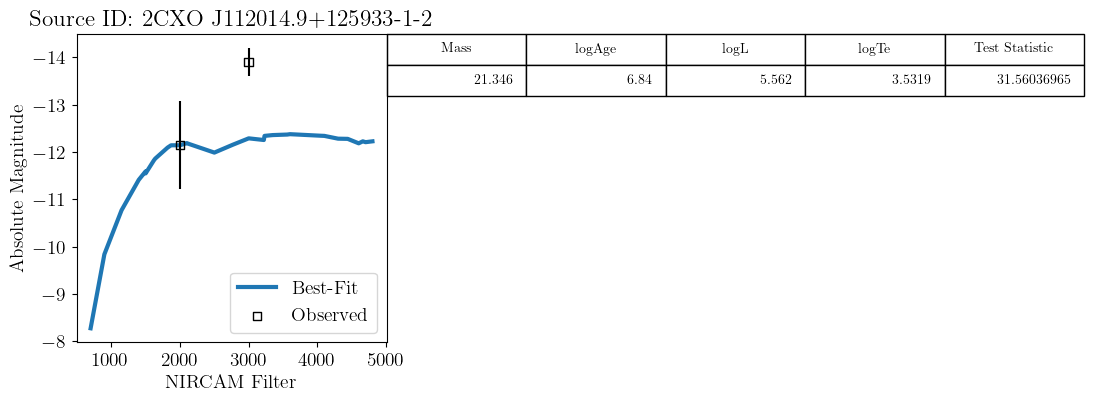

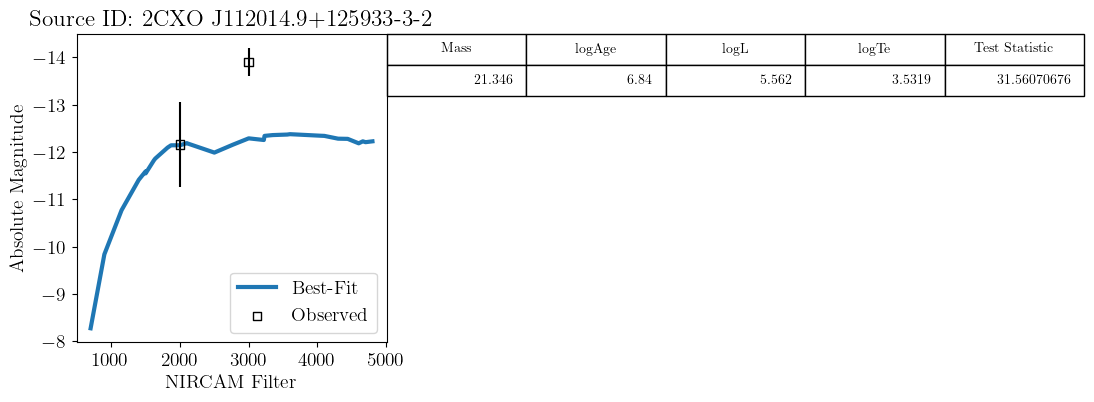

No best-fit model available for Source ID 2CXO J112014.9+125933-4-2.


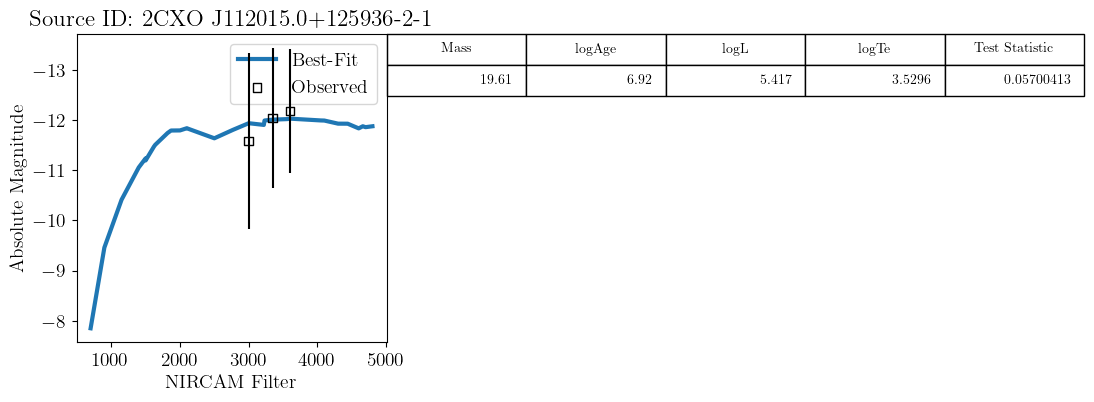

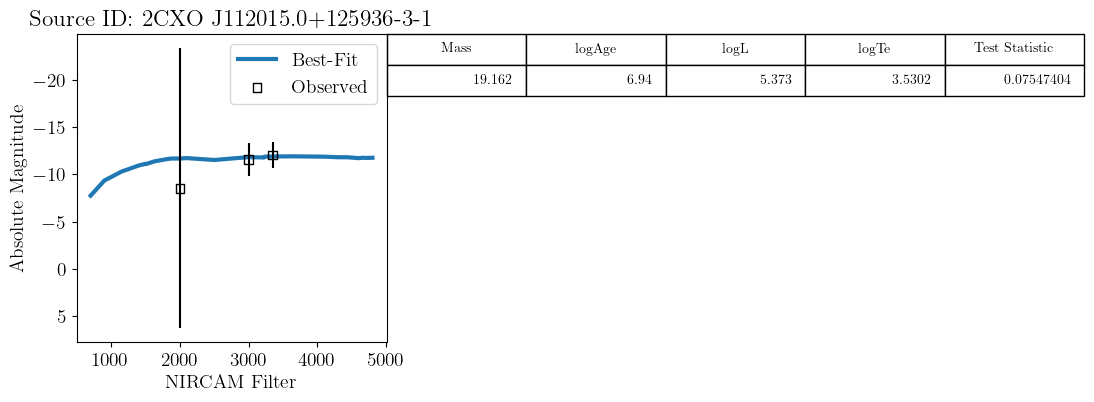

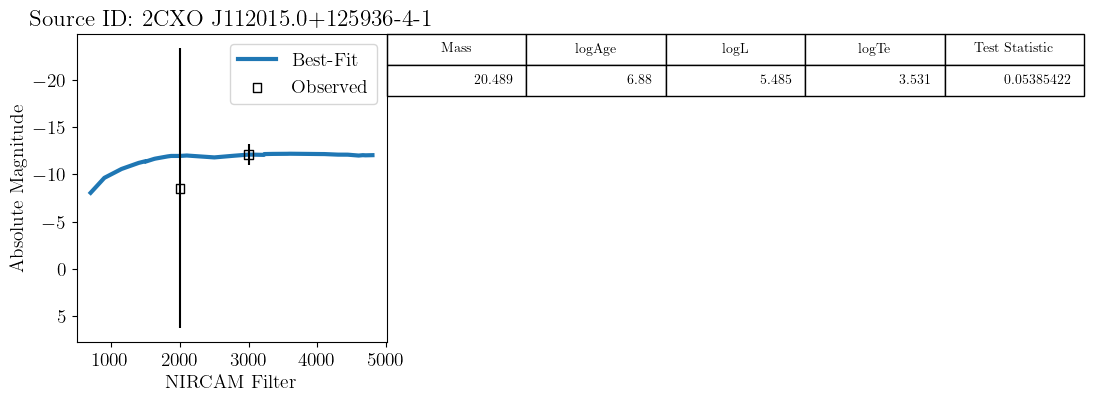

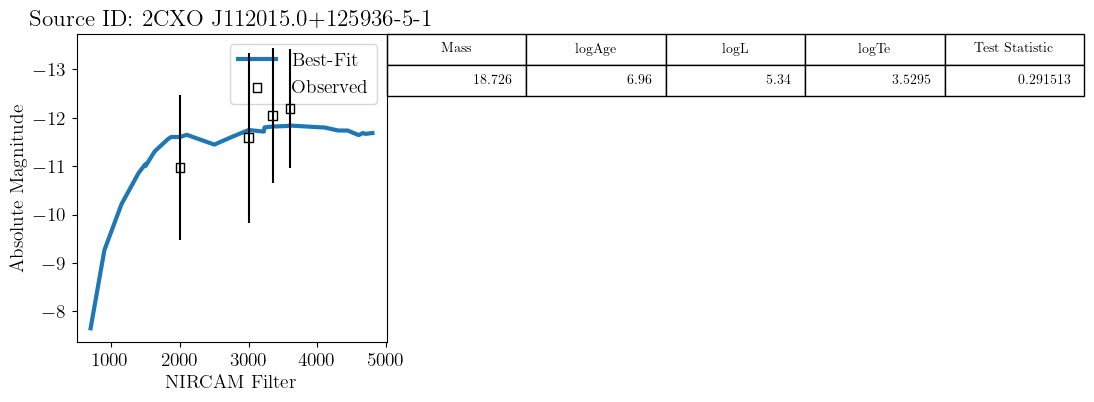

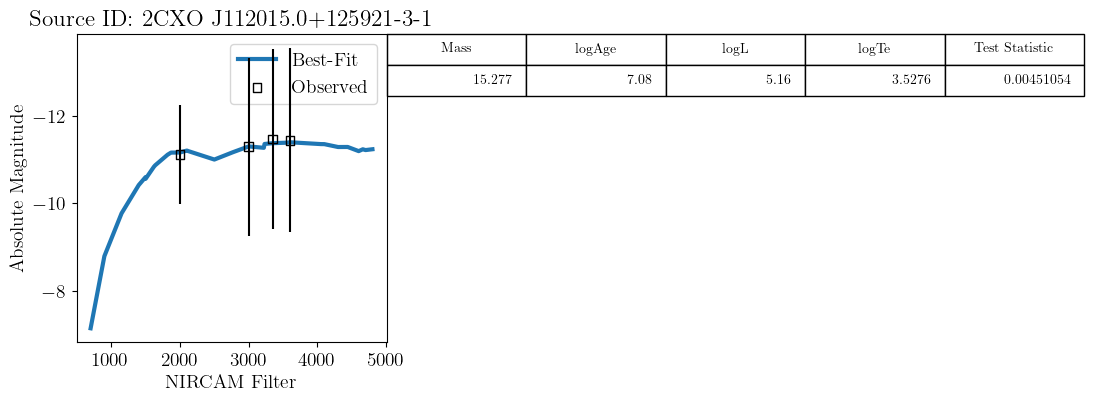

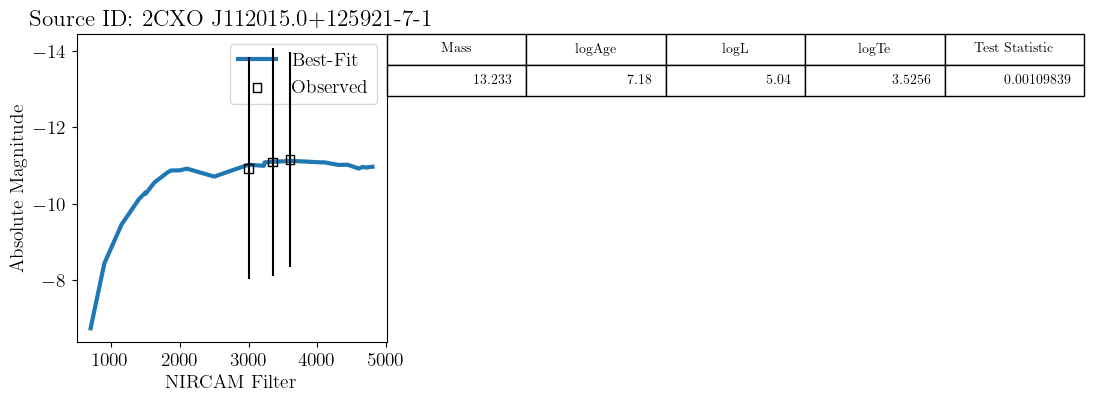

No best-fit model available for Source ID 2CXO J112015.2+125921-3-1.
No best-fit model available for Source ID 2CXO J112015.2+125921-3-2.
No best-fit model available for Source ID 2CXO J112015.2+125921-7-3.


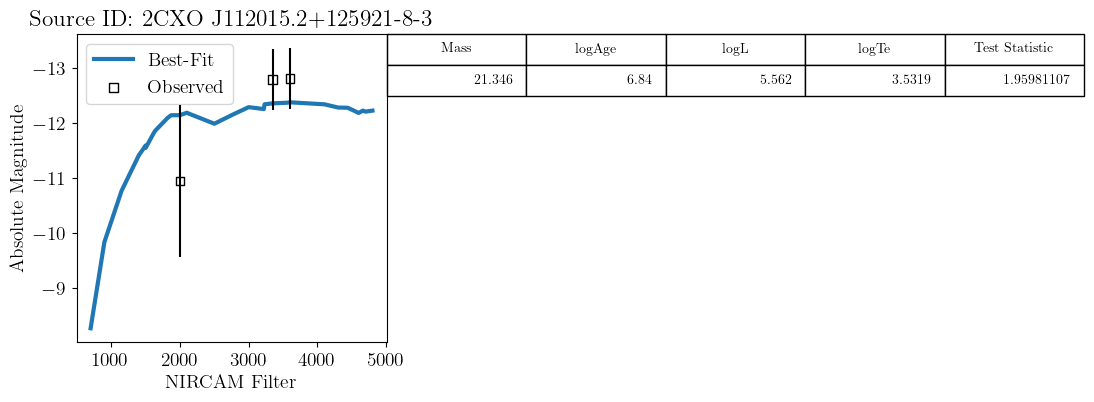

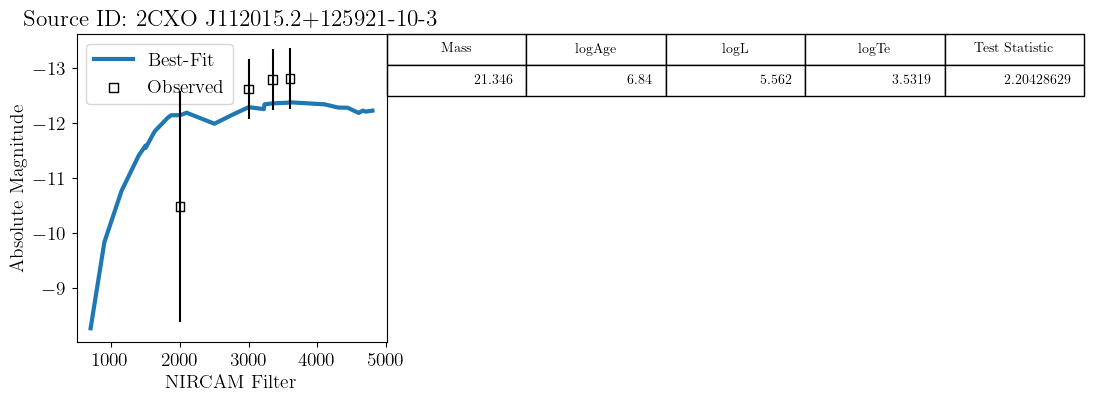

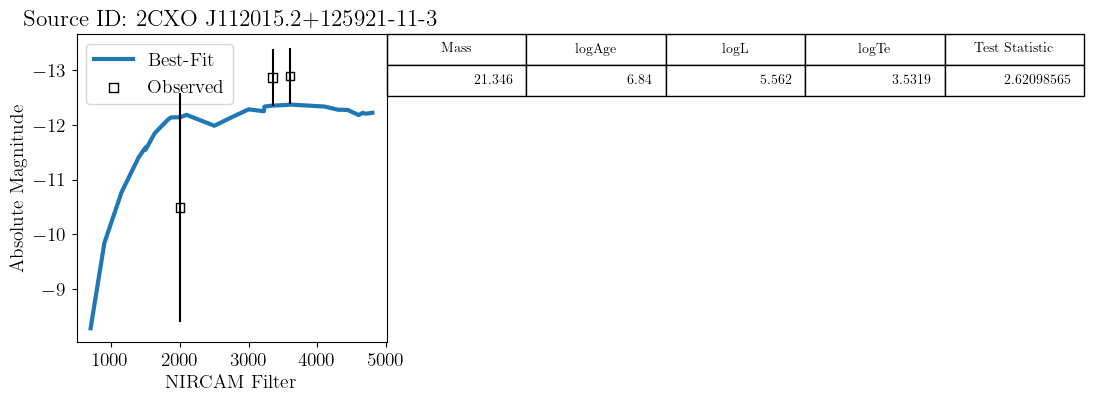

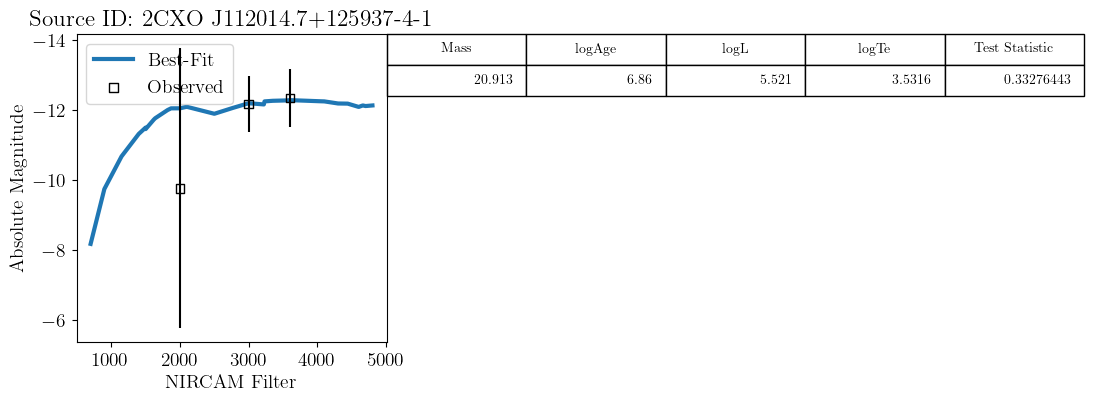

No best-fit model available for Source ID 2CXO J112014.7+125937-6-1.
No best-fit model available for Source ID 2CXO J112014.7+125937-6-2.
No best-fit model available for Source ID 2CXO J112014.7+125937-6-3.
No best-fit model available for Source ID 2CXO J112014.7+125937-7-1.
No best-fit model available for Source ID 2CXO J112014.7+125937-7-2.
No best-fit model available for Source ID 2CXO J112014.7+125937-7-3.


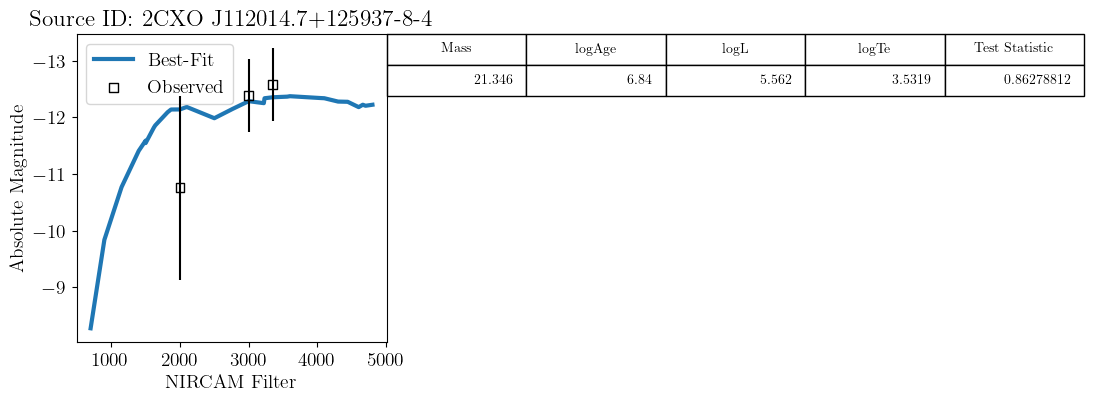

No best-fit model available for Source ID 2CXO J112014.7+125937-12-2.
No best-fit model available for Source ID 2CXO J112014.7+125937-12-3.
No best-fit model available for Source ID 2CXO J112014.7+125937-13-2.
No best-fit model available for Source ID 2CXO J112014.7+125937-13-3.


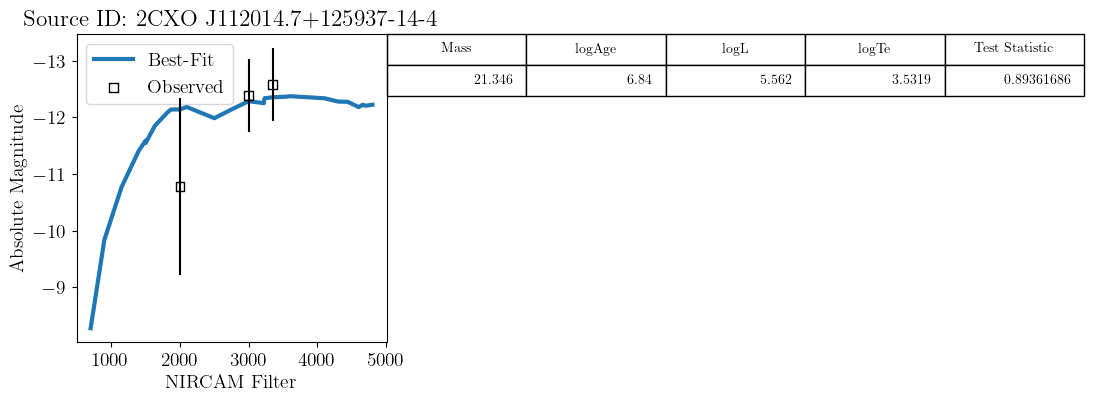

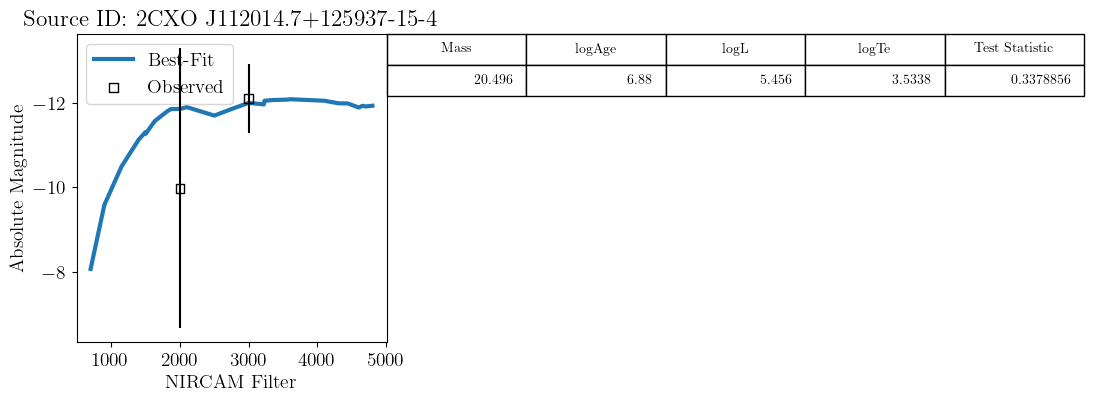

No best-fit model available for Source ID 2CXO J112014.7+125937-18-4.
No best-fit model available for Source ID 2CXO J112015.0+125938-2-1.
No best-fit model available for Source ID 2CXO J112015.0+125938-5-1.
No best-fit model available for Source ID 2CXO J112015.0+125938-5-2.
No best-fit model available for Source ID 2CXO J112015.0+125938-6-1.
No best-fit model available for Source ID 2CXO J112015.0+125938-7-2.
No best-fit model available for Source ID 2CXO J112015.0+125938-10-3.


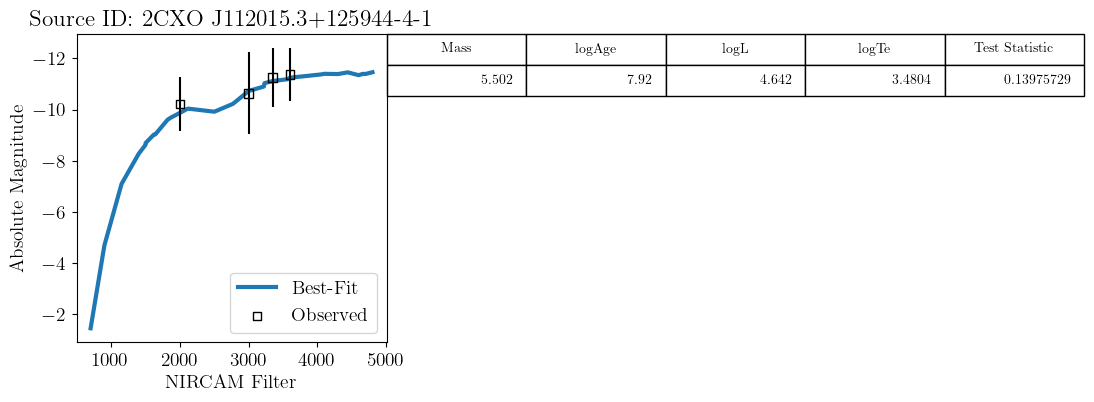

No best-fit model available for Source ID 2CXO J112015.3+125944-6-1.
No best-fit model available for Source ID 2CXO J112012.8+125947-2-1.


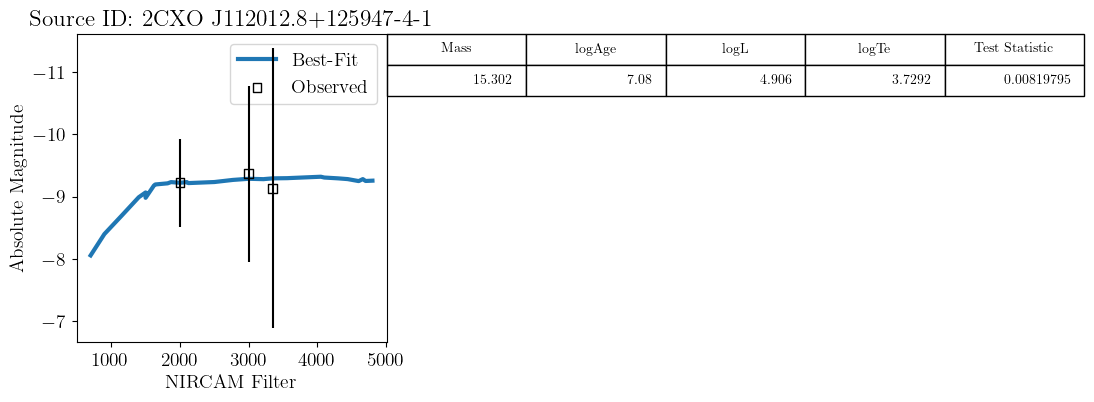

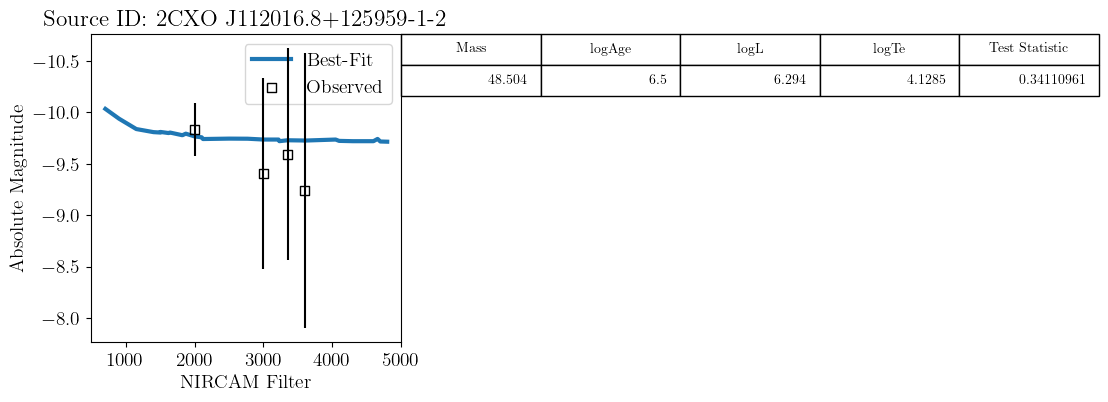

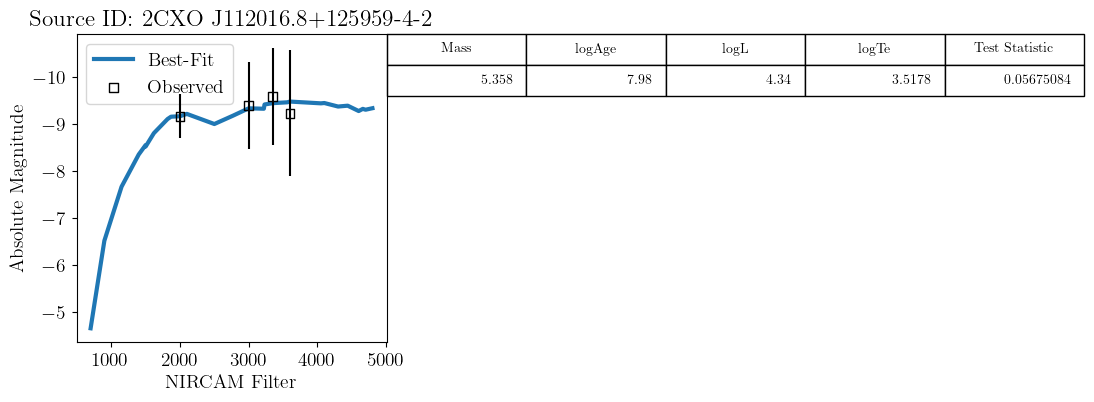

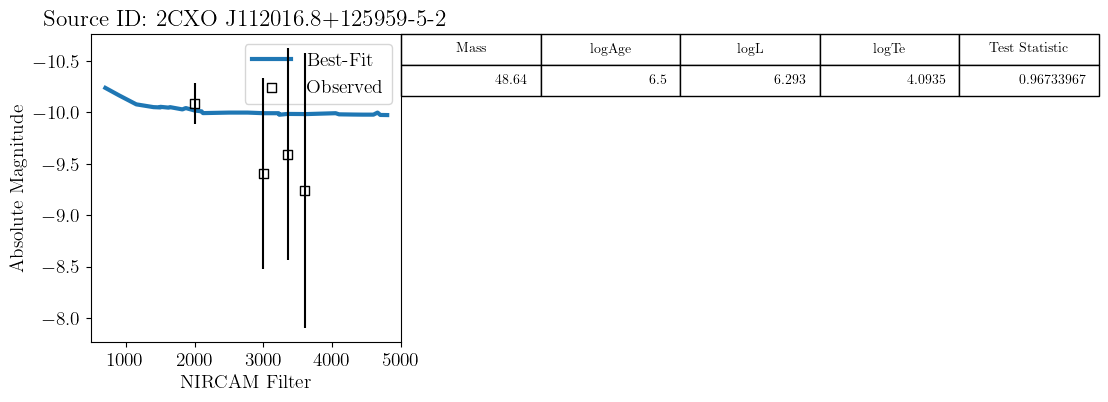

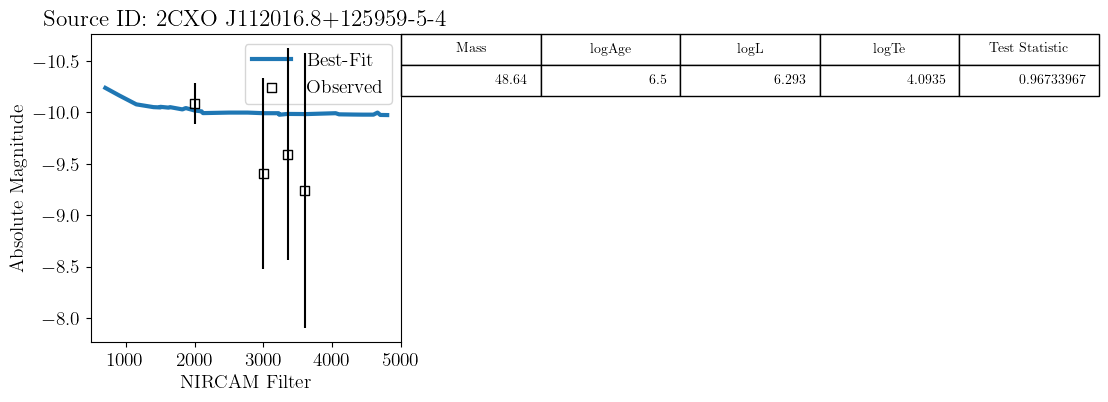

No best-fit model available for Source ID 2CXO J112016.8+125959-6-3.
No best-fit model available for Source ID 2CXO J112016.8+125959-7-4.


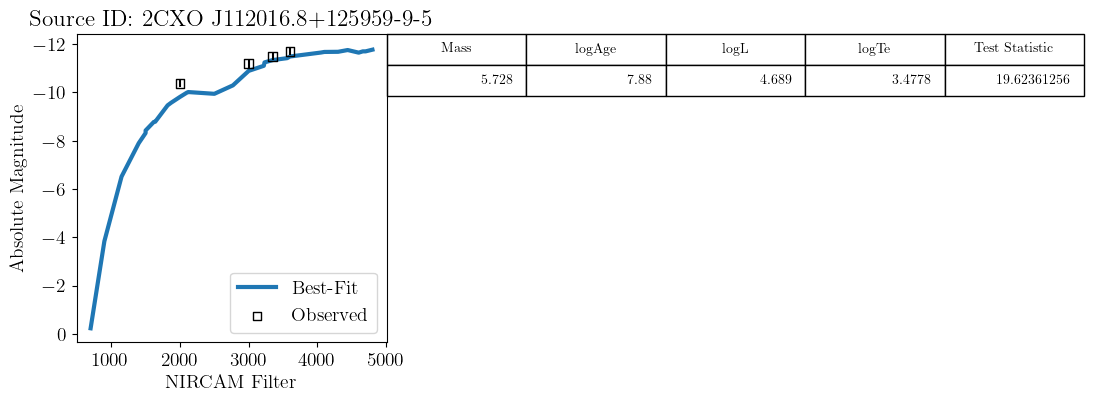

No best-fit model available for Source ID 2CXO J112018.8+125924-1-1.
No best-fit model available for Source ID 2CXO J112018.8+125924-3-1.
No best-fit model available for Source ID 2CXO J112018.8+125924-6-2.
No best-fit model available for Source ID 2CXO J112018.8+125924-7-2.


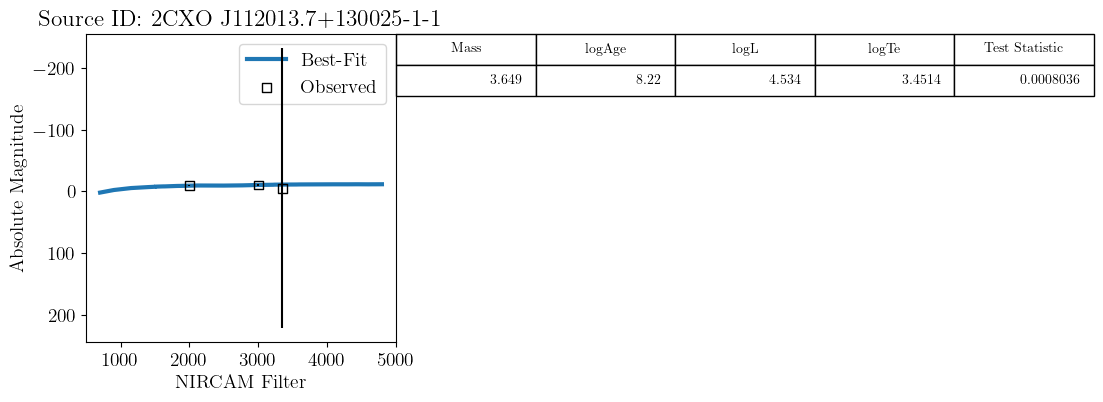

No best-fit model available for Source ID 2CXO J112013.7+130025-2-1.
No best-fit model available for Source ID 2CXO J112013.7+130025-4-1.
No best-fit model available for Source ID 2CXO J112013.7+130025-4-3.
No best-fit model available for Source ID 2CXO J112013.7+130025-5-2.


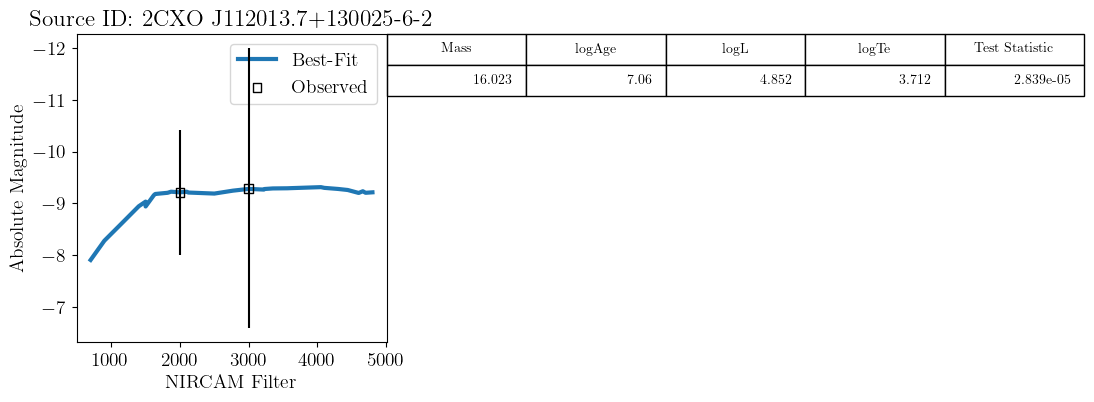

No best-fit model available for Source ID 2CXO J112013.7+130025-8-3.
No best-fit model available for Source ID 2CXO J112013.7+130025-11-4.


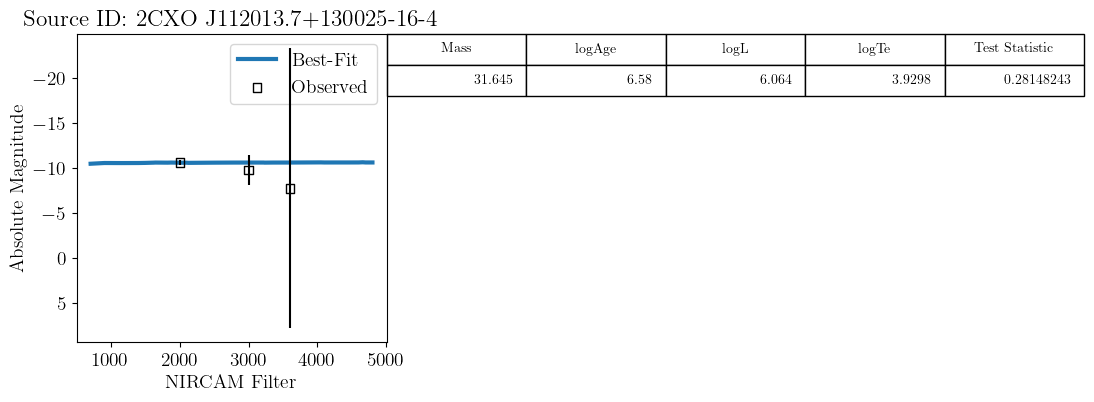

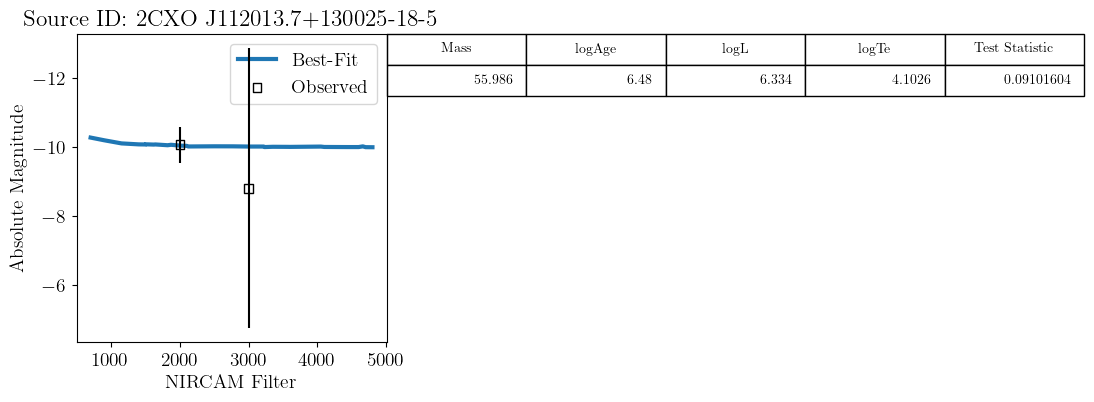

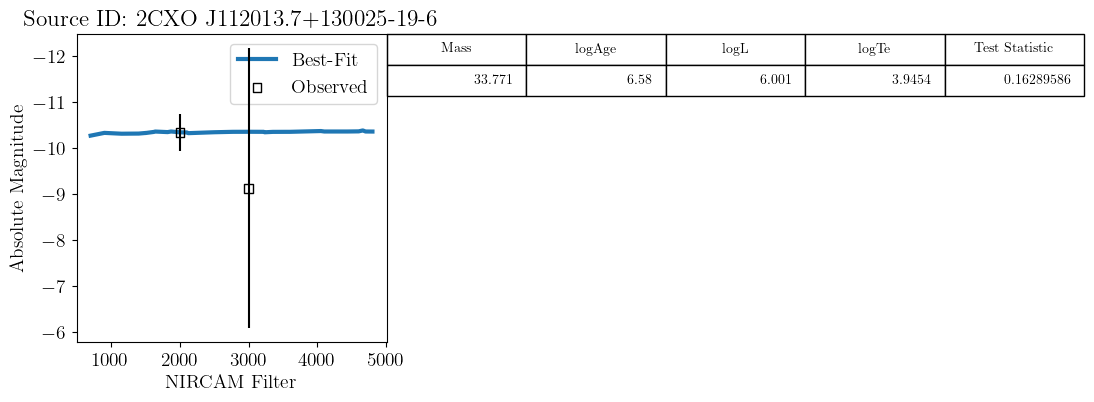

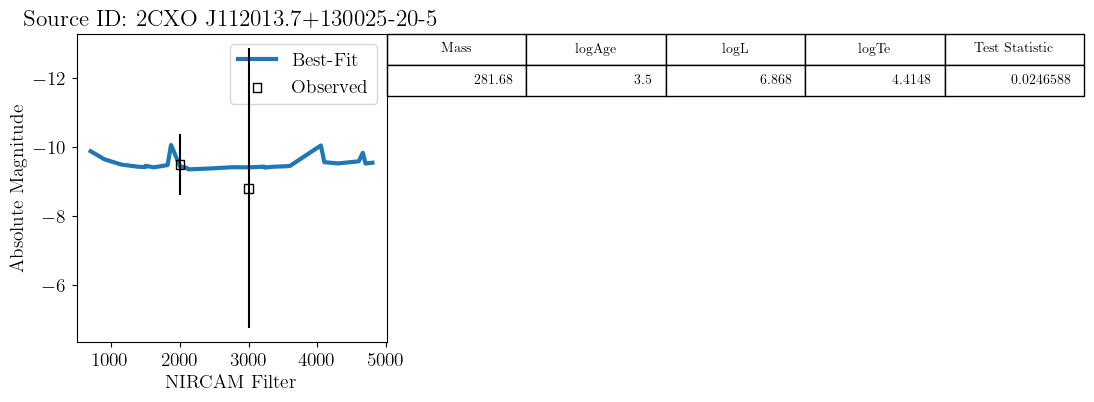

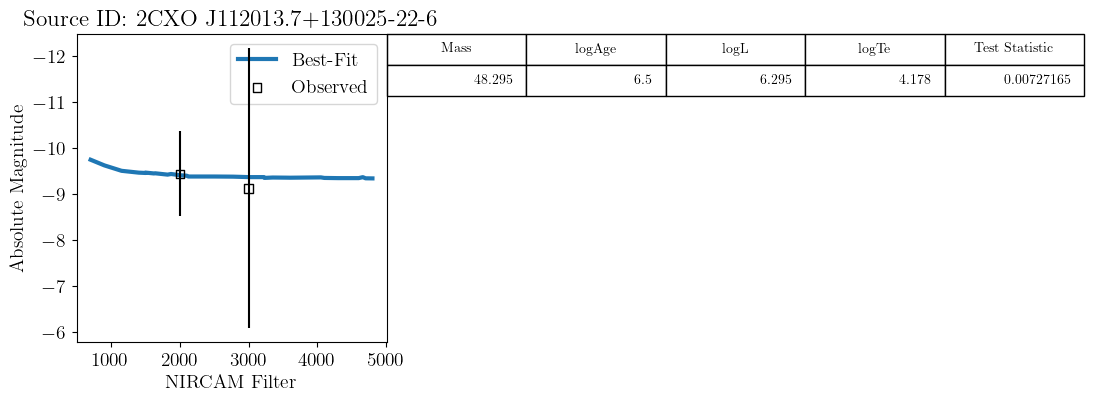

No best-fit model available for Source ID 2CXO J112013.7+130025-23-6.


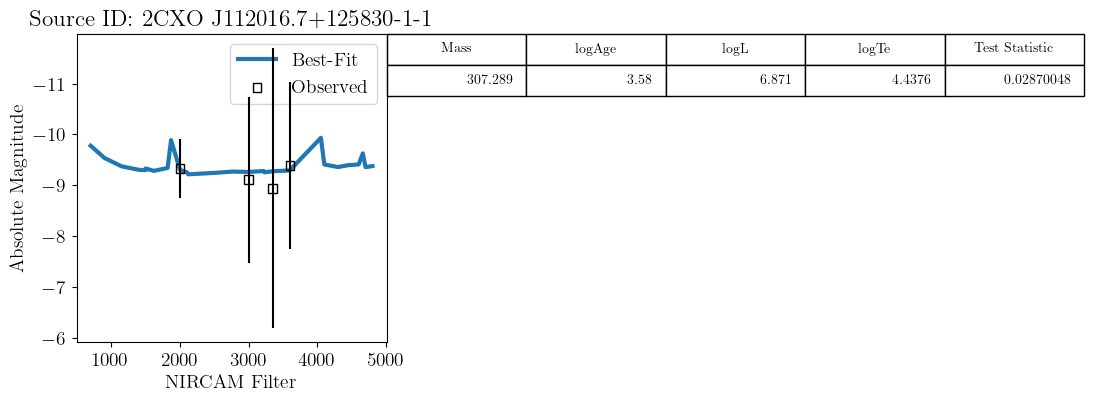

No best-fit model available for Source ID 2CXO J112016.7+125830-5-2.
No best-fit model available for Source ID 2CXO J112016.7+125830-6-2.
No best-fit model available for Source ID 2CXO J112019.5+125958-9-1.
No best-fit model available for Source ID 2CXO J112019.5+125958-11-2.
No best-fit model available for Source ID 2CXO J112019.5+125958-15-3.
No best-fit model available for Source ID 2CXO J112019.0+130027-1-1.
No best-fit model available for Source ID 2CXO J112019.0+130027-12-2.


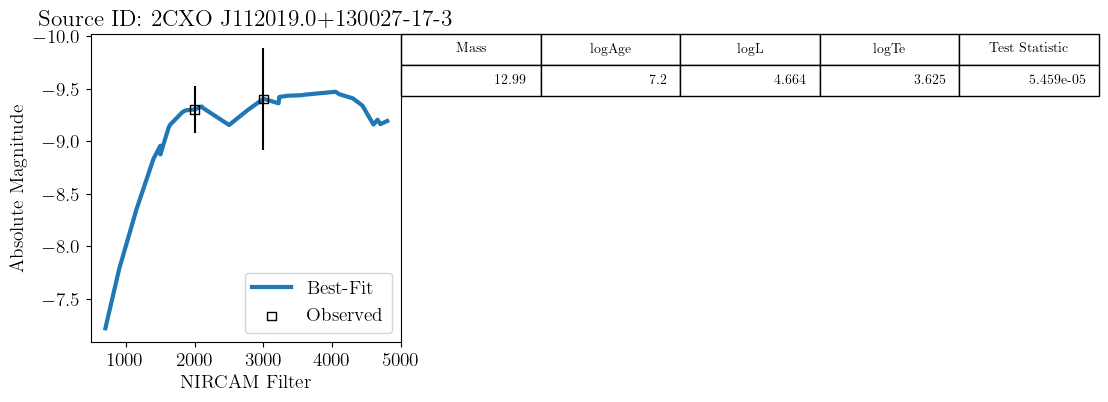

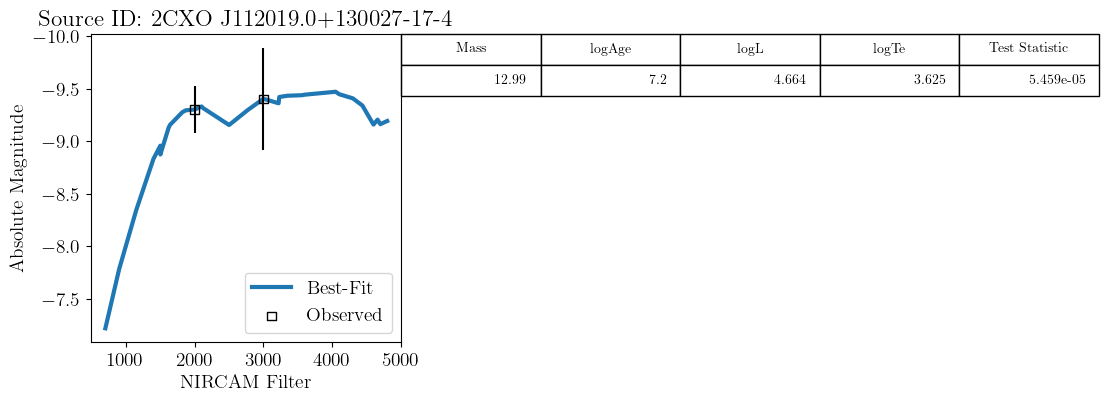

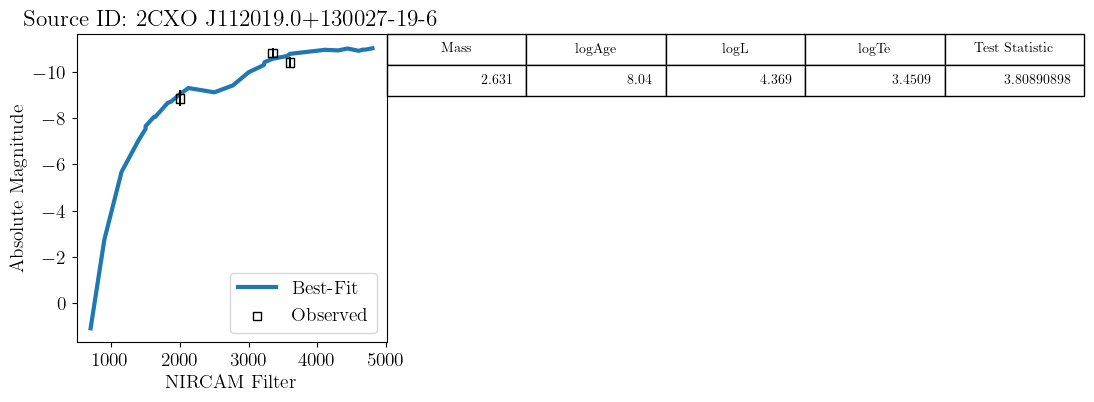

No best-fit model available for Source ID 2CXO J112019.0+130027-23-7.


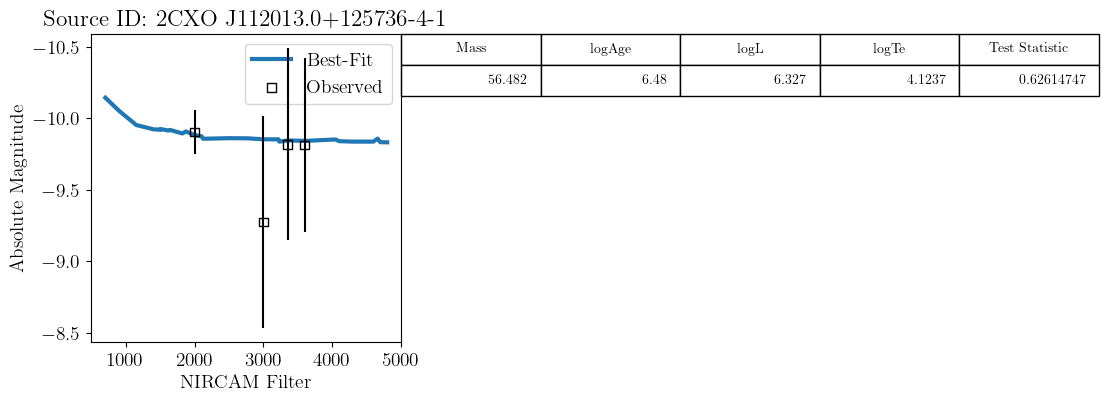

Zini       MH  logAge        Mini   int_IMF     Mass   logL   logTe  \
0   0.0152  0.01508    7.06   16.443396  2.629710   16.023  4.852  3.7120   
1   0.0152  0.01508    7.20   13.523454  2.628487   12.990  4.664  3.6250   
2   0.0152  0.01508    7.20   13.523454  2.628487   12.990  4.664  3.6250   
3   0.0152  0.01508    8.22    4.344301  2.610082    3.649  4.534  3.4514   
4   0.0152  0.01508    7.18   13.986730  2.628720   13.233  5.040  3.5256   
5   0.0152  0.01508    7.08   16.562857  2.629750   15.277  5.160  3.5276   
6   0.0152  0.01508    6.50   86.446579  2.633449   48.295  6.295  4.1780   
7   0.0152  0.01508    7.08   16.492239  2.629727   15.302  4.906  3.7292   
8   0.0152  0.01508    3.50  350.030090  2.633619  281.680  6.868  4.4148   
9   0.0152  0.01508    3.58  350.026917  2.633619  307.289  6.871  4.4376   
10  0.0152  0.01508    6.88   25.039473  2.631491   20.489  5.485  3.5310   
11  0.0152  0.01508    7.98    5.415937  2.616027    5.358  4.340  3.5178   
12  0.0152  0.01508    6.92   22.838467  2.631180   19.610  5.417  3.5296   
13  0.0152  0.01508    6.94   21.863184  2.631019   19.162  5.373  3.5302   
14  0.0152  0.01508    6.48   95.697075  2.633510   55.986  6.334  4.1026   
15  0.0152  0.01508    7.92    5.740193  2.617331    5.502  4.642  3.4804   
16  0.0152  0.01508    6.58   58.436291  2.633125   33.771  6.001  3.9454   
17  0.0152  0.01508    6.58   58.706402  2.633130   31.645  6.064  3.9298   
18  0.0152  0.01508    6.96   20.931231  2.630849   18.726  5.340  3.5295   
19  0.0152  0.01508    6.86   26.303152  2.631642   20.913  5.521  3.5316   
20  0.0152  0.01508    6.88   25.033937  2.631490   20.496  5.456  3.5338   
21  0.0152  0.01508    6.50   86.407707  2.633449   48.504  6.294  4.1285   
22  0.0152  0.01508    6.84   27.632059  2.631785   21.346  5.562  3.5319   
23  0.0152  0.01508    6.84   27.632059  2.631785   21.346  5.562  3.5319   
24  0.0152  0.01508    6.50   86.382622  2.633449   48.640  6.293  4.0935   
25  0.0152  0.01508    6.50   86.382622  2.633449   48.640  6.293  4.0935   
26  0.0152  0.01508    6.84   27.632059  2.631785   21.346  5.562  3.5319   
27  0.0152  0.01508    6.84   27.632059  2.631785   21.346  5.562  3.5319   
28  0.0152  0.01508    6.84   27.632059  2.631785   21.346  5.562  3.5319   
29  0.0152  0.01508    8.04    5.119606  2.614668    2.631  4.369  3.4509   
30  0.0152  0.01508    7.88    5.973933  2.618171    5.728  4.689  3.4778   
31  0.0152  0.01508    6.84   27.632059  2.631785   21.346  5.562  3.5319   
32  0.0152  0.01508    6.84   27.632059  2.631785   21.346  5.562  3.5319   
33  0.0152  0.01508    6.48   95.641296  2.633509   56.482  6.327  4.1237   

     logg label  McoreTP    C_O  period0  period1  period2  period3  period4  \
0   0.591     1    0.000  0.402     0.00     0.00     0.00     0.00     0.00   
1   0.339     6    0.000  0.397     0.00     0.00     0.00     0.00     0.00   
2   0.339     6    0.000  0.397     0.00     0.00     0.00     0.00     0.00   
3  -0.776     8    0.828  0.464   743.06    -1.00    -1.00    -1.00    -1.00   
4  -0.426     7    0.000  0.381   692.60   356.38   223.40   165.64   138.25   
5  -0.476     3    0.000  0.370   778.41   404.77   253.10   187.01   156.31   
6   1.490     1    0.000  1.165     0.00     0.00     0.00     0.00     0.00   
7   0.585     3    0.000  0.401   107.44    59.46    40.53    29.11    24.22   
8   2.631     0    0.000  1.039     0.00     0.00     0.00     0.00     0.00   
9   2.757     0    0.000  0.776     0.00     0.00     0.00     0.00     0.00   
10 -0.659     3    0.000  0.358  1123.12   608.13   375.82   276.38   231.75   
11 -0.150     7    0.000  0.380   361.07   171.71   109.00    82.64    68.39   
12 -0.616     3    0.000  0.380  1037.96   556.54   344.98   253.77   212.68   
13 -0.580     3    0.000  0.390   975.07   518.28   322.13   236.91   198.48   
14  1.215     1    0.000  1.125     0.00     0.00     0.00     0.00     0.00   
15 -0.590     8    0.951  0.40

In [10]:
best_fit = FitSED(
    df=M66_xrbs,
    instrument='nircam',
    idheader='Auxiliary ID',
    # input_model=M66_dir+'XRB-ejection/wfc3_nircam_models_0.02.txt',
)

best_fit = best_fit.merge(M66_xrbs[['Auxiliary ID', 'CSC ID', 'Class']],
                          on='Auxiliary ID', how='left')
best_fit

In [279]:
mutual_photometry.query('`CSC ID` == "2CXO J112018.8+125924"')

JWST RA   JWST Dec  JWST ID  HST ID  F2000W ID  F3000M ID  F3350M ID  \
480  170.078561  12.990114        1       1     176303        NaN        NaN   
481  170.078537  12.990170        3       1     176691        NaN        NaN   
482  170.078486  12.990244        6       2     177274        NaN        NaN   
483  170.078509  12.990256        7       2     177335        NaN        NaN   

     F3600M ID       JWST X       JWST Y                 CSC ID        HST X  \
480        NaN  1251.021887  5613.966926  2CXO J112018.8+125924  2302.366494   
481        NaN  1253.750699  5620.481728  2CXO J112018.8+125924  2302.366494   
482        NaN  1259.482820  5629.210226  2CXO J112018.8+125924  2312.165203   
483        NaN  1256.959561  5630.591470  2CXO J112018.8+125924  2312.165203   

           HST Y  F555W ID  F275W ID  F336W ID  F438W ID  F814W ID  \
480  5609.855137     17368       NaN   92493.0   33299.0       NaN   
481  5609.855137     17368       NaN   92493.0   33299.0       NaN   
482  5616.540985     17424       NaN   92649.0   33396.0       NaN   
483  5616.540985     17424       NaN   92649.0   33396.0       NaN   

         HST RA    HST Dec    F2000W  F2000W Err  F3000M  F3000M Err  F3350M  \
480  170.078573  12.990164 -9.323464   -0.446072     NaN         NaN     NaN   
481  170.078573  12.990164 -9.292746   -0.448976     NaN         NaN     NaN   
482  170.078462  12.990238 -9.351096   -0.414785     NaN         NaN     NaN   
483  170.078462  12.990238 -9.266732   -0.446266     NaN         NaN     NaN   

     F3350M Err  F3600M  F3600M Err  F275W  F275W Err     F336W  F336W Err  \
480         NaN     NaN         NaN    NaN        NaN -7.543231  -0.116033   
481         NaN     NaN         NaN    NaN        NaN -7.543231  -0.116033   
482         NaN     NaN         NaN    NaN        NaN -6.574923  -0.276174   
483         NaN     NaN         NaN    NaN        NaN -6.574923  -0.276174   

        F438W  F438W Err     F555W  F555W Err  F814W  F814W Err Class  
480 -6.105594  -0.208255 -5.896584  -0.351030    NaN        NaN  HMXB  
481 -6.105594  -0.208255 -5.896584  -0.351030    NaN        NaN  HMXB  
482 -4.756697  -0.675113 -6.102001  -0.284258    NaN        NaN  HMXB  
483 -4.756697  -0.675113 -6.102001  -0.284258    NaN        NaN  HMXB